In [1]:
#méthode de gradient boosting avec surement du stacking pour le forecasting

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [18]:
uber = pd.read_csv('../uber_data.csv', parse_dates = True)

In [19]:
uber_man = uber[uber['borough'] == 'Manhattan']

In [20]:
uber_man = uber_man.drop('borough', axis=1)

uber_man['pickup_dt'] = uber_man['pickup_dt'].astype(str) 

uber_man = uber_man.set_index('pickup_dt')

uber_man = pd.get_dummies(uber_man)

In [21]:
uber_man.tail()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-06-30 19:00:00     4585  5.0  10.0  80.0  58.0  1012.5    0.0    0.0   
2015-06-30 20:00:00     4210  8.0  10.0  80.0  58.0  1012.4    0.0    0.0   
2015-06-30 21:00:00     4313  7.0  10.0  76.0  61.0  1012.4    0.0    0.0   
2015-06-30 22:00:00     4452  5.0  10.0  76.0  64.0  1011.9    0.0    0.0   
2015-06-30 23:00:00     3828  7.0  10.0  75.0  65.0  1011.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y  
pickup_dt                                        
2015-06-30 19:00:00    0.0  0.0       1       0  
2015-06-30 20:00:00    0.0  0.0       1       0  
2015-06-30 21:00:00    0.0  0.0       1       0  
2015-06-30 22:00:00    0.0  0.0       1       0  
2015-06-30 23:00:00    0.0  0.0       1       0

Ajout d'une lag feature sur la serie
il s'agit d'horizon en heure donc on peut faire des lags sur les heures précédentes jusqu'à -4h par exemple
ensuite sur le jour précédent à la même heure
la semaine précédente
et enfin le mois

In [22]:
#lag features
for i in [1,2,3,4,24,7*24]:
    uber_man[f'lag_{i}'] = uber_man.pickups.shift(i)

In [23]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [24]:
import lightgbm as lgb

In [25]:
uber_man.head()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-01-01 01:00:00     5258  5.0  10.0  30.0   7.0  1023.5    0.0    0.0   
2015-01-01 02:00:00     4345  3.0  10.0  30.0   6.0  1023.0    0.0    0.0   
2015-01-01 03:00:00     4577  5.0  10.0  30.0   8.0  1022.3    0.0    0.0   
2015-01-01 04:00:00     3003  5.0  10.0  29.0   9.0  1022.0    0.0    0.0   
2015-01-01 05:00:00     1313  5.0  10.0  28.0   9.0  1021.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y   lag_1   lag_2   lag_3  \
pickup_dt                                                                 
2015-01-01 01:00:00    0.0  0.0       0       1     NaN     NaN     NaN   
2015-01-01 02:00:00    0.0  0.0       0       1  5258.0     NaN     NaN   
2015-01-01 03:00:00    0.0  0.0       0       1  4345.0  5258.0     NaN   
2015-01-01 04:00:00    0.0  0.0       0       1  4577.0  4345.0  5258.0   
2015-01-01 05:00:00    0.0  0.0       0       1  3003.0  4577.0  4345.0   

                      lag_4  lag_24  lag_168  
pickup_dt                                     
2015-01-01 01:00:00     NaN     NaN      NaN  
2015-01-01 02:00:00     NaN     NaN      NaN  
2015-01-01 03:00:00     NaN     NaN      NaN  
2015-01-01 04:00:00     NaN     NaN      NaN  
2015-01-01 05:00:00  5258.0     NaN      NaN

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split

#uber_mancv = uber_man.reset_index(drop=True)

X = uber_man.drop('pickups', axis=1)
y = uber_man['pickups']




tscv = TimeSeriesSplit(n_splits = 3)

    
    
    
train, test = temporal_train_test_split(uber_man, test_size = 0.3)

X_train = train.drop('pickups', axis=1)
y_train = train['pickups']
X_test = test.drop('pickups',axis=1)
y_test = test['pickups']

In [27]:
len(X_test)

1303

In [28]:
from sklearn.model_selection import RandomizedSearchCV

rs_params = {
    'learning_rate': [0.01,0.03,0.01],
    'max_depth': [2,4,6,8,10,12],
    'num_leaves': [10,20,40,60,100,200],
    'metric': ['mape'],
    'num_iterations': [500],
    'objective':['poisson','tweedie','mape','regression']
}

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), param_distributions=rs_params,
                           cv = tscv, n_iter=100,verbose=1)




In [29]:
#alors la le set de validation n'est pas bon il ne devrait pas etre fait avec le X_test et y_test
rs_cv.fit(X_train, y_train,verbose=1, early_stopping_rounds= 100,eval_set = (X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[1]	valid_0's mape: 0.978599
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.957841
[3]	valid_0's mape: 0.937705
[4]	valid_0's mape: 0.918173
[5]	valid_0's mape: 0.899228
[6]	valid_0's mape: 0.88085
[7]	valid_0's mape: 0.863024
[8]	valid_0's mape: 0.845733
[9]	valid_0's mape: 0.82896
[10]	valid_0's mape: 0.812691
[11]	valid_0's mape: 0.79691
[12]	valid_0's mape: 0.781602
[13]	valid_0's mape: 0.766753
[14]	valid_0's mape: 0.75235
[15]	valid_0's mape: 0.738464
[16]	valid_0's mape: 0.72516
[17]	valid_0's mape: 0.712405
[18]	valid_0's mape: 0.700151
[19]	valid_0's mape: 0.68853
[20]	valid_0's mape: 0.677483
[21]	valid_0's mape: 0.66701
[22]	valid_0's mape: 0.657046
[23]	valid_0's mape: 0.647602
[24]	valid_0's mape: 0.638607
[25]	valid_0's mape: 0.630004
[26]	valid_0's mape: 0.621724
[27]	valid_0's mape: 0.613774
[28]	valid_0's mape: 0.606152
[29]	valid_0's mape: 0.598902
[30]	valid_0's mape: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[221]	valid_0's mape: 0.346872
[222]	valid_0's mape: 0.346943
[223]	valid_0's mape: 0.346834
[224]	valid_0's mape: 0.346732
[225]	valid_0's mape: 0.346788
[226]	valid_0's mape: 0.346773
[227]	valid_0's mape: 0.346828
[228]	valid_0's mape: 0.346882
[229]	valid_0's mape: 0.346934
[230]	valid_0's mape: 0.346985
[231]	valid_0's mape: 0.347034
[232]	valid_0's mape: 0.347082
[233]	valid_0's mape: 0.346971
[234]	valid_0's mape: 0.347014
[235]	valid_0's mape: 0.347055
[236]	valid_0's mape: 0.347042
[237]	valid_0's mape: 0.347083
[238]	valid_0's mape: 0.347123
[239]	valid_0's mape: 0.347162
[240]	valid_0's mape: 0.3472
[241]	valid_0's mape: 0.347169
[242]	valid_0's mape: 0.347055
[243]	valid_0's mape: 0.347089
[244]	valid_0's mape: 0.347122
[245]	valid_0's mape: 0.344535
[246]	valid_0's mape: 0.344619
[247]	valid_0's mape: 0.344701
[248]	valid_0's mape: 0.34478
[249]	valid_0's mape: 0.344857
[250]	valid_0's mape: 0.34481
[251]	valid_0's mape: 0.344823
[252]	valid_0's mape: 0.344791
[253]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.953256
[3]	valid_0's mape: 0.930931
[4]	valid_0's mape: 0.909275
[5]	valid_0's mape: 0.888269
[6]	valid_0's mape: 0.867893
[7]	valid_0's mape: 0.848129
[8]	valid_0's mape: 0.828957
[9]	valid_0's mape: 0.81036
[10]	valid_0's mape: 0.792322
[11]	valid_0's mape: 0.774824
[12]	valid_0's mape: 0.758683
[13]	valid_0's mape: 0.743026
[14]	valid_0's mape: 0.727839
[15]	valid_0's mape: 0.713108
[16]	valid_0's mape: 0.698818
[17]	valid_0's mape: 0.684957
[18]	valid_0's mape: 0.671512
[19]	valid_0's mape: 0.658574
[20]	valid_0's mape: 0.646255
[21]	valid_0's mape: 0.634516
[22]	valid_0's mape: 0.623209
[23]	valid_0's mape: 0.612289
[24]	valid_0's mape: 0.601734
[25]	valid_0's mape: 0.591538
[26]	valid_0's mape: 0.581836
[27]	valid_0's mape: 0.57272
[28]	valid_0's mape: 0.564003
[29]	valid_0's mape: 0.555604
[30]	valid_0's mape: 0.547537
[31]	valid_0's mape: 0.539761
[32]	valid_0's mape: 0.53236
[33]	valid_0's mape: 0.525363
[34]	valid_0's mape: 0.518706
[35]	valid_0's mape: 

[467]	valid_0's mape: 0.219293
[468]	valid_0's mape: 0.219259
[469]	valid_0's mape: 0.219227
[470]	valid_0's mape: 0.219244
[471]	valid_0's mape: 0.219271
[472]	valid_0's mape: 0.219298
[473]	valid_0's mape: 0.219224
[474]	valid_0's mape: 0.219256
[475]	valid_0's mape: 0.219182
[476]	valid_0's mape: 0.219194
[477]	valid_0's mape: 0.219222
[478]	valid_0's mape: 0.21916
[479]	valid_0's mape: 0.219194
[480]	valid_0's mape: 0.219116
[481]	valid_0's mape: 0.219151
[482]	valid_0's mape: 0.219074
[483]	valid_0's mape: 0.219107
[484]	valid_0's mape: 0.21903
[485]	valid_0's mape: 0.219043
[486]	valid_0's mape: 0.219076
[487]	valid_0's mape: 0.218898
[488]	valid_0's mape: 0.218931
[489]	valid_0's mape: 0.217907
[490]	valid_0's mape: 0.217912
[491]	valid_0's mape: 0.217945
[492]	valid_0's mape: 0.21791
[493]	valid_0's mape: 0.21784
[494]	valid_0's mape: 0.217875
[495]	valid_0's mape: 0.217905
[496]	valid_0's mape: 0.217837
[497]	valid_0's mape: 0.217843
[498]	valid_0's mape: 0.216828
[499]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[106]	valid_0's mape: 0.382568
[107]	valid_0's mape: 0.380254
[108]	valid_0's mape: 0.380108
[109]	valid_0's mape: 0.377957
[110]	valid_0's mape: 0.377831
[111]	valid_0's mape: 0.374996
[112]	valid_0's mape: 0.374894
[113]	valid_0's mape: 0.37289
[114]	valid_0's mape: 0.372795
[115]	valid_0's mape: 0.372705
[116]	valid_0's mape: 0.371681
[117]	valid_0's mape: 0.371592
[118]	valid_0's mape: 0.369765
[119]	valid_0's mape: 0.369688
[120]	valid_0's mape: 0.367221
[121]	valid_0's mape: 0.367153
[122]	valid_0's mape: 0.366263
[123]	valid_0's mape: 0.366197
[124]	valid_0's mape: 0.364556
[125]	valid_0's mape: 0.364503
[126]	valid_0's mape: 0.361954
[127]	valid_0's mape: 0.361908
[128]	valid_0's mape: 0.359486
[129]	valid_0's mape: 0.359442
[130]	valid_0's mape: 0.358677
[131]	valid_0's mape: 0.358639
[132]	valid_0's mape: 0.356356
[133]	valid_0's mape: 0.356317
[134]	valid_0's mape: 0.354979
[135]	valid_0's mape: 0.352326
[136]	valid_0's mape: 0.352287
[137]	valid_0's mape: 0.350181
[138]	val

[376]	valid_0's mape: 0.282302
[377]	valid_0's mape: 0.282276
[378]	valid_0's mape: 0.28218
[379]	valid_0's mape: 0.282154
[380]	valid_0's mape: 0.282129
[381]	valid_0's mape: 0.282084
[382]	valid_0's mape: 0.282059
[383]	valid_0's mape: 0.28201
[384]	valid_0's mape: 0.281984
[385]	valid_0's mape: 0.280979
[386]	valid_0's mape: 0.280953
[387]	valid_0's mape: 0.280932
[388]	valid_0's mape: 0.280896
[389]	valid_0's mape: 0.280876
[390]	valid_0's mape: 0.280843
[391]	valid_0's mape: 0.280804
[392]	valid_0's mape: 0.280781
[393]	valid_0's mape: 0.280764
[394]	valid_0's mape: 0.280743
[395]	valid_0's mape: 0.280724
[396]	valid_0's mape: 0.280705
[397]	valid_0's mape: 0.280691
[398]	valid_0's mape: 0.280673
[399]	valid_0's mape: 0.280628
[400]	valid_0's mape: 0.28061
[401]	valid_0's mape: 0.280574
[402]	valid_0's mape: 0.280559
[403]	valid_0's mape: 0.280548
[404]	valid_0's mape: 0.280537
[405]	valid_0's mape: 0.280502
[406]	valid_0's mape: 0.280486
[407]	valid_0's mape: 0.280474
[408]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.706826
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.69805
[3]	valid_0's mape: 0.689401
[4]	valid_0's mape: 0.680905
[5]	valid_0's mape: 0.672567
[6]	valid_0's mape: 0.664397
[7]	valid_0's mape: 0.656518
[8]	valid_0's mape: 0.6488
[9]	valid_0's mape: 0.641191
[10]	valid_0's mape: 0.633402
[11]	valid_0's mape: 0.626025
[12]	valid_0's mape: 0.618441
[13]	valid_0's mape: 0.610971
[14]	valid_0's mape: 0.603949
[15]	valid_0's mape: 0.59676
[16]	valid_0's mape: 0.589595
[17]	valid_0's mape: 0.582781
[18]	valid_0's mape: 0.576126
[19]	valid_0's mape: 0.569344
[20]	valid_0's mape: 0.562638
[21]	valid_0's mape: 0.556083
[22]	valid_0's mape: 0.549773
[23]	valid_0's mape: 0.543699
[24]	valid_0's mape: 0.537387
[25]	valid_0's mape: 0.531309
[26]	valid_0's mape: 0.525512
[27]	valid_0's mape: 0.51967
[28]	valid_0's mape: 0.513707
[29]	valid_0's mape: 0.507928
[30]	valid_0's mape: 0.502394
[31]	valid_0's mape: 0.496814
[32]	valid_0's mape: 0

[290]	valid_0's mape: 0.136297
[291]	valid_0's mape: 0.136218
[292]	valid_0's mape: 0.13618
[293]	valid_0's mape: 0.13616
[294]	valid_0's mape: 0.136128
[295]	valid_0's mape: 0.136049
[296]	valid_0's mape: 0.135981
[297]	valid_0's mape: 0.135963
[298]	valid_0's mape: 0.135898
[299]	valid_0's mape: 0.13586
[300]	valid_0's mape: 0.135815
[301]	valid_0's mape: 0.13576
[302]	valid_0's mape: 0.135704
[303]	valid_0's mape: 0.135659
[304]	valid_0's mape: 0.135577
[305]	valid_0's mape: 0.135521
[306]	valid_0's mape: 0.135449
[307]	valid_0's mape: 0.135425
[308]	valid_0's mape: 0.13531
[309]	valid_0's mape: 0.135291
[310]	valid_0's mape: 0.135231
[311]	valid_0's mape: 0.13522
[312]	valid_0's mape: 0.135213
[313]	valid_0's mape: 0.135186
[314]	valid_0's mape: 0.135142
[315]	valid_0's mape: 0.135109
[316]	valid_0's mape: 0.135105
[317]	valid_0's mape: 0.135098
[318]	valid_0's mape: 0.135091
[319]	valid_0's mape: 0.135088
[320]	valid_0's mape: 0.13503
[321]	valid_0's mape: 0.134982
[322]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759673
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749489
[3]	valid_0's mape: 0.739438
[4]	valid_0's mape: 0.729622
[5]	valid_0's mape: 0.71992
[6]	valid_0's mape: 0.710389
[7]	valid_0's mape: 0.701016
[8]	valid_0's mape: 0.691804
[9]	valid_0's mape: 0.682777
[10]	valid_0's mape: 0.673901
[11]	valid_0's mape: 0.665083
[12]	valid_0's mape: 0.656474
[13]	valid_0's mape: 0.647978
[14]	valid_0's mape: 0.639615
[15]	valid_0's mape: 0.631377
[16]	valid_0's mape: 0.623305
[17]	valid_0's mape: 0.61529
[18]	valid_0's mape: 0.607528
[19]	valid_0's mape: 0.599806
[20]	valid_0's mape: 0.592295
[21]	valid_0's mape: 0.584833
[22]	valid_0's mape: 0.577618
[23]	valid_0's mape: 0.5703
[24]	valid_0's mape: 0.563144
[25]	valid_0's mape: 0.556336
[26]	valid_0's mape: 0.549558
[27]	valid_0's mape: 0.54294
[28]	valid_0's mape: 0.53645
[29]	valid_0's mape: 0.529955
[30]	valid_0's mape: 0.523517
[31]	valid_0's mape: 0.517186
[32]	valid_0's mape: 0.

[340]	valid_0's mape: 0.11162
[341]	valid_0's mape: 0.111608
[342]	valid_0's mape: 0.111571
[343]	valid_0's mape: 0.111552
[344]	valid_0's mape: 0.111601
[345]	valid_0's mape: 0.111576
[346]	valid_0's mape: 0.111561
[347]	valid_0's mape: 0.111585
[348]	valid_0's mape: 0.111539
[349]	valid_0's mape: 0.111495
[350]	valid_0's mape: 0.111491
[351]	valid_0's mape: 0.111467
[352]	valid_0's mape: 0.111469
[353]	valid_0's mape: 0.111463
[354]	valid_0's mape: 0.111453
[355]	valid_0's mape: 0.111478
[356]	valid_0's mape: 0.111533
[357]	valid_0's mape: 0.111466
[358]	valid_0's mape: 0.111526
[359]	valid_0's mape: 0.111494
[360]	valid_0's mape: 0.111489
[361]	valid_0's mape: 0.111502
[362]	valid_0's mape: 0.11153
[363]	valid_0's mape: 0.111528
[364]	valid_0's mape: 0.111557
[365]	valid_0's mape: 0.111589
[366]	valid_0's mape: 0.111584
[367]	valid_0's mape: 0.111617
[368]	valid_0's mape: 0.111648
[369]	valid_0's mape: 0.111636
[370]	valid_0's mape: 0.111649
[371]	valid_0's mape: 0.111632
[372]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759133
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.748946
[3]	valid_0's mape: 0.738915
[4]	valid_0's mape: 0.729042
[5]	valid_0's mape: 0.719336
[6]	valid_0's mape: 0.709791
[7]	valid_0's mape: 0.700503
[8]	valid_0's mape: 0.691248
[9]	valid_0's mape: 0.682107
[10]	valid_0's mape: 0.673284
[11]	valid_0's mape: 0.664464
[12]	valid_0's mape: 0.655931
[13]	valid_0's mape: 0.647322
[14]	valid_0's mape: 0.638974
[15]	valid_0's mape: 0.630822
[16]	valid_0's mape: 0.622686
[17]	valid_0's mape: 0.614739
[18]	valid_0's mape: 0.606865
[19]	valid_0's mape: 0.599245
[20]	valid_0's mape: 0.591589
[21]	valid_0's mape: 0.58419
[22]	valid_0's mape: 0.576812
[23]	valid_0's mape: 0.5697
[24]	valid_0's mape: 0.562649
[25]	valid_0's mape: 0.555775
[26]	valid_0's mape: 0.549001
[27]	valid_0's mape: 0.542388
[28]	valid_0's mape: 0.535852
[29]	valid_0's mape: 0.529444
[30]	valid_0's mape: 0.523151
[31]	valid_0's mape: 0.516958
[32]	valid_0's mape:

[282]	valid_0's mape: 0.103702
[283]	valid_0's mape: 0.103608
[284]	valid_0's mape: 0.103502
[285]	valid_0's mape: 0.103433
[286]	valid_0's mape: 0.103343
[287]	valid_0's mape: 0.103241
[288]	valid_0's mape: 0.103167
[289]	valid_0's mape: 0.10307
[290]	valid_0's mape: 0.102976
[291]	valid_0's mape: 0.102914
[292]	valid_0's mape: 0.102831
[293]	valid_0's mape: 0.102765
[294]	valid_0's mape: 0.102701
[295]	valid_0's mape: 0.102604
[296]	valid_0's mape: 0.102525
[297]	valid_0's mape: 0.102465
[298]	valid_0's mape: 0.102388
[299]	valid_0's mape: 0.102325
[300]	valid_0's mape: 0.102241
[301]	valid_0's mape: 0.10218
[302]	valid_0's mape: 0.102105
[303]	valid_0's mape: 0.102058
[304]	valid_0's mape: 0.102002
[305]	valid_0's mape: 0.101958
[306]	valid_0's mape: 0.101884
[307]	valid_0's mape: 0.101839
[308]	valid_0's mape: 0.101787
[309]	valid_0's mape: 0.101772
[310]	valid_0's mape: 0.101728
[311]	valid_0's mape: 0.101703
[312]	valid_0's mape: 0.101675
[313]	valid_0's mape: 0.101631
[314]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.689215
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.663941
[3]	valid_0's mape: 0.640559
[4]	valid_0's mape: 0.617399
[5]	valid_0's mape: 0.59523
[6]	valid_0's mape: 0.574162
[7]	valid_0's mape: 0.554628
[8]	valid_0's mape: 0.535051
[9]	valid_0's mape: 0.517207
[10]	valid_0's mape: 0.500634
[11]	valid_0's mape: 0.483844
[12]	valid_0's mape: 0.467403
[13]	valid_0's mape: 0.452036
[14]	valid_0's mape: 0.437541
[15]	valid_0's mape: 0.423473
[16]	valid_0's mape: 0.409397
[17]	valid_0's mape: 0.396115
[18]	valid_0's mape: 0.383138
[19]	valid_0's mape: 0.371008
[20]	valid_0's mape: 0.358927
[21]	valid_0's mape: 0.347896
[22]	valid_0's mape: 0.337045
[23]	valid_0's mape: 0.326856
[24]	valid_0's mape: 0.317345
[25]	valid_0's mape: 0.307785
[26]	valid_0's mape: 0.298791
[27]	valid_0's mape: 0.289997
[28]	valid_0's mape: 0.281631
[29]	valid_0's mape: 0.273933
[30]	valid_0's mape: 0.26674
[31]	valid_0's mape: 0.259629
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.739264
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.710014
[3]	valid_0's mape: 0.682199
[4]	valid_0's mape: 0.655846
[5]	valid_0's mape: 0.630553
[6]	valid_0's mape: 0.606482
[7]	valid_0's mape: 0.583597
[8]	valid_0's mape: 0.562216
[9]	valid_0's mape: 0.541857
[10]	valid_0's mape: 0.522266
[11]	valid_0's mape: 0.503558
[12]	valid_0's mape: 0.485876
[13]	valid_0's mape: 0.469208
[14]	valid_0's mape: 0.452809
[15]	valid_0's mape: 0.437683
[16]	valid_0's mape: 0.422274
[17]	valid_0's mape: 0.407697
[18]	valid_0's mape: 0.393505
[19]	valid_0's mape: 0.379895
[20]	valid_0's mape: 0.366972
[21]	valid_0's mape: 0.354646
[22]	valid_0's mape: 0.342889
[23]	valid_0's mape: 0.331274
[24]	valid_0's mape: 0.320213
[25]	valid_0's mape: 0.309705
[26]	valid_0's mape: 0.299604
[27]	valid_0's mape: 0.289921
[28]	valid_0's mape: 0.280754
[29]	valid_0's mape: 0.272354
[30]	valid_0's mape: 0.26366
[31]	valid_0's mape: 0.255879
[32]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.73879
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.709545
[3]	valid_0's mape: 0.681692
[4]	valid_0's mape: 0.655381
[5]	valid_0's mape: 0.630382
[6]	valid_0's mape: 0.606511
[7]	valid_0's mape: 0.584046
[8]	valid_0's mape: 0.562011
[9]	valid_0's mape: 0.541531
[10]	valid_0's mape: 0.521998
[11]	valid_0's mape: 0.503486
[12]	valid_0's mape: 0.485769
[13]	valid_0's mape: 0.468737
[14]	valid_0's mape: 0.452555
[15]	valid_0's mape: 0.437002
[16]	valid_0's mape: 0.421594
[17]	valid_0's mape: 0.40725
[18]	valid_0's mape: 0.393866
[19]	valid_0's mape: 0.380812
[20]	valid_0's mape: 0.368081
[21]	valid_0's mape: 0.356091
[22]	valid_0's mape: 0.344335
[23]	valid_0's mape: 0.333119
[24]	valid_0's mape: 0.32264
[25]	valid_0's mape: 0.312147
[26]	valid_0's mape: 0.302552
[27]	valid_0's mape: 0.293439
[28]	valid_0's mape: 0.284699
[29]	valid_0's mape: 0.276462
[30]	valid_0's mape: 0.26837
[31]	valid_0's mape: 0.26041
[32]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991267
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982621
[3]	valid_0's mape: 0.974062
[4]	valid_0's mape: 0.965588
[5]	valid_0's mape: 0.957199
[6]	valid_0's mape: 0.948894
[7]	valid_0's mape: 0.940672
[8]	valid_0's mape: 0.932532
[9]	valid_0's mape: 0.924473
[10]	valid_0's mape: 0.916495
[11]	valid_0's mape: 0.908597
[12]	valid_0's mape: 0.900778
[13]	valid_0's mape: 0.893037
[14]	valid_0's mape: 0.885374
[15]	valid_0's mape: 0.877787
[16]	valid_0's mape: 0.870276
[17]	valid_0's mape: 0.86284
[18]	valid_0's mape: 0.855478
[19]	valid_0's mape: 0.84819
[20]	valid_0's mape: 0.840975
[21]	valid_0's mape: 0.833833
[22]	valid_0's mape: 0.826761
[23]	valid_0's mape: 0.81976
[24]	valid_0's mape: 0.81283
[25]	valid_0's mape: 0.805968
[26]	valid_0's mape: 0.799175
[27]	valid_0's mape: 0.79245
[28]	valid_0's mape: 0.785793
[29]	valid_0's mape: 0.779202
[30]	valid_0's mape: 0.772641
[31]	valid_0's mape: 0.766146
[32]	valid_0's mape: 0

[432]	valid_0's mape: 0.2363
[433]	valid_0's mape: 0.236286
[434]	valid_0's mape: 0.236082
[435]	valid_0's mape: 0.235506
[436]	valid_0's mape: 0.235538
[437]	valid_0's mape: 0.234999
[438]	valid_0's mape: 0.234491
[439]	valid_0's mape: 0.234493
[440]	valid_0's mape: 0.234481
[441]	valid_0's mape: 0.234478
[442]	valid_0's mape: 0.234504
[443]	valid_0's mape: 0.234434
[444]	valid_0's mape: 0.234373
[445]	valid_0's mape: 0.233836
[446]	valid_0's mape: 0.2336
[447]	valid_0's mape: 0.233562
[448]	valid_0's mape: 0.233558
[449]	valid_0's mape: 0.233573
[450]	valid_0's mape: 0.233601
[451]	valid_0's mape: 0.233563
[452]	valid_0's mape: 0.23297
[453]	valid_0's mape: 0.232803
[454]	valid_0's mape: 0.232829
[455]	valid_0's mape: 0.232421
[456]	valid_0's mape: 0.232408
[457]	valid_0's mape: 0.232123
[458]	valid_0's mape: 0.232112
[459]	valid_0's mape: 0.232041
[460]	valid_0's mape: 0.232043
[461]	valid_0's mape: 0.232009
[462]	valid_0's mape: 0.231939
[463]	valid_0's mape: 0.23187
[464]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[81]	valid_0's mape: 0.516295
[82]	valid_0's mape: 0.513305
[83]	valid_0's mape: 0.510345
[84]	valid_0's mape: 0.507415
[85]	valid_0's mape: 0.504527
[86]	valid_0's mape: 0.501702
[87]	valid_0's mape: 0.498918
[88]	valid_0's mape: 0.496169
[89]	valid_0's mape: 0.493464
[90]	valid_0's mape: 0.490813
[91]	valid_0's mape: 0.4882
[92]	valid_0's mape: 0.485566
[93]	valid_0's mape: 0.482964
[94]	valid_0's mape: 0.480462
[95]	valid_0's mape: 0.477992
[96]	valid_0's mape: 0.475553
[97]	valid_0's mape: 0.473149
[98]	valid_0's mape: 0.470778
[99]	valid_0's mape: 0.468434
[100]	valid_0's mape: 0.46612
[101]	valid_0's mape: 0.463853
[102]	valid_0's mape: 0.461583
[103]	valid_0's mape: 0.459369
[104]	valid_0's mape: 0.457207
[105]	valid_0's mape: 0.455118
[106]	valid_0's mape: 0.452673
[107]	valid_0's mape: 0.450252
[108]	valid_0's mape: 0.447856
[109]	valid_0's mape: 0.445483
[110]	valid_0's mape: 0.443079
[111]	valid_0's mape: 0.440704
[112]	valid_0's mape: 0.438354
[113]	valid_0's mape: 0.436031

[401]	valid_0's mape: 0.221541
[402]	valid_0's mape: 0.22067
[403]	valid_0's mape: 0.219854
[404]	valid_0's mape: 0.218984
[405]	valid_0's mape: 0.218185
[406]	valid_0's mape: 0.217437
[407]	valid_0's mape: 0.217027
[408]	valid_0's mape: 0.21662
[409]	valid_0's mape: 0.215916
[410]	valid_0's mape: 0.215162
[411]	valid_0's mape: 0.214416
[412]	valid_0's mape: 0.213677
[413]	valid_0's mape: 0.213257
[414]	valid_0's mape: 0.213062
[415]	valid_0's mape: 0.21243
[416]	valid_0's mape: 0.212246
[417]	valid_0's mape: 0.212071
[418]	valid_0's mape: 0.21139
[419]	valid_0's mape: 0.211096
[420]	valid_0's mape: 0.210921
[421]	valid_0's mape: 0.210791
[422]	valid_0's mape: 0.210156
[423]	valid_0's mape: 0.209529
[424]	valid_0's mape: 0.208941
[425]	valid_0's mape: 0.20882
[426]	valid_0's mape: 0.208203
[427]	valid_0's mape: 0.207649
[428]	valid_0's mape: 0.207018
[429]	valid_0's mape: 0.206897
[430]	valid_0's mape: 0.206781
[431]	valid_0's mape: 0.20621
[432]	valid_0's mape: 0.205661
[433]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.766765
[32]	valid_0's mape: 0.760508
[33]	valid_0's mape: 0.754313
[34]	valid_0's mape: 0.748181
[35]	valid_0's mape: 0.74211
[36]	valid_0's mape: 0.736099
[37]	valid_0's mape: 0.730149
[38]	valid_0's mape: 0.724258
[39]	valid_0's mape: 0.718426
[40]	valid_0's mape: 0.712652
[41]	valid_0's mape: 0.706936
[42]	valid_0's mape: 0.701277
[43]	valid_0's mape: 0.695675
[44]	valid_0's mape: 0.690146
[45]	valid_0's mape: 0.684683
[46]	valid_0's mape: 0.679275
[47]	valid_0's mape: 0.673921
[48]	valid_0's mape: 0.66862
[49]	valid_0's mape: 0.663345
[50]	valid_0's mape: 0.658123
[51]	valid_0's mape: 0.652953
[52]	valid_0's mape: 0.647835
[53]	valid_0's mape: 0.642438
[54]	valid_0's mape: 0.636995
[55]	valid_0's mape: 0.631606
[56]	valid_0's mape: 0.62616
[57]	valid_0's mape: 0.620797
[58]	valid_0's mape: 0.615509
[59]	valid_0's mape: 0.610307
[60]	valid_0's mape: 0.605194
[61]	valid_0's mape: 0.600142
[62]	valid_0's mape: 0.596307
[63]	valid_0's mape: 0.592511
[64]	valid_0'

[430]	valid_0's mape: 0.20301
[431]	valid_0's mape: 0.202596
[432]	valid_0's mape: 0.202194
[433]	valid_0's mape: 0.201841
[434]	valid_0's mape: 0.201794
[435]	valid_0's mape: 0.201748
[436]	valid_0's mape: 0.201702
[437]	valid_0's mape: 0.201632
[438]	valid_0's mape: 0.201266
[439]	valid_0's mape: 0.201225
[440]	valid_0's mape: 0.200867
[441]	valid_0's mape: 0.200779
[442]	valid_0's mape: 0.200693
[443]	valid_0's mape: 0.200607
[444]	valid_0's mape: 0.200185
[445]	valid_0's mape: 0.199763
[446]	valid_0's mape: 0.19965
[447]	valid_0's mape: 0.199246
[448]	valid_0's mape: 0.199107
[449]	valid_0's mape: 0.19897
[450]	valid_0's mape: 0.19883
[451]	valid_0's mape: 0.198691
[452]	valid_0's mape: 0.198288
[453]	valid_0's mape: 0.197863
[454]	valid_0's mape: 0.197681
[455]	valid_0's mape: 0.19726
[456]	valid_0's mape: 0.196844
[457]	valid_0's mape: 0.196433
[458]	valid_0's mape: 0.196029
[459]	valid_0's mape: 0.195903
[460]	valid_0's mape: 0.195779
[461]	valid_0's mape: 0.195648
[462]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[94]	valid_0's mape: 0.279664
[95]	valid_0's mape: 0.277685
[96]	valid_0's mape: 0.275904
[97]	valid_0's mape: 0.273925
[98]	valid_0's mape: 0.272109
[99]	valid_0's mape: 0.270808
[100]	valid_0's mape: 0.268877
[101]	valid_0's mape: 0.267073
[102]	valid_0's mape: 0.265629
[103]	valid_0's mape: 0.26389
[104]	valid_0's mape: 0.262436
[105]	valid_0's mape: 0.260746
[106]	valid_0's mape: 0.259017
[107]	valid_0's mape: 0.257875
[108]	valid_0's mape: 0.256519
[109]	valid_0's mape: 0.254942
[110]	valid_0's mape: 0.253574
[111]	valid_0's mape: 0.251931
[112]	valid_0's mape: 0.250736
[113]	valid_0's mape: 0.249779
[114]	valid_0's mape: 0.248184
[115]	valid_0's mape: 0.247251
[116]	valid_0's mape: 0.245815
[117]	valid_0's mape: 0.244722
[118]	valid_0's mape: 0.243257
[119]	valid_0's mape: 0.241643
[120]	valid_0's mape: 0.240781
[121]	valid_0's mape: 0.239779
[122]	valid_0's mape: 0.238367
[123]	valid_0's mape: 0.237597
[124]	valid_0's mape: 0.236603
[125]	valid_0's mape: 0.235264
[126]	valid_0's

[388]	valid_0's mape: 0.155195
[389]	valid_0's mape: 0.155133
[390]	valid_0's mape: 0.154988
[391]	valid_0's mape: 0.154766
[392]	valid_0's mape: 0.154691
[393]	valid_0's mape: 0.154552
[394]	valid_0's mape: 0.15454
[395]	valid_0's mape: 0.154544
[396]	valid_0's mape: 0.154469
[397]	valid_0's mape: 0.154236
[398]	valid_0's mape: 0.15446
[399]	valid_0's mape: 0.154464
[400]	valid_0's mape: 0.154432
[401]	valid_0's mape: 0.154297
[402]	valid_0's mape: 0.154163
[403]	valid_0's mape: 0.154126
[404]	valid_0's mape: 0.153941
[405]	valid_0's mape: 0.153877
[406]	valid_0's mape: 0.153807
[407]	valid_0's mape: 0.153759
[408]	valid_0's mape: 0.153609
[409]	valid_0's mape: 0.153535
[410]	valid_0's mape: 0.153482
[411]	valid_0's mape: 0.153264
[412]	valid_0's mape: 0.153483
[413]	valid_0's mape: 0.153426
[414]	valid_0's mape: 0.153348
[415]	valid_0's mape: 0.153155
[416]	valid_0's mape: 0.153121
[417]	valid_0's mape: 0.153035
[418]	valid_0's mape: 0.153012
[419]	valid_0's mape: 0.15284
[420]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[243]	valid_0's mape: 0.156896
[244]	valid_0's mape: 0.156805
[245]	valid_0's mape: 0.156478
[246]	valid_0's mape: 0.156305
[247]	valid_0's mape: 0.155874
[248]	valid_0's mape: 0.155492
[249]	valid_0's mape: 0.155326
[250]	valid_0's mape: 0.154891
[251]	valid_0's mape: 0.154759
[252]	valid_0's mape: 0.154359
[253]	valid_0's mape: 0.154083
[254]	valid_0's mape: 0.154016
[255]	valid_0's mape: 0.153632
[256]	valid_0's mape: 0.153573
[257]	valid_0's mape: 0.153236
[258]	valid_0's mape: 0.153169
[259]	valid_0's mape: 0.152975
[260]	valid_0's mape: 0.152598
[261]	valid_0's mape: 0.152483
[262]	valid_0's mape: 0.152333
[263]	valid_0's mape: 0.151971
[264]	valid_0's mape: 0.151655
[265]	valid_0's mape: 0.151607
[266]	valid_0's mape: 0.15124
[267]	valid_0's mape: 0.151184
[268]	valid_0's mape: 0.150798
[269]	valid_0's mape: 0.150677
[270]	valid_0's mape: 0.15064
[271]	valid_0's mape: 0.150564
[272]	valid_0's mape: 0.150444
[273]	valid_0's mape: 0.150409
[274]	valid_0's mape: 0.150237
[275]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[36]	valid_0's mape: 0.500117
[37]	valid_0's mape: 0.494835
[38]	valid_0's mape: 0.488789
[39]	valid_0's mape: 0.483219
[40]	valid_0's mape: 0.47811
[41]	valid_0's mape: 0.472594
[42]	valid_0's mape: 0.467443
[43]	valid_0's mape: 0.4622
[44]	valid_0's mape: 0.457283
[45]	valid_0's mape: 0.451992
[46]	valid_0's mape: 0.44724
[47]	valid_0's mape: 0.442269
[48]	valid_0's mape: 0.437192
[49]	valid_0's mape: 0.432393
[50]	valid_0's mape: 0.427493
[51]	valid_0's mape: 0.422844
[52]	valid_0's mape: 0.418351
[53]	valid_0's mape: 0.413677
[54]	valid_0's mape: 0.409145
[55]	valid_0's mape: 0.404886
[56]	valid_0's mape: 0.400652
[57]	valid_0's mape: 0.395958
[58]	valid_0's mape: 0.39207
[59]	valid_0's mape: 0.388189
[60]	valid_0's mape: 0.383644
[61]	valid_0's mape: 0.379368
[62]	valid_0's mape: 0.375097
[63]	valid_0's mape: 0.371293
[64]	valid_0's mape: 0.367469
[65]	valid_0's mape: 0.363649
[66]	valid_0's mape: 0.3595
[67]	valid_0's mape: 0.35589
[68]	valid_0's mape: 0.352489
[69]	valid_0's ma

[389]	valid_0's mape: 0.128805
[390]	valid_0's mape: 0.12869
[391]	valid_0's mape: 0.128636
[392]	valid_0's mape: 0.128636
[393]	valid_0's mape: 0.128458
[394]	valid_0's mape: 0.128455
[395]	valid_0's mape: 0.128419
[396]	valid_0's mape: 0.128296
[397]	valid_0's mape: 0.128293
[398]	valid_0's mape: 0.128222
[399]	valid_0's mape: 0.128183
[400]	valid_0's mape: 0.128069
[401]	valid_0's mape: 0.128069
[402]	valid_0's mape: 0.127888
[403]	valid_0's mape: 0.127749
[404]	valid_0's mape: 0.127744
[405]	valid_0's mape: 0.127702
[406]	valid_0's mape: 0.127627
[407]	valid_0's mape: 0.127579
[408]	valid_0's mape: 0.127578
[409]	valid_0's mape: 0.127497
[410]	valid_0's mape: 0.127494
[411]	valid_0's mape: 0.127416
[412]	valid_0's mape: 0.127284
[413]	valid_0's mape: 0.127243
[414]	valid_0's mape: 0.127201
[415]	valid_0's mape: 0.127197
[416]	valid_0's mape: 0.12709
[417]	valid_0's mape: 0.127045
[418]	valid_0's mape: 0.126872
[419]	valid_0's mape: 0.126872
[420]	valid_0's mape: 0.126754
[421]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[91]	valid_0's mape: 0.459781
[92]	valid_0's mape: 0.45757
[93]	valid_0's mape: 0.455439
[94]	valid_0's mape: 0.453235
[95]	valid_0's mape: 0.451128
[96]	valid_0's mape: 0.448963
[97]	valid_0's mape: 0.446871
[98]	valid_0's mape: 0.444755
[99]	valid_0's mape: 0.442673
[100]	valid_0's mape: 0.440561
[101]	valid_0's mape: 0.438497
[102]	valid_0's mape: 0.436485
[103]	valid_0's mape: 0.434459
[104]	valid_0's mape: 0.432437
[105]	valid_0's mape: 0.430476
[106]	valid_0's mape: 0.428452
[107]	valid_0's mape: 0.426523
[108]	valid_0's mape: 0.424572
[109]	valid_0's mape: 0.422611
[110]	valid_0's mape: 0.42069
[111]	valid_0's mape: 0.418754
[112]	valid_0's mape: 0.416777
[113]	valid_0's mape: 0.414885
[114]	valid_0's mape: 0.413086
[115]	valid_0's mape: 0.411165
[116]	valid_0's mape: 0.409342
[117]	valid_0's mape: 0.407488
[118]	valid_0's mape: 0.405613
[119]	valid_0's mape: 0.403791
[120]	valid_0's mape: 0.401962
[121]	valid_0's mape: 0.400191
[122]	valid_0's mape: 0.398369
[123]	valid_0's map

[409]	valid_0's mape: 0.160418
[410]	valid_0's mape: 0.160167
[411]	valid_0's mape: 0.15988
[412]	valid_0's mape: 0.159586
[413]	valid_0's mape: 0.15932
[414]	valid_0's mape: 0.15907
[415]	valid_0's mape: 0.158779
[416]	valid_0's mape: 0.158513
[417]	valid_0's mape: 0.158258
[418]	valid_0's mape: 0.158022
[419]	valid_0's mape: 0.157747
[420]	valid_0's mape: 0.157474
[421]	valid_0's mape: 0.157218
[422]	valid_0's mape: 0.156953
[423]	valid_0's mape: 0.156687
[424]	valid_0's mape: 0.156432
[425]	valid_0's mape: 0.156197
[426]	valid_0's mape: 0.155982
[427]	valid_0's mape: 0.155724
[428]	valid_0's mape: 0.155482
[429]	valid_0's mape: 0.155234
[430]	valid_0's mape: 0.154979
[431]	valid_0's mape: 0.154726
[432]	valid_0's mape: 0.154511
[433]	valid_0's mape: 0.154277
[434]	valid_0's mape: 0.154027
[435]	valid_0's mape: 0.153817
[436]	valid_0's mape: 0.153594
[437]	valid_0's mape: 0.153357
[438]	valid_0's mape: 0.15313
[439]	valid_0's mape: 0.152897
[440]	valid_0's mape: 0.152676
[441]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.706893
[18]	valid_0's mape: 0.70347
[19]	valid_0's mape: 0.70004
[20]	valid_0's mape: 0.696655
[21]	valid_0's mape: 0.693287
[22]	valid_0's mape: 0.689915
[23]	valid_0's mape: 0.686584
[24]	valid_0's mape: 0.683272
[25]	valid_0's mape: 0.679948
[26]	valid_0's mape: 0.676631
[27]	valid_0's mape: 0.673366
[28]	valid_0's mape: 0.670096
[29]	valid_0's mape: 0.666883
[30]	valid_0's mape: 0.66368
[31]	valid_0's mape: 0.66045
[32]	valid_0's mape: 0.657227
[33]	valid_0's mape: 0.65404
[34]	valid_0's mape: 0.650872
[35]	valid_0's mape: 0.647729
[36]	valid_0's mape: 0.644591
[37]	valid_0's mape: 0.641417
[38]	valid_0's mape: 0.638281
[39]	valid_0's mape: 0.635156
[40]	valid_0's mape: 0.632041
[41]	valid_0's mape: 0.628947
[42]	valid_0's mape: 0.625871
[43]	valid_0's mape: 0.622807
[44]	valid_0's mape: 0.61976
[45]	valid_0's mape: 0.616724
[46]	valid_0's mape: 0.6137
[47]	valid_0's mape: 0.610725
[48]	valid_0's mape: 0.607771
[49]	valid_0's mape: 0.604831
[50]	valid_0's map

[334]	valid_0's mape: 0.180489
[335]	valid_0's mape: 0.179913
[336]	valid_0's mape: 0.179375
[337]	valid_0's mape: 0.178851
[338]	valid_0's mape: 0.178293
[339]	valid_0's mape: 0.177716
[340]	valid_0's mape: 0.177187
[341]	valid_0's mape: 0.176602
[342]	valid_0's mape: 0.17608
[343]	valid_0's mape: 0.175544
[344]	valid_0's mape: 0.175013
[345]	valid_0's mape: 0.174491
[346]	valid_0's mape: 0.173972
[347]	valid_0's mape: 0.173456
[348]	valid_0's mape: 0.172962
[349]	valid_0's mape: 0.172461
[350]	valid_0's mape: 0.171956
[351]	valid_0's mape: 0.171439
[352]	valid_0's mape: 0.170937
[353]	valid_0's mape: 0.170455
[354]	valid_0's mape: 0.169958
[355]	valid_0's mape: 0.169431
[356]	valid_0's mape: 0.168923
[357]	valid_0's mape: 0.168457
[358]	valid_0's mape: 0.167978
[359]	valid_0's mape: 0.167513
[360]	valid_0's mape: 0.167036
[361]	valid_0's mape: 0.166558
[362]	valid_0's mape: 0.166057
[363]	valid_0's mape: 0.165573
[364]	valid_0's mape: 0.165068
[365]	valid_0's mape: 0.164595
[366]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's mape: 0.677695
[27]	valid_0's mape: 0.674428
[28]	valid_0's mape: 0.671157
[29]	valid_0's mape: 0.667882
[30]	valid_0's mape: 0.664663
[31]	valid_0's mape: 0.661458
[32]	valid_0's mape: 0.658246
[33]	valid_0's mape: 0.655038
[34]	valid_0's mape: 0.65189
[35]	valid_0's mape: 0.64872
[36]	valid_0's mape: 0.645584
[37]	valid_0's mape: 0.642462
[38]	valid_0's mape: 0.639394
[39]	valid_0's mape: 0.636296
[40]	valid_0's mape: 0.633215
[41]	valid_0's mape: 0.630198
[42]	valid_0's mape: 0.627135
[43]	valid_0's mape: 0.624108
[44]	valid_0's mape: 0.621128
[45]	valid_0's mape: 0.618162
[46]	valid_0's mape: 0.615163
[47]	valid_0's mape: 0.612256
[48]	valid_0's mape: 0.609318
[49]	valid_0's mape: 0.606394
[50]	valid_0's mape: 0.60351
[51]	valid_0's mape: 0.600622
[52]	valid_0's mape: 0.597772
[53]	valid_0's mape: 0.594961
[54]	valid_0's mape: 0.592123
[55]	valid_0's mape: 0.5893
[56]	valid_0's mape: 0.586459
[57]	valid_0's mape: 0.583662
[58]	valid_0's mape: 0.580867
[59]	valid_0's 

[353]	valid_0's mape: 0.171556
[354]	valid_0's mape: 0.171044
[355]	valid_0's mape: 0.170516
[356]	valid_0's mape: 0.170009
[357]	valid_0's mape: 0.16949
[358]	valid_0's mape: 0.168993
[359]	valid_0's mape: 0.168465
[360]	valid_0's mape: 0.167949
[361]	valid_0's mape: 0.167448
[362]	valid_0's mape: 0.166929
[363]	valid_0's mape: 0.166415
[364]	valid_0's mape: 0.165936
[365]	valid_0's mape: 0.165423
[366]	valid_0's mape: 0.164948
[367]	valid_0's mape: 0.164478
[368]	valid_0's mape: 0.163977
[369]	valid_0's mape: 0.163472
[370]	valid_0's mape: 0.162986
[371]	valid_0's mape: 0.162486
[372]	valid_0's mape: 0.162017
[373]	valid_0's mape: 0.161531
[374]	valid_0's mape: 0.161057
[375]	valid_0's mape: 0.160599
[376]	valid_0's mape: 0.160127
[377]	valid_0's mape: 0.159663
[378]	valid_0's mape: 0.159194
[379]	valid_0's mape: 0.158729
[380]	valid_0's mape: 0.158283
[381]	valid_0's mape: 0.157829
[382]	valid_0's mape: 0.157349
[383]	valid_0's mape: 0.156912
[384]	valid_0's mape: 0.156458
[385]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.496787
[32]	valid_0's mape: 0.491079
[33]	valid_0's mape: 0.485674
[34]	valid_0's mape: 0.480274
[35]	valid_0's mape: 0.474862
[36]	valid_0's mape: 0.469686
[37]	valid_0's mape: 0.464465
[38]	valid_0's mape: 0.459173
[39]	valid_0's mape: 0.454152
[40]	valid_0's mape: 0.448987
[41]	valid_0's mape: 0.444186
[42]	valid_0's mape: 0.439161
[43]	valid_0's mape: 0.434359
[44]	valid_0's mape: 0.429481
[45]	valid_0's mape: 0.424847
[46]	valid_0's mape: 0.420159
[47]	valid_0's mape: 0.415575
[48]	valid_0's mape: 0.411123
[49]	valid_0's mape: 0.406621
[50]	valid_0's mape: 0.402204
[51]	valid_0's mape: 0.397803
[52]	valid_0's mape: 0.393594
[53]	valid_0's mape: 0.389356
[54]	valid_0's mape: 0.385157
[55]	valid_0's mape: 0.380953
[56]	valid_0's mape: 0.376887
[57]	valid_0's mape: 0.373
[58]	valid_0's mape: 0.368948
[59]	valid_0's mape: 0.364965
[60]	valid_0's mape: 0.361287
[61]	valid_0's mape: 0.357438
[62]	valid_0's mape: 0.35371
[63]	valid_0's mape: 0.350176
[64]	valid_0's

[318]	valid_0's mape: 0.13489
[319]	valid_0's mape: 0.134888
[320]	valid_0's mape: 0.134811
[321]	valid_0's mape: 0.134736
[322]	valid_0's mape: 0.134709
[323]	valid_0's mape: 0.134651
[324]	valid_0's mape: 0.134605
[325]	valid_0's mape: 0.134569
[326]	valid_0's mape: 0.134538
[327]	valid_0's mape: 0.134492
[328]	valid_0's mape: 0.134439
[329]	valid_0's mape: 0.134416
[330]	valid_0's mape: 0.134397
[331]	valid_0's mape: 0.134375
[332]	valid_0's mape: 0.13436
[333]	valid_0's mape: 0.134357
[334]	valid_0's mape: 0.134362
[335]	valid_0's mape: 0.134348
[336]	valid_0's mape: 0.134349
[337]	valid_0's mape: 0.134347
[338]	valid_0's mape: 0.134319
[339]	valid_0's mape: 0.134307
[340]	valid_0's mape: 0.134301
[341]	valid_0's mape: 0.134291
[342]	valid_0's mape: 0.134287
[343]	valid_0's mape: 0.134278
[344]	valid_0's mape: 0.134306
[345]	valid_0's mape: 0.134327
[346]	valid_0's mape: 0.134356
[347]	valid_0's mape: 0.134387
[348]	valid_0's mape: 0.134417
[349]	valid_0's mape: 0.134447
[350]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's mape: 0.592281
[21]	valid_0's mape: 0.584818
[22]	valid_0's mape: 0.5776
[23]	valid_0's mape: 0.570288
[24]	valid_0's mape: 0.563124
[25]	valid_0's mape: 0.556319
[26]	valid_0's mape: 0.54954
[27]	valid_0's mape: 0.542909
[28]	valid_0's mape: 0.536434
[29]	valid_0's mape: 0.529946
[30]	valid_0's mape: 0.523504
[31]	valid_0's mape: 0.517181
[32]	valid_0's mape: 0.511044
[33]	valid_0's mape: 0.504977
[34]	valid_0's mape: 0.498796
[35]	valid_0's mape: 0.492926
[36]	valid_0's mape: 0.487162
[37]	valid_0's mape: 0.481458
[38]	valid_0's mape: 0.475862
[39]	valid_0's mape: 0.470232
[40]	valid_0's mape: 0.464584
[41]	valid_0's mape: 0.45915
[42]	valid_0's mape: 0.453861
[43]	valid_0's mape: 0.448679
[44]	valid_0's mape: 0.44356
[45]	valid_0's mape: 0.438525
[46]	valid_0's mape: 0.433589
[47]	valid_0's mape: 0.428531
[48]	valid_0's mape: 0.423506
[49]	valid_0's mape: 0.418608
[50]	valid_0's mape: 0.413662
[51]	valid_0's mape: 0.408845
[52]	valid_0's mape: 0.404067
[53]	valid_0's 

[319]	valid_0's mape: 0.111048
[320]	valid_0's mape: 0.1111
[321]	valid_0's mape: 0.111117
[322]	valid_0's mape: 0.111117
[323]	valid_0's mape: 0.111157
[324]	valid_0's mape: 0.111194
[325]	valid_0's mape: 0.111222
[326]	valid_0's mape: 0.111235
[327]	valid_0's mape: 0.111286
[328]	valid_0's mape: 0.111356
[329]	valid_0's mape: 0.111374
[330]	valid_0's mape: 0.11144
[331]	valid_0's mape: 0.111407
[332]	valid_0's mape: 0.111457
[333]	valid_0's mape: 0.11144
[334]	valid_0's mape: 0.111463
[335]	valid_0's mape: 0.111486
[336]	valid_0's mape: 0.111464
[337]	valid_0's mape: 0.111523
[338]	valid_0's mape: 0.111556
[339]	valid_0's mape: 0.111579
[340]	valid_0's mape: 0.111622
[341]	valid_0's mape: 0.111596
[342]	valid_0's mape: 0.111638
[343]	valid_0's mape: 0.111669
[344]	valid_0's mape: 0.11163
[345]	valid_0's mape: 0.111638
[346]	valid_0's mape: 0.111647
[347]	valid_0's mape: 0.111678
[348]	valid_0's mape: 0.111708
[349]	valid_0's mape: 0.11167
[350]	valid_0's mape: 0.111638
[351]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759158
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.748997
[3]	valid_0's mape: 0.738998
[4]	valid_0's mape: 0.72915
[5]	valid_0's mape: 0.719464
[6]	valid_0's mape: 0.709936
[7]	valid_0's mape: 0.700574
[8]	valid_0's mape: 0.691383
[9]	valid_0's mape: 0.682316
[10]	valid_0's mape: 0.673444
[11]	valid_0's mape: 0.664763
[12]	valid_0's mape: 0.656177
[13]	valid_0's mape: 0.647775
[14]	valid_0's mape: 0.639452
[15]	valid_0's mape: 0.631367
[16]	valid_0's mape: 0.623331
[17]	valid_0's mape: 0.615454
[18]	valid_0's mape: 0.607579
[19]	valid_0's mape: 0.600001
[20]	valid_0's mape: 0.592434
[21]	valid_0's mape: 0.585054
[22]	valid_0's mape: 0.577708
[23]	valid_0's mape: 0.570631
[24]	valid_0's mape: 0.56347
[25]	valid_0's mape: 0.556574
[26]	valid_0's mape: 0.549782
[27]	valid_0's mape: 0.543063
[28]	valid_0's mape: 0.536508
[29]	valid_0's mape: 0.530002
[30]	valid_0's mape: 0.523647
[31]	valid_0's mape: 0.517386
[32]	valid_0's mape

[332]	valid_0's mape: 0.101048
[333]	valid_0's mape: 0.100996
[334]	valid_0's mape: 0.100977
[335]	valid_0's mape: 0.100938
[336]	valid_0's mape: 0.100915
[337]	valid_0's mape: 0.100875
[338]	valid_0's mape: 0.100827
[339]	valid_0's mape: 0.100828
[340]	valid_0's mape: 0.100787
[341]	valid_0's mape: 0.100796
[342]	valid_0's mape: 0.100745
[343]	valid_0's mape: 0.100755
[344]	valid_0's mape: 0.100734
[345]	valid_0's mape: 0.100694
[346]	valid_0's mape: 0.100644
[347]	valid_0's mape: 0.10065
[348]	valid_0's mape: 0.100655
[349]	valid_0's mape: 0.100627
[350]	valid_0's mape: 0.100615
[351]	valid_0's mape: 0.100612
[352]	valid_0's mape: 0.100592
[353]	valid_0's mape: 0.100578
[354]	valid_0's mape: 0.100568
[355]	valid_0's mape: 0.100552
[356]	valid_0's mape: 0.100566
[357]	valid_0's mape: 0.100533
[358]	valid_0's mape: 0.10051
[359]	valid_0's mape: 0.100473
[360]	valid_0's mape: 0.10046
[361]	valid_0's mape: 0.10044
[362]	valid_0's mape: 0.100419
[363]	valid_0's mape: 0.100411
[364]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708896
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.702101
[3]	valid_0's mape: 0.695505
[4]	valid_0's mape: 0.688845
[5]	valid_0's mape: 0.682261
[6]	valid_0's mape: 0.675856
[7]	valid_0's mape: 0.66942
[8]	valid_0's mape: 0.663039
[9]	valid_0's mape: 0.656844
[10]	valid_0's mape: 0.650557
[11]	valid_0's mape: 0.644244
[12]	valid_0's mape: 0.638238
[13]	valid_0's mape: 0.631935
[14]	valid_0's mape: 0.626039
[15]	valid_0's mape: 0.619862
[16]	valid_0's mape: 0.614008
[17]	valid_0's mape: 0.608002
[18]	valid_0's mape: 0.602373
[19]	valid_0's mape: 0.596597
[20]	valid_0's mape: 0.590945
[21]	valid_0's mape: 0.585181
[22]	valid_0's mape: 0.57969
[23]	valid_0's mape: 0.574281
[24]	valid_0's mape: 0.568857
[25]	valid_0's mape: 0.563377
[26]	valid_0's mape: 0.558112
[27]	valid_0's mape: 0.552738
[28]	valid_0's mape: 0.547683
[29]	valid_0's mape: 0.542502
[30]	valid_0's mape: 0.537346
[31]	valid_0's mape: 0.53243
[32]	valid_0's mape:

[270]	valid_0's mape: 0.14334
[271]	valid_0's mape: 0.143181
[272]	valid_0's mape: 0.143063
[273]	valid_0's mape: 0.142983
[274]	valid_0's mape: 0.142868
[275]	valid_0's mape: 0.142702
[276]	valid_0's mape: 0.142632
[277]	valid_0's mape: 0.142514
[278]	valid_0's mape: 0.142453
[279]	valid_0's mape: 0.1424
[280]	valid_0's mape: 0.142294
[281]	valid_0's mape: 0.142243
[282]	valid_0's mape: 0.14212
[283]	valid_0's mape: 0.14207
[284]	valid_0's mape: 0.141987
[285]	valid_0's mape: 0.141838
[286]	valid_0's mape: 0.141808
[287]	valid_0's mape: 0.141712
[288]	valid_0's mape: 0.141645
[289]	valid_0's mape: 0.141569
[290]	valid_0's mape: 0.141559
[291]	valid_0's mape: 0.141523
[292]	valid_0's mape: 0.141463
[293]	valid_0's mape: 0.141337
[294]	valid_0's mape: 0.141245
[295]	valid_0's mape: 0.141195
[296]	valid_0's mape: 0.141123
[297]	valid_0's mape: 0.141026
[298]	valid_0's mape: 0.140939
[299]	valid_0's mape: 0.140841
[300]	valid_0's mape: 0.140795
[301]	valid_0's mape: 0.140743
[302]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[105]	valid_0's mape: 0.295252
[106]	valid_0's mape: 0.292746
[107]	valid_0's mape: 0.290379
[108]	valid_0's mape: 0.288136
[109]	valid_0's mape: 0.285952
[110]	valid_0's mape: 0.283467
[111]	valid_0's mape: 0.281266
[112]	valid_0's mape: 0.279189
[113]	valid_0's mape: 0.277006
[114]	valid_0's mape: 0.274601
[115]	valid_0's mape: 0.272482
[116]	valid_0's mape: 0.270502
[117]	valid_0's mape: 0.26825
[118]	valid_0's mape: 0.266328
[119]	valid_0's mape: 0.264216
[120]	valid_0's mape: 0.262081
[121]	valid_0's mape: 0.259875
[122]	valid_0's mape: 0.257869
[123]	valid_0's mape: 0.255955
[124]	valid_0's mape: 0.253827
[125]	valid_0's mape: 0.251753
[126]	valid_0's mape: 0.249697
[127]	valid_0's mape: 0.247654
[128]	valid_0's mape: 0.245781
[129]	valid_0's mape: 0.24404
[130]	valid_0's mape: 0.242143
[131]	valid_0's mape: 0.240411
[132]	valid_0's mape: 0.238568
[133]	valid_0's mape: 0.236933
[134]	valid_0's mape: 0.235171
[135]	valid_0's mape: 0.23339
[136]	valid_0's mape: 0.231591
[137]	valid

[449]	valid_0's mape: 0.113225
[450]	valid_0's mape: 0.113231
[451]	valid_0's mape: 0.113249
[452]	valid_0's mape: 0.113221
[453]	valid_0's mape: 0.113239
[454]	valid_0's mape: 0.113227
[455]	valid_0's mape: 0.113248
[456]	valid_0's mape: 0.113263
[457]	valid_0's mape: 0.113241
[458]	valid_0's mape: 0.11326
[459]	valid_0's mape: 0.11323
[460]	valid_0's mape: 0.113257
[461]	valid_0's mape: 0.113219
[462]	valid_0's mape: 0.113239
[463]	valid_0's mape: 0.113236
[464]	valid_0's mape: 0.113255
[465]	valid_0's mape: 0.113282
[466]	valid_0's mape: 0.113279
[467]	valid_0's mape: 0.113298
[468]	valid_0's mape: 0.113298
[469]	valid_0's mape: 0.113281
[470]	valid_0's mape: 0.113301
[471]	valid_0's mape: 0.113302
[472]	valid_0's mape: 0.113284
[473]	valid_0's mape: 0.113294
[474]	valid_0's mape: 0.113285
[475]	valid_0's mape: 0.113283
[476]	valid_0's mape: 0.113303
[477]	valid_0's mape: 0.113304
[478]	valid_0's mape: 0.113313
[479]	valid_0's mape: 0.113293
[480]	valid_0's mape: 0.113289
[481]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.48514
[50]	valid_0's mape: 0.480712
[51]	valid_0's mape: 0.476366
[52]	valid_0's mape: 0.47196
[53]	valid_0's mape: 0.46752
[54]	valid_0's mape: 0.463359
[55]	valid_0's mape: 0.458973
[56]	valid_0's mape: 0.454842
[57]	valid_0's mape: 0.450771
[58]	valid_0's mape: 0.446536
[59]	valid_0's mape: 0.442607
[60]	valid_0's mape: 0.438622
[61]	valid_0's mape: 0.434716
[62]	valid_0's mape: 0.430928
[63]	valid_0's mape: 0.426899
[64]	valid_0's mape: 0.422926
[65]	valid_0's mape: 0.418951
[66]	valid_0's mape: 0.415268
[67]	valid_0's mape: 0.411609
[68]	valid_0's mape: 0.40775
[69]	valid_0's mape: 0.40413
[70]	valid_0's mape: 0.400603
[71]	valid_0's mape: 0.396932
[72]	valid_0's mape: 0.393288
[73]	valid_0's mape: 0.389918
[74]	valid_0's mape: 0.386315
[75]	valid_0's mape: 0.382797
[76]	valid_0's mape: 0.379434
[77]	valid_0's mape: 0.376155
[78]	valid_0's mape: 0.372959
[79]	valid_0's mape: 0.369545
[80]	valid_0's mape: 0.366178
[81]	valid_0's mape: 0.362848
[82]	valid_0's 

[484]	valid_0's mape: 0.106997
[485]	valid_0's mape: 0.106979
[486]	valid_0's mape: 0.106978
[487]	valid_0's mape: 0.106964
[488]	valid_0's mape: 0.106942
[489]	valid_0's mape: 0.106932
[490]	valid_0's mape: 0.106931
[491]	valid_0's mape: 0.10692
[492]	valid_0's mape: 0.106925
[493]	valid_0's mape: 0.106923
[494]	valid_0's mape: 0.106895
[495]	valid_0's mape: 0.106901
[496]	valid_0's mape: 0.1069
[497]	valid_0's mape: 0.106896
[498]	valid_0's mape: 0.106895
[499]	valid_0's mape: 0.106887
[500]	valid_0's mape: 0.106863
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.106863
[1]	valid_0's mape: 0.709568
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.703457
[3]	valid_0's mape: 0.697408
[4]	valid_0's mape: 0.691424
[5]	valid_0's mape: 0.685512
[6]	valid_0's mape: 0.679683
[7]	valid_0's mape: 0.67393
[8]	valid_0's mape: 0.668241
[9]	valid_0's mape: 0.662622
[10]	valid_0's mape: 0.657091
[11]	valid_0's mape: 0.651617
[12]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[197]	valid_0's mape: 0.22281
[198]	valid_0's mape: 0.222354
[199]	valid_0's mape: 0.221967
[200]	valid_0's mape: 0.221289
[201]	valid_0's mape: 0.220528
[202]	valid_0's mape: 0.220006
[203]	valid_0's mape: 0.219202
[204]	valid_0's mape: 0.21842
[205]	valid_0's mape: 0.217698
[206]	valid_0's mape: 0.217014
[207]	valid_0's mape: 0.216618
[208]	valid_0's mape: 0.215876
[209]	valid_0's mape: 0.215204
[210]	valid_0's mape: 0.214744
[211]	valid_0's mape: 0.21411
[212]	valid_0's mape: 0.213471
[213]	valid_0's mape: 0.212859
[214]	valid_0's mape: 0.212207
[215]	valid_0's mape: 0.211925
[216]	valid_0's mape: 0.21128
[217]	valid_0's mape: 0.210554
[218]	valid_0's mape: 0.210274
[219]	valid_0's mape: 0.209879
[220]	valid_0's mape: 0.209344
[221]	valid_0's mape: 0.208664
[222]	valid_0's mape: 0.208082
[223]	valid_0's mape: 0.207443
[224]	valid_0's mape: 0.20694
[225]	valid_0's mape: 0.206453
[226]	valid_0's mape: 0.206245
[227]	valid_0's mape: 0.205871
[228]	valid_0's mape: 0.205368
[229]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[164]	valid_0's mape: 0.246347
[165]	valid_0's mape: 0.244928
[166]	valid_0's mape: 0.243671
[167]	valid_0's mape: 0.24228
[168]	valid_0's mape: 0.241183
[169]	valid_0's mape: 0.239987
[170]	valid_0's mape: 0.238546
[171]	valid_0's mape: 0.237436
[172]	valid_0's mape: 0.236368
[173]	valid_0's mape: 0.235374
[174]	valid_0's mape: 0.234196
[175]	valid_0's mape: 0.232836
[176]	valid_0's mape: 0.231697
[177]	valid_0's mape: 0.23069
[178]	valid_0's mape: 0.229448
[179]	valid_0's mape: 0.228373
[180]	valid_0's mape: 0.227375
[181]	valid_0's mape: 0.226447
[182]	valid_0's mape: 0.225247
[183]	valid_0's mape: 0.224216
[184]	valid_0's mape: 0.222999
[185]	valid_0's mape: 0.222074
[186]	valid_0's mape: 0.220937
[187]	valid_0's mape: 0.220033
[188]	valid_0's mape: 0.219126
[189]	valid_0's mape: 0.218007
[190]	valid_0's mape: 0.217176
[191]	valid_0's mape: 0.21615
[192]	valid_0's mape: 0.215409
[193]	valid_0's mape: 0.21462
[194]	valid_0's mape: 0.213726
[195]	valid_0's mape: 0.213025
[196]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[193]	valid_0's mape: 0.211652
[194]	valid_0's mape: 0.210603
[195]	valid_0's mape: 0.209825
[196]	valid_0's mape: 0.20911
[197]	valid_0's mape: 0.208256
[198]	valid_0's mape: 0.20726
[199]	valid_0's mape: 0.206495
[200]	valid_0's mape: 0.205655
[201]	valid_0's mape: 0.204689
[202]	valid_0's mape: 0.204028
[203]	valid_0's mape: 0.203094
[204]	valid_0's mape: 0.202194
[205]	valid_0's mape: 0.201419
[206]	valid_0's mape: 0.200504
[207]	valid_0's mape: 0.199884
[208]	valid_0's mape: 0.199132
[209]	valid_0's mape: 0.19825
[210]	valid_0's mape: 0.197658
[211]	valid_0's mape: 0.197096
[212]	valid_0's mape: 0.196262
[213]	valid_0's mape: 0.195574
[214]	valid_0's mape: 0.194783
[215]	valid_0's mape: 0.194229
[216]	valid_0's mape: 0.193431
[217]	valid_0's mape: 0.19285
[218]	valid_0's mape: 0.192209
[219]	valid_0's mape: 0.191587
[220]	valid_0's mape: 0.191062
[221]	valid_0's mape: 0.190285
[222]	valid_0's mape: 0.189653
[223]	valid_0's mape: 0.188929
[224]	valid_0's mape: 0.188171
[225]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708627
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701561
[3]	valid_0's mape: 0.69457
[4]	valid_0's mape: 0.687741
[5]	valid_0's mape: 0.6809
[6]	valid_0's mape: 0.674113
[7]	valid_0's mape: 0.667485
[8]	valid_0's mape: 0.660838
[9]	valid_0's mape: 0.65427
[10]	valid_0's mape: 0.647891
[11]	valid_0's mape: 0.641476
[12]	valid_0's mape: 0.635158
[13]	valid_0's mape: 0.62898
[14]	valid_0's mape: 0.622823
[15]	valid_0's mape: 0.616678
[16]	valid_0's mape: 0.610482
[17]	valid_0's mape: 0.604383
[18]	valid_0's mape: 0.598384
[19]	valid_0's mape: 0.592418
[20]	valid_0's mape: 0.586619
[21]	valid_0's mape: 0.580856
[22]	valid_0's mape: 0.575148
[23]	valid_0's mape: 0.569571
[24]	valid_0's mape: 0.563985
[25]	valid_0's mape: 0.558496
[26]	valid_0's mape: 0.553093
[27]	valid_0's mape: 0.547645
[28]	valid_0's mape: 0.542474
[29]	valid_0's mape: 0.537243
[30]	valid_0's mape: 0.53211
[31]	valid_0's mape: 0.526923
[32]	valid_0's mape: 0.

[293]	valid_0's mape: 0.13466
[294]	valid_0's mape: 0.134602
[295]	valid_0's mape: 0.134518
[296]	valid_0's mape: 0.134452
[297]	valid_0's mape: 0.134386
[298]	valid_0's mape: 0.134274
[299]	valid_0's mape: 0.134226
[300]	valid_0's mape: 0.134144
[301]	valid_0's mape: 0.134063
[302]	valid_0's mape: 0.13401
[303]	valid_0's mape: 0.13395
[304]	valid_0's mape: 0.133885
[305]	valid_0's mape: 0.133814
[306]	valid_0's mape: 0.133723
[307]	valid_0's mape: 0.133688
[308]	valid_0's mape: 0.133639
[309]	valid_0's mape: 0.13356
[310]	valid_0's mape: 0.13348
[311]	valid_0's mape: 0.133375
[312]	valid_0's mape: 0.133356
[313]	valid_0's mape: 0.133266
[314]	valid_0's mape: 0.133249
[315]	valid_0's mape: 0.133155
[316]	valid_0's mape: 0.133078
[317]	valid_0's mape: 0.133034
[318]	valid_0's mape: 0.132953
[319]	valid_0's mape: 0.132903
[320]	valid_0's mape: 0.132882
[321]	valid_0's mape: 0.132809
[322]	valid_0's mape: 0.132795
[323]	valid_0's mape: 0.13278
[324]	valid_0's mape: 0.13273
[325]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.762198
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754448
[3]	valid_0's mape: 0.746787
[4]	valid_0's mape: 0.739291
[5]	valid_0's mape: 0.731855
[6]	valid_0's mape: 0.724521
[7]	valid_0's mape: 0.71726
[8]	valid_0's mape: 0.710086
[9]	valid_0's mape: 0.702966
[10]	valid_0's mape: 0.695923
[11]	valid_0's mape: 0.688833
[12]	valid_0's mape: 0.682024
[13]	valid_0's mape: 0.675154
[14]	valid_0's mape: 0.668469
[15]	valid_0's mape: 0.66186
[16]	valid_0's mape: 0.655195
[17]	valid_0's mape: 0.648748
[18]	valid_0's mape: 0.642299
[19]	valid_0's mape: 0.635929
[20]	valid_0's mape: 0.629562
[21]	valid_0's mape: 0.623384
[22]	valid_0's mape: 0.617158
[23]	valid_0's mape: 0.610939
[24]	valid_0's mape: 0.605003
[25]	valid_0's mape: 0.598954
[26]	valid_0's mape: 0.593003
[27]	valid_0's mape: 0.58716
[28]	valid_0's mape: 0.581465
[29]	valid_0's mape: 0.575647
[30]	valid_0's mape: 0.569982
[31]	valid_0's mape: 0.564303
[32]	valid_0's mape:

[380]	valid_0's mape: 0.109342
[381]	valid_0's mape: 0.109352
[382]	valid_0's mape: 0.109388
[383]	valid_0's mape: 0.109385
[384]	valid_0's mape: 0.109398
[385]	valid_0's mape: 0.109441
[386]	valid_0's mape: 0.109448
[387]	valid_0's mape: 0.10947
[388]	valid_0's mape: 0.109484
[389]	valid_0's mape: 0.109527
[390]	valid_0's mape: 0.109529
[391]	valid_0's mape: 0.10954
[392]	valid_0's mape: 0.109555
[393]	valid_0's mape: 0.109598
[394]	valid_0's mape: 0.109598
[395]	valid_0's mape: 0.109609
[396]	valid_0's mape: 0.109617
[397]	valid_0's mape: 0.109635
[398]	valid_0's mape: 0.109645
[399]	valid_0's mape: 0.109666
[400]	valid_0's mape: 0.109693
[401]	valid_0's mape: 0.109703
[402]	valid_0's mape: 0.109729
[403]	valid_0's mape: 0.109751
[404]	valid_0's mape: 0.109774
[405]	valid_0's mape: 0.109805
[406]	valid_0's mape: 0.109817
[407]	valid_0's mape: 0.10984
[408]	valid_0's mape: 0.109854
[409]	valid_0's mape: 0.109868
[410]	valid_0's mape: 0.109889
[411]	valid_0's mape: 0.109922
[412]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.584688
[29]	valid_0's mape: 0.57906
[30]	valid_0's mape: 0.573603
[31]	valid_0's mape: 0.568001
[32]	valid_0's mape: 0.562511
[33]	valid_0's mape: 0.55701
[34]	valid_0's mape: 0.551662
[35]	valid_0's mape: 0.546269
[36]	valid_0's mape: 0.541053
[37]	valid_0's mape: 0.535927
[38]	valid_0's mape: 0.530697
[39]	valid_0's mape: 0.525553
[40]	valid_0's mape: 0.520533
[41]	valid_0's mape: 0.515517
[42]	valid_0's mape: 0.510545
[43]	valid_0's mape: 0.505655
[44]	valid_0's mape: 0.500814
[45]	valid_0's mape: 0.496054
[46]	valid_0's mape: 0.491326
[47]	valid_0's mape: 0.486616
[48]	valid_0's mape: 0.481956
[49]	valid_0's mape: 0.47734
[50]	valid_0's mape: 0.472743
[51]	valid_0's mape: 0.468254
[52]	valid_0's mape: 0.463791
[53]	valid_0's mape: 0.459314
[54]	valid_0's mape: 0.454979
[55]	valid_0's mape: 0.450677
[56]	valid_0's mape: 0.446424
[57]	valid_0's mape: 0.442153
[58]	valid_0's mape: 0.437958
[59]	valid_0's mape: 0.433804
[60]	valid_0's mape: 0.429741
[61]	valid_0'

[351]	valid_0's mape: 0.102096
[352]	valid_0's mape: 0.102038
[353]	valid_0's mape: 0.102008
[354]	valid_0's mape: 0.101986
[355]	valid_0's mape: 0.101956
[356]	valid_0's mape: 0.101928
[357]	valid_0's mape: 0.101866
[358]	valid_0's mape: 0.101834
[359]	valid_0's mape: 0.10181
[360]	valid_0's mape: 0.10177
[361]	valid_0's mape: 0.101738
[362]	valid_0's mape: 0.101702
[363]	valid_0's mape: 0.101667
[364]	valid_0's mape: 0.101649
[365]	valid_0's mape: 0.101628
[366]	valid_0's mape: 0.101606
[367]	valid_0's mape: 0.101565
[368]	valid_0's mape: 0.101548
[369]	valid_0's mape: 0.101521
[370]	valid_0's mape: 0.101483
[371]	valid_0's mape: 0.10147
[372]	valid_0's mape: 0.101453
[373]	valid_0's mape: 0.101432
[374]	valid_0's mape: 0.101409
[375]	valid_0's mape: 0.101405
[376]	valid_0's mape: 0.101378
[377]	valid_0's mape: 0.101349
[378]	valid_0's mape: 0.101335
[379]	valid_0's mape: 0.10131
[380]	valid_0's mape: 0.101282
[381]	valid_0's mape: 0.10124
[382]	valid_0's mape: 0.101221
[383]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[105]	valid_0's mape: 0.236756
[106]	valid_0's mape: 0.234971
[107]	valid_0's mape: 0.233358
[108]	valid_0's mape: 0.231457
[109]	valid_0's mape: 0.229747
[110]	valid_0's mape: 0.227951
[111]	valid_0's mape: 0.226286
[112]	valid_0's mape: 0.22482
[113]	valid_0's mape: 0.223119
[114]	valid_0's mape: 0.221661
[115]	valid_0's mape: 0.220125
[116]	valid_0's mape: 0.218779
[117]	valid_0's mape: 0.217327
[118]	valid_0's mape: 0.215826
[119]	valid_0's mape: 0.214374
[120]	valid_0's mape: 0.213141
[121]	valid_0's mape: 0.211653
[122]	valid_0's mape: 0.210248
[123]	valid_0's mape: 0.208944
[124]	valid_0's mape: 0.207652
[125]	valid_0's mape: 0.20643
[126]	valid_0's mape: 0.205145
[127]	valid_0's mape: 0.203798
[128]	valid_0's mape: 0.202484
[129]	valid_0's mape: 0.201392
[130]	valid_0's mape: 0.200227
[131]	valid_0's mape: 0.198997
[132]	valid_0's mape: 0.197804
[133]	valid_0's mape: 0.196628
[134]	valid_0's mape: 0.195453
[135]	valid_0's mape: 0.19438
[136]	valid_0's mape: 0.193273
[137]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759684
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749509
[3]	valid_0's mape: 0.739518
[4]	valid_0's mape: 0.729685
[5]	valid_0's mape: 0.720003
[6]	valid_0's mape: 0.710505
[7]	valid_0's mape: 0.701175
[8]	valid_0's mape: 0.692008
[9]	valid_0's mape: 0.682944
[10]	valid_0's mape: 0.674061
[11]	valid_0's mape: 0.66527
[12]	valid_0's mape: 0.656669
[13]	valid_0's mape: 0.64819
[14]	valid_0's mape: 0.639964
[15]	valid_0's mape: 0.631756
[16]	valid_0's mape: 0.623687
[17]	valid_0's mape: 0.615746
[18]	valid_0's mape: 0.607946
[19]	valid_0's mape: 0.600192
[20]	valid_0's mape: 0.592783
[21]	valid_0's mape: 0.585331
[22]	valid_0's mape: 0.578108
[23]	valid_0's mape: 0.570868
[24]	valid_0's mape: 0.563765
[25]	valid_0's mape: 0.557069
[26]	valid_0's mape: 0.550249
[27]	valid_0's mape: 0.543734
[28]	valid_0's mape: 0.537311
[29]	valid_0's mape: 0.530826
[30]	valid_0's mape: 0.524412
[31]	valid_0's mape: 0.518223
[32]	valid_0's mape

[275]	valid_0's mape: 0.114304
[276]	valid_0's mape: 0.114248
[277]	valid_0's mape: 0.114228
[278]	valid_0's mape: 0.114197
[279]	valid_0's mape: 0.114096
[280]	valid_0's mape: 0.113993
[281]	valid_0's mape: 0.113896
[282]	valid_0's mape: 0.113796
[283]	valid_0's mape: 0.113723
[284]	valid_0's mape: 0.113632
[285]	valid_0's mape: 0.113556
[286]	valid_0's mape: 0.113486
[287]	valid_0's mape: 0.113409
[288]	valid_0's mape: 0.113344
[289]	valid_0's mape: 0.113289
[290]	valid_0's mape: 0.113213
[291]	valid_0's mape: 0.113139
[292]	valid_0's mape: 0.113059
[293]	valid_0's mape: 0.112952
[294]	valid_0's mape: 0.112905
[295]	valid_0's mape: 0.112847
[296]	valid_0's mape: 0.112733
[297]	valid_0's mape: 0.112695
[298]	valid_0's mape: 0.112619
[299]	valid_0's mape: 0.112569
[300]	valid_0's mape: 0.112479
[301]	valid_0's mape: 0.112434
[302]	valid_0's mape: 0.112404
[303]	valid_0's mape: 0.11234
[304]	valid_0's mape: 0.112332
[305]	valid_0's mape: 0.112231
[306]	valid_0's mape: 0.112141
[307]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.683024
[10]	valid_0's mape: 0.674092
[11]	valid_0's mape: 0.665451
[12]	valid_0's mape: 0.656875
[13]	valid_0's mape: 0.648477
[14]	valid_0's mape: 0.640107
[15]	valid_0's mape: 0.631954
[16]	valid_0's mape: 0.623954
[17]	valid_0's mape: 0.616048
[18]	valid_0's mape: 0.60818
[19]	valid_0's mape: 0.600518
[20]	valid_0's mape: 0.592915
[21]	valid_0's mape: 0.585448
[22]	valid_0's mape: 0.578133
[23]	valid_0's mape: 0.570979
[24]	valid_0's mape: 0.563967
[25]	valid_0's mape: 0.557095
[26]	valid_0's mape: 0.550255
[27]	valid_0's mape: 0.543614
[28]	valid_0's mape: 0.537059
[29]	valid_0's mape: 0.530616
[30]	valid_0's mape: 0.524229
[31]	valid_0's mape: 0.517979
[32]	valid_0's mape: 0.511747
[33]	valid_0's mape: 0.505756
[34]	valid_0's mape: 0.499782
[35]	valid_0's mape: 0.493914
[36]	valid_0's mape: 0.488123
[37]	valid_0's mape: 0.482419
[38]	valid_0's mape: 0.476727
[39]	valid_0's mape: 0.471197
[40]	valid_0's mape: 0.465692
[41]	valid_0's mape: 0.46028
[42]	valid_0'

[381]	valid_0's mape: 0.102104
[382]	valid_0's mape: 0.102073
[383]	valid_0's mape: 0.102072
[384]	valid_0's mape: 0.102061
[385]	valid_0's mape: 0.102067
[386]	valid_0's mape: 0.102075
[387]	valid_0's mape: 0.102058
[388]	valid_0's mape: 0.102039
[389]	valid_0's mape: 0.102023
[390]	valid_0's mape: 0.10202
[391]	valid_0's mape: 0.101997
[392]	valid_0's mape: 0.101993
[393]	valid_0's mape: 0.101971
[394]	valid_0's mape: 0.101945
[395]	valid_0's mape: 0.101932
[396]	valid_0's mape: 0.101918
[397]	valid_0's mape: 0.101898
[398]	valid_0's mape: 0.101895
[399]	valid_0's mape: 0.101903
[400]	valid_0's mape: 0.101879
[401]	valid_0's mape: 0.101879
[402]	valid_0's mape: 0.101859
[403]	valid_0's mape: 0.101846
[404]	valid_0's mape: 0.101843
[405]	valid_0's mape: 0.101831
[406]	valid_0's mape: 0.101853
[407]	valid_0's mape: 0.101847
[408]	valid_0's mape: 0.101843
[409]	valid_0's mape: 0.101841
[410]	valid_0's mape: 0.10184
[411]	valid_0's mape: 0.101826
[412]	valid_0's mape: 0.101816
[413]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.706839
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.698075
[3]	valid_0's mape: 0.689438
[4]	valid_0's mape: 0.680953
[5]	valid_0's mape: 0.672618
[6]	valid_0's mape: 0.66446
[7]	valid_0's mape: 0.656581
[8]	valid_0's mape: 0.648559
[9]	valid_0's mape: 0.640665
[10]	valid_0's mape: 0.633176
[11]	valid_0's mape: 0.625487
[12]	valid_0's mape: 0.61792
[13]	valid_0's mape: 0.610792
[14]	valid_0's mape: 0.603475
[15]	valid_0's mape: 0.596254
[16]	valid_0's mape: 0.589173
[17]	valid_0's mape: 0.582126
[18]	valid_0's mape: 0.575192
[19]	valid_0's mape: 0.568471
[20]	valid_0's mape: 0.561895
[21]	valid_0's mape: 0.555249
[22]	valid_0's mape: 0.549056
[23]	valid_0's mape: 0.542938
[24]	valid_0's mape: 0.536737
[25]	valid_0's mape: 0.530643
[26]	valid_0's mape: 0.524511
[27]	valid_0's mape: 0.518596
[28]	valid_0's mape: 0.512955
[29]	valid_0's mape: 0.507117
[30]	valid_0's mape: 0.501325
[31]	valid_0's mape: 0.495693
[32]	valid_0's mape

[333]	valid_0's mape: 0.136018
[334]	valid_0's mape: 0.13604
[335]	valid_0's mape: 0.136019
[336]	valid_0's mape: 0.13604
[337]	valid_0's mape: 0.136039
[338]	valid_0's mape: 0.136019
[339]	valid_0's mape: 0.136029
[340]	valid_0's mape: 0.136018
[341]	valid_0's mape: 0.136032
[342]	valid_0's mape: 0.136042
[343]	valid_0's mape: 0.136008
[344]	valid_0's mape: 0.136012
[345]	valid_0's mape: 0.136027
[346]	valid_0's mape: 0.136037
[347]	valid_0's mape: 0.136024
[348]	valid_0's mape: 0.136026
[349]	valid_0's mape: 0.136006
[350]	valid_0's mape: 0.136004
[351]	valid_0's mape: 0.136041
[352]	valid_0's mape: 0.136038
[353]	valid_0's mape: 0.136031
[354]	valid_0's mape: 0.136022
[355]	valid_0's mape: 0.136032
[356]	valid_0's mape: 0.136036
[357]	valid_0's mape: 0.136054
[358]	valid_0's mape: 0.136049
[359]	valid_0's mape: 0.136043
[360]	valid_0's mape: 0.136075
[361]	valid_0's mape: 0.136071
[362]	valid_0's mape: 0.136112
[363]	valid_0's mape: 0.136123
[364]	valid_0's mape: 0.136111
[365]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.48828
[37]	valid_0's mape: 0.48262
[38]	valid_0's mape: 0.477006
[39]	valid_0's mape: 0.471435
[40]	valid_0's mape: 0.46612
[41]	valid_0's mape: 0.460504
[42]	valid_0's mape: 0.455268
[43]	valid_0's mape: 0.450035
[44]	valid_0's mape: 0.445021
[45]	valid_0's mape: 0.439919
[46]	valid_0's mape: 0.434677
[47]	valid_0's mape: 0.429806
[48]	valid_0's mape: 0.424709
[49]	valid_0's mape: 0.419751
[50]	valid_0's mape: 0.414786
[51]	valid_0's mape: 0.409967
[52]	valid_0's mape: 0.405168
[53]	valid_0's mape: 0.400502
[54]	valid_0's mape: 0.395915
[55]	valid_0's mape: 0.391367
[56]	valid_0's mape: 0.387013
[57]	valid_0's mape: 0.382606
[58]	valid_0's mape: 0.378284
[59]	valid_0's mape: 0.374043
[60]	valid_0's mape: 0.369836
[61]	valid_0's mape: 0.365722
[62]	valid_0's mape: 0.361586
[63]	valid_0's mape: 0.357589
[64]	valid_0's mape: 0.35351
[65]	valid_0's mape: 0.349592
[66]	valid_0's mape: 0.345685
[67]	valid_0's mape: 0.341838
[68]	valid_0's mape: 0.33798
[69]	valid_0's 

[418]	valid_0's mape: 0.112298
[419]	valid_0's mape: 0.112296
[420]	valid_0's mape: 0.112376
[421]	valid_0's mape: 0.11237
[422]	valid_0's mape: 0.112392
[423]	valid_0's mape: 0.112386
[424]	valid_0's mape: 0.112354
[425]	valid_0's mape: 0.112322
[426]	valid_0's mape: 0.112313
[427]	valid_0's mape: 0.112281
[428]	valid_0's mape: 0.112272
[429]	valid_0's mape: 0.112267
[430]	valid_0's mape: 0.112262
[431]	valid_0's mape: 0.112255
[432]	valid_0's mape: 0.112297
[433]	valid_0's mape: 0.112309
[434]	valid_0's mape: 0.112352
[435]	valid_0's mape: 0.112352
[436]	valid_0's mape: 0.112364
[437]	valid_0's mape: 0.11237
[438]	valid_0's mape: 0.112372
[439]	valid_0's mape: 0.112423
[440]	valid_0's mape: 0.112455
[441]	valid_0's mape: 0.112468
[442]	valid_0's mape: 0.1125
[443]	valid_0's mape: 0.112534
[444]	valid_0's mape: 0.11254
[445]	valid_0's mape: 0.112575
[446]	valid_0's mape: 0.112576
[447]	valid_0's mape: 0.112611
[448]	valid_0's mape: 0.112659
[449]	valid_0's mape: 0.112669
[450]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.674092
[11]	valid_0's mape: 0.665451
[12]	valid_0's mape: 0.656875
[13]	valid_0's mape: 0.648477
[14]	valid_0's mape: 0.640107
[15]	valid_0's mape: 0.631954
[16]	valid_0's mape: 0.623954
[17]	valid_0's mape: 0.616048
[18]	valid_0's mape: 0.60818
[19]	valid_0's mape: 0.600518
[20]	valid_0's mape: 0.592915
[21]	valid_0's mape: 0.585448
[22]	valid_0's mape: 0.578133
[23]	valid_0's mape: 0.570979
[24]	valid_0's mape: 0.563967
[25]	valid_0's mape: 0.557095
[26]	valid_0's mape: 0.550255
[27]	valid_0's mape: 0.543614
[28]	valid_0's mape: 0.537059
[29]	valid_0's mape: 0.530616
[30]	valid_0's mape: 0.524229
[31]	valid_0's mape: 0.517979
[32]	valid_0's mape: 0.511747
[33]	valid_0's mape: 0.505756
[34]	valid_0's mape: 0.499782
[35]	valid_0's mape: 0.493914
[36]	valid_0's mape: 0.488123
[37]	valid_0's mape: 0.482419
[38]	valid_0's mape: 0.476727
[39]	valid_0's mape: 0.471197
[40]	valid_0's mape: 0.465692
[41]	valid_0's mape: 0.46028
[42]	valid_0's mape: 0.455025
[43]	valid_0

[369]	valid_0's mape: 0.102319
[370]	valid_0's mape: 0.102298
[371]	valid_0's mape: 0.102286
[372]	valid_0's mape: 0.10226
[373]	valid_0's mape: 0.102211
[374]	valid_0's mape: 0.102197
[375]	valid_0's mape: 0.102191
[376]	valid_0's mape: 0.102173
[377]	valid_0's mape: 0.10216
[378]	valid_0's mape: 0.102142
[379]	valid_0's mape: 0.102126
[380]	valid_0's mape: 0.102115
[381]	valid_0's mape: 0.102104
[382]	valid_0's mape: 0.102073
[383]	valid_0's mape: 0.102072
[384]	valid_0's mape: 0.102061
[385]	valid_0's mape: 0.102067
[386]	valid_0's mape: 0.102075
[387]	valid_0's mape: 0.102058
[388]	valid_0's mape: 0.102039
[389]	valid_0's mape: 0.102023
[390]	valid_0's mape: 0.10202
[391]	valid_0's mape: 0.101997
[392]	valid_0's mape: 0.101993
[393]	valid_0's mape: 0.101971
[394]	valid_0's mape: 0.101945
[395]	valid_0's mape: 0.101932
[396]	valid_0's mape: 0.101918
[397]	valid_0's mape: 0.101898
[398]	valid_0's mape: 0.101895
[399]	valid_0's mape: 0.101903
[400]	valid_0's mape: 0.101879
[401]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708942
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.702244
[3]	valid_0's mape: 0.695598
[4]	valid_0's mape: 0.689034
[5]	valid_0's mape: 0.682528
[6]	valid_0's mape: 0.676111
[7]	valid_0's mape: 0.669671
[8]	valid_0's mape: 0.663446
[9]	valid_0's mape: 0.65745
[10]	valid_0's mape: 0.651303
[11]	valid_0's mape: 0.645361
[12]	valid_0's mape: 0.639629
[13]	valid_0's mape: 0.633731
[14]	valid_0's mape: 0.627921
[15]	valid_0's mape: 0.622322
[16]	valid_0's mape: 0.616387
[17]	valid_0's mape: 0.610523
[18]	valid_0's mape: 0.604737
[19]	valid_0's mape: 0.59903
[20]	valid_0's mape: 0.59373
[21]	valid_0's mape: 0.587858
[22]	valid_0's mape: 0.582315
[23]	valid_0's mape: 0.577402
[24]	valid_0's mape: 0.571739
[25]	valid_0's mape: 0.566229
[26]	valid_0's mape: 0.561087
[27]	valid_0's mape: 0.55602
[28]	valid_0's mape: 0.550709
[29]	valid_0's mape: 0.545747
[30]	valid_0's mape: 0.540554
[31]	valid_0's mape: 0.535761
[32]	valid_0's mape: 

[454]	valid_0's mape: 0.141007
[455]	valid_0's mape: 0.14107
[456]	valid_0's mape: 0.141078
[457]	valid_0's mape: 0.141139
[458]	valid_0's mape: 0.141174
[459]	valid_0's mape: 0.14119
[460]	valid_0's mape: 0.141243
[461]	valid_0's mape: 0.141251
[462]	valid_0's mape: 0.141314
[463]	valid_0's mape: 0.141318
[464]	valid_0's mape: 0.141371
[465]	valid_0's mape: 0.141406
[466]	valid_0's mape: 0.14141
[467]	valid_0's mape: 0.141479
[468]	valid_0's mape: 0.14145
[469]	valid_0's mape: 0.141511
[470]	valid_0's mape: 0.141523
[471]	valid_0's mape: 0.141593
[472]	valid_0's mape: 0.141602
[473]	valid_0's mape: 0.141637
[474]	valid_0's mape: 0.141639
[475]	valid_0's mape: 0.141708
[476]	valid_0's mape: 0.141771
[477]	valid_0's mape: 0.141752
[478]	valid_0's mape: 0.14177
[479]	valid_0's mape: 0.141765
[480]	valid_0's mape: 0.141746
[481]	valid_0's mape: 0.141781
[482]	valid_0's mape: 0.141811
[483]	valid_0's mape: 0.141883
[484]	valid_0's mape: 0.141866
[485]	valid_0's mape: 0.14187
[486]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[126]	valid_0's mape: 0.252898
[127]	valid_0's mape: 0.250967
[128]	valid_0's mape: 0.24891
[129]	valid_0's mape: 0.247138
[130]	valid_0's mape: 0.245187
[131]	valid_0's mape: 0.243416
[132]	valid_0's mape: 0.24167
[133]	valid_0's mape: 0.239975
[134]	valid_0's mape: 0.238192
[135]	valid_0's mape: 0.236474
[136]	valid_0's mape: 0.234689
[137]	valid_0's mape: 0.232976
[138]	valid_0's mape: 0.231276
[139]	valid_0's mape: 0.229562
[140]	valid_0's mape: 0.228079
[141]	valid_0's mape: 0.226404
[142]	valid_0's mape: 0.224756
[143]	valid_0's mape: 0.223301
[144]	valid_0's mape: 0.221675
[145]	valid_0's mape: 0.220042
[146]	valid_0's mape: 0.218519
[147]	valid_0's mape: 0.216964
[148]	valid_0's mape: 0.215393
[149]	valid_0's mape: 0.213955
[150]	valid_0's mape: 0.212485
[151]	valid_0's mape: 0.211053
[152]	valid_0's mape: 0.209536
[153]	valid_0's mape: 0.208163
[154]	valid_0's mape: 0.206737
[155]	valid_0's mape: 0.205342
[156]	valid_0's mape: 0.203997
[157]	valid_0's mape: 0.202648
[158]	vali

[480]	valid_0's mape: 0.117549
[481]	valid_0's mape: 0.117556
[482]	valid_0's mape: 0.117573
[483]	valid_0's mape: 0.117591
[484]	valid_0's mape: 0.117675
[485]	valid_0's mape: 0.117722
[486]	valid_0's mape: 0.117718
[487]	valid_0's mape: 0.117736
[488]	valid_0's mape: 0.117743
[489]	valid_0's mape: 0.117753
[490]	valid_0's mape: 0.11775
[491]	valid_0's mape: 0.117738
[492]	valid_0's mape: 0.117719
[493]	valid_0's mape: 0.117816
[494]	valid_0's mape: 0.117805
[495]	valid_0's mape: 0.11779
[496]	valid_0's mape: 0.117891
[497]	valid_0's mape: 0.117879
[498]	valid_0's mape: 0.117879
[499]	valid_0's mape: 0.117869
[500]	valid_0's mape: 0.117879
Did not meet early stopping. Best iteration is:
[473]	valid_0's mape: 0.117409
[1]	valid_0's mape: 0.762242
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.755073
[3]	valid_0's mape: 0.747984
[4]	valid_0's mape: 0.740971
[5]	valid_0's mape: 0.733982
[6]	valid_0's mape: 0.726961
[7]	valid_0's mape: 0.720223
[8]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[77]	valid_0's mape: 0.379766
[78]	valid_0's mape: 0.376483
[79]	valid_0's mape: 0.373124
[80]	valid_0's mape: 0.369753
[81]	valid_0's mape: 0.366527
[82]	valid_0's mape: 0.363586
[83]	valid_0's mape: 0.36075
[84]	valid_0's mape: 0.357536
[85]	valid_0's mape: 0.354603
[86]	valid_0's mape: 0.351464
[87]	valid_0's mape: 0.348427
[88]	valid_0's mape: 0.345526
[89]	valid_0's mape: 0.34266
[90]	valid_0's mape: 0.339806
[91]	valid_0's mape: 0.336849
[92]	valid_0's mape: 0.33427
[93]	valid_0's mape: 0.331358
[94]	valid_0's mape: 0.328635
[95]	valid_0's mape: 0.326116
[96]	valid_0's mape: 0.323411
[97]	valid_0's mape: 0.320778
[98]	valid_0's mape: 0.318414
[99]	valid_0's mape: 0.315746
[100]	valid_0's mape: 0.313193
[101]	valid_0's mape: 0.31076
[102]	valid_0's mape: 0.308133
[103]	valid_0's mape: 0.305828
[104]	valid_0's mape: 0.303382
[105]	valid_0's mape: 0.300956
[106]	valid_0's mape: 0.298591
[107]	valid_0's mape: 0.29641
[108]	valid_0's mape: 0.293932
[109]	valid_0's mape: 0.291648
[110]

[399]	valid_0's mape: 0.114671
[400]	valid_0's mape: 0.114576
[401]	valid_0's mape: 0.11455
[402]	valid_0's mape: 0.114534
[403]	valid_0's mape: 0.114484
[404]	valid_0's mape: 0.114424
[405]	valid_0's mape: 0.114401
[406]	valid_0's mape: 0.114324
[407]	valid_0's mape: 0.114299
[408]	valid_0's mape: 0.114243
[409]	valid_0's mape: 0.114208
[410]	valid_0's mape: 0.114163
[411]	valid_0's mape: 0.114143
[412]	valid_0's mape: 0.114125
[413]	valid_0's mape: 0.114067
[414]	valid_0's mape: 0.114054
[415]	valid_0's mape: 0.114041
[416]	valid_0's mape: 0.114023
[417]	valid_0's mape: 0.114004
[418]	valid_0's mape: 0.113987
[419]	valid_0's mape: 0.113935
[420]	valid_0's mape: 0.113923
[421]	valid_0's mape: 0.11387
[422]	valid_0's mape: 0.113805
[423]	valid_0's mape: 0.11379
[424]	valid_0's mape: 0.113762
[425]	valid_0's mape: 0.113758
[426]	valid_0's mape: 0.113712
[427]	valid_0's mape: 0.113685
[428]	valid_0's mape: 0.113683
[429]	valid_0's mape: 0.113637
[430]	valid_0's mape: 0.113635
[431]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[58]	valid_0's mape: 0.261673
[59]	valid_0's mape: 0.261289
[60]	valid_0's mape: 0.2609
[61]	valid_0's mape: 0.260143
[62]	valid_0's mape: 0.259431
[63]	valid_0's mape: 0.258748
[64]	valid_0's mape: 0.2583
[65]	valid_0's mape: 0.257866
[66]	valid_0's mape: 0.254842
[67]	valid_0's mape: 0.251742
[68]	valid_0's mape: 0.248824
[69]	valid_0's mape: 0.246076
[70]	valid_0's mape: 0.243437
[71]	valid_0's mape: 0.240902
[72]	valid_0's mape: 0.238987
[73]	valid_0's mape: 0.237211
[74]	valid_0's mape: 0.235406
[75]	valid_0's mape: 0.233606
[76]	valid_0's mape: 0.231854
[77]	valid_0's mape: 0.229711
[78]	valid_0's mape: 0.228102
[79]	valid_0's mape: 0.226569
[80]	valid_0's mape: 0.225037
[81]	valid_0's mape: 0.223787
[82]	valid_0's mape: 0.222815
[83]	valid_0's mape: 0.221878
[84]	valid_0's mape: 0.220979
[85]	valid_0's mape: 0.219988
[86]	valid_0's mape: 0.219145
[87]	valid_0's mape: 0.218239
[88]	valid_0's mape: 0.217088
[89]	valid_0's mape: 0.216255
[90]	valid_0's mape: 0.215464
[91]	valid_0's

[468]	valid_0's mape: 0.170269
[469]	valid_0's mape: 0.170265
[470]	valid_0's mape: 0.170262
[471]	valid_0's mape: 0.170259
[472]	valid_0's mape: 0.170257
[473]	valid_0's mape: 0.170254
[474]	valid_0's mape: 0.170251
[475]	valid_0's mape: 0.170216
[476]	valid_0's mape: 0.170204
[477]	valid_0's mape: 0.170262
[478]	valid_0's mape: 0.170248
[479]	valid_0's mape: 0.170279
[480]	valid_0's mape: 0.170275
[481]	valid_0's mape: 0.170288
[482]	valid_0's mape: 0.170317
[483]	valid_0's mape: 0.170322
[484]	valid_0's mape: 0.170315
[485]	valid_0's mape: 0.17032
[486]	valid_0's mape: 0.170285
[487]	valid_0's mape: 0.170281
[488]	valid_0's mape: 0.170269
[489]	valid_0's mape: 0.170258
[490]	valid_0's mape: 0.170263
[491]	valid_0's mape: 0.17025
[492]	valid_0's mape: 0.170204
[493]	valid_0's mape: 0.170205
[494]	valid_0's mape: 0.170197
[495]	valid_0's mape: 0.170181
[496]	valid_0's mape: 0.17007
[497]	valid_0's mape: 0.170001
[498]	valid_0's mape: 0.16991
[499]	valid_0's mape: 0.169868
[500]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[74]	valid_0's mape: 0.184329
[75]	valid_0's mape: 0.182353
[76]	valid_0's mape: 0.18089
[77]	valid_0's mape: 0.179546
[78]	valid_0's mape: 0.178124
[79]	valid_0's mape: 0.176775
[80]	valid_0's mape: 0.175481
[81]	valid_0's mape: 0.174174
[82]	valid_0's mape: 0.173728
[83]	valid_0's mape: 0.172665
[84]	valid_0's mape: 0.171269
[85]	valid_0's mape: 0.169941
[86]	valid_0's mape: 0.168958
[87]	valid_0's mape: 0.16772
[88]	valid_0's mape: 0.166537
[89]	valid_0's mape: 0.165374
[90]	valid_0's mape: 0.16464
[91]	valid_0's mape: 0.164536
[92]	valid_0's mape: 0.164396
[93]	valid_0's mape: 0.163478
[94]	valid_0's mape: 0.162403
[95]	valid_0's mape: 0.16203
[96]	valid_0's mape: 0.161323
[97]	valid_0's mape: 0.160503
[98]	valid_0's mape: 0.159837
[99]	valid_0's mape: 0.159716
[100]	valid_0's mape: 0.159211
[101]	valid_0's mape: 0.159351
[102]	valid_0's mape: 0.158396
[103]	valid_0's mape: 0.157786
[104]	valid_0's mape: 0.157452
[105]	valid_0's mape: 0.156621
[106]	valid_0's mape: 0.156665
[107]	v

[378]	valid_0's mape: 0.135049
[379]	valid_0's mape: 0.134931
[380]	valid_0's mape: 0.134884
[381]	valid_0's mape: 0.134815
[382]	valid_0's mape: 0.134663
[383]	valid_0's mape: 0.134614
[384]	valid_0's mape: 0.134644
[385]	valid_0's mape: 0.134872
[386]	valid_0's mape: 0.134854
[387]	valid_0's mape: 0.134857
[388]	valid_0's mape: 0.134859
[389]	valid_0's mape: 0.134856
[390]	valid_0's mape: 0.134853
[391]	valid_0's mape: 0.134862
[392]	valid_0's mape: 0.134738
[393]	valid_0's mape: 0.134737
[394]	valid_0's mape: 0.134772
[395]	valid_0's mape: 0.134805
[396]	valid_0's mape: 0.134811
[397]	valid_0's mape: 0.134816
[398]	valid_0's mape: 0.13497
[399]	valid_0's mape: 0.135187
[400]	valid_0's mape: 0.135186
[401]	valid_0's mape: 0.135186
[402]	valid_0's mape: 0.135184
[403]	valid_0's mape: 0.135183
[404]	valid_0's mape: 0.13518
[405]	valid_0's mape: 0.135181
[406]	valid_0's mape: 0.135182
[407]	valid_0's mape: 0.135174
[408]	valid_0's mape: 0.135162
[409]	valid_0's mape: 0.135163
[410]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.971825
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.944496
[3]	valid_0's mape: 0.917986
[4]	valid_0's mape: 0.892272
[5]	valid_0's mape: 0.867329
[6]	valid_0's mape: 0.843134
[7]	valid_0's mape: 0.819665
[8]	valid_0's mape: 0.796901
[9]	valid_0's mape: 0.774819
[10]	valid_0's mape: 0.753399
[11]	valid_0's mape: 0.732623
[12]	valid_0's mape: 0.712469
[13]	valid_0's mape: 0.69292
[14]	valid_0's mape: 0.673958
[15]	valid_0's mape: 0.655446
[16]	valid_0's mape: 0.63749
[17]	valid_0's mape: 0.620072
[18]	valid_0's mape: 0.602955
[19]	valid_0's mape: 0.586436
[20]	valid_0's mape: 0.570342
[21]	valid_0's mape: 0.554731
[22]	valid_0's mape: 0.539619
[23]	valid_0's mape: 0.52498
[24]	valid_0's mape: 0.51078
[25]	valid_0's mape: 0.497033
[26]	valid_0's mape: 0.483752
[27]	valid_0's mape: 0.470934
[28]	valid_0's mape: 0.458539
[29]	valid_0's mape: 0.446466
[30]	valid_0's mape: 0.4348
[31]	valid_0's mape: 0.423535
[32]	valid_0's mape: 0.

[328]	valid_0's mape: 0.124774
[329]	valid_0's mape: 0.124776
[330]	valid_0's mape: 0.124603
[331]	valid_0's mape: 0.124537
[332]	valid_0's mape: 0.124534
[333]	valid_0's mape: 0.124519
[334]	valid_0's mape: 0.124524
[335]	valid_0's mape: 0.124525
[336]	valid_0's mape: 0.124529
[337]	valid_0's mape: 0.124525
[338]	valid_0's mape: 0.124526
[339]	valid_0's mape: 0.124535
[340]	valid_0's mape: 0.124544
[341]	valid_0's mape: 0.124431
[342]	valid_0's mape: 0.12442
[343]	valid_0's mape: 0.124334
[344]	valid_0's mape: 0.124329
[345]	valid_0's mape: 0.124342
[346]	valid_0's mape: 0.124331
[347]	valid_0's mape: 0.124325
[348]	valid_0's mape: 0.124321
[349]	valid_0's mape: 0.124289
[350]	valid_0's mape: 0.124302
[351]	valid_0's mape: 0.124315
[352]	valid_0's mape: 0.124316
[353]	valid_0's mape: 0.124336
[354]	valid_0's mape: 0.12433
[355]	valid_0's mape: 0.124349
[356]	valid_0's mape: 0.124353
[357]	valid_0's mape: 0.124353
[358]	valid_0's mape: 0.124355
[359]	valid_0's mape: 0.12435
[360]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[152]	valid_0's mape: 0.197091
[153]	valid_0's mape: 0.195988
[154]	valid_0's mape: 0.194781
[155]	valid_0's mape: 0.193658
[156]	valid_0's mape: 0.192607
[157]	valid_0's mape: 0.191432
[158]	valid_0's mape: 0.19033
[159]	valid_0's mape: 0.18931
[160]	valid_0's mape: 0.188266
[161]	valid_0's mape: 0.187176
[162]	valid_0's mape: 0.186181
[163]	valid_0's mape: 0.185132
[164]	valid_0's mape: 0.184194
[165]	valid_0's mape: 0.183298
[166]	valid_0's mape: 0.182308
[167]	valid_0's mape: 0.181383
[168]	valid_0's mape: 0.180373
[169]	valid_0's mape: 0.179514
[170]	valid_0's mape: 0.178668
[171]	valid_0's mape: 0.177773
[172]	valid_0's mape: 0.176899
[173]	valid_0's mape: 0.176064
[174]	valid_0's mape: 0.175181
[175]	valid_0's mape: 0.174231
[176]	valid_0's mape: 0.173451
[177]	valid_0's mape: 0.172686
[178]	valid_0's mape: 0.171838
[179]	valid_0's mape: 0.171079
[180]	valid_0's mape: 0.170294
[181]	valid_0's mape: 0.169458
[182]	valid_0's mape: 0.168696
[183]	valid_0's mape: 0.167962
[184]	vali

[457]	valid_0's mape: 0.130645
[458]	valid_0's mape: 0.130661
[459]	valid_0's mape: 0.130667
[460]	valid_0's mape: 0.130654
[461]	valid_0's mape: 0.130677
[462]	valid_0's mape: 0.130667
[463]	valid_0's mape: 0.130662
[464]	valid_0's mape: 0.130686
[465]	valid_0's mape: 0.130649
[466]	valid_0's mape: 0.130669
[467]	valid_0's mape: 0.130663
[468]	valid_0's mape: 0.130653
[469]	valid_0's mape: 0.130677
[470]	valid_0's mape: 0.130666
[471]	valid_0's mape: 0.130673
[472]	valid_0's mape: 0.130686
[473]	valid_0's mape: 0.130679
[474]	valid_0's mape: 0.130663
[475]	valid_0's mape: 0.130676
[476]	valid_0's mape: 0.130671
[477]	valid_0's mape: 0.130655
[478]	valid_0's mape: 0.130665
[479]	valid_0's mape: 0.13068
[480]	valid_0's mape: 0.130674
[481]	valid_0's mape: 0.130658
[482]	valid_0's mape: 0.130642
[483]	valid_0's mape: 0.13064
[484]	valid_0's mape: 0.130631
[485]	valid_0's mape: 0.130655
[486]	valid_0's mape: 0.130658
[487]	valid_0's mape: 0.130656
[488]	valid_0's mape: 0.130651
[489]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[45]	valid_0's mape: 0.491887
[46]	valid_0's mape: 0.487168
[47]	valid_0's mape: 0.482427
[48]	valid_0's mape: 0.477793
[49]	valid_0's mape: 0.473098
[50]	valid_0's mape: 0.468538
[51]	valid_0's mape: 0.463977
[52]	valid_0's mape: 0.459526
[53]	valid_0's mape: 0.455119
[54]	valid_0's mape: 0.450809
[55]	valid_0's mape: 0.446412
[56]	valid_0's mape: 0.44222
[57]	valid_0's mape: 0.438024
[58]	valid_0's mape: 0.43384
[59]	valid_0's mape: 0.429731
[60]	valid_0's mape: 0.425659
[61]	valid_0's mape: 0.421534
[62]	valid_0's mape: 0.417558
[63]	valid_0's mape: 0.413605
[64]	valid_0's mape: 0.409771
[65]	valid_0's mape: 0.405814
[66]	valid_0's mape: 0.402017
[67]	valid_0's mape: 0.398258
[68]	valid_0's mape: 0.394529
[69]	valid_0's mape: 0.390857
[70]	valid_0's mape: 0.387235
[71]	valid_0's mape: 0.383449
[72]	valid_0's mape: 0.379914
[73]	valid_0's mape: 0.376213
[74]	valid_0's mape: 0.372772
[75]	valid_0's mape: 0.369322
[76]	valid_0's mape: 0.365722
[77]	valid_0's mape: 0.362409
[78]	valid_0

[347]	valid_0's mape: 0.110678
[348]	valid_0's mape: 0.110672
[349]	valid_0's mape: 0.110675
[350]	valid_0's mape: 0.11067
[351]	valid_0's mape: 0.110655
[352]	valid_0's mape: 0.11064
[353]	valid_0's mape: 0.11065
[354]	valid_0's mape: 0.110624
[355]	valid_0's mape: 0.110625
[356]	valid_0's mape: 0.110622
[357]	valid_0's mape: 0.110611
[358]	valid_0's mape: 0.110618
[359]	valid_0's mape: 0.110556
[360]	valid_0's mape: 0.110547
[361]	valid_0's mape: 0.110547
[362]	valid_0's mape: 0.110544
[363]	valid_0's mape: 0.110519
[364]	valid_0's mape: 0.110519
[365]	valid_0's mape: 0.110509
[366]	valid_0's mape: 0.110515
[367]	valid_0's mape: 0.110496
[368]	valid_0's mape: 0.110506
[369]	valid_0's mape: 0.110537
[370]	valid_0's mape: 0.110516
[371]	valid_0's mape: 0.110545
[372]	valid_0's mape: 0.110567
[373]	valid_0's mape: 0.1106
[374]	valid_0's mape: 0.110613
[375]	valid_0's mape: 0.110647
[376]	valid_0's mape: 0.110679
[377]	valid_0's mape: 0.110721
[378]	valid_0's mape: 0.110731
[379]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.519124
[41]	valid_0's mape: 0.514085
[42]	valid_0's mape: 0.509146
[43]	valid_0's mape: 0.504267
[44]	valid_0's mape: 0.499317
[45]	valid_0's mape: 0.494515
[46]	valid_0's mape: 0.489847
[47]	valid_0's mape: 0.485094
[48]	valid_0's mape: 0.480419
[49]	valid_0's mape: 0.47578
[50]	valid_0's mape: 0.471192
[51]	valid_0's mape: 0.466761
[52]	valid_0's mape: 0.462361
[53]	valid_0's mape: 0.457905
[54]	valid_0's mape: 0.45358
[55]	valid_0's mape: 0.449306
[56]	valid_0's mape: 0.444987
[57]	valid_0's mape: 0.440727
[58]	valid_0's mape: 0.436544
[59]	valid_0's mape: 0.432408
[60]	valid_0's mape: 0.428365
[61]	valid_0's mape: 0.424379
[62]	valid_0's mape: 0.42042
[63]	valid_0's mape: 0.416435
[64]	valid_0's mape: 0.412512
[65]	valid_0's mape: 0.408689
[66]	valid_0's mape: 0.404842
[67]	valid_0's mape: 0.401081
[68]	valid_0's mape: 0.397414
[69]	valid_0's mape: 0.393711
[70]	valid_0's mape: 0.390056
[71]	valid_0's mape: 0.38644
[72]	valid_0's mape: 0.382849
[73]	valid_0's

[354]	valid_0's mape: 0.103171
[355]	valid_0's mape: 0.103096
[356]	valid_0's mape: 0.103067
[357]	valid_0's mape: 0.103027
[358]	valid_0's mape: 0.102957
[359]	valid_0's mape: 0.102939
[360]	valid_0's mape: 0.102903
[361]	valid_0's mape: 0.102872
[362]	valid_0's mape: 0.102839
[363]	valid_0's mape: 0.102826
[364]	valid_0's mape: 0.102791
[365]	valid_0's mape: 0.102732
[366]	valid_0's mape: 0.102716
[367]	valid_0's mape: 0.102699
[368]	valid_0's mape: 0.102649
[369]	valid_0's mape: 0.102637
[370]	valid_0's mape: 0.102597
[371]	valid_0's mape: 0.102573
[372]	valid_0's mape: 0.10254
[373]	valid_0's mape: 0.102544
[374]	valid_0's mape: 0.102519
[375]	valid_0's mape: 0.102484
[376]	valid_0's mape: 0.102456
[377]	valid_0's mape: 0.102428
[378]	valid_0's mape: 0.102425
[379]	valid_0's mape: 0.102412
[380]	valid_0's mape: 0.102404
[381]	valid_0's mape: 0.102368
[382]	valid_0's mape: 0.102366
[383]	valid_0's mape: 0.102335
[384]	valid_0's mape: 0.102301
[385]	valid_0's mape: 0.102276
[386]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.882941
[15]	valid_0's mape: 0.875193
[16]	valid_0's mape: 0.867522
[17]	valid_0's mape: 0.859929
[18]	valid_0's mape: 0.852411
[19]	valid_0's mape: 0.844968
[20]	valid_0's mape: 0.8376
[21]	valid_0's mape: 0.830305
[22]	valid_0's mape: 0.823084
[23]	valid_0's mape: 0.815935
[24]	valid_0's mape: 0.808857
[25]	valid_0's mape: 0.80185
[26]	valid_0's mape: 0.794913
[27]	valid_0's mape: 0.788045
[28]	valid_0's mape: 0.781246
[29]	valid_0's mape: 0.774515
[30]	valid_0's mape: 0.767851
[31]	valid_0's mape: 0.761254
[32]	valid_0's mape: 0.754723
[33]	valid_0's mape: 0.748258
[34]	valid_0's mape: 0.741799
[35]	valid_0's mape: 0.735406
[36]	valid_0's mape: 0.729076
[37]	valid_0's mape: 0.72281
[38]	valid_0's mape: 0.716606
[39]	valid_0's mape: 0.710465
[40]	valid_0's mape: 0.704384
[41]	valid_0's mape: 0.698365
[42]	valid_0's mape: 0.692406
[43]	valid_0's mape: 0.686506
[44]	valid_0's mape: 0.680665
[45]	valid_0's mape: 0.674883
[46]	valid_0's mape: 0.669159
[47]	valid_0's

[335]	valid_0's mape: 0.188452
[336]	valid_0's mape: 0.188304
[337]	valid_0's mape: 0.188144
[338]	valid_0's mape: 0.188041
[339]	valid_0's mape: 0.187932
[340]	valid_0's mape: 0.187774
[341]	valid_0's mape: 0.187633
[342]	valid_0's mape: 0.187483
[343]	valid_0's mape: 0.187343
[344]	valid_0's mape: 0.187205
[345]	valid_0's mape: 0.187009
[346]	valid_0's mape: 0.186885
[347]	valid_0's mape: 0.186705
[348]	valid_0's mape: 0.186554
[349]	valid_0's mape: 0.186452
[350]	valid_0's mape: 0.186336
[351]	valid_0's mape: 0.186203
[352]	valid_0's mape: 0.186044
[353]	valid_0's mape: 0.185893
[354]	valid_0's mape: 0.1857
[355]	valid_0's mape: 0.185536
[356]	valid_0's mape: 0.185428
[357]	valid_0's mape: 0.185292
[358]	valid_0's mape: 0.185111
[359]	valid_0's mape: 0.18498
[360]	valid_0's mape: 0.184804
[361]	valid_0's mape: 0.184731
[362]	valid_0's mape: 0.184554
[363]	valid_0's mape: 0.184379
[364]	valid_0's mape: 0.184207
[365]	valid_0's mape: 0.184084
[366]	valid_0's mape: 0.183908
[367]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[105]	valid_0's mape: 0.388038
[106]	valid_0's mape: 0.385195
[107]	valid_0's mape: 0.382392
[108]	valid_0's mape: 0.379628
[109]	valid_0's mape: 0.37691
[110]	valid_0's mape: 0.374274
[111]	valid_0's mape: 0.37168
[112]	valid_0's mape: 0.369119
[113]	valid_0's mape: 0.366502
[114]	valid_0's mape: 0.363905
[115]	valid_0's mape: 0.361336
[116]	valid_0's mape: 0.358824
[117]	valid_0's mape: 0.356388
[118]	valid_0's mape: 0.353956
[119]	valid_0's mape: 0.351573
[120]	valid_0's mape: 0.349232
[121]	valid_0's mape: 0.346927
[122]	valid_0's mape: 0.344704
[123]	valid_0's mape: 0.34249
[124]	valid_0's mape: 0.340347
[125]	valid_0's mape: 0.338226
[126]	valid_0's mape: 0.336256
[127]	valid_0's mape: 0.334236
[128]	valid_0's mape: 0.332048
[129]	valid_0's mape: 0.329918
[130]	valid_0's mape: 0.327821
[131]	valid_0's mape: 0.325715
[132]	valid_0's mape: 0.32364
[133]	valid_0's mape: 0.321802
[134]	valid_0's mape: 0.319984
[135]	valid_0's mape: 0.318178
[136]	valid_0's mape: 0.316085
[137]	valid_

[376]	valid_0's mape: 0.169881
[377]	valid_0's mape: 0.169697
[378]	valid_0's mape: 0.169564
[379]	valid_0's mape: 0.169214
[380]	valid_0's mape: 0.16928
[381]	valid_0's mape: 0.169339
[382]	valid_0's mape: 0.169252
[383]	valid_0's mape: 0.169152
[384]	valid_0's mape: 0.169036
[385]	valid_0's mape: 0.168958
[386]	valid_0's mape: 0.168888
[387]	valid_0's mape: 0.168767
[388]	valid_0's mape: 0.168587
[389]	valid_0's mape: 0.168553
[390]	valid_0's mape: 0.168471
[391]	valid_0's mape: 0.168412
[392]	valid_0's mape: 0.168338
[393]	valid_0's mape: 0.168275
[394]	valid_0's mape: 0.16798
[395]	valid_0's mape: 0.167915
[396]	valid_0's mape: 0.167625
[397]	valid_0's mape: 0.167548
[398]	valid_0's mape: 0.167198
[399]	valid_0's mape: 0.16699
[400]	valid_0's mape: 0.166914
[401]	valid_0's mape: 0.166667
[402]	valid_0's mape: 0.166441
[403]	valid_0's mape: 0.16631
[404]	valid_0's mape: 0.16626
[405]	valid_0's mape: 0.166103
[406]	valid_0's mape: 0.166043
[407]	valid_0's mape: 0.165912
[408]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990927
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981944
[3]	valid_0's mape: 0.973052
[4]	valid_0's mape: 0.964248
[5]	valid_0's mape: 0.955532
[6]	valid_0's mape: 0.946904
[7]	valid_0's mape: 0.938362
[8]	valid_0's mape: 0.929905
[9]	valid_0's mape: 0.921532
[10]	valid_0's mape: 0.913244
[11]	valid_0's mape: 0.905038
[12]	valid_0's mape: 0.896915
[13]	valid_0's mape: 0.888872
[14]	valid_0's mape: 0.88091
[15]	valid_0's mape: 0.873028
[16]	valid_0's mape: 0.865225
[17]	valid_0's mape: 0.857499
[18]	valid_0's mape: 0.849851
[19]	valid_0's mape: 0.842279
[20]	valid_0's mape: 0.834783
[21]	valid_0's mape: 0.827362
[22]	valid_0's mape: 0.820015
[23]	valid_0's mape: 0.812742
[24]	valid_0's mape: 0.805541
[25]	valid_0's mape: 0.798413
[26]	valid_0's mape: 0.791356
[27]	valid_0's mape: 0.784369
[28]	valid_0's mape: 0.777452
[29]	valid_0's mape: 0.770604
[30]	valid_0's mape: 0.763825
[31]	valid_0's mape: 0.757113
[32]	valid_0's map

[366]	valid_0's mape: 0.172552
[367]	valid_0's mape: 0.172298
[368]	valid_0's mape: 0.172171
[369]	valid_0's mape: 0.172004
[370]	valid_0's mape: 0.171888
[371]	valid_0's mape: 0.171685
[372]	valid_0's mape: 0.17155
[373]	valid_0's mape: 0.171337
[374]	valid_0's mape: 0.171131
[375]	valid_0's mape: 0.170911
[376]	valid_0's mape: 0.17078
[377]	valid_0's mape: 0.170575
[378]	valid_0's mape: 0.170429
[379]	valid_0's mape: 0.170123
[380]	valid_0's mape: 0.169966
[381]	valid_0's mape: 0.169571
[382]	valid_0's mape: 0.169197
[383]	valid_0's mape: 0.168982
[384]	valid_0's mape: 0.16858
[385]	valid_0's mape: 0.168365
[386]	valid_0's mape: 0.168174
[387]	valid_0's mape: 0.167821
[388]	valid_0's mape: 0.167619
[389]	valid_0's mape: 0.167284
[390]	valid_0's mape: 0.166944
[391]	valid_0's mape: 0.16664
[392]	valid_0's mape: 0.166445
[393]	valid_0's mape: 0.166177
[394]	valid_0's mape: 0.166107
[395]	valid_0's mape: 0.165979
[396]	valid_0's mape: 0.165855
[397]	valid_0's mape: 0.165665
[398]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[150]	valid_0's mape: 0.157437
[151]	valid_0's mape: 0.156883
[152]	valid_0's mape: 0.156373
[153]	valid_0's mape: 0.155833
[154]	valid_0's mape: 0.155252
[155]	valid_0's mape: 0.15487
[156]	valid_0's mape: 0.154308
[157]	valid_0's mape: 0.153769
[158]	valid_0's mape: 0.153368
[159]	valid_0's mape: 0.152866
[160]	valid_0's mape: 0.152323
[161]	valid_0's mape: 0.15191
[162]	valid_0's mape: 0.151704
[163]	valid_0's mape: 0.151255
[164]	valid_0's mape: 0.150893
[165]	valid_0's mape: 0.150678
[166]	valid_0's mape: 0.150264
[167]	valid_0's mape: 0.149822
[168]	valid_0's mape: 0.149425
[169]	valid_0's mape: 0.149001
[170]	valid_0's mape: 0.148639
[171]	valid_0's mape: 0.14831
[172]	valid_0's mape: 0.147953
[173]	valid_0's mape: 0.147951
[174]	valid_0's mape: 0.147613
[175]	valid_0's mape: 0.147323
[176]	valid_0's mape: 0.147348
[177]	valid_0's mape: 0.146962
[178]	valid_0's mape: 0.146644
[179]	valid_0's mape: 0.146336
[180]	valid_0's mape: 0.146028
[181]	valid_0's mape: 0.146072
[182]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.697143
[8]	valid_0's mape: 0.687463
[9]	valid_0's mape: 0.678012
[10]	valid_0's mape: 0.668407
[11]	valid_0's mape: 0.659041
[12]	valid_0's mape: 0.650032
[13]	valid_0's mape: 0.64109
[14]	valid_0's mape: 0.6325
[15]	valid_0's mape: 0.624007
[16]	valid_0's mape: 0.615286
[17]	valid_0's mape: 0.606816
[18]	valid_0's mape: 0.598454
[19]	valid_0's mape: 0.590224
[20]	valid_0's mape: 0.582125
[21]	valid_0's mape: 0.574155
[22]	valid_0's mape: 0.566293
[23]	valid_0's mape: 0.558563
[24]	valid_0's mape: 0.551148
[25]	valid_0's mape: 0.543749
[26]	valid_0's mape: 0.536357
[27]	valid_0's mape: 0.529264
[28]	valid_0's mape: 0.522259
[29]	valid_0's mape: 0.515365
[30]	valid_0's mape: 0.508557
[31]	valid_0's mape: 0.501638
[32]	valid_0's mape: 0.494898
[33]	valid_0's mape: 0.488177
[34]	valid_0's mape: 0.481547
[35]	valid_0's mape: 0.474993
[36]	valid_0's mape: 0.468652
[37]	valid_0's mape: 0.462358
[38]	valid_0's mape: 0.456085
[39]	valid_0's mape: 0.450042
[40]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.448203
[41]	valid_0's mape: 0.44226
[42]	valid_0's mape: 0.436545
[43]	valid_0's mape: 0.430778
[44]	valid_0's mape: 0.425347
[45]	valid_0's mape: 0.419948
[46]	valid_0's mape: 0.414788
[47]	valid_0's mape: 0.409461
[48]	valid_0's mape: 0.404312
[49]	valid_0's mape: 0.399412
[50]	valid_0's mape: 0.3944
[51]	valid_0's mape: 0.389511
[52]	valid_0's mape: 0.3843
[53]	valid_0's mape: 0.379303
[54]	valid_0's mape: 0.374273
[55]	valid_0's mape: 0.36923
[56]	valid_0's mape: 0.364525
[57]	valid_0's mape: 0.359729
[58]	valid_0's mape: 0.354997
[59]	valid_0's mape: 0.350544
[60]	valid_0's mape: 0.346177
[61]	valid_0's mape: 0.341822
[62]	valid_0's mape: 0.337479
[63]	valid_0's mape: 0.333296
[64]	valid_0's mape: 0.329081
[65]	valid_0's mape: 0.325244
[66]	valid_0's mape: 0.321279
[67]	valid_0's mape: 0.317291
[68]	valid_0's mape: 0.313676
[69]	valid_0's mape: 0.309948
[70]	valid_0's mape: 0.306153
[71]	valid_0's mape: 0.302724
[72]	valid_0's mape: 0.299068
[73]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.689215
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.663941
[3]	valid_0's mape: 0.640559
[4]	valid_0's mape: 0.617399
[5]	valid_0's mape: 0.59523
[6]	valid_0's mape: 0.574162
[7]	valid_0's mape: 0.554628
[8]	valid_0's mape: 0.535051
[9]	valid_0's mape: 0.517207
[10]	valid_0's mape: 0.500634
[11]	valid_0's mape: 0.483844
[12]	valid_0's mape: 0.467403
[13]	valid_0's mape: 0.452036
[14]	valid_0's mape: 0.437541
[15]	valid_0's mape: 0.423473
[16]	valid_0's mape: 0.409397
[17]	valid_0's mape: 0.396115
[18]	valid_0's mape: 0.383138
[19]	valid_0's mape: 0.371008
[20]	valid_0's mape: 0.358927
[21]	valid_0's mape: 0.347896
[22]	valid_0's mape: 0.337045
[23]	valid_0's mape: 0.326856
[24]	valid_0's mape: 0.317345
[25]	valid_0's mape: 0.307785
[26]	valid_0's mape: 0.298791
[27]	valid_0's mape: 0.289997
[28]	valid_0's mape: 0.281631
[29]	valid_0's mape: 0.273933
[30]	valid_0's mape: 0.26674
[31]	valid_0's mape: 0.259629
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.179589
[45]	valid_0's mape: 0.175399
[46]	valid_0's mape: 0.17152
[47]	valid_0's mape: 0.168006
[48]	valid_0's mape: 0.164596
[49]	valid_0's mape: 0.161551
[50]	valid_0's mape: 0.158283
[51]	valid_0's mape: 0.155137
[52]	valid_0's mape: 0.152386
[53]	valid_0's mape: 0.149654
[54]	valid_0's mape: 0.147188
[55]	valid_0's mape: 0.144679
[56]	valid_0's mape: 0.142364
[57]	valid_0's mape: 0.1401
[58]	valid_0's mape: 0.138083
[59]	valid_0's mape: 0.13632
[60]	valid_0's mape: 0.134615
[61]	valid_0's mape: 0.133139
[62]	valid_0's mape: 0.131688
[63]	valid_0's mape: 0.130184
[64]	valid_0's mape: 0.128956
[65]	valid_0's mape: 0.127846
[66]	valid_0's mape: 0.126494
[67]	valid_0's mape: 0.125105
[68]	valid_0's mape: 0.123814
[69]	valid_0's mape: 0.122734
[70]	valid_0's mape: 0.121715
[71]	valid_0's mape: 0.120783
[72]	valid_0's mape: 0.120045
[73]	valid_0's mape: 0.119136
[74]	valid_0's mape: 0.118369
[75]	valid_0's mape: 0.117608
[76]	valid_0's mape: 0.116944
[77]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.333119
[24]	valid_0's mape: 0.32264
[25]	valid_0's mape: 0.312147
[26]	valid_0's mape: 0.302552
[27]	valid_0's mape: 0.293439
[28]	valid_0's mape: 0.284699
[29]	valid_0's mape: 0.276462
[30]	valid_0's mape: 0.26837
[31]	valid_0's mape: 0.26041
[32]	valid_0's mape: 0.252875
[33]	valid_0's mape: 0.24576
[34]	valid_0's mape: 0.238684
[35]	valid_0's mape: 0.23189
[36]	valid_0's mape: 0.225394
[37]	valid_0's mape: 0.219229
[38]	valid_0's mape: 0.213389
[39]	valid_0's mape: 0.207709
[40]	valid_0's mape: 0.202377
[41]	valid_0's mape: 0.197147
[42]	valid_0's mape: 0.192048
[43]	valid_0's mape: 0.187373
[44]	valid_0's mape: 0.182753
[45]	valid_0's mape: 0.178415
[46]	valid_0's mape: 0.174211
[47]	valid_0's mape: 0.170337
[48]	valid_0's mape: 0.166572
[49]	valid_0's mape: 0.162891
[50]	valid_0's mape: 0.159453
[51]	valid_0's mape: 0.156173
[52]	valid_0's mape: 0.152972
[53]	valid_0's mape: 0.149847
[54]	valid_0's mape: 0.147029
[55]	valid_0's mape: 0.144304
[56]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.992866
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.985804
[3]	valid_0's mape: 0.978813
[4]	valid_0's mape: 0.971891
[5]	valid_0's mape: 0.965039
[6]	valid_0's mape: 0.958255
[7]	valid_0's mape: 0.951539
[8]	valid_0's mape: 0.94489
[9]	valid_0's mape: 0.938307
[10]	valid_0's mape: 0.931791
[11]	valid_0's mape: 0.925339
[12]	valid_0's mape: 0.918952
[13]	valid_0's mape: 0.912629
[14]	valid_0's mape: 0.90637
[15]	valid_0's mape: 0.900172
[16]	valid_0's mape: 0.894037
[17]	valid_0's mape: 0.887963
[18]	valid_0's mape: 0.88195
[19]	valid_0's mape: 0.875997
[20]	valid_0's mape: 0.870103
[21]	valid_0's mape: 0.864269
[22]	valid_0's mape: 0.858493
[23]	valid_0's mape: 0.852774
[24]	valid_0's mape: 0.847113
[25]	valid_0's mape: 0.841508
[26]	valid_0's mape: 0.83596
[27]	valid_0's mape: 0.830467
[28]	valid_0's mape: 0.825028
[29]	valid_0's mape: 0.819645
[30]	valid_0's mape: 0.814315
[31]	valid_0's mape: 0.809038
[32]	valid_0's mape: 

[380]	valid_0's mape: 0.39913
[381]	valid_0's mape: 0.399083
[382]	valid_0's mape: 0.398979
[383]	valid_0's mape: 0.398932
[384]	valid_0's mape: 0.398884
[385]	valid_0's mape: 0.398782
[386]	valid_0's mape: 0.39868
[387]	valid_0's mape: 0.398579
[388]	valid_0's mape: 0.398478
[389]	valid_0's mape: 0.39838
[390]	valid_0's mape: 0.398278
[391]	valid_0's mape: 0.39818
[392]	valid_0's mape: 0.398085
[393]	valid_0's mape: 0.397242
[394]	valid_0's mape: 0.397225
[395]	valid_0's mape: 0.396394
[396]	valid_0's mape: 0.395571
[397]	valid_0's mape: 0.394757
[398]	valid_0's mape: 0.393951
[399]	valid_0's mape: 0.393157
[400]	valid_0's mape: 0.393082
[401]	valid_0's mape: 0.392987
[402]	valid_0's mape: 0.392893
[403]	valid_0's mape: 0.392801
[404]	valid_0's mape: 0.392756
[405]	valid_0's mape: 0.392738
[406]	valid_0's mape: 0.392693
[407]	valid_0's mape: 0.39265
[408]	valid_0's mape: 0.391873
[409]	valid_0's mape: 0.391829
[410]	valid_0's mape: 0.391813
[411]	valid_0's mape: 0.39177
[412]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[109]	valid_0's mape: 0.506594
[110]	valid_0's mape: 0.504668
[111]	valid_0's mape: 0.502781
[112]	valid_0's mape: 0.500913
[113]	valid_0's mape: 0.499064
[114]	valid_0's mape: 0.497235
[115]	valid_0's mape: 0.49544
[116]	valid_0's mape: 0.493696
[117]	valid_0's mape: 0.491968
[118]	valid_0's mape: 0.490258
[119]	valid_0's mape: 0.488585
[120]	valid_0's mape: 0.486954
[121]	valid_0's mape: 0.485346
[122]	valid_0's mape: 0.483764
[123]	valid_0's mape: 0.482218
[124]	valid_0's mape: 0.480704
[125]	valid_0's mape: 0.479215
[126]	valid_0's mape: 0.477746
[127]	valid_0's mape: 0.476299
[128]	valid_0's mape: 0.474884
[129]	valid_0's mape: 0.473508
[130]	valid_0's mape: 0.472164
[131]	valid_0's mape: 0.470843
[132]	valid_0's mape: 0.469541
[133]	valid_0's mape: 0.468302
[134]	valid_0's mape: 0.467085
[135]	valid_0's mape: 0.465898
[136]	valid_0's mape: 0.464743
[137]	valid_0's mape: 0.463616
[138]	valid_0's mape: 0.462514
[139]	valid_0's mape: 0.461426
[140]	valid_0's mape: 0.46035
[141]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.932957
[11]	valid_0's mape: 0.926616
[12]	valid_0's mape: 0.920338
[13]	valid_0's mape: 0.914123
[14]	valid_0's mape: 0.907971
[15]	valid_0's mape: 0.901879
[16]	valid_0's mape: 0.895849
[17]	valid_0's mape: 0.889879
[18]	valid_0's mape: 0.883969
[19]	valid_0's mape: 0.878117
[20]	valid_0's mape: 0.872325
[21]	valid_0's mape: 0.86659
[22]	valid_0's mape: 0.860912
[23]	valid_0's mape: 0.855292
[24]	valid_0's mape: 0.849727
[25]	valid_0's mape: 0.844218
[26]	valid_0's mape: 0.838765
[27]	valid_0's mape: 0.833366
[28]	valid_0's mape: 0.82802
[29]	valid_0's mape: 0.822729
[30]	valid_0's mape: 0.81749
[31]	valid_0's mape: 0.812303
[32]	valid_0's mape: 0.807169
[33]	valid_0's mape: 0.802085
[34]	valid_0's mape: 0.797053
[35]	valid_0's mape: 0.792071
[36]	valid_0's mape: 0.787139
[37]	valid_0's mape: 0.782256
[38]	valid_0's mape: 0.777422
[39]	valid_0's mape: 0.772636
[40]	valid_0's mape: 0.767898
[41]	valid_0's mape: 0.763208
[42]	valid_0's mape: 0.758569
[43]	valid_0'

[326]	valid_0's mape: 0.379093
[327]	valid_0's mape: 0.379047
[328]	valid_0's mape: 0.378231
[329]	valid_0's mape: 0.378188
[330]	valid_0's mape: 0.377227
[331]	valid_0's mape: 0.376513
[332]	valid_0's mape: 0.376475
[333]	valid_0's mape: 0.375787
[334]	valid_0's mape: 0.375749
[335]	valid_0's mape: 0.375711
[336]	valid_0's mape: 0.375673
[337]	valid_0's mape: 0.375635
[338]	valid_0's mape: 0.375598
[339]	valid_0's mape: 0.375563
[340]	valid_0's mape: 0.375194
[341]	valid_0's mape: 0.37516
[342]	valid_0's mape: 0.374799
[343]	valid_0's mape: 0.374766
[344]	valid_0's mape: 0.374107
[345]	valid_0's mape: 0.374074
[346]	valid_0's mape: 0.373432
[347]	valid_0's mape: 0.373084
[348]	valid_0's mape: 0.373051
[349]	valid_0's mape: 0.372426
[350]	valid_0's mape: 0.372394
[351]	valid_0's mape: 0.371515
[352]	valid_0's mape: 0.371485
[353]	valid_0's mape: 0.371154
[354]	valid_0's mape: 0.371124
[355]	valid_0's mape: 0.370267
[356]	valid_0's mape: 0.370237
[357]	valid_0's mape: 0.369645
[358]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972638
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.946096
[3]	valid_0's mape: 0.920351
[4]	valid_0's mape: 0.895378
[5]	valid_0's mape: 0.871154
[6]	valid_0's mape: 0.847657
[7]	valid_0's mape: 0.824865
[8]	valid_0's mape: 0.802756
[9]	valid_0's mape: 0.781311
[10]	valid_0's mape: 0.76051
[11]	valid_0's mape: 0.740332
[12]	valid_0's mape: 0.720589
[13]	valid_0's mape: 0.701439
[14]	valid_0's mape: 0.682864
[15]	valid_0's mape: 0.664845
[16]	valid_0's mape: 0.647367
[17]	valid_0's mape: 0.630414
[18]	valid_0's mape: 0.613969
[19]	valid_0's mape: 0.598017
[20]	valid_0's mape: 0.582544
[21]	valid_0's mape: 0.567536
[22]	valid_0's mape: 0.552977
[23]	valid_0's mape: 0.538857
[24]	valid_0's mape: 0.525204
[25]	valid_0's mape: 0.512017
[26]	valid_0's mape: 0.499253
[27]	valid_0's mape: 0.486189
[28]	valid_0's mape: 0.473335
[29]	valid_0's mape: 0.460912
[30]	valid_0's mape: 0.448916
[31]	valid_0's mape: 0.437304
[32]	valid_0's map

[404]	valid_0's mape: 0.156197
[405]	valid_0's mape: 0.156215
[406]	valid_0's mape: 0.1562
[407]	valid_0's mape: 0.156186
[408]	valid_0's mape: 0.156172
[409]	valid_0's mape: 0.156158
[410]	valid_0's mape: 0.156157
[411]	valid_0's mape: 0.156201
[412]	valid_0's mape: 0.156195
[413]	valid_0's mape: 0.156202
[414]	valid_0's mape: 0.156206
[415]	valid_0's mape: 0.156216
[416]	valid_0's mape: 0.156214
[417]	valid_0's mape: 0.156209
[418]	valid_0's mape: 0.156214
[419]	valid_0's mape: 0.156216
[420]	valid_0's mape: 0.156169
[421]	valid_0's mape: 0.156142
[422]	valid_0's mape: 0.156149
[423]	valid_0's mape: 0.156125
[424]	valid_0's mape: 0.156126
[425]	valid_0's mape: 0.156126
[426]	valid_0's mape: 0.156132
[427]	valid_0's mape: 0.15614
[428]	valid_0's mape: 0.156139
[429]	valid_0's mape: 0.15613
[430]	valid_0's mape: 0.156111
[431]	valid_0's mape: 0.15611
[432]	valid_0's mape: 0.156103
[433]	valid_0's mape: 0.156106
[434]	valid_0's mape: 0.156118
[435]	valid_0's mape: 0.15612
[436]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.971006
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.942882
[3]	valid_0's mape: 0.915601
[4]	valid_0's mape: 0.889139
[5]	valid_0's mape: 0.863471
[6]	valid_0's mape: 0.838573
[7]	valid_0's mape: 0.814422
[8]	valid_0's mape: 0.790995
[9]	valid_0's mape: 0.768271
[10]	valid_0's mape: 0.746229
[11]	valid_0's mape: 0.724853
[12]	valid_0's mape: 0.704118
[13]	valid_0's mape: 0.684005
[14]	valid_0's mape: 0.664496
[15]	valid_0's mape: 0.645572
[16]	valid_0's mape: 0.627215
[17]	valid_0's mape: 0.60941
[18]	valid_0's mape: 0.592138
[19]	valid_0's mape: 0.575385
[20]	valid_0's mape: 0.559134
[21]	valid_0's mape: 0.543371
[22]	valid_0's mape: 0.52808
[23]	valid_0's mape: 0.513249
[24]	valid_0's mape: 0.498862
[25]	valid_0's mape: 0.484907
[26]	valid_0's mape: 0.471399
[27]	valid_0's mape: 0.458509
[28]	valid_0's mape: 0.446031
[29]	valid_0's mape: 0.433964
[30]	valid_0's mape: 0.422277
[31]	valid_0's mape: 0.410989
[32]	valid_0's mape

[299]	valid_0's mape: 0.12484
[300]	valid_0's mape: 0.124803
[301]	valid_0's mape: 0.124812
[302]	valid_0's mape: 0.124777
[303]	valid_0's mape: 0.124786
[304]	valid_0's mape: 0.124753
[305]	valid_0's mape: 0.124723
[306]	valid_0's mape: 0.124732
[307]	valid_0's mape: 0.124764
[308]	valid_0's mape: 0.124738
[309]	valid_0's mape: 0.124732
[310]	valid_0's mape: 0.124711
[311]	valid_0's mape: 0.124739
[312]	valid_0's mape: 0.124743
[313]	valid_0's mape: 0.124718
[314]	valid_0's mape: 0.124732
[315]	valid_0's mape: 0.124718
[316]	valid_0's mape: 0.124706
[317]	valid_0's mape: 0.124676
[318]	valid_0's mape: 0.12467
[319]	valid_0's mape: 0.124657
[320]	valid_0's mape: 0.124653
[321]	valid_0's mape: 0.124641
[322]	valid_0's mape: 0.124689
[323]	valid_0's mape: 0.124681
[324]	valid_0's mape: 0.124664
[325]	valid_0's mape: 0.124703
[326]	valid_0's mape: 0.124592
[327]	valid_0's mape: 0.124579
[328]	valid_0's mape: 0.124601
[329]	valid_0's mape: 0.124488
[330]	valid_0's mape: 0.12441
[331]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.970988
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.942847
[3]	valid_0's mape: 0.91555
[4]	valid_0's mape: 0.889072
[5]	valid_0's mape: 0.863388
[6]	valid_0's mape: 0.838475
[7]	valid_0's mape: 0.814309
[8]	valid_0's mape: 0.790868
[9]	valid_0's mape: 0.76813
[10]	valid_0's mape: 0.746075
[11]	valid_0's mape: 0.724681
[12]	valid_0's mape: 0.703929
[13]	valid_0's mape: 0.683799
[14]	valid_0's mape: 0.664274
[15]	valid_0's mape: 0.645566
[16]	valid_0's mape: 0.62742
[17]	valid_0's mape: 0.609818
[18]	valid_0's mape: 0.592745
[19]	valid_0's mape: 0.576183
[20]	valid_0's mape: 0.560119
[21]	valid_0's mape: 0.544349
[22]	valid_0's mape: 0.529001
[23]	valid_0's mape: 0.514157
[24]	valid_0's mape: 0.499758
[25]	valid_0's mape: 0.485792
[26]	valid_0's mape: 0.472252
[27]	valid_0's mape: 0.45915
[28]	valid_0's mape: 0.446462
[29]	valid_0's mape: 0.434185
[30]	valid_0's mape: 0.422302
[31]	valid_0's mape: 0.410817
[32]	valid_0's mape: 

[314]	valid_0's mape: 0.118279
[315]	valid_0's mape: 0.11827
[316]	valid_0's mape: 0.118273
[317]	valid_0's mape: 0.118265
[318]	valid_0's mape: 0.118223
[319]	valid_0's mape: 0.118222
[320]	valid_0's mape: 0.11821
[321]	valid_0's mape: 0.118215
[322]	valid_0's mape: 0.118195
[323]	valid_0's mape: 0.118197
[324]	valid_0's mape: 0.118203
[325]	valid_0's mape: 0.118198
[326]	valid_0's mape: 0.118191
[327]	valid_0's mape: 0.118197
Early stopping, best iteration is:
[227]	valid_0's mape: 0.11783
[1]	valid_0's mape: 0.705149
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.694688
[3]	valid_0's mape: 0.68454
[4]	valid_0's mape: 0.67438
[5]	valid_0's mape: 0.66451
[6]	valid_0's mape: 0.65475
[7]	valid_0's mape: 0.645188
[8]	valid_0's mape: 0.635584
[9]	valid_0's mape: 0.626295
[10]	valid_0's mape: 0.617271
[11]	valid_0's mape: 0.608252
[12]	valid_0's mape: 0.599351
[13]	valid_0's mape: 0.590477
[14]	valid_0's mape: 0.581738
[15]	valid_0's mape: 0.573216
[16]

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's mape: 0.202805
[101]	valid_0's mape: 0.20119
[102]	valid_0's mape: 0.199416
[103]	valid_0's mape: 0.197867
[104]	valid_0's mape: 0.196226
[105]	valid_0's mape: 0.194542
[106]	valid_0's mape: 0.193141
[107]	valid_0's mape: 0.191556
[108]	valid_0's mape: 0.190053
[109]	valid_0's mape: 0.188577
[110]	valid_0's mape: 0.187159
[111]	valid_0's mape: 0.185758
[112]	valid_0's mape: 0.184411
[113]	valid_0's mape: 0.183231
[114]	valid_0's mape: 0.181912
[115]	valid_0's mape: 0.180528
[116]	valid_0's mape: 0.179209
[117]	valid_0's mape: 0.178301
[118]	valid_0's mape: 0.17716
[119]	valid_0's mape: 0.176174
[120]	valid_0's mape: 0.175099
[121]	valid_0's mape: 0.174082
[122]	valid_0's mape: 0.173086
[123]	valid_0's mape: 0.172134
[124]	valid_0's mape: 0.171111
[125]	valid_0's mape: 0.170155
[126]	valid_0's mape: 0.169223
[127]	valid_0's mape: 0.168409
[128]	valid_0's mape: 0.167521
[129]	valid_0's mape: 0.166514
[130]	valid_0's mape: 0.165614
[131]	valid_0's mape: 0.164723
[132]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.42429
[42]	valid_0's mape: 0.41845
[43]	valid_0's mape: 0.412736
[44]	valid_0's mape: 0.407152
[45]	valid_0's mape: 0.401561
[46]	valid_0's mape: 0.39611
[47]	valid_0's mape: 0.390626
[48]	valid_0's mape: 0.385345
[49]	valid_0's mape: 0.380054
[50]	valid_0's mape: 0.375009
[51]	valid_0's mape: 0.370051
[52]	valid_0's mape: 0.365126
[53]	valid_0's mape: 0.360212
[54]	valid_0's mape: 0.355413
[55]	valid_0's mape: 0.35077
[56]	valid_0's mape: 0.346258
[57]	valid_0's mape: 0.341652
[58]	valid_0's mape: 0.337229
[59]	valid_0's mape: 0.332839
[60]	valid_0's mape: 0.328626
[61]	valid_0's mape: 0.324241
[62]	valid_0's mape: 0.320167
[63]	valid_0's mape: 0.316107
[64]	valid_0's mape: 0.312002
[65]	valid_0's mape: 0.308133
[66]	valid_0's mape: 0.30429
[67]	valid_0's mape: 0.300427
[68]	valid_0's mape: 0.296716
[69]	valid_0's mape: 0.293018
[70]	valid_0's mape: 0.289444
[71]	valid_0's mape: 0.285843
[72]	valid_0's mape: 0.282193
[73]	valid_0's mape: 0.278547
[74]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[58]	valid_0's mape: 0.337593
[59]	valid_0's mape: 0.333191
[60]	valid_0's mape: 0.3288
[61]	valid_0's mape: 0.324532
[62]	valid_0's mape: 0.320225
[63]	valid_0's mape: 0.316157
[64]	valid_0's mape: 0.312174
[65]	valid_0's mape: 0.308192
[66]	valid_0's mape: 0.304285
[67]	valid_0's mape: 0.300476
[68]	valid_0's mape: 0.296738
[69]	valid_0's mape: 0.293065
[70]	valid_0's mape: 0.289438
[71]	valid_0's mape: 0.285877
[72]	valid_0's mape: 0.282399
[73]	valid_0's mape: 0.278991
[74]	valid_0's mape: 0.27558
[75]	valid_0's mape: 0.272208
[76]	valid_0's mape: 0.268848
[77]	valid_0's mape: 0.265605
[78]	valid_0's mape: 0.262511
[79]	valid_0's mape: 0.259347
[80]	valid_0's mape: 0.256292
[81]	valid_0's mape: 0.253271
[82]	valid_0's mape: 0.250243
[83]	valid_0's mape: 0.247268
[84]	valid_0's mape: 0.244381
[85]	valid_0's mape: 0.241501
[86]	valid_0's mape: 0.238639
[87]	valid_0's mape: 0.235871
[88]	valid_0's mape: 0.233101
[89]	valid_0's mape: 0.230478
[90]	valid_0's mape: 0.22783
[91]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.706958
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.698314
[3]	valid_0's mape: 0.689795
[4]	valid_0's mape: 0.681374
[5]	valid_0's mape: 0.67303
[6]	valid_0's mape: 0.664811
[7]	valid_0's mape: 0.656733
[8]	valid_0's mape: 0.648967
[9]	valid_0's mape: 0.641196
[10]	valid_0's mape: 0.633389
[11]	valid_0's mape: 0.625962
[12]	valid_0's mape: 0.618396
[13]	valid_0's mape: 0.611087
[14]	valid_0's mape: 0.603991
[15]	valid_0's mape: 0.59703
[16]	valid_0's mape: 0.59002
[17]	valid_0's mape: 0.582998
[18]	valid_0's mape: 0.576082
[19]	valid_0's mape: 0.569395
[20]	valid_0's mape: 0.562677
[21]	valid_0's mape: 0.55611
[22]	valid_0's mape: 0.54968
[23]	valid_0's mape: 0.543526
[24]	valid_0's mape: 0.537285
[25]	valid_0's mape: 0.531297
[26]	valid_0's mape: 0.525214
[27]	valid_0's mape: 0.519187
[28]	valid_0's mape: 0.513406
[29]	valid_0's mape: 0.507526
[30]	valid_0's mape: 0.501645
[31]	valid_0's mape: 0.495907
[32]	valid_0's mape: 0

[355]	valid_0's mape: 0.136602
[356]	valid_0's mape: 0.136625
[357]	valid_0's mape: 0.136595
[358]	valid_0's mape: 0.136604
[359]	valid_0's mape: 0.136594
[360]	valid_0's mape: 0.136635
[361]	valid_0's mape: 0.136638
[362]	valid_0's mape: 0.136656
[363]	valid_0's mape: 0.136694
[364]	valid_0's mape: 0.136721
[365]	valid_0's mape: 0.136686
[366]	valid_0's mape: 0.136685
[367]	valid_0's mape: 0.136674
[368]	valid_0's mape: 0.136646
[369]	valid_0's mape: 0.136647
[370]	valid_0's mape: 0.136638
[371]	valid_0's mape: 0.136627
[372]	valid_0's mape: 0.13663
[373]	valid_0's mape: 0.136593
[374]	valid_0's mape: 0.136566
[375]	valid_0's mape: 0.136541
[376]	valid_0's mape: 0.136525
[377]	valid_0's mape: 0.136499
[378]	valid_0's mape: 0.136462
[379]	valid_0's mape: 0.136425
[380]	valid_0's mape: 0.136375
[381]	valid_0's mape: 0.136358
[382]	valid_0's mape: 0.136358
[383]	valid_0's mape: 0.136342
[384]	valid_0's mape: 0.13629
[385]	valid_0's mape: 0.136299
[386]	valid_0's mape: 0.136284
[387]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759759
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749656
[3]	valid_0's mape: 0.739849
[4]	valid_0's mape: 0.73013
[5]	valid_0's mape: 0.720632
[6]	valid_0's mape: 0.711259
[7]	valid_0's mape: 0.702041
[8]	valid_0's mape: 0.693001
[9]	valid_0's mape: 0.68412
[10]	valid_0's mape: 0.675273
[11]	valid_0's mape: 0.666686
[12]	valid_0's mape: 0.65818
[13]	valid_0's mape: 0.64974
[14]	valid_0's mape: 0.641522
[15]	valid_0's mape: 0.633414
[16]	valid_0's mape: 0.62522
[17]	valid_0's mape: 0.617318
[18]	valid_0's mape: 0.609641
[19]	valid_0's mape: 0.602148
[20]	valid_0's mape: 0.594771
[21]	valid_0's mape: 0.58752
[22]	valid_0's mape: 0.580355
[23]	valid_0's mape: 0.573326
[24]	valid_0's mape: 0.566419
[25]	valid_0's mape: 0.559479
[26]	valid_0's mape: 0.552683
[27]	valid_0's mape: 0.54608
[28]	valid_0's mape: 0.539504
[29]	valid_0's mape: 0.532946
[30]	valid_0's mape: 0.526589
[31]	valid_0's mape: 0.520274
[32]	valid_0's mape: 0.5

[385]	valid_0's mape: 0.114715
[386]	valid_0's mape: 0.114756
[387]	valid_0's mape: 0.114797
[388]	valid_0's mape: 0.114787
[389]	valid_0's mape: 0.114785
[390]	valid_0's mape: 0.114781
[391]	valid_0's mape: 0.114774
[392]	valid_0's mape: 0.114837
[393]	valid_0's mape: 0.114886
[394]	valid_0's mape: 0.114841
[395]	valid_0's mape: 0.114902
[396]	valid_0's mape: 0.114895
[397]	valid_0's mape: 0.114895
[398]	valid_0's mape: 0.114899
[399]	valid_0's mape: 0.114882
[400]	valid_0's mape: 0.114941
[401]	valid_0's mape: 0.114994
[402]	valid_0's mape: 0.114989
[403]	valid_0's mape: 0.115048
[404]	valid_0's mape: 0.115047
[405]	valid_0's mape: 0.115041
[406]	valid_0's mape: 0.115042
[407]	valid_0's mape: 0.115041
[408]	valid_0's mape: 0.115035
[409]	valid_0's mape: 0.115091
[410]	valid_0's mape: 0.115093
[411]	valid_0's mape: 0.115085
[412]	valid_0's mape: 0.115109
[413]	valid_0's mape: 0.115164
[414]	valid_0's mape: 0.115221
[415]	valid_0's mape: 0.115214
[416]	valid_0's mape: 0.115211
[417]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.36754
[63]	valid_0's mape: 0.363663
[64]	valid_0's mape: 0.359793
[65]	valid_0's mape: 0.356007
[66]	valid_0's mape: 0.352226
[67]	valid_0's mape: 0.348554
[68]	valid_0's mape: 0.344901
[69]	valid_0's mape: 0.341338
[70]	valid_0's mape: 0.337839
[71]	valid_0's mape: 0.334307
[72]	valid_0's mape: 0.330851
[73]	valid_0's mape: 0.327489
[74]	valid_0's mape: 0.324193
[75]	valid_0's mape: 0.320767
[76]	valid_0's mape: 0.317337
[77]	valid_0's mape: 0.314187
[78]	valid_0's mape: 0.310905
[79]	valid_0's mape: 0.307624
[80]	valid_0's mape: 0.304598
[81]	valid_0's mape: 0.301507
[82]	valid_0's mape: 0.298383
[83]	valid_0's mape: 0.295287
[84]	valid_0's mape: 0.292424
[85]	valid_0's mape: 0.289447
[86]	valid_0's mape: 0.286586
[87]	valid_0's mape: 0.283825
[88]	valid_0's mape: 0.281143
[89]	valid_0's mape: 0.278331
[90]	valid_0's mape: 0.275707
[91]	valid_0's mape: 0.273148
[92]	valid_0's mape: 0.270553
[93]	valid_0's mape: 0.267886
[94]	valid_0's mape: 0.265436
[95]	valid_

[451]	valid_0's mape: 0.105134
[452]	valid_0's mape: 0.105187
[453]	valid_0's mape: 0.105183
[454]	valid_0's mape: 0.105195
[455]	valid_0's mape: 0.105188
[456]	valid_0's mape: 0.105184
[457]	valid_0's mape: 0.105237
[458]	valid_0's mape: 0.105249
[459]	valid_0's mape: 0.105311
[460]	valid_0's mape: 0.105299
[461]	valid_0's mape: 0.105306
[462]	valid_0's mape: 0.105312
[463]	valid_0's mape: 0.105295
[464]	valid_0's mape: 0.105301
[465]	valid_0's mape: 0.105285
[466]	valid_0's mape: 0.105278
[467]	valid_0's mape: 0.105313
[468]	valid_0's mape: 0.105303
[469]	valid_0's mape: 0.105331
[470]	valid_0's mape: 0.105344
[471]	valid_0's mape: 0.105335
[472]	valid_0's mape: 0.105327
[473]	valid_0's mape: 0.105323
[474]	valid_0's mape: 0.105317
[475]	valid_0's mape: 0.10531
[476]	valid_0's mape: 0.105314
[477]	valid_0's mape: 0.105306
[478]	valid_0's mape: 0.105302
[479]	valid_0's mape: 0.105294
[480]	valid_0's mape: 0.105295
[481]	valid_0's mape: 0.105284
[482]	valid_0's mape: 0.105284
[483]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[85]	valid_0's mape: 0.475174
[86]	valid_0's mape: 0.472918
[87]	valid_0's mape: 0.470731
[88]	valid_0's mape: 0.468523
[89]	valid_0's mape: 0.466359
[90]	valid_0's mape: 0.464161
[91]	valid_0's mape: 0.462049
[92]	valid_0's mape: 0.45986
[93]	valid_0's mape: 0.457703
[94]	valid_0's mape: 0.455552
[95]	valid_0's mape: 0.453493
[96]	valid_0's mape: 0.451431
[97]	valid_0's mape: 0.449365
[98]	valid_0's mape: 0.447273
[99]	valid_0's mape: 0.445141
[100]	valid_0's mape: 0.443111
[101]	valid_0's mape: 0.441001
[102]	valid_0's mape: 0.438951
[103]	valid_0's mape: 0.43693
[104]	valid_0's mape: 0.434931
[105]	valid_0's mape: 0.432873
[106]	valid_0's mape: 0.430843
[107]	valid_0's mape: 0.428903
[108]	valid_0's mape: 0.426875
[109]	valid_0's mape: 0.424993
[110]	valid_0's mape: 0.423005
[111]	valid_0's mape: 0.421159
[112]	valid_0's mape: 0.419302
[113]	valid_0's mape: 0.417339
[114]	valid_0's mape: 0.415542
[115]	valid_0's mape: 0.413616
[116]	valid_0's mape: 0.411782
[117]	valid_0's mape: 0.4

[415]	valid_0's mape: 0.158085
[416]	valid_0's mape: 0.157824
[417]	valid_0's mape: 0.157566
[418]	valid_0's mape: 0.157334
[419]	valid_0's mape: 0.15706
[420]	valid_0's mape: 0.156809
[421]	valid_0's mape: 0.156543
[422]	valid_0's mape: 0.156318
[423]	valid_0's mape: 0.156068
[424]	valid_0's mape: 0.155838
[425]	valid_0's mape: 0.155596
[426]	valid_0's mape: 0.155367
[427]	valid_0's mape: 0.155126
[428]	valid_0's mape: 0.154924
[429]	valid_0's mape: 0.154685
[430]	valid_0's mape: 0.154474
[431]	valid_0's mape: 0.154243
[432]	valid_0's mape: 0.154057
[433]	valid_0's mape: 0.153831
[434]	valid_0's mape: 0.153652
[435]	valid_0's mape: 0.153429
[436]	valid_0's mape: 0.153258
[437]	valid_0's mape: 0.153034
[438]	valid_0's mape: 0.15281
[439]	valid_0's mape: 0.15261
[440]	valid_0's mape: 0.152398
[441]	valid_0's mape: 0.152238
[442]	valid_0's mape: 0.15204
[443]	valid_0's mape: 0.15184
[444]	valid_0's mape: 0.151685
[445]	valid_0's mape: 0.151489
[446]	valid_0's mape: 0.15134
[447]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.729239
[12]	valid_0's mape: 0.725653
[13]	valid_0's mape: 0.722098
[14]	valid_0's mape: 0.718553
[15]	valid_0's mape: 0.715069
[16]	valid_0's mape: 0.711599
[17]	valid_0's mape: 0.708182
[18]	valid_0's mape: 0.704779
[19]	valid_0's mape: 0.701372
[20]	valid_0's mape: 0.697979
[21]	valid_0's mape: 0.694641
[22]	valid_0's mape: 0.691292
[23]	valid_0's mape: 0.687964
[24]	valid_0's mape: 0.684691
[25]	valid_0's mape: 0.681435
[26]	valid_0's mape: 0.678196
[27]	valid_0's mape: 0.674967
[28]	valid_0's mape: 0.671761
[29]	valid_0's mape: 0.668573
[30]	valid_0's mape: 0.665382
[31]	valid_0's mape: 0.662215
[32]	valid_0's mape: 0.659017
[33]	valid_0's mape: 0.655842
[34]	valid_0's mape: 0.652682
[35]	valid_0's mape: 0.649539
[36]	valid_0's mape: 0.646461
[37]	valid_0's mape: 0.643342
[38]	valid_0's mape: 0.640292
[39]	valid_0's mape: 0.637242
[40]	valid_0's mape: 0.634171
[41]	valid_0's mape: 0.631175
[42]	valid_0's mape: 0.62818
[43]	valid_0's mape: 0.625165
[44]	valid_

[297]	valid_0's mape: 0.208891
[298]	valid_0's mape: 0.208132
[299]	valid_0's mape: 0.207399
[300]	valid_0's mape: 0.206688
[301]	valid_0's mape: 0.205958
[302]	valid_0's mape: 0.205196
[303]	valid_0's mape: 0.204489
[304]	valid_0's mape: 0.203794
[305]	valid_0's mape: 0.203094
[306]	valid_0's mape: 0.202394
[307]	valid_0's mape: 0.201635
[308]	valid_0's mape: 0.200907
[309]	valid_0's mape: 0.200226
[310]	valid_0's mape: 0.199467
[311]	valid_0's mape: 0.198788
[312]	valid_0's mape: 0.198109
[313]	valid_0's mape: 0.197458
[314]	valid_0's mape: 0.196758
[315]	valid_0's mape: 0.196055
[316]	valid_0's mape: 0.195411
[317]	valid_0's mape: 0.194738
[318]	valid_0's mape: 0.194076
[319]	valid_0's mape: 0.19339
[320]	valid_0's mape: 0.192754
[321]	valid_0's mape: 0.192126
[322]	valid_0's mape: 0.191477
[323]	valid_0's mape: 0.190785
[324]	valid_0's mape: 0.190146
[325]	valid_0's mape: 0.189501
[326]	valid_0's mape: 0.188895
[327]	valid_0's mape: 0.188223
[328]	valid_0's mape: 0.187604
[329]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[47]	valid_0's mape: 0.615107
[48]	valid_0's mape: 0.612205
[49]	valid_0's mape: 0.609301
[50]	valid_0's mape: 0.606395
[51]	valid_0's mape: 0.603547
[52]	valid_0's mape: 0.600714
[53]	valid_0's mape: 0.59791
[54]	valid_0's mape: 0.595048
[55]	valid_0's mape: 0.592217
[56]	valid_0's mape: 0.589409
[57]	valid_0's mape: 0.586589
[58]	valid_0's mape: 0.583776
[59]	valid_0's mape: 0.580965
[60]	valid_0's mape: 0.578203
[61]	valid_0's mape: 0.575433
[62]	valid_0's mape: 0.572785
[63]	valid_0's mape: 0.57005
[64]	valid_0's mape: 0.567387
[65]	valid_0's mape: 0.564758
[66]	valid_0's mape: 0.562087
[67]	valid_0's mape: 0.559407
[68]	valid_0's mape: 0.556739
[69]	valid_0's mape: 0.554151
[70]	valid_0's mape: 0.551517
[71]	valid_0's mape: 0.548957
[72]	valid_0's mape: 0.546333
[73]	valid_0's mape: 0.543715
[74]	valid_0's mape: 0.54111
[75]	valid_0's mape: 0.538506
[76]	valid_0's mape: 0.535976
[77]	valid_0's mape: 0.53342
[78]	valid_0's mape: 0.53091
[79]	valid_0's mape: 0.528371
[80]	valid_0's 

[435]	valid_0's mape: 0.141403
[436]	valid_0's mape: 0.141057
[437]	valid_0's mape: 0.14075
[438]	valid_0's mape: 0.140435
[439]	valid_0's mape: 0.140117
[440]	valid_0's mape: 0.139812
[441]	valid_0's mape: 0.139504
[442]	valid_0's mape: 0.139197
[443]	valid_0's mape: 0.138898
[444]	valid_0's mape: 0.138578
[445]	valid_0's mape: 0.138285
[446]	valid_0's mape: 0.137976
[447]	valid_0's mape: 0.137682
[448]	valid_0's mape: 0.137387
[449]	valid_0's mape: 0.137114
[450]	valid_0's mape: 0.136805
[451]	valid_0's mape: 0.136513
[452]	valid_0's mape: 0.13623
[453]	valid_0's mape: 0.135949
[454]	valid_0's mape: 0.135686
[455]	valid_0's mape: 0.13538
[456]	valid_0's mape: 0.135113
[457]	valid_0's mape: 0.134838
[458]	valid_0's mape: 0.134568
[459]	valid_0's mape: 0.134309
[460]	valid_0's mape: 0.134038
[461]	valid_0's mape: 0.133783
[462]	valid_0's mape: 0.133534
[463]	valid_0's mape: 0.133276
[464]	valid_0's mape: 0.133024
[465]	valid_0's mape: 0.132785
[466]	valid_0's mape: 0.132546
[467]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.427956
[54]	valid_0's mape: 0.423913
[55]	valid_0's mape: 0.41995
[56]	valid_0's mape: 0.415977
[57]	valid_0's mape: 0.412169
[58]	valid_0's mape: 0.408393
[59]	valid_0's mape: 0.404578
[60]	valid_0's mape: 0.400828
[61]	valid_0's mape: 0.397173
[62]	valid_0's mape: 0.393303
[63]	valid_0's mape: 0.389691
[64]	valid_0's mape: 0.386117
[65]	valid_0's mape: 0.382596
[66]	valid_0's mape: 0.37908
[67]	valid_0's mape: 0.375668
[68]	valid_0's mape: 0.372269
[69]	valid_0's mape: 0.368914
[70]	valid_0's mape: 0.365566
[71]	valid_0's mape: 0.3624
[72]	valid_0's mape: 0.359146
[73]	valid_0's mape: 0.355882
[74]	valid_0's mape: 0.352712
[75]	valid_0's mape: 0.349686
[76]	valid_0's mape: 0.346571
[77]	valid_0's mape: 0.34346
[78]	valid_0's mape: 0.340433
[79]	valid_0's mape: 0.337537
[80]	valid_0's mape: 0.334544
[81]	valid_0's mape: 0.331689
[82]	valid_0's mape: 0.328807
[83]	valid_0's mape: 0.325923
[84]	valid_0's mape: 0.323198
[85]	valid_0's mape: 0.320448
[86]	valid_0's 

[339]	valid_0's mape: 0.132346
[340]	valid_0's mape: 0.132323
[341]	valid_0's mape: 0.132316
[342]	valid_0's mape: 0.132267
[343]	valid_0's mape: 0.132229
[344]	valid_0's mape: 0.132192
[345]	valid_0's mape: 0.132173
[346]	valid_0's mape: 0.132122
[347]	valid_0's mape: 0.132133
[348]	valid_0's mape: 0.132092
[349]	valid_0's mape: 0.132068
[350]	valid_0's mape: 0.132028
[351]	valid_0's mape: 0.132022
[352]	valid_0's mape: 0.131997
[353]	valid_0's mape: 0.131959
[354]	valid_0's mape: 0.131932
[355]	valid_0's mape: 0.131916
[356]	valid_0's mape: 0.131893
[357]	valid_0's mape: 0.131869
[358]	valid_0's mape: 0.131836
[359]	valid_0's mape: 0.131822
[360]	valid_0's mape: 0.131799
[361]	valid_0's mape: 0.131767
[362]	valid_0's mape: 0.131734
[363]	valid_0's mape: 0.131746
[364]	valid_0's mape: 0.131727
[365]	valid_0's mape: 0.131704
[366]	valid_0's mape: 0.131668
[367]	valid_0's mape: 0.131652
[368]	valid_0's mape: 0.131618
[369]	valid_0's mape: 0.131598
[370]	valid_0's mape: 0.131581
[371]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.762198
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754448
[3]	valid_0's mape: 0.746787
[4]	valid_0's mape: 0.739291
[5]	valid_0's mape: 0.731855
[6]	valid_0's mape: 0.724521
[7]	valid_0's mape: 0.71726
[8]	valid_0's mape: 0.710086
[9]	valid_0's mape: 0.702966
[10]	valid_0's mape: 0.695923
[11]	valid_0's mape: 0.688833
[12]	valid_0's mape: 0.682024
[13]	valid_0's mape: 0.675154
[14]	valid_0's mape: 0.668469
[15]	valid_0's mape: 0.66186
[16]	valid_0's mape: 0.655195
[17]	valid_0's mape: 0.648748
[18]	valid_0's mape: 0.642299
[19]	valid_0's mape: 0.635929
[20]	valid_0's mape: 0.629562
[21]	valid_0's mape: 0.623384
[22]	valid_0's mape: 0.617158
[23]	valid_0's mape: 0.610939
[24]	valid_0's mape: 0.605003
[25]	valid_0's mape: 0.598954
[26]	valid_0's mape: 0.593003
[27]	valid_0's mape: 0.58716
[28]	valid_0's mape: 0.581465
[29]	valid_0's mape: 0.575647
[30]	valid_0's mape: 0.569982
[31]	valid_0's mape: 0.564303
[32]	valid_0's mape:

[311]	valid_0's mape: 0.11046
[312]	valid_0's mape: 0.110426
[313]	valid_0's mape: 0.11035
[314]	valid_0's mape: 0.110299
[315]	valid_0's mape: 0.110224
[316]	valid_0's mape: 0.110165
[317]	valid_0's mape: 0.110117
[318]	valid_0's mape: 0.110066
[319]	valid_0's mape: 0.110011
[320]	valid_0's mape: 0.109968
[321]	valid_0's mape: 0.109879
[322]	valid_0's mape: 0.109822
[323]	valid_0's mape: 0.109801
[324]	valid_0's mape: 0.109735
[325]	valid_0's mape: 0.109723
[326]	valid_0's mape: 0.109664
[327]	valid_0's mape: 0.109635
[328]	valid_0's mape: 0.109609
[329]	valid_0's mape: 0.109564
[330]	valid_0's mape: 0.109531
[331]	valid_0's mape: 0.109504
[332]	valid_0's mape: 0.109478
[333]	valid_0's mape: 0.109457
[334]	valid_0's mape: 0.109407
[335]	valid_0's mape: 0.109409
[336]	valid_0's mape: 0.109352
[337]	valid_0's mape: 0.109326
[338]	valid_0's mape: 0.109333
[339]	valid_0's mape: 0.109293
[340]	valid_0's mape: 0.109305
[341]	valid_0's mape: 0.10928
[342]	valid_0's mape: 0.109251
[343]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761805
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.75418
[3]	valid_0's mape: 0.746676
[4]	valid_0's mape: 0.739269
[5]	valid_0's mape: 0.731953
[6]	valid_0's mape: 0.724759
[7]	valid_0's mape: 0.717623
[8]	valid_0's mape: 0.710505
[9]	valid_0's mape: 0.703518
[10]	valid_0's mape: 0.696581
[11]	valid_0's mape: 0.689756
[12]	valid_0's mape: 0.683102
[13]	valid_0's mape: 0.676407
[14]	valid_0's mape: 0.669857
[15]	valid_0's mape: 0.663318
[16]	valid_0's mape: 0.656855
[17]	valid_0's mape: 0.650433
[18]	valid_0's mape: 0.644176
[19]	valid_0's mape: 0.637917
[20]	valid_0's mape: 0.631841
[21]	valid_0's mape: 0.625701
[22]	valid_0's mape: 0.619577
[23]	valid_0's mape: 0.613671
[24]	valid_0's mape: 0.607742
[25]	valid_0's mape: 0.601944
[26]	valid_0's mape: 0.596105
[27]	valid_0's mape: 0.590352
[28]	valid_0's mape: 0.584688
[29]	valid_0's mape: 0.57906
[30]	valid_0's mape: 0.573603
[31]	valid_0's mape: 0.568001
[32]	valid_0's mape

[357]	valid_0's mape: 0.101866
[358]	valid_0's mape: 0.101834
[359]	valid_0's mape: 0.10181
[360]	valid_0's mape: 0.10177
[361]	valid_0's mape: 0.101738
[362]	valid_0's mape: 0.101702
[363]	valid_0's mape: 0.101667
[364]	valid_0's mape: 0.101649
[365]	valid_0's mape: 0.101628
[366]	valid_0's mape: 0.101606
[367]	valid_0's mape: 0.101565
[368]	valid_0's mape: 0.101548
[369]	valid_0's mape: 0.101521
[370]	valid_0's mape: 0.101483
[371]	valid_0's mape: 0.10147
[372]	valid_0's mape: 0.101453
[373]	valid_0's mape: 0.101432
[374]	valid_0's mape: 0.101409
[375]	valid_0's mape: 0.101405
[376]	valid_0's mape: 0.101378
[377]	valid_0's mape: 0.101349
[378]	valid_0's mape: 0.101335
[379]	valid_0's mape: 0.10131
[380]	valid_0's mape: 0.101282
[381]	valid_0's mape: 0.10124
[382]	valid_0's mape: 0.101221
[383]	valid_0's mape: 0.101224
[384]	valid_0's mape: 0.101216
[385]	valid_0's mape: 0.101212
[386]	valid_0's mape: 0.101214
[387]	valid_0's mape: 0.101215
[388]	valid_0's mape: 0.101198
[389]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[87]	valid_0's mape: 0.227801
[88]	valid_0's mape: 0.225597
[89]	valid_0's mape: 0.223427
[90]	valid_0's mape: 0.221269
[91]	valid_0's mape: 0.219238
[92]	valid_0's mape: 0.21715
[93]	valid_0's mape: 0.215079
[94]	valid_0's mape: 0.213134
[95]	valid_0's mape: 0.211269
[96]	valid_0's mape: 0.209311
[97]	valid_0's mape: 0.207386
[98]	valid_0's mape: 0.20562
[99]	valid_0's mape: 0.203839
[100]	valid_0's mape: 0.202081
[101]	valid_0's mape: 0.200392
[102]	valid_0's mape: 0.198651
[103]	valid_0's mape: 0.196975
[104]	valid_0's mape: 0.195355
[105]	valid_0's mape: 0.193709
[106]	valid_0's mape: 0.192099
[107]	valid_0's mape: 0.190673
[108]	valid_0's mape: 0.189235
[109]	valid_0's mape: 0.18779
[110]	valid_0's mape: 0.186468
[111]	valid_0's mape: 0.185077
[112]	valid_0's mape: 0.183648
[113]	valid_0's mape: 0.18236
[114]	valid_0's mape: 0.181078
[115]	valid_0's mape: 0.179894
[116]	valid_0's mape: 0.178926
[117]	valid_0's mape: 0.177794
[118]	valid_0's mape: 0.176579
[119]	valid_0's mape: 0.1

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746937
[3]	valid_0's mape: 0.735666
[4]	valid_0's mape: 0.724565
[5]	valid_0's mape: 0.713651
[6]	valid_0's mape: 0.703462
[7]	valid_0's mape: 0.693364
[8]	valid_0's mape: 0.68347
[9]	valid_0's mape: 0.673679
[10]	valid_0's mape: 0.664128
[11]	valid_0's mape: 0.654515
[12]	valid_0's mape: 0.645123
[13]	valid_0's mape: 0.635919
[14]	valid_0's mape: 0.626832
[15]	valid_0's mape: 0.617685
[16]	valid_0's mape: 0.608943
[17]	valid_0's mape: 0.6002
[18]	valid_0's mape: 0.591631
[19]	valid_0's mape: 0.583168
[20]	valid_0's mape: 0.574651
[21]	valid_0's mape: 0.566341
[22]	valid_0's mape: 0.558209
[23]	valid_0's mape: 0.550132
[24]	valid_0's mape: 0.542172
[25]	valid_0's mape: 0.534355
[26]	valid_0's mape: 0.526672
[27]	valid_0's mape: 0.51913
[28]	valid_0's mape: 0.511702
[29]	valid_0's mape: 0.504375
[30]	valid_0's mape: 0.497077
[31]	valid_0's mape: 0.489965
[32]	valid_0's mape: 

[283]	valid_0's mape: 0.112238
[284]	valid_0's mape: 0.112222
[285]	valid_0's mape: 0.112242
[286]	valid_0's mape: 0.112267
[287]	valid_0's mape: 0.112328
[288]	valid_0's mape: 0.112399
[289]	valid_0's mape: 0.112482
[290]	valid_0's mape: 0.112517
[291]	valid_0's mape: 0.11264
[292]	valid_0's mape: 0.112677
[293]	valid_0's mape: 0.112781
[294]	valid_0's mape: 0.112813
[295]	valid_0's mape: 0.11288
[296]	valid_0's mape: 0.112947
[297]	valid_0's mape: 0.112979
[298]	valid_0's mape: 0.113074
[299]	valid_0's mape: 0.1131
[300]	valid_0's mape: 0.11316
[301]	valid_0's mape: 0.113193
[302]	valid_0's mape: 0.113194
[303]	valid_0's mape: 0.113236
[304]	valid_0's mape: 0.113261
[305]	valid_0's mape: 0.113253
[306]	valid_0's mape: 0.113411
[307]	valid_0's mape: 0.113407
[308]	valid_0's mape: 0.113444
[309]	valid_0's mape: 0.113474
[310]	valid_0's mape: 0.113466
[311]	valid_0's mape: 0.113603
[312]	valid_0's mape: 0.113612
[313]	valid_0's mape: 0.113747
[314]	valid_0's mape: 0.113776
[315]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.66345
[11]	valid_0's mape: 0.653838
[12]	valid_0's mape: 0.644294
[13]	valid_0's mape: 0.634947
[14]	valid_0's mape: 0.625787
[15]	valid_0's mape: 0.616737
[16]	valid_0's mape: 0.607786
[17]	valid_0's mape: 0.599069
[18]	valid_0's mape: 0.59041
[19]	valid_0's mape: 0.581935
[20]	valid_0's mape: 0.573655
[21]	valid_0's mape: 0.565427
[22]	valid_0's mape: 0.557314
[23]	valid_0's mape: 0.549462
[24]	valid_0's mape: 0.541653
[25]	valid_0's mape: 0.53401
[26]	valid_0's mape: 0.526477
[27]	valid_0's mape: 0.518943
[28]	valid_0's mape: 0.511737
[29]	valid_0's mape: 0.504639
[30]	valid_0's mape: 0.497532
[31]	valid_0's mape: 0.490604
[32]	valid_0's mape: 0.483824
[33]	valid_0's mape: 0.477225
[34]	valid_0's mape: 0.470532
[35]	valid_0's mape: 0.463912
[36]	valid_0's mape: 0.457437
[37]	valid_0's mape: 0.450972
[38]	valid_0's mape: 0.444657
[39]	valid_0's mape: 0.438456
[40]	valid_0's mape: 0.432277
[41]	valid_0's mape: 0.426212
[42]	valid_0's mape: 0.420212
[43]	valid_0'

[315]	valid_0's mape: 0.101167
[316]	valid_0's mape: 0.101169
[317]	valid_0's mape: 0.101149
[318]	valid_0's mape: 0.101154
[319]	valid_0's mape: 0.101165
[320]	valid_0's mape: 0.101163
[321]	valid_0's mape: 0.101171
[322]	valid_0's mape: 0.101153
[323]	valid_0's mape: 0.101152
[324]	valid_0's mape: 0.101159
[325]	valid_0's mape: 0.101165
[326]	valid_0's mape: 0.101163
[327]	valid_0's mape: 0.101143
[328]	valid_0's mape: 0.101163
[329]	valid_0's mape: 0.101172
[330]	valid_0's mape: 0.10117
[331]	valid_0's mape: 0.101178
[332]	valid_0's mape: 0.101192
[333]	valid_0's mape: 0.101189
[334]	valid_0's mape: 0.101211
[335]	valid_0's mape: 0.10122
[336]	valid_0's mape: 0.10124
[337]	valid_0's mape: 0.101247
[338]	valid_0's mape: 0.101267
[339]	valid_0's mape: 0.10127
[340]	valid_0's mape: 0.101265
[341]	valid_0's mape: 0.101253
[342]	valid_0's mape: 0.10124
[343]	valid_0's mape: 0.101261
[344]	valid_0's mape: 0.101243
[345]	valid_0's mape: 0.101249
[346]	valid_0's mape: 0.101245
[347]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712345
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.708959
[3]	valid_0's mape: 0.70559
[4]	valid_0's mape: 0.702238
[5]	valid_0's mape: 0.698962
[6]	valid_0's mape: 0.695645
[7]	valid_0's mape: 0.692397
[8]	valid_0's mape: 0.689111
[9]	valid_0's mape: 0.685841
[10]	valid_0's mape: 0.682643
[11]	valid_0's mape: 0.679406
[12]	valid_0's mape: 0.676231
[13]	valid_0's mape: 0.673028
[14]	valid_0's mape: 0.669838
[15]	valid_0's mape: 0.666623
[16]	valid_0's mape: 0.663472
[17]	valid_0's mape: 0.660266
[18]	valid_0's mape: 0.657191
[19]	valid_0's mape: 0.654099
[20]	valid_0's mape: 0.651009
[21]	valid_0's mape: 0.647909
[22]	valid_0's mape: 0.644885
[23]	valid_0's mape: 0.641842
[24]	valid_0's mape: 0.638897
[25]	valid_0's mape: 0.635925
[26]	valid_0's mape: 0.632832
[27]	valid_0's mape: 0.629896
[28]	valid_0's mape: 0.626925
[29]	valid_0's mape: 0.623954
[30]	valid_0's mape: 0.621067
[31]	valid_0's mape: 0.618078
[32]	valid_0's map

[475]	valid_0's mape: 0.151094
[476]	valid_0's mape: 0.150934
[477]	valid_0's mape: 0.150752
[478]	valid_0's mape: 0.150596
[479]	valid_0's mape: 0.150498
[480]	valid_0's mape: 0.150347
[481]	valid_0's mape: 0.150199
[482]	valid_0's mape: 0.150061
[483]	valid_0's mape: 0.149908
[484]	valid_0's mape: 0.149754
[485]	valid_0's mape: 0.149659
[486]	valid_0's mape: 0.149522
[487]	valid_0's mape: 0.149372
[488]	valid_0's mape: 0.149195
[489]	valid_0's mape: 0.149025
[490]	valid_0's mape: 0.14894
[491]	valid_0's mape: 0.148772
[492]	valid_0's mape: 0.148632
[493]	valid_0's mape: 0.148503
[494]	valid_0's mape: 0.148365
[495]	valid_0's mape: 0.148277
[496]	valid_0's mape: 0.148142
[497]	valid_0's mape: 0.148001
[498]	valid_0's mape: 0.147881
[499]	valid_0's mape: 0.147745
[500]	valid_0's mape: 0.147665
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.147665
[1]	valid_0's mape: 0.766346
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[117]	valid_0's mape: 0.448468
[118]	valid_0's mape: 0.446466
[119]	valid_0's mape: 0.444416
[120]	valid_0's mape: 0.442392
[121]	valid_0's mape: 0.440354
[122]	valid_0's mape: 0.43836
[123]	valid_0's mape: 0.436348
[124]	valid_0's mape: 0.434375
[125]	valid_0's mape: 0.432352
[126]	valid_0's mape: 0.430415
[127]	valid_0's mape: 0.428494
[128]	valid_0's mape: 0.426584
[129]	valid_0's mape: 0.424678
[130]	valid_0's mape: 0.422793
[131]	valid_0's mape: 0.420906
[132]	valid_0's mape: 0.419022
[133]	valid_0's mape: 0.417151
[134]	valid_0's mape: 0.415299
[135]	valid_0's mape: 0.413455
[136]	valid_0's mape: 0.41162
[137]	valid_0's mape: 0.409807
[138]	valid_0's mape: 0.408033
[139]	valid_0's mape: 0.406247
[140]	valid_0's mape: 0.404468
[141]	valid_0's mape: 0.402692
[142]	valid_0's mape: 0.400908
[143]	valid_0's mape: 0.399149
[144]	valid_0's mape: 0.397409
[145]	valid_0's mape: 0.395657
[146]	valid_0's mape: 0.393937
[147]	valid_0's mape: 0.392246
[148]	valid_0's mape: 0.390551
[149]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765853
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762231
[3]	valid_0's mape: 0.758586
[4]	valid_0's mape: 0.755002
[5]	valid_0's mape: 0.751426
[6]	valid_0's mape: 0.747919
[7]	valid_0's mape: 0.744388
[8]	valid_0's mape: 0.740916
[9]	valid_0's mape: 0.737422
[10]	valid_0's mape: 0.733989
[11]	valid_0's mape: 0.730526
[12]	valid_0's mape: 0.727135
[13]	valid_0's mape: 0.723688
[14]	valid_0's mape: 0.720304
[15]	valid_0's mape: 0.716892
[16]	valid_0's mape: 0.713537
[17]	valid_0's mape: 0.710179
[18]	valid_0's mape: 0.706881
[19]	valid_0's mape: 0.703561
[20]	valid_0's mape: 0.700306
[21]	valid_0's mape: 0.697017
[22]	valid_0's mape: 0.693801
[23]	valid_0's mape: 0.690562
[24]	valid_0's mape: 0.687381
[25]	valid_0's mape: 0.68417
[26]	valid_0's mape: 0.681018
[27]	valid_0's mape: 0.677841
[28]	valid_0's mape: 0.674723
[29]	valid_0's mape: 0.671566
[30]	valid_0's mape: 0.668496
[31]	valid_0's mape: 0.665351
[32]	valid_0's map

[318]	valid_0's mape: 0.203267
[319]	valid_0's mape: 0.202605
[320]	valid_0's mape: 0.201953
[321]	valid_0's mape: 0.201283
[322]	valid_0's mape: 0.200653
[323]	valid_0's mape: 0.199996
[324]	valid_0's mape: 0.199355
[325]	valid_0's mape: 0.198698
[326]	valid_0's mape: 0.198073
[327]	valid_0's mape: 0.197431
[328]	valid_0's mape: 0.196825
[329]	valid_0's mape: 0.196199
[330]	valid_0's mape: 0.195598
[331]	valid_0's mape: 0.195002
[332]	valid_0's mape: 0.194387
[333]	valid_0's mape: 0.193788
[334]	valid_0's mape: 0.193171
[335]	valid_0's mape: 0.192587
[336]	valid_0's mape: 0.191988
[337]	valid_0's mape: 0.191413
[338]	valid_0's mape: 0.190807
[339]	valid_0's mape: 0.190211
[340]	valid_0's mape: 0.189633
[341]	valid_0's mape: 0.189055
[342]	valid_0's mape: 0.188494
[343]	valid_0's mape: 0.187914
[344]	valid_0's mape: 0.187384
[345]	valid_0's mape: 0.186843
[346]	valid_0's mape: 0.186272
[347]	valid_0's mape: 0.185698
[348]	valid_0's mape: 0.185148
[349]	valid_0's mape: 0.184596
[350]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.486443
[83]	valid_0's mape: 0.484258
[84]	valid_0's mape: 0.48203
[85]	valid_0's mape: 0.479765
[86]	valid_0's mape: 0.477629
[87]	valid_0's mape: 0.475395
[88]	valid_0's mape: 0.473277
[89]	valid_0's mape: 0.471112
[90]	valid_0's mape: 0.468915
[91]	valid_0's mape: 0.46679
[92]	valid_0's mape: 0.4646
[93]	valid_0's mape: 0.462379
[94]	valid_0's mape: 0.460238
[95]	valid_0's mape: 0.458083
[96]	valid_0's mape: 0.455965
[97]	valid_0's mape: 0.453863
[98]	valid_0's mape: 0.451769
[99]	valid_0's mape: 0.449694
[100]	valid_0's mape: 0.44764
[101]	valid_0's mape: 0.445563
[102]	valid_0's mape: 0.443521
[103]	valid_0's mape: 0.441469
[104]	valid_0's mape: 0.439454
[105]	valid_0's mape: 0.437425
[106]	valid_0's mape: 0.43543
[107]	valid_0's mape: 0.433422
[108]	valid_0's mape: 0.431436
[109]	valid_0's mape: 0.429462
[110]	valid_0's mape: 0.427491
[111]	valid_0's mape: 0.425544
[112]	valid_0's mape: 0.423609
[113]	valid_0's mape: 0.421687
[114]	valid_0's mape: 0.419772
[

[378]	valid_0's mape: 0.174798
[379]	valid_0's mape: 0.174475
[380]	valid_0's mape: 0.174221
[381]	valid_0's mape: 0.173857
[382]	valid_0's mape: 0.173584
[383]	valid_0's mape: 0.173294
[384]	valid_0's mape: 0.172941
[385]	valid_0's mape: 0.17264
[386]	valid_0's mape: 0.172375
[387]	valid_0's mape: 0.172063
[388]	valid_0's mape: 0.171702
[389]	valid_0's mape: 0.17141
[390]	valid_0's mape: 0.171056
[391]	valid_0's mape: 0.170808
[392]	valid_0's mape: 0.170441
[393]	valid_0's mape: 0.170077
[394]	valid_0's mape: 0.169717
[395]	valid_0's mape: 0.169364
[396]	valid_0's mape: 0.169007
[397]	valid_0's mape: 0.168659
[398]	valid_0's mape: 0.168308
[399]	valid_0's mape: 0.167966
[400]	valid_0's mape: 0.167621
[401]	valid_0's mape: 0.167286
[402]	valid_0's mape: 0.166948
[403]	valid_0's mape: 0.166618
[404]	valid_0's mape: 0.166298
[405]	valid_0's mape: 0.165974
[406]	valid_0's mape: 0.165643
[407]	valid_0's mape: 0.165334
[408]	valid_0's mape: 0.165019
[409]	valid_0's mape: 0.164701
[410]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[126]	valid_0's mape: 0.430415
[127]	valid_0's mape: 0.428494
[128]	valid_0's mape: 0.426584
[129]	valid_0's mape: 0.424678
[130]	valid_0's mape: 0.422793
[131]	valid_0's mape: 0.420906
[132]	valid_0's mape: 0.419022
[133]	valid_0's mape: 0.417151
[134]	valid_0's mape: 0.415299
[135]	valid_0's mape: 0.413455
[136]	valid_0's mape: 0.41162
[137]	valid_0's mape: 0.409807
[138]	valid_0's mape: 0.408033
[139]	valid_0's mape: 0.406247
[140]	valid_0's mape: 0.404468
[141]	valid_0's mape: 0.402692
[142]	valid_0's mape: 0.400908
[143]	valid_0's mape: 0.399149
[144]	valid_0's mape: 0.397409
[145]	valid_0's mape: 0.395657
[146]	valid_0's mape: 0.393937
[147]	valid_0's mape: 0.392246
[148]	valid_0's mape: 0.390551
[149]	valid_0's mape: 0.38885
[150]	valid_0's mape: 0.387177
[151]	valid_0's mape: 0.385497
[152]	valid_0's mape: 0.38384
[153]	valid_0's mape: 0.382223
[154]	valid_0's mape: 0.380576
[155]	valid_0's mape: 0.378953
[156]	valid_0's mape: 0.377329
[157]	valid_0's mape: 0.375777
[158]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765853
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762231
[3]	valid_0's mape: 0.758586
[4]	valid_0's mape: 0.755002
[5]	valid_0's mape: 0.751426
[6]	valid_0's mape: 0.747919
[7]	valid_0's mape: 0.744388
[8]	valid_0's mape: 0.740916
[9]	valid_0's mape: 0.737422
[10]	valid_0's mape: 0.733989
[11]	valid_0's mape: 0.730526
[12]	valid_0's mape: 0.727135
[13]	valid_0's mape: 0.723688
[14]	valid_0's mape: 0.720304
[15]	valid_0's mape: 0.716892
[16]	valid_0's mape: 0.713537
[17]	valid_0's mape: 0.710179
[18]	valid_0's mape: 0.706881
[19]	valid_0's mape: 0.703561
[20]	valid_0's mape: 0.700306
[21]	valid_0's mape: 0.697017
[22]	valid_0's mape: 0.693801
[23]	valid_0's mape: 0.690562
[24]	valid_0's mape: 0.687381
[25]	valid_0's mape: 0.68417
[26]	valid_0's mape: 0.681018
[27]	valid_0's mape: 0.677841
[28]	valid_0's mape: 0.674723
[29]	valid_0's mape: 0.671566
[30]	valid_0's mape: 0.668496
[31]	valid_0's mape: 0.665351
[32]	valid_0's map

[401]	valid_0's mape: 0.159921
[402]	valid_0's mape: 0.159497
[403]	valid_0's mape: 0.159096
[404]	valid_0's mape: 0.158701
[405]	valid_0's mape: 0.15826
[406]	valid_0's mape: 0.157846
[407]	valid_0's mape: 0.157459
[408]	valid_0's mape: 0.157048
[409]	valid_0's mape: 0.156622
[410]	valid_0's mape: 0.156258
[411]	valid_0's mape: 0.155859
[412]	valid_0's mape: 0.15544
[413]	valid_0's mape: 0.15507
[414]	valid_0's mape: 0.154682
[415]	valid_0's mape: 0.154268
[416]	valid_0's mape: 0.153878
[417]	valid_0's mape: 0.153488
[418]	valid_0's mape: 0.153111
[419]	valid_0's mape: 0.15271
[420]	valid_0's mape: 0.152331
[421]	valid_0's mape: 0.151955
[422]	valid_0's mape: 0.151575
[423]	valid_0's mape: 0.151219
[424]	valid_0's mape: 0.15083
[425]	valid_0's mape: 0.150464
[426]	valid_0's mape: 0.150116
[427]	valid_0's mape: 0.149744
[428]	valid_0's mape: 0.149397
[429]	valid_0's mape: 0.149056
[430]	valid_0's mape: 0.148706
[431]	valid_0's mape: 0.148332
[432]	valid_0's mape: 0.147951
[433]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's mape: 0.576272
[27]	valid_0's mape: 0.572049
[28]	valid_0's mape: 0.567486
[29]	valid_0's mape: 0.563434
[30]	valid_0's mape: 0.55894
[31]	valid_0's mape: 0.554852
[32]	valid_0's mape: 0.550475
[33]	valid_0's mape: 0.545961
[34]	valid_0's mape: 0.54206
[35]	valid_0's mape: 0.537814
[36]	valid_0's mape: 0.533956
[37]	valid_0's mape: 0.52979
[38]	valid_0's mape: 0.525694
[39]	valid_0's mape: 0.521966
[40]	valid_0's mape: 0.517944
[41]	valid_0's mape: 0.51434
[42]	valid_0's mape: 0.510534
[43]	valid_0's mape: 0.506467
[44]	valid_0's mape: 0.502602
[45]	valid_0's mape: 0.498936
[46]	valid_0's mape: 0.495323
[47]	valid_0's mape: 0.491953
[48]	valid_0's mape: 0.488582
[49]	valid_0's mape: 0.485084
[50]	valid_0's mape: 0.48157
[51]	valid_0's mape: 0.47828
[52]	valid_0's mape: 0.474887
[53]	valid_0's mape: 0.471887
[54]	valid_0's mape: 0.468434
[55]	valid_0's mape: 0.464968
[56]	valid_0's mape: 0.461726
[57]	valid_0's mape: 0.458236
[58]	valid_0's mape: 0.455344
[59]	valid_0's m

[388]	valid_0's mape: 0.165247
[389]	valid_0's mape: 0.165041
[390]	valid_0's mape: 0.164781
[391]	valid_0's mape: 0.164751
[392]	valid_0's mape: 0.164549
[393]	valid_0's mape: 0.164335
[394]	valid_0's mape: 0.16418
[395]	valid_0's mape: 0.164136
[396]	valid_0's mape: 0.164119
[397]	valid_0's mape: 0.163953
[398]	valid_0's mape: 0.16378
[399]	valid_0's mape: 0.163742
[400]	valid_0's mape: 0.163531
[401]	valid_0's mape: 0.163518
[402]	valid_0's mape: 0.163405
[403]	valid_0's mape: 0.163222
[404]	valid_0's mape: 0.163177
[405]	valid_0's mape: 0.163165
[406]	valid_0's mape: 0.162958
[407]	valid_0's mape: 0.162941
[408]	valid_0's mape: 0.162787
[409]	valid_0's mape: 0.162595
[410]	valid_0's mape: 0.162543
[411]	valid_0's mape: 0.162532
[412]	valid_0's mape: 0.162496
[413]	valid_0's mape: 0.162304
[414]	valid_0's mape: 0.162103
[415]	valid_0's mape: 0.161997
[416]	valid_0's mape: 0.161971
[417]	valid_0's mape: 0.161814
[418]	valid_0's mape: 0.161615
[419]	valid_0's mape: 0.161612
[420]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[195]	valid_0's mape: 0.213025
[196]	valid_0's mape: 0.212016
[197]	valid_0's mape: 0.211294
[198]	valid_0's mape: 0.210454
[199]	valid_0's mape: 0.209832
[200]	valid_0's mape: 0.208879
[201]	valid_0's mape: 0.208077
[202]	valid_0's mape: 0.207163
[203]	valid_0's mape: 0.206474
[204]	valid_0's mape: 0.205568
[205]	valid_0's mape: 0.204837
[206]	valid_0's mape: 0.204284
[207]	valid_0's mape: 0.203411
[208]	valid_0's mape: 0.202667
[209]	valid_0's mape: 0.202182
[210]	valid_0's mape: 0.20164
[211]	valid_0's mape: 0.200767
[212]	valid_0's mape: 0.200186
[213]	valid_0's mape: 0.199493
[214]	valid_0's mape: 0.198674
[215]	valid_0's mape: 0.198183
[216]	valid_0's mape: 0.197523
[217]	valid_0's mape: 0.196767
[218]	valid_0's mape: 0.196298
[219]	valid_0's mape: 0.195862
[220]	valid_0's mape: 0.195262
[221]	valid_0's mape: 0.194533
[222]	valid_0's mape: 0.19403
[223]	valid_0's mape: 0.193578
[224]	valid_0's mape: 0.192954
[225]	valid_0's mape: 0.192248
[226]	valid_0's mape: 0.191753
[227]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.76298
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.756553
[3]	valid_0's mape: 0.75021
[4]	valid_0's mape: 0.74383
[5]	valid_0's mape: 0.737545
[6]	valid_0's mape: 0.731311
[7]	valid_0's mape: 0.725159
[8]	valid_0's mape: 0.719077
[9]	valid_0's mape: 0.713071
[10]	valid_0's mape: 0.707051
[11]	valid_0's mape: 0.701196
[12]	valid_0's mape: 0.695311
[13]	valid_0's mape: 0.689568
[14]	valid_0's mape: 0.683683
[15]	valid_0's mape: 0.678032
[16]	valid_0's mape: 0.672307
[17]	valid_0's mape: 0.666779
[18]	valid_0's mape: 0.661366
[19]	valid_0's mape: 0.656023
[20]	valid_0's mape: 0.65072
[21]	valid_0's mape: 0.645487
[22]	valid_0's mape: 0.640176
[23]	valid_0's mape: 0.635018
[24]	valid_0's mape: 0.629889
[25]	valid_0's mape: 0.624668
[26]	valid_0's mape: 0.61952
[27]	valid_0's mape: 0.614557
[28]	valid_0's mape: 0.609799
[29]	valid_0's mape: 0.604897
[30]	valid_0's mape: 0.600232
[31]	valid_0's mape: 0.595489
[32]	valid_0's mape: 0

[302]	valid_0's mape: 0.156289
[303]	valid_0's mape: 0.156167
[304]	valid_0's mape: 0.155853
[305]	valid_0's mape: 0.155735
[306]	valid_0's mape: 0.155401
[307]	valid_0's mape: 0.155101
[308]	valid_0's mape: 0.154803
[309]	valid_0's mape: 0.154703
[310]	valid_0's mape: 0.154588
[311]	valid_0's mape: 0.154338
[312]	valid_0's mape: 0.154147
[313]	valid_0's mape: 0.153852
[314]	valid_0's mape: 0.153768
[315]	valid_0's mape: 0.153652
[316]	valid_0's mape: 0.153408
[317]	valid_0's mape: 0.153177
[318]	valid_0's mape: 0.153058
[319]	valid_0's mape: 0.152775
[320]	valid_0's mape: 0.152661
[321]	valid_0's mape: 0.152425
[322]	valid_0's mape: 0.152312
[323]	valid_0's mape: 0.152023
[324]	valid_0's mape: 0.151744
[325]	valid_0's mape: 0.151591
[326]	valid_0's mape: 0.151363
[327]	valid_0's mape: 0.151264
[328]	valid_0's mape: 0.15104
[329]	valid_0's mape: 0.15089
[330]	valid_0's mape: 0.150673
[331]	valid_0's mape: 0.150413
[332]	valid_0's mape: 0.150135
[333]	valid_0's mape: 0.150087
[334]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.424369
[37]	valid_0's mape: 0.418511
[38]	valid_0's mape: 0.412967
[39]	valid_0's mape: 0.407329
[40]	valid_0's mape: 0.401607
[41]	valid_0's mape: 0.396402
[42]	valid_0's mape: 0.391119
[43]	valid_0's mape: 0.385931
[44]	valid_0's mape: 0.380678
[45]	valid_0's mape: 0.375288
[46]	valid_0's mape: 0.369991
[47]	valid_0's mape: 0.36525
[48]	valid_0's mape: 0.360636
[49]	valid_0's mape: 0.355724
[50]	valid_0's mape: 0.351042
[51]	valid_0's mape: 0.346414
[52]	valid_0's mape: 0.341827
[53]	valid_0's mape: 0.337438
[54]	valid_0's mape: 0.333075
[55]	valid_0's mape: 0.328854
[56]	valid_0's mape: 0.324598
[57]	valid_0's mape: 0.320349
[58]	valid_0's mape: 0.316439
[59]	valid_0's mape: 0.312553
[60]	valid_0's mape: 0.30867
[61]	valid_0's mape: 0.304945
[62]	valid_0's mape: 0.301307
[63]	valid_0's mape: 0.297629
[64]	valid_0's mape: 0.294102
[65]	valid_0's mape: 0.290671
[66]	valid_0's mape: 0.287154
[67]	valid_0's mape: 0.283744
[68]	valid_0's mape: 0.280357
[69]	valid_0

[342]	valid_0's mape: 0.13061
[343]	valid_0's mape: 0.130603
[344]	valid_0's mape: 0.130656
[345]	valid_0's mape: 0.130714
[346]	valid_0's mape: 0.130733
[347]	valid_0's mape: 0.13072
[348]	valid_0's mape: 0.130778
[349]	valid_0's mape: 0.130798
[350]	valid_0's mape: 0.130855
[351]	valid_0's mape: 0.130842
[352]	valid_0's mape: 0.130898
[353]	valid_0's mape: 0.130915
[354]	valid_0's mape: 0.13097
[355]	valid_0's mape: 0.130957
[356]	valid_0's mape: 0.130979
Early stopping, best iteration is:
[256]	valid_0's mape: 0.129408
[1]	valid_0's mape: 0.758384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746937
[3]	valid_0's mape: 0.735666
[4]	valid_0's mape: 0.724565
[5]	valid_0's mape: 0.713651
[6]	valid_0's mape: 0.703462
[7]	valid_0's mape: 0.693364
[8]	valid_0's mape: 0.68347
[9]	valid_0's mape: 0.673679
[10]	valid_0's mape: 0.664128
[11]	valid_0's mape: 0.654515
[12]	valid_0's mape: 0.645123
[13]	valid_0's mape: 0.635919
[14]	valid_0's mape: 0.626832


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.419584
[43]	valid_0's mape: 0.413923
[44]	valid_0's mape: 0.408317
[45]	valid_0's mape: 0.402881
[46]	valid_0's mape: 0.397514
[47]	valid_0's mape: 0.39219
[48]	valid_0's mape: 0.386998
[49]	valid_0's mape: 0.381777
[50]	valid_0's mape: 0.37671
[51]	valid_0's mape: 0.371577
[52]	valid_0's mape: 0.366525
[53]	valid_0's mape: 0.36163
[54]	valid_0's mape: 0.356857
[55]	valid_0's mape: 0.352116
[56]	valid_0's mape: 0.347492
[57]	valid_0's mape: 0.343002
[58]	valid_0's mape: 0.338594
[59]	valid_0's mape: 0.334199
[60]	valid_0's mape: 0.329961
[61]	valid_0's mape: 0.325707
[62]	valid_0's mape: 0.321609
[63]	valid_0's mape: 0.317615
[64]	valid_0's mape: 0.313608
[65]	valid_0's mape: 0.309685
[66]	valid_0's mape: 0.305762
[67]	valid_0's mape: 0.301941
[68]	valid_0's mape: 0.298113
[69]	valid_0's mape: 0.294276
[70]	valid_0's mape: 0.29057
[71]	valid_0's mape: 0.286983
[72]	valid_0's mape: 0.283305
[73]	valid_0's mape: 0.279714
[74]	valid_0's mape: 0.27621
[75]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.757993
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746754
[3]	valid_0's mape: 0.735723
[4]	valid_0's mape: 0.724894
[5]	valid_0's mape: 0.714264
[6]	valid_0's mape: 0.703687
[7]	valid_0's mape: 0.693365
[8]	valid_0's mape: 0.68319
[9]	valid_0's mape: 0.673216
[10]	valid_0's mape: 0.663449
[11]	valid_0's mape: 0.653849
[12]	valid_0's mape: 0.644305
[13]	valid_0's mape: 0.634944
[14]	valid_0's mape: 0.625785
[15]	valid_0's mape: 0.616735
[16]	valid_0's mape: 0.607769
[17]	valid_0's mape: 0.599056
[18]	valid_0's mape: 0.590386
[19]	valid_0's mape: 0.581912
[20]	valid_0's mape: 0.573621
[21]	valid_0's mape: 0.565391
[22]	valid_0's mape: 0.557276
[23]	valid_0's mape: 0.549409
[24]	valid_0's mape: 0.5416
[25]	valid_0's mape: 0.533937
[26]	valid_0's mape: 0.526385
[27]	valid_0's mape: 0.518899
[28]	valid_0's mape: 0.511694
[29]	valid_0's mape: 0.504597
[30]	valid_0's mape: 0.497491
[31]	valid_0's mape: 0.490565
[32]	valid_0's mape:

[291]	valid_0's mape: 0.101677
[292]	valid_0's mape: 0.101674
[293]	valid_0's mape: 0.101651
[294]	valid_0's mape: 0.101657
[295]	valid_0's mape: 0.101645
[296]	valid_0's mape: 0.101648
[297]	valid_0's mape: 0.101642
[298]	valid_0's mape: 0.101609
[299]	valid_0's mape: 0.101615
[300]	valid_0's mape: 0.10162
[301]	valid_0's mape: 0.101613
[302]	valid_0's mape: 0.101619
[303]	valid_0's mape: 0.101572
[304]	valid_0's mape: 0.101553
[305]	valid_0's mape: 0.101544
[306]	valid_0's mape: 0.101537
[307]	valid_0's mape: 0.101544
[308]	valid_0's mape: 0.101548
[309]	valid_0's mape: 0.101556
[310]	valid_0's mape: 0.101527
[311]	valid_0's mape: 0.101537
[312]	valid_0's mape: 0.101509
[313]	valid_0's mape: 0.101511
[314]	valid_0's mape: 0.101513
[315]	valid_0's mape: 0.10153
[316]	valid_0's mape: 0.101527
[317]	valid_0's mape: 0.101515
[318]	valid_0's mape: 0.101525
[319]	valid_0's mape: 0.101524
[320]	valid_0's mape: 0.10153
[321]	valid_0's mape: 0.10153
[322]	valid_0's mape: 0.101535
[323]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[91]	valid_0's mape: 0.219076
[92]	valid_0's mape: 0.216977
[93]	valid_0's mape: 0.215009
[94]	valid_0's mape: 0.213058
[95]	valid_0's mape: 0.211116
[96]	valid_0's mape: 0.209201
[97]	valid_0's mape: 0.20731
[98]	valid_0's mape: 0.205513
[99]	valid_0's mape: 0.203719
[100]	valid_0's mape: 0.201963
[101]	valid_0's mape: 0.200274
[102]	valid_0's mape: 0.198617
[103]	valid_0's mape: 0.196903
[104]	valid_0's mape: 0.195269
[105]	valid_0's mape: 0.193659
[106]	valid_0's mape: 0.192049
[107]	valid_0's mape: 0.190472
[108]	valid_0's mape: 0.189026
[109]	valid_0's mape: 0.187586
[110]	valid_0's mape: 0.186267
[111]	valid_0's mape: 0.184891
[112]	valid_0's mape: 0.183556
[113]	valid_0's mape: 0.1821
[114]	valid_0's mape: 0.180815
[115]	valid_0's mape: 0.179597
[116]	valid_0's mape: 0.178435
[117]	valid_0's mape: 0.177453
[118]	valid_0's mape: 0.176463
[119]	valid_0's mape: 0.17531
[120]	valid_0's mape: 0.174221
[121]	valid_0's mape: 0.173114
[122]	valid_0's mape: 0.172034
[123]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.663955
[11]	valid_0's mape: 0.654329
[12]	valid_0's mape: 0.644923
[13]	valid_0's mape: 0.635707
[14]	valid_0's mape: 0.626608
[15]	valid_0's mape: 0.617444
[16]	valid_0's mape: 0.608687
[17]	valid_0's mape: 0.599927
[18]	valid_0's mape: 0.591345
[19]	valid_0's mape: 0.582865
[20]	valid_0's mape: 0.574351
[21]	valid_0's mape: 0.566044
[22]	valid_0's mape: 0.557916
[23]	valid_0's mape: 0.549838
[24]	valid_0's mape: 0.541912
[25]	valid_0's mape: 0.534105
[26]	valid_0's mape: 0.526436
[27]	valid_0's mape: 0.518905
[28]	valid_0's mape: 0.511486
[29]	valid_0's mape: 0.504169
[30]	valid_0's mape: 0.496879
[31]	valid_0's mape: 0.489772
[32]	valid_0's mape: 0.482796
[33]	valid_0's mape: 0.475765
[34]	valid_0's mape: 0.468989
[35]	valid_0's mape: 0.462411
[36]	valid_0's mape: 0.455805
[37]	valid_0's mape: 0.449456
[38]	valid_0's mape: 0.443247
[39]	valid_0's mape: 0.437124
[40]	valid_0's mape: 0.431124
[41]	valid_0's mape: 0.425157
[42]	valid_0's mape: 0.419416
[43]	valid

[320]	valid_0's mape: 0.113356
[321]	valid_0's mape: 0.11339
[322]	valid_0's mape: 0.113421
[323]	valid_0's mape: 0.113428
[324]	valid_0's mape: 0.113505
Early stopping, best iteration is:
[224]	valid_0's mape: 0.109327
[1]	valid_0's mape: 0.758026
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746814
[3]	valid_0's mape: 0.735783
[4]	valid_0's mape: 0.72492
[5]	valid_0's mape: 0.71428
[6]	valid_0's mape: 0.703683
[7]	valid_0's mape: 0.693279
[8]	valid_0's mape: 0.683089
[9]	valid_0's mape: 0.673065
[10]	valid_0's mape: 0.663348
[11]	valid_0's mape: 0.65365
[12]	valid_0's mape: 0.644066
[13]	valid_0's mape: 0.634632
[14]	valid_0's mape: 0.625433
[15]	valid_0's mape: 0.616359
[16]	valid_0's mape: 0.607368
[17]	valid_0's mape: 0.598627
[18]	valid_0's mape: 0.58998
[19]	valid_0's mape: 0.581501
[20]	valid_0's mape: 0.573135
[21]	valid_0's mape: 0.564909
[22]	valid_0's mape: 0.556786
[23]	valid_0's mape: 0.548767
[24]	valid_0's mape: 0.54079
[25]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.369221
[52]	valid_0's mape: 0.364207
[53]	valid_0's mape: 0.359224
[54]	valid_0's mape: 0.354316
[55]	valid_0's mape: 0.349508
[56]	valid_0's mape: 0.344854
[57]	valid_0's mape: 0.340242
[58]	valid_0's mape: 0.335667
[59]	valid_0's mape: 0.331227
[60]	valid_0's mape: 0.327018
[61]	valid_0's mape: 0.322826
[62]	valid_0's mape: 0.318635
[63]	valid_0's mape: 0.314452
[64]	valid_0's mape: 0.310427
[65]	valid_0's mape: 0.30649
[66]	valid_0's mape: 0.302623
[67]	valid_0's mape: 0.298786
[68]	valid_0's mape: 0.295
[69]	valid_0's mape: 0.291248
[70]	valid_0's mape: 0.287708
[71]	valid_0's mape: 0.284167
[72]	valid_0's mape: 0.280617
[73]	valid_0's mape: 0.277122
[74]	valid_0's mape: 0.273742
[75]	valid_0's mape: 0.270482
[76]	valid_0's mape: 0.267319
[77]	valid_0's mape: 0.264155
[78]	valid_0's mape: 0.26098
[79]	valid_0's mape: 0.257885
[80]	valid_0's mape: 0.254859
[81]	valid_0's mape: 0.2519
[82]	valid_0's mape: 0.248927
[83]	valid_0's mape: 0.246096
[84]	valid_0's ma

[318]	valid_0's mape: 0.102032
[319]	valid_0's mape: 0.102035
[320]	valid_0's mape: 0.102025
[321]	valid_0's mape: 0.102036
[322]	valid_0's mape: 0.102032
[323]	valid_0's mape: 0.102048
[324]	valid_0's mape: 0.102051
[325]	valid_0's mape: 0.102067
[326]	valid_0's mape: 0.102072
[327]	valid_0's mape: 0.102077
[328]	valid_0's mape: 0.102093
[329]	valid_0's mape: 0.102135
[330]	valid_0's mape: 0.10214
[331]	valid_0's mape: 0.102145
[332]	valid_0's mape: 0.102156
[333]	valid_0's mape: 0.102172
[334]	valid_0's mape: 0.102178
[335]	valid_0's mape: 0.102223
[336]	valid_0's mape: 0.102245
[337]	valid_0's mape: 0.102244
[338]	valid_0's mape: 0.102292
[339]	valid_0's mape: 0.102296
[340]	valid_0's mape: 0.102292
[341]	valid_0's mape: 0.102328
[342]	valid_0's mape: 0.102327
[343]	valid_0's mape: 0.102306
[344]	valid_0's mape: 0.102342
[345]	valid_0's mape: 0.102337
[346]	valid_0's mape: 0.102332
[347]	valid_0's mape: 0.102325
[348]	valid_0's mape: 0.102345
[349]	valid_0's mape: 0.102353
[350]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708811
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701915
[3]	valid_0's mape: 0.695099
[4]	valid_0's mape: 0.688443
[5]	valid_0's mape: 0.681778
[6]	valid_0's mape: 0.67526
[7]	valid_0's mape: 0.668721
[8]	valid_0's mape: 0.662249
[9]	valid_0's mape: 0.655941
[10]	valid_0's mape: 0.649619
[11]	valid_0's mape: 0.643343
[12]	valid_0's mape: 0.637061
[13]	valid_0's mape: 0.630835
[14]	valid_0's mape: 0.624891
[15]	valid_0's mape: 0.618912
[16]	valid_0's mape: 0.612754
[17]	valid_0's mape: 0.606834
[18]	valid_0's mape: 0.6008
[19]	valid_0's mape: 0.595046
[20]	valid_0's mape: 0.589265
[21]	valid_0's mape: 0.583645
[22]	valid_0's mape: 0.577955
[23]	valid_0's mape: 0.572461
[24]	valid_0's mape: 0.567071
[25]	valid_0's mape: 0.561629
[26]	valid_0's mape: 0.556226
[27]	valid_0's mape: 0.550953
[28]	valid_0's mape: 0.545731
[29]	valid_0's mape: 0.540437
[30]	valid_0's mape: 0.53528
[31]	valid_0's mape: 0.530219
[32]	valid_0's mape: 

[393]	valid_0's mape: 0.135172
[394]	valid_0's mape: 0.135112
[395]	valid_0's mape: 0.135119
[396]	valid_0's mape: 0.135061
[397]	valid_0's mape: 0.135068
[398]	valid_0's mape: 0.135073
[399]	valid_0's mape: 0.135017
[400]	valid_0's mape: 0.135025
[401]	valid_0's mape: 0.13504
[402]	valid_0's mape: 0.134986
[403]	valid_0's mape: 0.134937
[404]	valid_0's mape: 0.134926
[405]	valid_0's mape: 0.134934
[406]	valid_0's mape: 0.134879
[407]	valid_0's mape: 0.134933
[408]	valid_0's mape: 0.134929
[409]	valid_0's mape: 0.134875
[410]	valid_0's mape: 0.13489
[411]	valid_0's mape: 0.134887
[412]	valid_0's mape: 0.134876
[413]	valid_0's mape: 0.134886
[414]	valid_0's mape: 0.134833
[415]	valid_0's mape: 0.13485
[416]	valid_0's mape: 0.134861
[417]	valid_0's mape: 0.134851
[418]	valid_0's mape: 0.134852
[419]	valid_0's mape: 0.134801
[420]	valid_0's mape: 0.134816
[421]	valid_0's mape: 0.134827
[422]	valid_0's mape: 0.134816
[423]	valid_0's mape: 0.13483
[424]	valid_0's mape: 0.134841
[425]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.663282
[16]	valid_0's mape: 0.656955
[17]	valid_0's mape: 0.650562
[18]	valid_0's mape: 0.644318
[19]	valid_0's mape: 0.638169
[20]	valid_0's mape: 0.631997
[21]	valid_0's mape: 0.625796
[22]	valid_0's mape: 0.619743
[23]	valid_0's mape: 0.613831
[24]	valid_0's mape: 0.608052
[25]	valid_0's mape: 0.602168
[26]	valid_0's mape: 0.596434
[27]	valid_0's mape: 0.590744
[28]	valid_0's mape: 0.585175
[29]	valid_0's mape: 0.579384
[30]	valid_0's mape: 0.574012
[31]	valid_0's mape: 0.568324
[32]	valid_0's mape: 0.562946
[33]	valid_0's mape: 0.557396
[34]	valid_0's mape: 0.552003
[35]	valid_0's mape: 0.546815
[36]	valid_0's mape: 0.541644
[37]	valid_0's mape: 0.536308
[38]	valid_0's mape: 0.531342
[39]	valid_0's mape: 0.526244
[40]	valid_0's mape: 0.521389
[41]	valid_0's mape: 0.516498
[42]	valid_0's mape: 0.511713
[43]	valid_0's mape: 0.506918
[44]	valid_0's mape: 0.502226
[45]	valid_0's mape: 0.497426
[46]	valid_0's mape: 0.49286
[47]	valid_0's mape: 0.488083
[48]	valid_

[319]	valid_0's mape: 0.114446
[320]	valid_0's mape: 0.11437
[321]	valid_0's mape: 0.114261
[322]	valid_0's mape: 0.114254
[323]	valid_0's mape: 0.114147
[324]	valid_0's mape: 0.114107
[325]	valid_0's mape: 0.114002
[326]	valid_0's mape: 0.113986
[327]	valid_0's mape: 0.11395
[328]	valid_0's mape: 0.113854
[329]	valid_0's mape: 0.113848
[330]	valid_0's mape: 0.113846
[331]	valid_0's mape: 0.113825
[332]	valid_0's mape: 0.113792
[333]	valid_0's mape: 0.113757
[334]	valid_0's mape: 0.113762
[335]	valid_0's mape: 0.113705
[336]	valid_0's mape: 0.113665
[337]	valid_0's mape: 0.113644
[338]	valid_0's mape: 0.113592
[339]	valid_0's mape: 0.113592
[340]	valid_0's mape: 0.113539
[341]	valid_0's mape: 0.113548
[342]	valid_0's mape: 0.113494
[343]	valid_0's mape: 0.113489
[344]	valid_0's mape: 0.113477
[345]	valid_0's mape: 0.11345
[346]	valid_0's mape: 0.113447
[347]	valid_0's mape: 0.113436
[348]	valid_0's mape: 0.113424
[349]	valid_0's mape: 0.113372
[350]	valid_0's mape: 0.113359
[351]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.51709
[43]	valid_0's mape: 0.512316
[44]	valid_0's mape: 0.507473
[45]	valid_0's mape: 0.50268
[46]	valid_0's mape: 0.497787
[47]	valid_0's mape: 0.493116
[48]	valid_0's mape: 0.488327
[49]	valid_0's mape: 0.483645
[50]	valid_0's mape: 0.479178
[51]	valid_0's mape: 0.474672
[52]	valid_0's mape: 0.470334
[53]	valid_0's mape: 0.465876
[54]	valid_0's mape: 0.461413
[55]	valid_0's mape: 0.45696
[56]	valid_0's mape: 0.452736
[57]	valid_0's mape: 0.448553
[58]	valid_0's mape: 0.444439
[59]	valid_0's mape: 0.44025
[60]	valid_0's mape: 0.436279
[61]	valid_0's mape: 0.432199
[62]	valid_0's mape: 0.428315
[63]	valid_0's mape: 0.424286
[64]	valid_0's mape: 0.420271
[65]	valid_0's mape: 0.416498
[66]	valid_0's mape: 0.412634
[67]	valid_0's mape: 0.408927
[68]	valid_0's mape: 0.40528
[69]	valid_0's mape: 0.401477
[70]	valid_0's mape: 0.397881
[71]	valid_0's mape: 0.394144
[72]	valid_0's mape: 0.390502
[73]	valid_0's mape: 0.387052
[74]	valid_0's mape: 0.38345
[75]	valid_0's m

[369]	valid_0's mape: 0.107307
[370]	valid_0's mape: 0.107279
[371]	valid_0's mape: 0.107229
[372]	valid_0's mape: 0.107196
[373]	valid_0's mape: 0.10717
[374]	valid_0's mape: 0.107111
[375]	valid_0's mape: 0.107096
[376]	valid_0's mape: 0.107059
[377]	valid_0's mape: 0.107056
[378]	valid_0's mape: 0.107023
[379]	valid_0's mape: 0.107013
[380]	valid_0's mape: 0.106957
[381]	valid_0's mape: 0.106941
[382]	valid_0's mape: 0.106919
[383]	valid_0's mape: 0.106889
[384]	valid_0's mape: 0.106862
[385]	valid_0's mape: 0.106809
[386]	valid_0's mape: 0.106793
[387]	valid_0's mape: 0.106731
[388]	valid_0's mape: 0.106695
[389]	valid_0's mape: 0.106674
[390]	valid_0's mape: 0.106668
[391]	valid_0's mape: 0.106646
[392]	valid_0's mape: 0.106622
[393]	valid_0's mape: 0.106561
[394]	valid_0's mape: 0.106507
[395]	valid_0's mape: 0.106487
[396]	valid_0's mape: 0.106463
[397]	valid_0's mape: 0.106444
[398]	valid_0's mape: 0.106403
[399]	valid_0's mape: 0.10639
[400]	valid_0's mape: 0.106364
[401]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[154]	valid_0's mape: 0.383721
[155]	valid_0's mape: 0.382473
[156]	valid_0's mape: 0.381243
[157]	valid_0's mape: 0.38003
[158]	valid_0's mape: 0.378905
[159]	valid_0's mape: 0.377712
[160]	valid_0's mape: 0.376533
[161]	valid_0's mape: 0.375448
[162]	valid_0's mape: 0.374288
[163]	valid_0's mape: 0.373143
[164]	valid_0's mape: 0.372012
[165]	valid_0's mape: 0.371014
[166]	valid_0's mape: 0.369903
[167]	valid_0's mape: 0.368834
[168]	valid_0's mape: 0.367753
[169]	valid_0's mape: 0.366671
[170]	valid_0's mape: 0.365614
[171]	valid_0's mape: 0.364568
[172]	valid_0's mape: 0.363534
[173]	valid_0's mape: 0.362513
[174]	valid_0's mape: 0.361626
[175]	valid_0's mape: 0.360631
[176]	valid_0's mape: 0.359651
[177]	valid_0's mape: 0.358803
[178]	valid_0's mape: 0.357875
[179]	valid_0's mape: 0.356965
[180]	valid_0's mape: 0.356067
[181]	valid_0's mape: 0.35513
[182]	valid_0's mape: 0.35436
[183]	valid_0's mape: 0.353486
[184]	valid_0's mape: 0.352629
[185]	valid_0's mape: 0.351791
[186]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.660125
[50]	valid_0's mape: 0.655264
[51]	valid_0's mape: 0.650453
[52]	valid_0's mape: 0.645689
[53]	valid_0's mape: 0.640973
[54]	valid_0's mape: 0.63559
[55]	valid_0's mape: 0.630261
[56]	valid_0's mape: 0.624986
[57]	valid_0's mape: 0.619763
[58]	valid_0's mape: 0.614592
[59]	valid_0's mape: 0.609498
[60]	valid_0's mape: 0.604457
[61]	valid_0's mape: 0.599466
[62]	valid_0's mape: 0.594517
[63]	valid_0's mape: 0.589613
[64]	valid_0's mape: 0.584788
[65]	valid_0's mape: 0.580016
[66]	valid_0's mape: 0.575291
[67]	valid_0's mape: 0.570648
[68]	valid_0's mape: 0.566063
[69]	valid_0's mape: 0.561445
[70]	valid_0's mape: 0.556876
[71]	valid_0's mape: 0.552367
[72]	valid_0's mape: 0.547929
[73]	valid_0's mape: 0.54357
[74]	valid_0's mape: 0.539272
[75]	valid_0's mape: 0.535046
[76]	valid_0's mape: 0.531826
[77]	valid_0's mape: 0.528643
[78]	valid_0's mape: 0.525502
[79]	valid_0's mape: 0.522398
[80]	valid_0's mape: 0.519326
[81]	valid_0's mape: 0.516295
[82]	valid_0

[376]	valid_0's mape: 0.23085
[377]	valid_0's mape: 0.230464
[378]	valid_0's mape: 0.230405
[379]	valid_0's mape: 0.229678
[380]	valid_0's mape: 0.229402
[381]	valid_0's mape: 0.229147
[382]	valid_0's mape: 0.228896
[383]	valid_0's mape: 0.228447
[384]	valid_0's mape: 0.228193
[385]	valid_0's mape: 0.227368
[386]	valid_0's mape: 0.226594
[387]	valid_0's mape: 0.226449
[388]	valid_0's mape: 0.226305
[389]	valid_0's mape: 0.226162
[390]	valid_0's mape: 0.225984
[391]	valid_0's mape: 0.225809
[392]	valid_0's mape: 0.225131
[393]	valid_0's mape: 0.224888
[394]	valid_0's mape: 0.224704
[395]	valid_0's mape: 0.22451
[396]	valid_0's mape: 0.224323
[397]	valid_0's mape: 0.224139
[398]	valid_0's mape: 0.223596
[399]	valid_0's mape: 0.223175
[400]	valid_0's mape: 0.222422
[401]	valid_0's mape: 0.221541
[402]	valid_0's mape: 0.22067
[403]	valid_0's mape: 0.219854
[404]	valid_0's mape: 0.218984
[405]	valid_0's mape: 0.218185
[406]	valid_0's mape: 0.217437
[407]	valid_0's mape: 0.217027
[408]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.779469
[30]	valid_0's mape: 0.773085
[31]	valid_0's mape: 0.766765
[32]	valid_0's mape: 0.760508
[33]	valid_0's mape: 0.754313
[34]	valid_0's mape: 0.748181
[35]	valid_0's mape: 0.74211
[36]	valid_0's mape: 0.736099
[37]	valid_0's mape: 0.730149
[38]	valid_0's mape: 0.724258
[39]	valid_0's mape: 0.718426
[40]	valid_0's mape: 0.712652
[41]	valid_0's mape: 0.706936
[42]	valid_0's mape: 0.701277
[43]	valid_0's mape: 0.695675
[44]	valid_0's mape: 0.690146
[45]	valid_0's mape: 0.684683
[46]	valid_0's mape: 0.679275
[47]	valid_0's mape: 0.673921
[48]	valid_0's mape: 0.66862
[49]	valid_0's mape: 0.663345
[50]	valid_0's mape: 0.658123
[51]	valid_0's mape: 0.652953
[52]	valid_0's mape: 0.647835
[53]	valid_0's mape: 0.642438
[54]	valid_0's mape: 0.636995
[55]	valid_0's mape: 0.631606
[56]	valid_0's mape: 0.62616
[57]	valid_0's mape: 0.620797
[58]	valid_0's mape: 0.615509
[59]	valid_0's mape: 0.610307
[60]	valid_0's mape: 0.605194
[61]	valid_0's mape: 0.600142
[62]	valid_0'

[429]	valid_0's mape: 0.203414
[430]	valid_0's mape: 0.20301
[431]	valid_0's mape: 0.202596
[432]	valid_0's mape: 0.202194
[433]	valid_0's mape: 0.201841
[434]	valid_0's mape: 0.201794
[435]	valid_0's mape: 0.201748
[436]	valid_0's mape: 0.201702
[437]	valid_0's mape: 0.201632
[438]	valid_0's mape: 0.201266
[439]	valid_0's mape: 0.201225
[440]	valid_0's mape: 0.200867
[441]	valid_0's mape: 0.200779
[442]	valid_0's mape: 0.200693
[443]	valid_0's mape: 0.200607
[444]	valid_0's mape: 0.200185
[445]	valid_0's mape: 0.199763
[446]	valid_0's mape: 0.19965
[447]	valid_0's mape: 0.199246
[448]	valid_0's mape: 0.199107
[449]	valid_0's mape: 0.19897
[450]	valid_0's mape: 0.19883
[451]	valid_0's mape: 0.198691
[452]	valid_0's mape: 0.198288
[453]	valid_0's mape: 0.197863
[454]	valid_0's mape: 0.197681
[455]	valid_0's mape: 0.19726
[456]	valid_0's mape: 0.196844
[457]	valid_0's mape: 0.196433
[458]	valid_0's mape: 0.196029
[459]	valid_0's mape: 0.195903
[460]	valid_0's mape: 0.195779
[461]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.382562
[41]	valid_0's mape: 0.376194
[42]	valid_0's mape: 0.369815
[43]	valid_0's mape: 0.364043
[44]	valid_0's mape: 0.358475
[45]	valid_0's mape: 0.353163
[46]	valid_0's mape: 0.34887
[47]	valid_0's mape: 0.344743
[48]	valid_0's mape: 0.34079
[49]	valid_0's mape: 0.336853
[50]	valid_0's mape: 0.332886
[51]	valid_0's mape: 0.329098
[52]	valid_0's mape: 0.325449
[53]	valid_0's mape: 0.323151
[54]	valid_0's mape: 0.319735
[55]	valid_0's mape: 0.316453
[56]	valid_0's mape: 0.313492
[57]	valid_0's mape: 0.310727
[58]	valid_0's mape: 0.308089
[59]	valid_0's mape: 0.30566
[60]	valid_0's mape: 0.303321
[61]	valid_0's mape: 0.301043
[62]	valid_0's mape: 0.298872
[63]	valid_0's mape: 0.296685
[64]	valid_0's mape: 0.294702
[65]	valid_0's mape: 0.292786
[66]	valid_0's mape: 0.289865
[67]	valid_0's mape: 0.287607
[68]	valid_0's mape: 0.287497
[69]	valid_0's mape: 0.287241
[70]	valid_0's mape: 0.28707
[71]	valid_0's mape: 0.285471
[72]	valid_0's mape: 0.283595
[73]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.970923
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.942718
[3]	valid_0's mape: 0.915359
[4]	valid_0's mape: 0.888821
[5]	valid_0's mape: 0.863079
[6]	valid_0's mape: 0.838109
[7]	valid_0's mape: 0.813888
[8]	valid_0's mape: 0.790394
[9]	valid_0's mape: 0.767605
[10]	valid_0's mape: 0.745499
[11]	valid_0's mape: 0.724057
[12]	valid_0's mape: 0.704299
[13]	valid_0's mape: 0.685133
[14]	valid_0's mape: 0.666542
[15]	valid_0's mape: 0.648509
[16]	valid_0's mape: 0.631017
[17]	valid_0's mape: 0.614049
[18]	valid_0's mape: 0.597591
[19]	valid_0's mape: 0.581626
[20]	valid_0's mape: 0.566152
[21]	valid_0's mape: 0.551175
[22]	valid_0's mape: 0.536436
[23]	valid_0's mape: 0.52216
[24]	valid_0's mape: 0.508349
[25]	valid_0's mape: 0.494975
[26]	valid_0's mape: 0.482051
[27]	valid_0's mape: 0.469758
[28]	valid_0's mape: 0.457915
[29]	valid_0's mape: 0.446495
[30]	valid_0's mape: 0.435916
[31]	valid_0's mape: 0.425822
[32]	valid_0's map

[362]	valid_0's mape: 0.172541
[363]	valid_0's mape: 0.172544
[364]	valid_0's mape: 0.172547
[365]	valid_0's mape: 0.172545
[366]	valid_0's mape: 0.172552
[367]	valid_0's mape: 0.172555
[368]	valid_0's mape: 0.172558
[369]	valid_0's mape: 0.172561
[370]	valid_0's mape: 0.172565
[371]	valid_0's mape: 0.172543
[372]	valid_0's mape: 0.172353
[373]	valid_0's mape: 0.172353
[374]	valid_0's mape: 0.172353
[375]	valid_0's mape: 0.172353
[376]	valid_0's mape: 0.172287
[377]	valid_0's mape: 0.172236
[378]	valid_0's mape: 0.172246
[379]	valid_0's mape: 0.17205
[380]	valid_0's mape: 0.171806
[381]	valid_0's mape: 0.171817
[382]	valid_0's mape: 0.17182
[383]	valid_0's mape: 0.171543
[384]	valid_0's mape: 0.171129
[385]	valid_0's mape: 0.171146
[386]	valid_0's mape: 0.171167
[387]	valid_0's mape: 0.171171
[388]	valid_0's mape: 0.170758
[389]	valid_0's mape: 0.170739
[390]	valid_0's mape: 0.170749
[391]	valid_0's mape: 0.170357
[392]	valid_0's mape: 0.170393
[393]	valid_0's mape: 0.170429
[394]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972579
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.945981
[3]	valid_0's mape: 0.920181
[4]	valid_0's mape: 0.895154
[5]	valid_0's mape: 0.870879
[6]	valid_0's mape: 0.847332
[7]	valid_0's mape: 0.824491
[8]	valid_0's mape: 0.802335
[9]	valid_0's mape: 0.781538
[10]	valid_0's mape: 0.761364
[11]	valid_0's mape: 0.741796
[12]	valid_0's mape: 0.722815
[13]	valid_0's mape: 0.704403
[14]	valid_0's mape: 0.686543
[15]	valid_0's mape: 0.66922
[16]	valid_0's mape: 0.652416
[17]	valid_0's mape: 0.636189
[18]	valid_0's mape: 0.620514
[19]	valid_0's mape: 0.605354
[20]	valid_0's mape: 0.590666
[21]	valid_0's mape: 0.576442
[22]	valid_0's mape: 0.562844
[23]	valid_0's mape: 0.549688
[24]	valid_0's mape: 0.537054
[25]	valid_0's mape: 0.524797
[26]	valid_0's mape: 0.513215
[27]	valid_0's mape: 0.502008
[28]	valid_0's mape: 0.491024
[29]	valid_0's mape: 0.480584
[30]	valid_0's mape: 0.470842
[31]	valid_0's mape: 0.461577
[32]	valid_0's map

[306]	valid_0's mape: 0.188653
[307]	valid_0's mape: 0.188665
[308]	valid_0's mape: 0.188674
[309]	valid_0's mape: 0.18868
[310]	valid_0's mape: 0.188766
[311]	valid_0's mape: 0.188759
[312]	valid_0's mape: 0.188757
[313]	valid_0's mape: 0.188755
[314]	valid_0's mape: 0.188736
[315]	valid_0's mape: 0.188717
[316]	valid_0's mape: 0.188435
[317]	valid_0's mape: 0.188188
[318]	valid_0's mape: 0.188151
[319]	valid_0's mape: 0.188139
[320]	valid_0's mape: 0.187756
[321]	valid_0's mape: 0.18773
[322]	valid_0's mape: 0.187726
[323]	valid_0's mape: 0.187727
[324]	valid_0's mape: 0.187406
[325]	valid_0's mape: 0.18701
[326]	valid_0's mape: 0.187007
[327]	valid_0's mape: 0.186988
[328]	valid_0's mape: 0.186994
[329]	valid_0's mape: 0.186998
[330]	valid_0's mape: 0.186944
[331]	valid_0's mape: 0.186636
[332]	valid_0's mape: 0.186647
[333]	valid_0's mape: 0.186634
[334]	valid_0's mape: 0.186588
[335]	valid_0's mape: 0.186597
[336]	valid_0's mape: 0.186615
[337]	valid_0's mape: 0.186567
[338]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[69]	valid_0's mape: 0.374423
[70]	valid_0's mape: 0.371208
[71]	valid_0's mape: 0.367731
[72]	valid_0's mape: 0.364229
[73]	valid_0's mape: 0.361182
[74]	valid_0's mape: 0.358046
[75]	valid_0's mape: 0.355036
[76]	valid_0's mape: 0.352211
[77]	valid_0's mape: 0.349119
[78]	valid_0's mape: 0.346221
[79]	valid_0's mape: 0.3431
[80]	valid_0's mape: 0.340021
[81]	valid_0's mape: 0.337065
[82]	valid_0's mape: 0.334376
[83]	valid_0's mape: 0.331628
[84]	valid_0's mape: 0.328679
[85]	valid_0's mape: 0.32604
[86]	valid_0's mape: 0.323324
[87]	valid_0's mape: 0.320584
[88]	valid_0's mape: 0.317851
[89]	valid_0's mape: 0.315255
[90]	valid_0's mape: 0.312763
[91]	valid_0's mape: 0.310214
[92]	valid_0's mape: 0.307721
[93]	valid_0's mape: 0.305193
[94]	valid_0's mape: 0.302693
[95]	valid_0's mape: 0.300321
[96]	valid_0's mape: 0.297825
[97]	valid_0's mape: 0.295495
[98]	valid_0's mape: 0.293114
[99]	valid_0's mape: 0.290891
[100]	valid_0's mape: 0.288354
[101]	valid_0's mape: 0.286055
[102]	valid

[470]	valid_0's mape: 0.137254
[471]	valid_0's mape: 0.13725
[472]	valid_0's mape: 0.137308
[473]	valid_0's mape: 0.137312
[474]	valid_0's mape: 0.137342
[475]	valid_0's mape: 0.137404
[476]	valid_0's mape: 0.137416
[477]	valid_0's mape: 0.137401
[478]	valid_0's mape: 0.137405
[479]	valid_0's mape: 0.137411
[480]	valid_0's mape: 0.13744
[481]	valid_0's mape: 0.137453
[482]	valid_0's mape: 0.137453
[483]	valid_0's mape: 0.137512
[484]	valid_0's mape: 0.137525
[485]	valid_0's mape: 0.137556
[486]	valid_0's mape: 0.137569
[487]	valid_0's mape: 0.137535
[488]	valid_0's mape: 0.137561
[489]	valid_0's mape: 0.137546
[490]	valid_0's mape: 0.137578
[491]	valid_0's mape: 0.137591
[492]	valid_0's mape: 0.137671
[493]	valid_0's mape: 0.137635
[494]	valid_0's mape: 0.137661
[495]	valid_0's mape: 0.137674
[496]	valid_0's mape: 0.137756
[497]	valid_0's mape: 0.137761
[498]	valid_0's mape: 0.137693
[499]	valid_0's mape: 0.13772
[500]	valid_0's mape: 0.137754
Did not meet early stopping. Best iteratio

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[126]	valid_0's mape: 0.249697
[127]	valid_0's mape: 0.247654
[128]	valid_0's mape: 0.245781
[129]	valid_0's mape: 0.24404
[130]	valid_0's mape: 0.242143
[131]	valid_0's mape: 0.240411
[132]	valid_0's mape: 0.238568
[133]	valid_0's mape: 0.236933
[134]	valid_0's mape: 0.235171
[135]	valid_0's mape: 0.23339
[136]	valid_0's mape: 0.231591
[137]	valid_0's mape: 0.229892
[138]	valid_0's mape: 0.228194
[139]	valid_0's mape: 0.226577
[140]	valid_0's mape: 0.22502
[141]	valid_0's mape: 0.223343
[142]	valid_0's mape: 0.221831
[143]	valid_0's mape: 0.220223
[144]	valid_0's mape: 0.218669
[145]	valid_0's mape: 0.217113
[146]	valid_0's mape: 0.215653
[147]	valid_0's mape: 0.21417
[148]	valid_0's mape: 0.212667
[149]	valid_0's mape: 0.211287
[150]	valid_0's mape: 0.20976
[151]	valid_0's mape: 0.208316
[152]	valid_0's mape: 0.206818
[153]	valid_0's mape: 0.205477
[154]	valid_0's mape: 0.204113
[155]	valid_0's mape: 0.202747
[156]	valid_0's mape: 0.201364
[157]	valid_0's mape: 0.199976
[158]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.762161
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754813
[3]	valid_0's mape: 0.747644
[4]	valid_0's mape: 0.740456
[5]	valid_0's mape: 0.733439
[6]	valid_0's mape: 0.726433
[7]	valid_0's mape: 0.719591
[8]	valid_0's mape: 0.712637
[9]	valid_0's mape: 0.706007
[10]	valid_0's mape: 0.699301
[11]	valid_0's mape: 0.692634
[12]	valid_0's mape: 0.686112
[13]	valid_0's mape: 0.679515
[14]	valid_0's mape: 0.673227
[15]	valid_0's mape: 0.666809
[16]	valid_0's mape: 0.660612
[17]	valid_0's mape: 0.65444
[18]	valid_0's mape: 0.64824
[19]	valid_0's mape: 0.642333
[20]	valid_0's mape: 0.636217
[21]	valid_0's mape: 0.630389
[22]	valid_0's mape: 0.624686
[23]	valid_0's mape: 0.61877
[24]	valid_0's mape: 0.613092
[25]	valid_0's mape: 0.607489
[26]	valid_0's mape: 0.601795
[27]	valid_0's mape: 0.596322
[28]	valid_0's mape: 0.590833
[29]	valid_0's mape: 0.58525
[30]	valid_0's mape: 0.580004
[31]	valid_0's mape: 0.574609
[32]	valid_0's mape: 

[420]	valid_0's mape: 0.107619
[421]	valid_0's mape: 0.10762
[422]	valid_0's mape: 0.107599
[423]	valid_0's mape: 0.107562
[424]	valid_0's mape: 0.107557
[425]	valid_0's mape: 0.107544
[426]	valid_0's mape: 0.10754
[427]	valid_0's mape: 0.107502
[428]	valid_0's mape: 0.107478
[429]	valid_0's mape: 0.107445
[430]	valid_0's mape: 0.107443
[431]	valid_0's mape: 0.107441
[432]	valid_0's mape: 0.107439
[433]	valid_0's mape: 0.107446
[434]	valid_0's mape: 0.10742
[435]	valid_0's mape: 0.107418
[436]	valid_0's mape: 0.107407
[437]	valid_0's mape: 0.107406
[438]	valid_0's mape: 0.107396
[439]	valid_0's mape: 0.107383
[440]	valid_0's mape: 0.107373
[441]	valid_0's mape: 0.10738
[442]	valid_0's mape: 0.107379
[443]	valid_0's mape: 0.107369
[444]	valid_0's mape: 0.10734
[445]	valid_0's mape: 0.107324
[446]	valid_0's mape: 0.107314
[447]	valid_0's mape: 0.107295
[448]	valid_0's mape: 0.107287
[449]	valid_0's mape: 0.107287
[450]	valid_0's mape: 0.107258
[451]	valid_0's mape: 0.107231
[452]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[73]	valid_0's mape: 0.1437
[74]	valid_0's mape: 0.142846
[75]	valid_0's mape: 0.14246
[76]	valid_0's mape: 0.141648
[77]	valid_0's mape: 0.141347
[78]	valid_0's mape: 0.141137
[79]	valid_0's mape: 0.140824
[80]	valid_0's mape: 0.140207
[81]	valid_0's mape: 0.139836
[82]	valid_0's mape: 0.139603
[83]	valid_0's mape: 0.139311
[84]	valid_0's mape: 0.139048
[85]	valid_0's mape: 0.138734
[86]	valid_0's mape: 0.138413
[87]	valid_0's mape: 0.138268
[88]	valid_0's mape: 0.138125
[89]	valid_0's mape: 0.13795
[90]	valid_0's mape: 0.137583
[91]	valid_0's mape: 0.137311
[92]	valid_0's mape: 0.137002
[93]	valid_0's mape: 0.136824
[94]	valid_0's mape: 0.136537
[95]	valid_0's mape: 0.136299
[96]	valid_0's mape: 0.136179
[97]	valid_0's mape: 0.136043
[98]	valid_0's mape: 0.136026
[99]	valid_0's mape: 0.135999
[100]	valid_0's mape: 0.135916
[101]	valid_0's mape: 0.135775
[102]	valid_0's mape: 0.135733
[103]	valid_0's mape: 0.135743
[104]	valid_0's mape: 0.135652
[105]	valid_0's mape: 0.135509
[106]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.739264
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.710014
[3]	valid_0's mape: 0.682199
[4]	valid_0's mape: 0.655846
[5]	valid_0's mape: 0.630553
[6]	valid_0's mape: 0.606482
[7]	valid_0's mape: 0.583597
[8]	valid_0's mape: 0.562215
[9]	valid_0's mape: 0.541824
[10]	valid_0's mape: 0.522235
[11]	valid_0's mape: 0.503463
[12]	valid_0's mape: 0.485652
[13]	valid_0's mape: 0.468738
[14]	valid_0's mape: 0.452248
[15]	valid_0's mape: 0.436201
[16]	valid_0's mape: 0.421502
[17]	valid_0's mape: 0.40703
[18]	valid_0's mape: 0.392857
[19]	valid_0's mape: 0.379268
[20]	valid_0's mape: 0.366401
[21]	valid_0's mape: 0.354046
[22]	valid_0's mape: 0.342447
[23]	valid_0's mape: 0.330841
[24]	valid_0's mape: 0.319784
[25]	valid_0's mape: 0.309245
[26]	valid_0's mape: 0.299115
[27]	valid_0's mape: 0.289482
[28]	valid_0's mape: 0.280261
[29]	valid_0's mape: 0.271927
[30]	valid_0's mape: 0.263482
[31]	valid_0's mape: 0.25533
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[52]	valid_0's mape: 0.152359
[53]	valid_0's mape: 0.149394
[54]	valid_0's mape: 0.146671
[55]	valid_0's mape: 0.144117
[56]	valid_0's mape: 0.141481
[57]	valid_0's mape: 0.139226
[58]	valid_0's mape: 0.136842
[59]	valid_0's mape: 0.134582
[60]	valid_0's mape: 0.13248
[61]	valid_0's mape: 0.130377
[62]	valid_0's mape: 0.128578
[63]	valid_0's mape: 0.126825
[64]	valid_0's mape: 0.12509
[65]	valid_0's mape: 0.123595
[66]	valid_0's mape: 0.122097
[67]	valid_0's mape: 0.120731
[68]	valid_0's mape: 0.119371
[69]	valid_0's mape: 0.118141
[70]	valid_0's mape: 0.117062
[71]	valid_0's mape: 0.115999
[72]	valid_0's mape: 0.114921
[73]	valid_0's mape: 0.113914
[74]	valid_0's mape: 0.11308
[75]	valid_0's mape: 0.112302
[76]	valid_0's mape: 0.111523
[77]	valid_0's mape: 0.110774
[78]	valid_0's mape: 0.110016
[79]	valid_0's mape: 0.109475
[80]	valid_0's mape: 0.108938
[81]	valid_0's mape: 0.108266
[82]	valid_0's mape: 0.107784
[83]	valid_0's mape: 0.107331
[84]	valid_0's mape: 0.106795
[85]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[102]	valid_0's mape: 0.139508
[103]	valid_0's mape: 0.139367
[104]	valid_0's mape: 0.139205
[105]	valid_0's mape: 0.139029
[106]	valid_0's mape: 0.138904
[107]	valid_0's mape: 0.139036
[108]	valid_0's mape: 0.139189
[109]	valid_0's mape: 0.139028
[110]	valid_0's mape: 0.138822
[111]	valid_0's mape: 0.138683
[112]	valid_0's mape: 0.138568
[113]	valid_0's mape: 0.13856
[114]	valid_0's mape: 0.138385
[115]	valid_0's mape: 0.138267
[116]	valid_0's mape: 0.138233
[117]	valid_0's mape: 0.138205
[118]	valid_0's mape: 0.138464
[119]	valid_0's mape: 0.138385
[120]	valid_0's mape: 0.138324
[121]	valid_0's mape: 0.138529
[122]	valid_0's mape: 0.138468
[123]	valid_0's mape: 0.138709
[124]	valid_0's mape: 0.138673
[125]	valid_0's mape: 0.138549
[126]	valid_0's mape: 0.138784
[127]	valid_0's mape: 0.139027
[128]	valid_0's mape: 0.138756
[129]	valid_0's mape: 0.139056
[130]	valid_0's mape: 0.139319
[131]	valid_0's mape: 0.139276
[132]	valid_0's mape: 0.139529
[133]	valid_0's mape: 0.139511
[134]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[101]	valid_0's mape: 0.112475
[102]	valid_0's mape: 0.112251
[103]	valid_0's mape: 0.112033
[104]	valid_0's mape: 0.111847
[105]	valid_0's mape: 0.111638
[106]	valid_0's mape: 0.111522
[107]	valid_0's mape: 0.111369
[108]	valid_0's mape: 0.11122
[109]	valid_0's mape: 0.111106
[110]	valid_0's mape: 0.11091
[111]	valid_0's mape: 0.110671
[112]	valid_0's mape: 0.11052
[113]	valid_0's mape: 0.110347
[114]	valid_0's mape: 0.110302
[115]	valid_0's mape: 0.110227
[116]	valid_0's mape: 0.110165
[117]	valid_0's mape: 0.110027
[118]	valid_0's mape: 0.109977
[119]	valid_0's mape: 0.109986
[120]	valid_0's mape: 0.109976
[121]	valid_0's mape: 0.109955
[122]	valid_0's mape: 0.109913
[123]	valid_0's mape: 0.109867
[124]	valid_0's mape: 0.109805
[125]	valid_0's mape: 0.10978
[126]	valid_0's mape: 0.109815
[127]	valid_0's mape: 0.109759
[128]	valid_0's mape: 0.109733
[129]	valid_0's mape: 0.109766
[130]	valid_0's mape: 0.109746
[131]	valid_0's mape: 0.109683
[132]	valid_0's mape: 0.109547
[133]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.344374
[42]	valid_0's mape: 0.336884
[43]	valid_0's mape: 0.329429
[44]	valid_0's mape: 0.32231
[45]	valid_0's mape: 0.31543
[46]	valid_0's mape: 0.308868
[47]	valid_0's mape: 0.303421
[48]	valid_0's mape: 0.298274
[49]	valid_0's mape: 0.293313
[50]	valid_0's mape: 0.288662
[51]	valid_0's mape: 0.284135
[52]	valid_0's mape: 0.280206
[53]	valid_0's mape: 0.275874
[54]	valid_0's mape: 0.271587
[55]	valid_0's mape: 0.26756
[56]	valid_0's mape: 0.263821
[57]	valid_0's mape: 0.259733
[58]	valid_0's mape: 0.256138
[59]	valid_0's mape: 0.252819
[60]	valid_0's mape: 0.249616
[61]	valid_0's mape: 0.245981
[62]	valid_0's mape: 0.242521
[63]	valid_0's mape: 0.239221
[64]	valid_0's mape: 0.236181
[65]	valid_0's mape: 0.233286
[66]	valid_0's mape: 0.230486
[67]	valid_0's mape: 0.227945
[68]	valid_0's mape: 0.22563
[69]	valid_0's mape: 0.223342
[70]	valid_0's mape: 0.221068
[71]	valid_0's mape: 0.219104
[72]	valid_0's mape: 0.21698
[73]	valid_0's mape: 0.214947
[74]	valid_0's 

[373]	valid_0's mape: 0.160716
[374]	valid_0's mape: 0.160717
[375]	valid_0's mape: 0.160705
[376]	valid_0's mape: 0.160725
[377]	valid_0's mape: 0.160665
[378]	valid_0's mape: 0.160653
[379]	valid_0's mape: 0.160632
[380]	valid_0's mape: 0.160634
[381]	valid_0's mape: 0.16064
[382]	valid_0's mape: 0.160646
[383]	valid_0's mape: 0.160655
[384]	valid_0's mape: 0.160656
[385]	valid_0's mape: 0.160656
[386]	valid_0's mape: 0.16066
[387]	valid_0's mape: 0.160662
[388]	valid_0's mape: 0.160663
[389]	valid_0's mape: 0.160664
[390]	valid_0's mape: 0.160705
[391]	valid_0's mape: 0.160692
[392]	valid_0's mape: 0.160707
[393]	valid_0's mape: 0.160683
[394]	valid_0's mape: 0.160582
[395]	valid_0's mape: 0.160573
[396]	valid_0's mape: 0.160585
[397]	valid_0's mape: 0.160616
[398]	valid_0's mape: 0.160514
[399]	valid_0's mape: 0.160534
[400]	valid_0's mape: 0.160536
[401]	valid_0's mape: 0.160612
[402]	valid_0's mape: 0.160663
[403]	valid_0's mape: 0.1607
[404]	valid_0's mape: 0.160662
[405]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.664705
[15]	valid_0's mape: 0.645741
[16]	valid_0's mape: 0.627347
[17]	valid_0's mape: 0.609504
[18]	valid_0's mape: 0.592196
[19]	valid_0's mape: 0.575408
[20]	valid_0's mape: 0.559123
[21]	valid_0's mape: 0.543326
[22]	valid_0's mape: 0.528004
[23]	valid_0's mape: 0.513141
[24]	valid_0's mape: 0.498725
[25]	valid_0's mape: 0.48474
[26]	valid_0's mape: 0.471246
[27]	valid_0's mape: 0.458068
[28]	valid_0's mape: 0.445354
[29]	valid_0's mape: 0.433048
[30]	valid_0's mape: 0.421128
[31]	valid_0's mape: 0.409571
[32]	valid_0's mape: 0.39839
[33]	valid_0's mape: 0.38747
[34]	valid_0's mape: 0.376951
[35]	valid_0's mape: 0.367079
[36]	valid_0's mape: 0.357464
[37]	valid_0's mape: 0.347983
[38]	valid_0's mape: 0.338989
[39]	valid_0's mape: 0.330511
[40]	valid_0's mape: 0.322122
[41]	valid_0's mape: 0.314232
[42]	valid_0's mape: 0.306236
[43]	valid_0's mape: 0.29873
[44]	valid_0's mape: 0.291257
[45]	valid_0's mape: 0.284056
[46]	valid_0's mape: 0.277247
[47]	valid_0's

[411]	valid_0's mape: 0.125267
[412]	valid_0's mape: 0.125282
[413]	valid_0's mape: 0.125288
[414]	valid_0's mape: 0.125309
[415]	valid_0's mape: 0.125349
[416]	valid_0's mape: 0.12533
[417]	valid_0's mape: 0.125328
[418]	valid_0's mape: 0.125187
[419]	valid_0's mape: 0.125167
[420]	valid_0's mape: 0.125169
[421]	valid_0's mape: 0.125178
[422]	valid_0's mape: 0.125156
[423]	valid_0's mape: 0.125087
[424]	valid_0's mape: 0.125063
[425]	valid_0's mape: 0.125066
[426]	valid_0's mape: 0.125053
[427]	valid_0's mape: 0.124981
[428]	valid_0's mape: 0.125009
[429]	valid_0's mape: 0.124966
[430]	valid_0's mape: 0.125018
[431]	valid_0's mape: 0.125017
[432]	valid_0's mape: 0.124972
[433]	valid_0's mape: 0.124955
[434]	valid_0's mape: 0.124952
[435]	valid_0's mape: 0.124926
[436]	valid_0's mape: 0.124922
[437]	valid_0's mape: 0.124897
[438]	valid_0's mape: 0.124774
[439]	valid_0's mape: 0.124751
[440]	valid_0's mape: 0.124756
[441]	valid_0's mape: 0.124704
[442]	valid_0's mape: 0.124694
[443]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.942879
[3]	valid_0's mape: 0.915597
[4]	valid_0's mape: 0.889134
[5]	valid_0's mape: 0.863464
[6]	valid_0's mape: 0.838565
[7]	valid_0's mape: 0.814413
[8]	valid_0's mape: 0.790985
[9]	valid_0's mape: 0.76826
[10]	valid_0's mape: 0.746217
[11]	valid_0's mape: 0.724835
[12]	valid_0's mape: 0.704094
[13]	valid_0's mape: 0.683976
[14]	valid_0's mape: 0.664461
[15]	valid_0's mape: 0.645659
[16]	valid_0's mape: 0.627421
[17]	valid_0's mape: 0.60973
[18]	valid_0's mape: 0.59257
[19]	valid_0's mape: 0.575924
[20]	valid_0's mape: 0.559778
[21]	valid_0's mape: 0.543965
[22]	valid_0's mape: 0.528542
[23]	valid_0's mape: 0.513591
[24]	valid_0's mape: 0.499133
[25]	valid_0's mape: 0.48511
[26]	valid_0's mape: 0.471535
[27]	valid_0's mape: 0.458433
[28]	valid_0's mape: 0.44576
[29]	valid_0's mape: 0.43347
[30]	valid_0's mape: 0.421601
[31]	valid_0's mape: 0.410158
[32]	valid_0's mape: 0.399091
[33]	valid_0's mape: 0.388366
[34]	valid_0's mape: 0.377993
[35]	valid_0's mape: 0.3

[287]	valid_0's mape: 0.118762
[288]	valid_0's mape: 0.118769
[289]	valid_0's mape: 0.118771
[290]	valid_0's mape: 0.118773
[291]	valid_0's mape: 0.119097
[292]	valid_0's mape: 0.119103
[293]	valid_0's mape: 0.119069
[294]	valid_0's mape: 0.119056
[295]	valid_0's mape: 0.119028
[296]	valid_0's mape: 0.119032
[297]	valid_0's mape: 0.119034
[298]	valid_0's mape: 0.119026
[299]	valid_0's mape: 0.119005
[300]	valid_0's mape: 0.118987
[301]	valid_0's mape: 0.118983
[302]	valid_0's mape: 0.118975
[303]	valid_0's mape: 0.119161
[304]	valid_0's mape: 0.11916
[305]	valid_0's mape: 0.119169
[306]	valid_0's mape: 0.119166
[307]	valid_0's mape: 0.119163
[308]	valid_0's mape: 0.119164
[309]	valid_0's mape: 0.119179
[310]	valid_0's mape: 0.119177
[311]	valid_0's mape: 0.119178
[312]	valid_0's mape: 0.119173
[313]	valid_0's mape: 0.11919
[314]	valid_0's mape: 0.119185
[315]	valid_0's mape: 0.11919
[316]	valid_0's mape: 0.119199
[317]	valid_0's mape: 0.119542
[318]	valid_0's mape: 0.119538
[319]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.688845
[5]	valid_0's mape: 0.682261
[6]	valid_0's mape: 0.675856
[7]	valid_0's mape: 0.66942
[8]	valid_0's mape: 0.663039
[9]	valid_0's mape: 0.656844
[10]	valid_0's mape: 0.650557
[11]	valid_0's mape: 0.644244
[12]	valid_0's mape: 0.638238
[13]	valid_0's mape: 0.631935
[14]	valid_0's mape: 0.626039
[15]	valid_0's mape: 0.619862
[16]	valid_0's mape: 0.614008
[17]	valid_0's mape: 0.608002
[18]	valid_0's mape: 0.602373
[19]	valid_0's mape: 0.596597
[20]	valid_0's mape: 0.590945
[21]	valid_0's mape: 0.585181
[22]	valid_0's mape: 0.57969
[23]	valid_0's mape: 0.574281
[24]	valid_0's mape: 0.568857
[25]	valid_0's mape: 0.563377
[26]	valid_0's mape: 0.558112
[27]	valid_0's mape: 0.552738
[28]	valid_0's mape: 0.547683
[29]	valid_0's mape: 0.542502
[30]	valid_0's mape: 0.537346
[31]	valid_0's mape: 0.53243
[32]	valid_0's mape: 0.527756
[33]	valid_0's mape: 0.522623
[34]	valid_0's mape: 0.517937
[35]	valid_0's mape: 0.51331
[36]	valid_0's mape: 0.508353
[37]	valid_0's mape:

[499]	valid_0's mape: 0.13772
[500]	valid_0's mape: 0.137754
Did not meet early stopping. Best iteration is:
[469]	valid_0's mape: 0.137196
[1]	valid_0's mape: 0.762605
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.755286
[3]	valid_0's mape: 0.747927
[4]	valid_0's mape: 0.740765
[5]	valid_0's mape: 0.733552
[6]	valid_0's mape: 0.726435
[7]	valid_0's mape: 0.719395
[8]	valid_0's mape: 0.712593
[9]	valid_0's mape: 0.705873
[10]	valid_0's mape: 0.69911
[11]	valid_0's mape: 0.692485
[12]	valid_0's mape: 0.685775
[13]	valid_0's mape: 0.679389
[14]	valid_0's mape: 0.673088
[15]	valid_0's mape: 0.666588
[16]	valid_0's mape: 0.660194
[17]	valid_0's mape: 0.653864
[18]	valid_0's mape: 0.647859
[19]	valid_0's mape: 0.641827
[20]	valid_0's mape: 0.635672
[21]	valid_0's mape: 0.629804
[22]	valid_0's mape: 0.623827
[23]	valid_0's mape: 0.617812
[24]	valid_0's mape: 0.612199
[25]	valid_0's mape: 0.60637
[26]	valid_0's mape: 0.60077
[27]	valid_0's mape: 0.595366


/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[173]	valid_0's mape: 0.180323
[174]	valid_0's mape: 0.179164
[175]	valid_0's mape: 0.178009
[176]	valid_0's mape: 0.176923
[177]	valid_0's mape: 0.175937
[178]	valid_0's mape: 0.174914
[179]	valid_0's mape: 0.173996
[180]	valid_0's mape: 0.172876
[181]	valid_0's mape: 0.171924
[182]	valid_0's mape: 0.170843
[183]	valid_0's mape: 0.169834
[184]	valid_0's mape: 0.168912
[185]	valid_0's mape: 0.167982
[186]	valid_0's mape: 0.167016
[187]	valid_0's mape: 0.166117
[188]	valid_0's mape: 0.165092
[189]	valid_0's mape: 0.164321
[190]	valid_0's mape: 0.16351
[191]	valid_0's mape: 0.16266
[192]	valid_0's mape: 0.161767
[193]	valid_0's mape: 0.160809
[194]	valid_0's mape: 0.160011
[195]	valid_0's mape: 0.159262
[196]	valid_0's mape: 0.158479
[197]	valid_0's mape: 0.157634
[198]	valid_0's mape: 0.156814
[199]	valid_0's mape: 0.155946
[200]	valid_0's mape: 0.155119
[201]	valid_0's mape: 0.154385
[202]	valid_0's mape: 0.153668
[203]	valid_0's mape: 0.152899
[204]	valid_0's mape: 0.152151
[205]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.522953
[42]	valid_0's mape: 0.518146
[43]	valid_0's mape: 0.513191
[44]	valid_0's mape: 0.508243
[45]	valid_0's mape: 0.503612
[46]	valid_0's mape: 0.498889
[47]	valid_0's mape: 0.494304
[48]	valid_0's mape: 0.489816
[49]	valid_0's mape: 0.48514
[50]	valid_0's mape: 0.480712
[51]	valid_0's mape: 0.476366
[52]	valid_0's mape: 0.47196
[53]	valid_0's mape: 0.46752
[54]	valid_0's mape: 0.463359
[55]	valid_0's mape: 0.458973
[56]	valid_0's mape: 0.454842
[57]	valid_0's mape: 0.450771
[58]	valid_0's mape: 0.446536
[59]	valid_0's mape: 0.442607
[60]	valid_0's mape: 0.438622
[61]	valid_0's mape: 0.434716
[62]	valid_0's mape: 0.430928
[63]	valid_0's mape: 0.426899
[64]	valid_0's mape: 0.422926
[65]	valid_0's mape: 0.418951
[66]	valid_0's mape: 0.415268
[67]	valid_0's mape: 0.411609
[68]	valid_0's mape: 0.40775
[69]	valid_0's mape: 0.40413
[70]	valid_0's mape: 0.400603
[71]	valid_0's mape: 0.396932
[72]	valid_0's mape: 0.393288
[73]	valid_0's mape: 0.389918
[74]	valid_0's 

[348]	valid_0's mape: 0.110523
[349]	valid_0's mape: 0.110464
[350]	valid_0's mape: 0.11039
[351]	valid_0's mape: 0.110265
[352]	valid_0's mape: 0.110176
[353]	valid_0's mape: 0.110128
[354]	valid_0's mape: 0.110062
[355]	valid_0's mape: 0.109947
[356]	valid_0's mape: 0.10988
[357]	valid_0's mape: 0.109842
[358]	valid_0's mape: 0.109783
[359]	valid_0's mape: 0.109724
[360]	valid_0's mape: 0.109645
[361]	valid_0's mape: 0.109611
[362]	valid_0's mape: 0.10955
[363]	valid_0's mape: 0.109489
[364]	valid_0's mape: 0.10942
[365]	valid_0's mape: 0.109362
[366]	valid_0's mape: 0.109311
[367]	valid_0's mape: 0.109278
[368]	valid_0's mape: 0.109217
[369]	valid_0's mape: 0.109149
[370]	valid_0's mape: 0.109127
[371]	valid_0's mape: 0.109083
[372]	valid_0's mape: 0.109035
[373]	valid_0's mape: 0.108963
[374]	valid_0's mape: 0.108899
[375]	valid_0's mape: 0.108872
[376]	valid_0's mape: 0.108831
[377]	valid_0's mape: 0.108769
[378]	valid_0's mape: 0.108745
[379]	valid_0's mape: 0.108722
[380]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.819611
[23]	valid_0's mape: 0.812322
[24]	valid_0's mape: 0.805105
[25]	valid_0's mape: 0.79796
[26]	valid_0's mape: 0.790887
[27]	valid_0's mape: 0.783885
[28]	valid_0's mape: 0.776952
[29]	valid_0's mape: 0.770089
[30]	valid_0's mape: 0.763295
[31]	valid_0's mape: 0.756568
[32]	valid_0's mape: 0.749909
[33]	valid_0's mape: 0.743316
[34]	valid_0's mape: 0.736732
[35]	valid_0's mape: 0.730214
[36]	valid_0's mape: 0.723762
[37]	valid_0's mape: 0.717373
[38]	valid_0's mape: 0.711049
[39]	valid_0's mape: 0.704788
[40]	valid_0's mape: 0.698589
[41]	valid_0's mape: 0.692453
[42]	valid_0's mape: 0.686378
[43]	valid_0's mape: 0.680363
[44]	valid_0's mape: 0.674409
[45]	valid_0's mape: 0.668514
[46]	valid_0's mape: 0.662679
[47]	valid_0's mape: 0.656901
[48]	valid_0's mape: 0.651182
[49]	valid_0's mape: 0.645519
[50]	valid_0's mape: 0.639913
[51]	valid_0's mape: 0.634364
[52]	valid_0's mape: 0.628869
[53]	valid_0's mape: 0.62343
[54]	valid_0's mape: 0.618045
[55]	valid_0

[406]	valid_0's mape: 0.187703
[407]	valid_0's mape: 0.187606
[408]	valid_0's mape: 0.187479
[409]	valid_0's mape: 0.187345
[410]	valid_0's mape: 0.187214
[411]	valid_0's mape: 0.187084
[412]	valid_0's mape: 0.186868
[413]	valid_0's mape: 0.186776
[414]	valid_0's mape: 0.186659
[415]	valid_0's mape: 0.18655
[416]	valid_0's mape: 0.186431
[417]	valid_0's mape: 0.186329
[418]	valid_0's mape: 0.18622
[419]	valid_0's mape: 0.186132
[420]	valid_0's mape: 0.18606
[421]	valid_0's mape: 0.186021
[422]	valid_0's mape: 0.185956
[423]	valid_0's mape: 0.185708
[424]	valid_0's mape: 0.185645
[425]	valid_0's mape: 0.185592
[426]	valid_0's mape: 0.1855
[427]	valid_0's mape: 0.185433
[428]	valid_0's mape: 0.185281
[429]	valid_0's mape: 0.18527
[430]	valid_0's mape: 0.18522
[431]	valid_0's mape: 0.185132
[432]	valid_0's mape: 0.185067
[433]	valid_0's mape: 0.185014
[434]	valid_0's mape: 0.184867
[435]	valid_0's mape: 0.184733
[436]	valid_0's mape: 0.184645
[437]	valid_0's mape: 0.184561
[438]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[37]	valid_0's mape: 0.699058
[38]	valid_0's mape: 0.692377
[39]	valid_0's mape: 0.685763
[40]	valid_0's mape: 0.679216
[41]	valid_0's mape: 0.672734
[42]	valid_0's mape: 0.666316
[43]	valid_0's mape: 0.659963
[44]	valid_0's mape: 0.653674
[45]	valid_0's mape: 0.647447
[46]	valid_0's mape: 0.641282
[47]	valid_0's mape: 0.63518
[48]	valid_0's mape: 0.629138
[49]	valid_0's mape: 0.623157
[50]	valid_0's mape: 0.617235
[51]	valid_0's mape: 0.611373
[52]	valid_0's mape: 0.605569
[53]	valid_0's mape: 0.599823
[54]	valid_0's mape: 0.594135
[55]	valid_0's mape: 0.588504
[56]	valid_0's mape: 0.582929
[57]	valid_0's mape: 0.57741
[58]	valid_0's mape: 0.571946
[59]	valid_0's mape: 0.566536
[60]	valid_0's mape: 0.561181
[61]	valid_0's mape: 0.555879
[62]	valid_0's mape: 0.55063
[63]	valid_0's mape: 0.545434
[64]	valid_0's mape: 0.54029
[65]	valid_0's mape: 0.535197
[66]	valid_0's mape: 0.530155
[67]	valid_0's mape: 0.525163
[68]	valid_0's mape: 0.520222
[69]	valid_0's mape: 0.51533
[70]	valid_0's 

[315]	valid_0's mape: 0.155642
[316]	valid_0's mape: 0.155481
[317]	valid_0's mape: 0.155312
[318]	valid_0's mape: 0.155003
[319]	valid_0's mape: 0.155134
[320]	valid_0's mape: 0.154976
[321]	valid_0's mape: 0.154799
[322]	valid_0's mape: 0.154564
[323]	valid_0's mape: 0.154392
[324]	valid_0's mape: 0.154253
[325]	valid_0's mape: 0.15409
[326]	valid_0's mape: 0.15396
[327]	valid_0's mape: 0.153802
[328]	valid_0's mape: 0.153624
[329]	valid_0's mape: 0.153421
[330]	valid_0's mape: 0.153175
[331]	valid_0's mape: 0.152932
[332]	valid_0's mape: 0.152676
[333]	valid_0's mape: 0.152419
[334]	valid_0's mape: 0.152201
[335]	valid_0's mape: 0.151948
[336]	valid_0's mape: 0.15174
[337]	valid_0's mape: 0.151493
[338]	valid_0's mape: 0.15135
[339]	valid_0's mape: 0.151196
[340]	valid_0's mape: 0.151026
[341]	valid_0's mape: 0.150967
[342]	valid_0's mape: 0.150804
[343]	valid_0's mape: 0.150644
[344]	valid_0's mape: 0.15049
[345]	valid_0's mape: 0.150301
[346]	valid_0's mape: 0.150152
[347]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[47]	valid_0's mape: 0.646278
[48]	valid_0's mape: 0.640385
[49]	valid_0's mape: 0.634551
[50]	valid_0's mape: 0.628699
[51]	valid_0's mape: 0.622905
[52]	valid_0's mape: 0.617169
[53]	valid_0's mape: 0.611535
[54]	valid_0's mape: 0.605957
[55]	valid_0's mape: 0.600419
[56]	valid_0's mape: 0.594937
[57]	valid_0's mape: 0.589485
[58]	valid_0's mape: 0.584087
[59]	valid_0's mape: 0.578744
[60]	valid_0's mape: 0.573454
[61]	valid_0's mape: 0.568217
[62]	valid_0's mape: 0.563032
[63]	valid_0's mape: 0.557899
[64]	valid_0's mape: 0.552817
[65]	valid_0's mape: 0.547789
[66]	valid_0's mape: 0.542825
[67]	valid_0's mape: 0.537911
[68]	valid_0's mape: 0.533045
[69]	valid_0's mape: 0.528229
[70]	valid_0's mape: 0.523461
[71]	valid_0's mape: 0.51874
[72]	valid_0's mape: 0.514074
[73]	valid_0's mape: 0.509455
[74]	valid_0's mape: 0.504881
[75]	valid_0's mape: 0.500354
[76]	valid_0's mape: 0.495878
[77]	valid_0's mape: 0.491454
[78]	valid_0's mape: 0.487075
[79]	valid_0's mape: 0.482749
[80]	valid_

[352]	valid_0's mape: 0.148836
[353]	valid_0's mape: 0.148708
[354]	valid_0's mape: 0.148587
[355]	valid_0's mape: 0.148486
[356]	valid_0's mape: 0.148459
[357]	valid_0's mape: 0.148373
[358]	valid_0's mape: 0.148268
[359]	valid_0's mape: 0.14815
[360]	valid_0's mape: 0.148052
[361]	valid_0's mape: 0.148006
[362]	valid_0's mape: 0.147918
[363]	valid_0's mape: 0.147829
[364]	valid_0's mape: 0.147743
[365]	valid_0's mape: 0.147706
[366]	valid_0's mape: 0.147682
[367]	valid_0's mape: 0.147646
[368]	valid_0's mape: 0.147564
[369]	valid_0's mape: 0.147513
[370]	valid_0's mape: 0.14749
[371]	valid_0's mape: 0.14745
[372]	valid_0's mape: 0.147363
[373]	valid_0's mape: 0.147339
[374]	valid_0's mape: 0.147317
[375]	valid_0's mape: 0.147294
[376]	valid_0's mape: 0.147271
[377]	valid_0's mape: 0.14723
[378]	valid_0's mape: 0.147203
[379]	valid_0's mape: 0.147158
[380]	valid_0's mape: 0.147117
[381]	valid_0's mape: 0.147104
[382]	valid_0's mape: 0.147075
[383]	valid_0's mape: 0.147025
[384]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.59846
[19]	valid_0's mape: 0.592493
[20]	valid_0's mape: 0.586694
[21]	valid_0's mape: 0.580853
[22]	valid_0's mape: 0.575145
[23]	valid_0's mape: 0.569575
[24]	valid_0's mape: 0.563982
[25]	valid_0's mape: 0.558491
[26]	valid_0's mape: 0.553082
[27]	valid_0's mape: 0.547634
[28]	valid_0's mape: 0.542464
[29]	valid_0's mape: 0.537225
[30]	valid_0's mape: 0.532092
[31]	valid_0's mape: 0.526984
[32]	valid_0's mape: 0.521989
[33]	valid_0's mape: 0.517162
[34]	valid_0's mape: 0.512163
[35]	valid_0's mape: 0.507271
[36]	valid_0's mape: 0.50246
[37]	valid_0's mape: 0.497668
[38]	valid_0's mape: 0.49289
[39]	valid_0's mape: 0.488422
[40]	valid_0's mape: 0.483814
[41]	valid_0's mape: 0.479243
[42]	valid_0's mape: 0.474635
[43]	valid_0's mape: 0.470351
[44]	valid_0's mape: 0.465936
[45]	valid_0's mape: 0.461535
[46]	valid_0's mape: 0.457462
[47]	valid_0's mape: 0.4532
[48]	valid_0's mape: 0.448858
[49]	valid_0's mape: 0.444456
[50]	valid_0's mape: 0.440529
[51]	valid_0's 

[319]	valid_0's mape: 0.132638
[320]	valid_0's mape: 0.132616
[321]	valid_0's mape: 0.132555
[322]	valid_0's mape: 0.132508
[323]	valid_0's mape: 0.132463
[324]	valid_0's mape: 0.132426
[325]	valid_0's mape: 0.132403
[326]	valid_0's mape: 0.132366
[327]	valid_0's mape: 0.132344
[328]	valid_0's mape: 0.132334
[329]	valid_0's mape: 0.132302
[330]	valid_0's mape: 0.13225
[331]	valid_0's mape: 0.132195
[332]	valid_0's mape: 0.132138
[333]	valid_0's mape: 0.132101
[334]	valid_0's mape: 0.132089
[335]	valid_0's mape: 0.132037
[336]	valid_0's mape: 0.132
[337]	valid_0's mape: 0.131982
[338]	valid_0's mape: 0.131942
[339]	valid_0's mape: 0.131921
[340]	valid_0's mape: 0.131876
[341]	valid_0's mape: 0.13185
[342]	valid_0's mape: 0.13182
[343]	valid_0's mape: 0.131795
[344]	valid_0's mape: 0.131773
[345]	valid_0's mape: 0.13174
[346]	valid_0's mape: 0.131701
[347]	valid_0's mape: 0.131641
[348]	valid_0's mape: 0.131641
[349]	valid_0's mape: 0.131626
[350]	valid_0's mape: 0.13156
[351]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.623601
[22]	valid_0's mape: 0.617495
[23]	valid_0's mape: 0.611454
[24]	valid_0's mape: 0.605464
[25]	valid_0's mape: 0.599428
[26]	valid_0's mape: 0.593635
[27]	valid_0's mape: 0.587886
[28]	valid_0's mape: 0.582063
[29]	valid_0's mape: 0.576397
[30]	valid_0's mape: 0.570837
[31]	valid_0's mape: 0.565201
[32]	valid_0's mape: 0.559664
[33]	valid_0's mape: 0.554246
[34]	valid_0's mape: 0.548798
[35]	valid_0's mape: 0.543515
[36]	valid_0's mape: 0.538203
[37]	valid_0's mape: 0.533052
[38]	valid_0's mape: 0.527969
[39]	valid_0's mape: 0.522911
[40]	valid_0's mape: 0.517927
[41]	valid_0's mape: 0.512955
[42]	valid_0's mape: 0.507998
[43]	valid_0's mape: 0.503077
[44]	valid_0's mape: 0.498202
[45]	valid_0's mape: 0.493434
[46]	valid_0's mape: 0.488674
[47]	valid_0's mape: 0.484013
[48]	valid_0's mape: 0.479389
[49]	valid_0's mape: 0.47476
[50]	valid_0's mape: 0.470173
[51]	valid_0's mape: 0.465687
[52]	valid_0's mape: 0.461319
[53]	valid_0's mape: 0.456981
[54]	valid_

[305]	valid_0's mape: 0.110096
[306]	valid_0's mape: 0.110015
[307]	valid_0's mape: 0.109926
[308]	valid_0's mape: 0.109852
[309]	valid_0's mape: 0.109787
[310]	valid_0's mape: 0.10972
[311]	valid_0's mape: 0.109659
[312]	valid_0's mape: 0.109609
[313]	valid_0's mape: 0.109567
[314]	valid_0's mape: 0.109537
[315]	valid_0's mape: 0.109491
[316]	valid_0's mape: 0.109479
[317]	valid_0's mape: 0.109429
[318]	valid_0's mape: 0.109377
[319]	valid_0's mape: 0.109349
[320]	valid_0's mape: 0.109308
[321]	valid_0's mape: 0.109272
[322]	valid_0's mape: 0.109225
[323]	valid_0's mape: 0.109233
[324]	valid_0's mape: 0.109245
[325]	valid_0's mape: 0.109204
[326]	valid_0's mape: 0.109187
[327]	valid_0's mape: 0.109172
[328]	valid_0's mape: 0.109136
[329]	valid_0's mape: 0.109153
[330]	valid_0's mape: 0.10914
[331]	valid_0's mape: 0.109117
[332]	valid_0's mape: 0.109096
[333]	valid_0's mape: 0.109065
[334]	valid_0's mape: 0.109031
[335]	valid_0's mape: 0.108998
[336]	valid_0's mape: 0.108981
[337]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761782
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754178
[3]	valid_0's mape: 0.746605
[4]	valid_0's mape: 0.739185
[5]	valid_0's mape: 0.731843
[6]	valid_0's mape: 0.72463
[7]	valid_0's mape: 0.717428
[8]	valid_0's mape: 0.710316
[9]	valid_0's mape: 0.703318
[10]	valid_0's mape: 0.696361
[11]	valid_0's mape: 0.689494
[12]	valid_0's mape: 0.68269
[13]	valid_0's mape: 0.675978
[14]	valid_0's mape: 0.669278
[15]	valid_0's mape: 0.662642
[16]	valid_0's mape: 0.656167
[17]	valid_0's mape: 0.649693
[18]	valid_0's mape: 0.643347
[19]	valid_0's mape: 0.637076
[20]	valid_0's mape: 0.630869
[21]	valid_0's mape: 0.624707
[22]	valid_0's mape: 0.618649
[23]	valid_0's mape: 0.612576
[24]	valid_0's mape: 0.606617
[25]	valid_0's mape: 0.600771
[26]	valid_0's mape: 0.59494
[27]	valid_0's mape: 0.589212
[28]	valid_0's mape: 0.583477
[29]	valid_0's mape: 0.577826
[30]	valid_0's mape: 0.572322
[31]	valid_0's mape: 0.56674
[32]	valid_0's mape: 

[343]	valid_0's mape: 0.105763
[344]	valid_0's mape: 0.105726
[345]	valid_0's mape: 0.105693
[346]	valid_0's mape: 0.105665
[347]	valid_0's mape: 0.105611
[348]	valid_0's mape: 0.105578
[349]	valid_0's mape: 0.105548
[350]	valid_0's mape: 0.105495
[351]	valid_0's mape: 0.105463
[352]	valid_0's mape: 0.105432
[353]	valid_0's mape: 0.105406
[354]	valid_0's mape: 0.105368
[355]	valid_0's mape: 0.105333
[356]	valid_0's mape: 0.105308
[357]	valid_0's mape: 0.105279
[358]	valid_0's mape: 0.105237
[359]	valid_0's mape: 0.10517
[360]	valid_0's mape: 0.105138
[361]	valid_0's mape: 0.105093
[362]	valid_0's mape: 0.105076
[363]	valid_0's mape: 0.105054
[364]	valid_0's mape: 0.105036
[365]	valid_0's mape: 0.105013
[366]	valid_0's mape: 0.104999
[367]	valid_0's mape: 0.104974
[368]	valid_0's mape: 0.104925
[369]	valid_0's mape: 0.104882
[370]	valid_0's mape: 0.104825
[371]	valid_0's mape: 0.104796
[372]	valid_0's mape: 0.104767
[373]	valid_0's mape: 0.104756
[374]	valid_0's mape: 0.104739
[375]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.70515
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.694688
[3]	valid_0's mape: 0.684535
[4]	valid_0's mape: 0.674376
[5]	valid_0's mape: 0.6645
[6]	valid_0's mape: 0.654742
[7]	valid_0's mape: 0.645178
[8]	valid_0's mape: 0.635576
[9]	valid_0's mape: 0.626288
[10]	valid_0's mape: 0.61726
[11]	valid_0's mape: 0.608242
[12]	valid_0's mape: 0.599331
[13]	valid_0's mape: 0.590459
[14]	valid_0's mape: 0.58171
[15]	valid_0's mape: 0.573193
[16]	valid_0's mape: 0.565033
[17]	valid_0's mape: 0.55688
[18]	valid_0's mape: 0.548768
[19]	valid_0's mape: 0.540826
[20]	valid_0's mape: 0.533129
[21]	valid_0's mape: 0.525433
[22]	valid_0's mape: 0.517941
[23]	valid_0's mape: 0.510605
[24]	valid_0's mape: 0.503435
[25]	valid_0's mape: 0.496041
[26]	valid_0's mape: 0.488661
[27]	valid_0's mape: 0.481625
[28]	valid_0's mape: 0.475104
[29]	valid_0's mape: 0.468071
[30]	valid_0's mape: 0.46136
[31]	valid_0's mape: 0.455047
[32]	valid_0's mape: 0.4

[302]	valid_0's mape: 0.130061
[303]	valid_0's mape: 0.130043
[304]	valid_0's mape: 0.129977
[305]	valid_0's mape: 0.129963
[306]	valid_0's mape: 0.129947
[307]	valid_0's mape: 0.129883
[308]	valid_0's mape: 0.129853
[309]	valid_0's mape: 0.129825
[310]	valid_0's mape: 0.129807
[311]	valid_0's mape: 0.129865
[312]	valid_0's mape: 0.129922
[313]	valid_0's mape: 0.129899
[314]	valid_0's mape: 0.129902
[315]	valid_0's mape: 0.129958
[316]	valid_0's mape: 0.130013
[317]	valid_0's mape: 0.129989
[318]	valid_0's mape: 0.129966
[319]	valid_0's mape: 0.129944
[320]	valid_0's mape: 0.129998
[321]	valid_0's mape: 0.130051
[322]	valid_0's mape: 0.13001
[323]	valid_0's mape: 0.130037
[324]	valid_0's mape: 0.130092
[325]	valid_0's mape: 0.130097
[326]	valid_0's mape: 0.130148
[327]	valid_0's mape: 0.130131
[328]	valid_0's mape: 0.130182
[329]	valid_0's mape: 0.13023
[330]	valid_0's mape: 0.130285
[331]	valid_0's mape: 0.130377
[332]	valid_0's mape: 0.130369
[333]	valid_0's mape: 0.130413
[334]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[48]	valid_0's mape: 0.384469
[49]	valid_0's mape: 0.379252
[50]	valid_0's mape: 0.374139
[51]	valid_0's mape: 0.369332
[52]	valid_0's mape: 0.364425
[53]	valid_0's mape: 0.35957
[54]	valid_0's mape: 0.354866
[55]	valid_0's mape: 0.350184
[56]	valid_0's mape: 0.345663
[57]	valid_0's mape: 0.341147
[58]	valid_0's mape: 0.336799
[59]	valid_0's mape: 0.332435
[60]	valid_0's mape: 0.32816
[61]	valid_0's mape: 0.323943
[62]	valid_0's mape: 0.319815
[63]	valid_0's mape: 0.315635
[64]	valid_0's mape: 0.311668
[65]	valid_0's mape: 0.307828
[66]	valid_0's mape: 0.303881
[67]	valid_0's mape: 0.299914
[68]	valid_0's mape: 0.296043
[69]	valid_0's mape: 0.292333
[70]	valid_0's mape: 0.288601
[71]	valid_0's mape: 0.284882
[72]	valid_0's mape: 0.28116
[73]	valid_0's mape: 0.277542
[74]	valid_0's mape: 0.274004
[75]	valid_0's mape: 0.270463
[76]	valid_0's mape: 0.266939
[77]	valid_0's mape: 0.263627
[78]	valid_0's mape: 0.26024
[79]	valid_0's mape: 0.257005
[80]	valid_0's mape: 0.253893
[81]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.746738
[3]	valid_0's mape: 0.735774
[4]	valid_0's mape: 0.725001
[5]	valid_0's mape: 0.714465
[6]	valid_0's mape: 0.703951
[7]	valid_0's mape: 0.693638
[8]	valid_0's mape: 0.683492
[9]	valid_0's mape: 0.673482
[10]	valid_0's mape: 0.663674
[11]	valid_0's mape: 0.65398
[12]	valid_0's mape: 0.644518
[13]	valid_0's mape: 0.635165
[14]	valid_0's mape: 0.625956
[15]	valid_0's mape: 0.616853
[16]	valid_0's mape: 0.607959
[17]	valid_0's mape: 0.599242
[18]	valid_0's mape: 0.590493
[19]	valid_0's mape: 0.582031
[20]	valid_0's mape: 0.573625
[21]	valid_0's mape: 0.565398
[22]	valid_0's mape: 0.557197
[23]	valid_0's mape: 0.54919
[24]	valid_0's mape: 0.541342
[25]	valid_0's mape: 0.533547
[26]	valid_0's mape: 0.52598
[27]	valid_0's mape: 0.518471
[28]	valid_0's mape: 0.511041
[29]	valid_0's mape: 0.503722
[30]	valid_0's mape: 0.496508
[31]	valid_0's mape: 0.489571
[32]	valid_0's mape: 0.482719
[33]	valid_0's mape: 0.476182
[34]	valid_0's mape: 0.469351
[35]	valid_0's mape: 

[376]	valid_0's mape: 0.102575
[377]	valid_0's mape: 0.102564
[378]	valid_0's mape: 0.102558
[379]	valid_0's mape: 0.102557
[380]	valid_0's mape: 0.102567
[381]	valid_0's mape: 0.102561
[382]	valid_0's mape: 0.102591
[383]	valid_0's mape: 0.102609
[384]	valid_0's mape: 0.102613
[385]	valid_0's mape: 0.102617
[386]	valid_0's mape: 0.102621
[387]	valid_0's mape: 0.102627
[388]	valid_0's mape: 0.102631
[389]	valid_0's mape: 0.102661
[390]	valid_0's mape: 0.102665
[391]	valid_0's mape: 0.102684
[392]	valid_0's mape: 0.102664
[393]	valid_0's mape: 0.102636
[394]	valid_0's mape: 0.102641
[395]	valid_0's mape: 0.102651
[396]	valid_0's mape: 0.102686
[397]	valid_0's mape: 0.102662
[398]	valid_0's mape: 0.10265
[399]	valid_0's mape: 0.10266
[400]	valid_0's mape: 0.102658
[401]	valid_0's mape: 0.10268
[402]	valid_0's mape: 0.102712
[403]	valid_0's mape: 0.102724
[404]	valid_0's mape: 0.102725
[405]	valid_0's mape: 0.102711
[406]	valid_0's mape: 0.102716
[407]	valid_0's mape: 0.102721
[408]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.430555
[37]	valid_0's mape: 0.424678
[38]	valid_0's mape: 0.418899
[39]	valid_0's mape: 0.413249
[40]	valid_0's mape: 0.407868
[41]	valid_0's mape: 0.402433
[42]	valid_0's mape: 0.397084
[43]	valid_0's mape: 0.391816
[44]	valid_0's mape: 0.386583
[45]	valid_0's mape: 0.38143
[46]	valid_0's mape: 0.376294
[47]	valid_0's mape: 0.371549
[48]	valid_0's mape: 0.366676
[49]	valid_0's mape: 0.361886
[50]	valid_0's mape: 0.357102
[51]	valid_0's mape: 0.352497
[52]	valid_0's mape: 0.347789
[53]	valid_0's mape: 0.343331
[54]	valid_0's mape: 0.33902
[55]	valid_0's mape: 0.33483
[56]	valid_0's mape: 0.330565
[57]	valid_0's mape: 0.326604
[58]	valid_0's mape: 0.322402
[59]	valid_0's mape: 0.318229
[60]	valid_0's mape: 0.314337
[61]	valid_0's mape: 0.310345
[62]	valid_0's mape: 0.306406
[63]	valid_0's mape: 0.302707
[64]	valid_0's mape: 0.299104
[65]	valid_0's mape: 0.295529
[66]	valid_0's mape: 0.292053
[67]	valid_0's mape: 0.28872
[68]	valid_0's mape: 0.285324
[69]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[52]	valid_0's mape: 0.376596
[53]	valid_0's mape: 0.371799
[54]	valid_0's mape: 0.367156
[55]	valid_0's mape: 0.362256
[56]	valid_0's mape: 0.357657
[57]	valid_0's mape: 0.35308
[58]	valid_0's mape: 0.348428
[59]	valid_0's mape: 0.343767
[60]	valid_0's mape: 0.339535
[61]	valid_0's mape: 0.335014
[62]	valid_0's mape: 0.330822
[63]	valid_0's mape: 0.326528
[64]	valid_0's mape: 0.32225
[65]	valid_0's mape: 0.318443
[66]	valid_0's mape: 0.314343
[67]	valid_0's mape: 0.310315
[68]	valid_0's mape: 0.30647
[69]	valid_0's mape: 0.30268
[70]	valid_0's mape: 0.298964
[71]	valid_0's mape: 0.295561
[72]	valid_0's mape: 0.291971
[73]	valid_0's mape: 0.288386
[74]	valid_0's mape: 0.28474
[75]	valid_0's mape: 0.281276
[76]	valid_0's mape: 0.277757
[77]	valid_0's mape: 0.274474
[78]	valid_0's mape: 0.271266
[79]	valid_0's mape: 0.26793
[80]	valid_0's mape: 0.264638
[81]	valid_0's mape: 0.261497
[82]	valid_0's mape: 0.258272
[83]	valid_0's mape: 0.255562
[84]	valid_0's mape: 0.252559
[85]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.658825
[12]	valid_0's mape: 0.649718
[13]	valid_0's mape: 0.64075
[14]	valid_0's mape: 0.631927
[15]	valid_0's mape: 0.623359
[16]	valid_0's mape: 0.614922
[17]	valid_0's mape: 0.606623
[18]	valid_0's mape: 0.598609
[19]	valid_0's mape: 0.590403
[20]	valid_0's mape: 0.582445
[21]	valid_0's mape: 0.574492
[22]	valid_0's mape: 0.56679
[23]	valid_0's mape: 0.558799
[24]	valid_0's mape: 0.550902
[25]	valid_0's mape: 0.542829
[26]	valid_0's mape: 0.535374
[27]	valid_0's mape: 0.528056
[28]	valid_0's mape: 0.520861
[29]	valid_0's mape: 0.513774
[30]	valid_0's mape: 0.506796
[31]	valid_0's mape: 0.500052
[32]	valid_0's mape: 0.4934
[33]	valid_0's mape: 0.486869
[34]	valid_0's mape: 0.480501
[35]	valid_0's mape: 0.474108
[36]	valid_0's mape: 0.468027
[37]	valid_0's mape: 0.461853
[38]	valid_0's mape: 0.455871
[39]	valid_0's mape: 0.449864
[40]	valid_0's mape: 0.443995
[41]	valid_0's mape: 0.438351
[42]	valid_0's mape: 0.43275
[43]	valid_0's mape: 0.427223
[44]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708222
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701099
[3]	valid_0's mape: 0.694178
[4]	valid_0's mape: 0.686981
[5]	valid_0's mape: 0.680165
[6]	valid_0's mape: 0.673582
[7]	valid_0's mape: 0.667113
[8]	valid_0's mape: 0.660622
[9]	valid_0's mape: 0.654248
[10]	valid_0's mape: 0.648041
[11]	valid_0's mape: 0.641935
[12]	valid_0's mape: 0.636157
[13]	valid_0's mape: 0.630233
[14]	valid_0's mape: 0.624364
[15]	valid_0's mape: 0.618653
[16]	valid_0's mape: 0.613043
[17]	valid_0's mape: 0.607541
[18]	valid_0's mape: 0.602085
[19]	valid_0's mape: 0.596783
[20]	valid_0's mape: 0.591489
[21]	valid_0's mape: 0.586564
[22]	valid_0's mape: 0.581507
[23]	valid_0's mape: 0.576464
[24]	valid_0's mape: 0.571549
[25]	valid_0's mape: 0.566657
[26]	valid_0's mape: 0.561872
[27]	valid_0's mape: 0.557125
[28]	valid_0's mape: 0.552509
[29]	valid_0's mape: 0.547927
[30]	valid_0's mape: 0.543493
[31]	valid_0's mape: 0.539207
[32]	valid_0's ma

[370]	valid_0's mape: 0.172549
[371]	valid_0's mape: 0.172452
[372]	valid_0's mape: 0.172208
[373]	valid_0's mape: 0.172206
[374]	valid_0's mape: 0.172059
[375]	valid_0's mape: 0.17178
[376]	valid_0's mape: 0.17178
[377]	valid_0's mape: 0.171547
[378]	valid_0's mape: 0.171412
[379]	valid_0's mape: 0.171298
[380]	valid_0's mape: 0.171171
[381]	valid_0's mape: 0.171072
[382]	valid_0's mape: 0.170854
[383]	valid_0's mape: 0.170853
[384]	valid_0's mape: 0.170914
[385]	valid_0's mape: 0.170679
[386]	valid_0's mape: 0.170677
[387]	valid_0's mape: 0.170558
[388]	valid_0's mape: 0.170556
[389]	valid_0's mape: 0.17029
[390]	valid_0's mape: 0.170177
[391]	valid_0's mape: 0.170071
[392]	valid_0's mape: 0.169949
[393]	valid_0's mape: 0.169865
[394]	valid_0's mape: 0.169662
[395]	valid_0's mape: 0.169662
[396]	valid_0's mape: 0.169407
[397]	valid_0's mape: 0.169309
[398]	valid_0's mape: 0.169308
[399]	valid_0's mape: 0.168983
[400]	valid_0's mape: 0.16895
[401]	valid_0's mape: 0.168949
[402]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[204]	valid_0's mape: 0.190198
[205]	valid_0's mape: 0.189807
[206]	valid_0's mape: 0.189236
[207]	valid_0's mape: 0.188765
[208]	valid_0's mape: 0.188379
[209]	valid_0's mape: 0.187804
[210]	valid_0's mape: 0.187225
[211]	valid_0's mape: 0.186657
[212]	valid_0's mape: 0.186287
[213]	valid_0's mape: 0.185948
[214]	valid_0's mape: 0.185426
[215]	valid_0's mape: 0.184721
[216]	valid_0's mape: 0.184184
[217]	valid_0's mape: 0.183842
[218]	valid_0's mape: 0.183559
[219]	valid_0's mape: 0.183187
[220]	valid_0's mape: 0.182583
[221]	valid_0's mape: 0.182071
[222]	valid_0's mape: 0.181547
[223]	valid_0's mape: 0.181274
[224]	valid_0's mape: 0.180801
[225]	valid_0's mape: 0.180465
[226]	valid_0's mape: 0.179972
[227]	valid_0's mape: 0.179407
[228]	valid_0's mape: 0.178894
[229]	valid_0's mape: 0.178586
[230]	valid_0's mape: 0.178141
[231]	valid_0's mape: 0.177902
[232]	valid_0's mape: 0.177309
[233]	valid_0's mape: 0.176981
[234]	valid_0's mape: 0.176656
[235]	valid_0's mape: 0.176186
[236]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.760869
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.752335
[3]	valid_0's mape: 0.743994
[4]	valid_0's mape: 0.735738
[5]	valid_0's mape: 0.727672
[6]	valid_0's mape: 0.719684
[7]	valid_0's mape: 0.711914
[8]	valid_0's mape: 0.704329
[9]	valid_0's mape: 0.696803
[10]	valid_0's mape: 0.689464
[11]	valid_0's mape: 0.682135
[12]	valid_0's mape: 0.675187
[13]	valid_0's mape: 0.66793
[14]	valid_0's mape: 0.660801
[15]	valid_0's mape: 0.654412
[16]	valid_0's mape: 0.647656
[17]	valid_0's mape: 0.641478
[18]	valid_0's mape: 0.634759
[19]	valid_0's mape: 0.628153
[20]	valid_0's mape: 0.622246
[21]	valid_0's mape: 0.615986
[22]	valid_0's mape: 0.609632
[23]	valid_0's mape: 0.604
[24]	valid_0's mape: 0.597844
[25]	valid_0's mape: 0.591695
[26]	valid_0's mape: 0.586007
[27]	valid_0's mape: 0.579465
[28]	valid_0's mape: 0.574046
[29]	valid_0's mape: 0.568577
[30]	valid_0's mape: 0.563537
[31]	valid_0's mape: 0.557435
[32]	valid_0's mape: 

[365]	valid_0's mape: 0.141939
[366]	valid_0's mape: 0.141917
[367]	valid_0's mape: 0.141713
[368]	valid_0's mape: 0.141692
[369]	valid_0's mape: 0.141634
[370]	valid_0's mape: 0.141435
[371]	valid_0's mape: 0.141404
[372]	valid_0's mape: 0.141389
[373]	valid_0's mape: 0.141217
[374]	valid_0's mape: 0.141026
[375]	valid_0's mape: 0.141006
[376]	valid_0's mape: 0.14085
[377]	valid_0's mape: 0.14083
[378]	valid_0's mape: 0.140674
[379]	valid_0's mape: 0.140567
[380]	valid_0's mape: 0.140356
[381]	valid_0's mape: 0.140298
[382]	valid_0's mape: 0.140111
[383]	valid_0's mape: 0.140059
[384]	valid_0's mape: 0.140044
[385]	valid_0's mape: 0.139891
[386]	valid_0's mape: 0.139863
[387]	valid_0's mape: 0.139778
[388]	valid_0's mape: 0.139759
[389]	valid_0's mape: 0.139579
[390]	valid_0's mape: 0.139573
[391]	valid_0's mape: 0.139426
[392]	valid_0's mape: 0.139361
[393]	valid_0's mape: 0.139355
[394]	valid_0's mape: 0.139206
[395]	valid_0's mape: 0.139029
[396]	valid_0's mape: 0.139015
[397]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[83]	valid_0's mape: 0.13962
[84]	valid_0's mape: 0.139005
[85]	valid_0's mape: 0.138587
[86]	valid_0's mape: 0.138042
[87]	valid_0's mape: 0.137656
[88]	valid_0's mape: 0.137311
[89]	valid_0's mape: 0.137104
[90]	valid_0's mape: 0.137016
[91]	valid_0's mape: 0.136593
[92]	valid_0's mape: 0.13633
[93]	valid_0's mape: 0.136035
[94]	valid_0's mape: 0.1358
[95]	valid_0's mape: 0.135387
[96]	valid_0's mape: 0.135214
[97]	valid_0's mape: 0.134989
[98]	valid_0's mape: 0.134761
[99]	valid_0's mape: 0.134389
[100]	valid_0's mape: 0.134242
[101]	valid_0's mape: 0.133995
[102]	valid_0's mape: 0.133953
[103]	valid_0's mape: 0.13387
[104]	valid_0's mape: 0.133673
[105]	valid_0's mape: 0.133543
[106]	valid_0's mape: 0.133475
[107]	valid_0's mape: 0.133314
[108]	valid_0's mape: 0.1332
[109]	valid_0's mape: 0.133127
[110]	valid_0's mape: 0.133005
[111]	valid_0's mape: 0.132785
[112]	valid_0's mape: 0.132626
[113]	valid_0's mape: 0.132676
[114]	valid_0's mape: 0.13276
[115]	valid_0's mape: 0.132704
[1

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[57]	valid_0's mape: 0.165572
[58]	valid_0's mape: 0.162843
[59]	valid_0's mape: 0.159831
[60]	valid_0's mape: 0.157314
[61]	valid_0's mape: 0.154987
[62]	valid_0's mape: 0.152552
[63]	valid_0's mape: 0.149965
[64]	valid_0's mape: 0.147651
[65]	valid_0's mape: 0.145363
[66]	valid_0's mape: 0.143155
[67]	valid_0's mape: 0.14098
[68]	valid_0's mape: 0.138859
[69]	valid_0's mape: 0.137015
[70]	valid_0's mape: 0.135478
[71]	valid_0's mape: 0.133832
[72]	valid_0's mape: 0.132296
[73]	valid_0's mape: 0.130837
[74]	valid_0's mape: 0.129263
[75]	valid_0's mape: 0.127942
[76]	valid_0's mape: 0.126759
[77]	valid_0's mape: 0.125505
[78]	valid_0's mape: 0.124353
[79]	valid_0's mape: 0.123275
[80]	valid_0's mape: 0.122107
[81]	valid_0's mape: 0.121346
[82]	valid_0's mape: 0.120527
[83]	valid_0's mape: 0.119606
[84]	valid_0's mape: 0.118925
[85]	valid_0's mape: 0.11832
[86]	valid_0's mape: 0.117743
[87]	valid_0's mape: 0.117189
[88]	valid_0's mape: 0.116709
[89]	valid_0's mape: 0.116194
[90]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.553737
[12]	valid_0's mape: 0.537623
[13]	valid_0's mape: 0.522217
[14]	valid_0's mape: 0.507027
[15]	valid_0's mape: 0.492636
[16]	valid_0's mape: 0.478489
[17]	valid_0's mape: 0.464615
[18]	valid_0's mape: 0.451271
[19]	valid_0's mape: 0.43861
[20]	valid_0's mape: 0.426002
[21]	valid_0's mape: 0.414109
[22]	valid_0's mape: 0.402433
[23]	valid_0's mape: 0.391278
[24]	valid_0's mape: 0.380539
[25]	valid_0's mape: 0.369951
[26]	valid_0's mape: 0.359751
[27]	valid_0's mape: 0.349733
[28]	valid_0's mape: 0.340404
[29]	valid_0's mape: 0.33117
[30]	valid_0's mape: 0.322314
[31]	valid_0's mape: 0.313662
[32]	valid_0's mape: 0.305429
[33]	valid_0's mape: 0.29735
[34]	valid_0's mape: 0.289631
[35]	valid_0's mape: 0.282426
[36]	valid_0's mape: 0.275334
[37]	valid_0's mape: 0.268443
[38]	valid_0's mape: 0.261522
[39]	valid_0's mape: 0.255043
[40]	valid_0's mape: 0.248635
[41]	valid_0's mape: 0.242623
[42]	valid_0's mape: 0.236569
[43]	valid_0's mape: 0.230746
[44]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972638
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.946096
[3]	valid_0's mape: 0.920351
[4]	valid_0's mape: 0.895378
[5]	valid_0's mape: 0.871154
[6]	valid_0's mape: 0.847657
[7]	valid_0's mape: 0.824865
[8]	valid_0's mape: 0.802756
[9]	valid_0's mape: 0.781311
[10]	valid_0's mape: 0.76051
[11]	valid_0's mape: 0.740332
[12]	valid_0's mape: 0.720589
[13]	valid_0's mape: 0.701439
[14]	valid_0's mape: 0.682864
[15]	valid_0's mape: 0.664845
[16]	valid_0's mape: 0.647367
[17]	valid_0's mape: 0.630414
[18]	valid_0's mape: 0.613969
[19]	valid_0's mape: 0.598017
[20]	valid_0's mape: 0.582544
[21]	valid_0's mape: 0.567536
[22]	valid_0's mape: 0.552977
[23]	valid_0's mape: 0.538857
[24]	valid_0's mape: 0.525204
[25]	valid_0's mape: 0.512017
[26]	valid_0's mape: 0.499253
[27]	valid_0's mape: 0.486189
[28]	valid_0's mape: 0.473335
[29]	valid_0's mape: 0.460912
[30]	valid_0's mape: 0.448916
[31]	valid_0's mape: 0.437304
[32]	valid_0's map

[304]	valid_0's mape: 0.15796
[305]	valid_0's mape: 0.157959
[306]	valid_0's mape: 0.157961
[307]	valid_0's mape: 0.157961
[308]	valid_0's mape: 0.157964
[309]	valid_0's mape: 0.158024
[310]	valid_0's mape: 0.158033
[311]	valid_0's mape: 0.157996
[312]	valid_0's mape: 0.15806
[313]	valid_0's mape: 0.158201
[314]	valid_0's mape: 0.15827
[315]	valid_0's mape: 0.158273
[316]	valid_0's mape: 0.158299
[317]	valid_0's mape: 0.15832
[318]	valid_0's mape: 0.158318
[319]	valid_0's mape: 0.158326
[320]	valid_0's mape: 0.15834
[321]	valid_0's mape: 0.158254
[322]	valid_0's mape: 0.158254
[323]	valid_0's mape: 0.158259
[324]	valid_0's mape: 0.158291
[325]	valid_0's mape: 0.158273
[326]	valid_0's mape: 0.158281
[327]	valid_0's mape: 0.158277
[328]	valid_0's mape: 0.15827
[329]	valid_0's mape: 0.158254
[330]	valid_0's mape: 0.158248
[331]	valid_0's mape: 0.158103
[332]	valid_0's mape: 0.158133
[333]	valid_0's mape: 0.158128
[334]	valid_0's mape: 0.158148
[335]	valid_0's mape: 0.158152
[336]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.592323
[19]	valid_0's mape: 0.575589
[20]	valid_0's mape: 0.559358
[21]	valid_0's mape: 0.543614
[22]	valid_0's mape: 0.528342
[23]	valid_0's mape: 0.513528
[24]	valid_0's mape: 0.499158
[25]	valid_0's mape: 0.48522
[26]	valid_0's mape: 0.471728
[27]	valid_0's mape: 0.458837
[28]	valid_0's mape: 0.446357
[29]	valid_0's mape: 0.434288
[30]	valid_0's mape: 0.422598
[31]	valid_0's mape: 0.41129
[32]	valid_0's mape: 0.400349
[33]	valid_0's mape: 0.389499
[34]	valid_0's mape: 0.379022
[35]	valid_0's mape: 0.369137
[36]	valid_0's mape: 0.359493
[37]	valid_0's mape: 0.350007
[38]	valid_0's mape: 0.340866
[39]	valid_0's mape: 0.332166
[40]	valid_0's mape: 0.323928
[41]	valid_0's mape: 0.315809
[42]	valid_0's mape: 0.307916
[43]	valid_0's mape: 0.299937
[44]	valid_0's mape: 0.292285
[45]	valid_0's mape: 0.285114
[46]	valid_0's mape: 0.278365
[47]	valid_0's mape: 0.271794
[48]	valid_0's mape: 0.265501
[49]	valid_0's mape: 0.259523
[50]	valid_0's mape: 0.253794
[51]	valid_0

[374]	valid_0's mape: 0.124177
[375]	valid_0's mape: 0.124178
[376]	valid_0's mape: 0.124203
[377]	valid_0's mape: 0.124215
[378]	valid_0's mape: 0.124208
[379]	valid_0's mape: 0.124201
[380]	valid_0's mape: 0.124199
[381]	valid_0's mape: 0.124199
[382]	valid_0's mape: 0.124186
[383]	valid_0's mape: 0.124193
[384]	valid_0's mape: 0.124191
[385]	valid_0's mape: 0.124187
[386]	valid_0's mape: 0.12418
[387]	valid_0's mape: 0.124178
[388]	valid_0's mape: 0.124234
[389]	valid_0's mape: 0.124244
[390]	valid_0's mape: 0.124245
[391]	valid_0's mape: 0.124247
[392]	valid_0's mape: 0.12425
[393]	valid_0's mape: 0.124224
[394]	valid_0's mape: 0.124242
[395]	valid_0's mape: 0.12426
[396]	valid_0's mape: 0.124265
[397]	valid_0's mape: 0.124186
[398]	valid_0's mape: 0.124187
[399]	valid_0's mape: 0.124178
[400]	valid_0's mape: 0.123851
[401]	valid_0's mape: 0.12385
[402]	valid_0's mape: 0.123845
[403]	valid_0's mape: 0.123853
[404]	valid_0's mape: 0.123849
[405]	valid_0's mape: 0.123847
[406]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.703767
[13]	valid_0's mape: 0.683626
[14]	valid_0's mape: 0.66409
[15]	valid_0's mape: 0.645351
[16]	valid_0's mape: 0.627175
[17]	valid_0's mape: 0.609544
[18]	valid_0's mape: 0.592442
[19]	valid_0's mape: 0.575853
[20]	valid_0's mape: 0.559762
[21]	valid_0's mape: 0.544004
[22]	valid_0's mape: 0.528604
[23]	valid_0's mape: 0.513709
[24]	valid_0's mape: 0.499261
[25]	valid_0's mape: 0.485246
[26]	valid_0's mape: 0.47166
[27]	valid_0's mape: 0.458512
[28]	valid_0's mape: 0.445803
[29]	valid_0's mape: 0.433531
[30]	valid_0's mape: 0.421637
[31]	valid_0's mape: 0.410106
[32]	valid_0's mape: 0.398955
[33]	valid_0's mape: 0.388194
[34]	valid_0's mape: 0.377798
[35]	valid_0's mape: 0.367639
[36]	valid_0's mape: 0.357492
[37]	valid_0's mape: 0.347687
[38]	valid_0's mape: 0.338523
[39]	valid_0's mape: 0.329401
[40]	valid_0's mape: 0.320376
[41]	valid_0's mape: 0.311687
[42]	valid_0's mape: 0.303379
[43]	valid_0's mape: 0.295376
[44]	valid_0's mape: 0.287632
[45]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.708814
[3]	valid_0's mape: 0.705357
[4]	valid_0's mape: 0.701905
[5]	valid_0's mape: 0.698532
[6]	valid_0's mape: 0.695115
[7]	valid_0's mape: 0.691777
[8]	valid_0's mape: 0.688401
[9]	valid_0's mape: 0.685096
[10]	valid_0's mape: 0.681753
[11]	valid_0's mape: 0.678478
[12]	valid_0's mape: 0.675176
[13]	valid_0's mape: 0.671944
[14]	valid_0's mape: 0.66869
[15]	valid_0's mape: 0.665494
[16]	valid_0's mape: 0.662228
[17]	valid_0's mape: 0.659048
[18]	valid_0's mape: 0.655847
[19]	valid_0's mape: 0.652658
[20]	valid_0's mape: 0.649457
[21]	valid_0's mape: 0.646341
[22]	valid_0's mape: 0.643283
[23]	valid_0's mape: 0.640184
[24]	valid_0's mape: 0.637132
[25]	valid_0's mape: 0.634056
[26]	valid_0's mape: 0.630996
[27]	valid_0's mape: 0.628027
[28]	valid_0's mape: 0.625042
[29]	valid_0's mape: 0.621983
[30]	valid_0's mape: 0.618986
[31]	valid_0's mape: 0.615956
[32]	valid_0's mape: 0.61298
[33]	valid_0's mape: 0.609978
[34]	valid_0's mape: 0.607042
[35]	valid_0's mape:

[299]	valid_0's mape: 0.204326
[300]	valid_0's mape: 0.203769
[301]	valid_0's mape: 0.203209
[302]	valid_0's mape: 0.202594
[303]	valid_0's mape: 0.202016
[304]	valid_0's mape: 0.201415
[305]	valid_0's mape: 0.200886
[306]	valid_0's mape: 0.20029
[307]	valid_0's mape: 0.199751
[308]	valid_0's mape: 0.199272
[309]	valid_0's mape: 0.198688
[310]	valid_0's mape: 0.198159
[311]	valid_0's mape: 0.197576
[312]	valid_0's mape: 0.197042
[313]	valid_0's mape: 0.19655
[314]	valid_0's mape: 0.196004
[315]	valid_0's mape: 0.195504
[316]	valid_0's mape: 0.194971
[317]	valid_0's mape: 0.194451
[318]	valid_0's mape: 0.193938
[319]	valid_0's mape: 0.193459
[320]	valid_0's mape: 0.192988
[321]	valid_0's mape: 0.192475
[322]	valid_0's mape: 0.191996
[323]	valid_0's mape: 0.191542
[324]	valid_0's mape: 0.191071
[325]	valid_0's mape: 0.190585
[326]	valid_0's mape: 0.190152
[327]	valid_0's mape: 0.189737
[328]	valid_0's mape: 0.189263
[329]	valid_0's mape: 0.18887
[330]	valid_0's mape: 0.188467
[331]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[35]	valid_0's mape: 0.649539
[36]	valid_0's mape: 0.646461
[37]	valid_0's mape: 0.643342
[38]	valid_0's mape: 0.640292
[39]	valid_0's mape: 0.637242
[40]	valid_0's mape: 0.634171
[41]	valid_0's mape: 0.631175
[42]	valid_0's mape: 0.62818
[43]	valid_0's mape: 0.625165
[44]	valid_0's mape: 0.622203
[45]	valid_0's mape: 0.619218
[46]	valid_0's mape: 0.616282
[47]	valid_0's mape: 0.613314
[48]	valid_0's mape: 0.610374
[49]	valid_0's mape: 0.607451
[50]	valid_0's mape: 0.604528
[51]	valid_0's mape: 0.60161
[52]	valid_0's mape: 0.59877
[53]	valid_0's mape: 0.595896
[54]	valid_0's mape: 0.593081
[55]	valid_0's mape: 0.590243
[56]	valid_0's mape: 0.587422
[57]	valid_0's mape: 0.584631
[58]	valid_0's mape: 0.581898
[59]	valid_0's mape: 0.579119
[60]	valid_0's mape: 0.576396
[61]	valid_0's mape: 0.573661
[62]	valid_0's mape: 0.570961
[63]	valid_0's mape: 0.568261
[64]	valid_0's mape: 0.56554
[65]	valid_0's mape: 0.562815
[66]	valid_0's mape: 0.560125
[67]	valid_0's mape: 0.557452
[68]	valid_0's

[393]	valid_0's mape: 0.154383
[394]	valid_0's mape: 0.153982
[395]	valid_0's mape: 0.153585
[396]	valid_0's mape: 0.153196
[397]	valid_0's mape: 0.152792
[398]	valid_0's mape: 0.152427
[399]	valid_0's mape: 0.152069
[400]	valid_0's mape: 0.15176
[401]	valid_0's mape: 0.151408
[402]	valid_0's mape: 0.151059
[403]	valid_0's mape: 0.150713
[404]	valid_0's mape: 0.150378
[405]	valid_0's mape: 0.150045
[406]	valid_0's mape: 0.149707
[407]	valid_0's mape: 0.149382
[408]	valid_0's mape: 0.14906
[409]	valid_0's mape: 0.148732
[410]	valid_0's mape: 0.148352
[411]	valid_0's mape: 0.147989
[412]	valid_0's mape: 0.147617
[413]	valid_0's mape: 0.147305
[414]	valid_0's mape: 0.146968
[415]	valid_0's mape: 0.146623
[416]	valid_0's mape: 0.146273
[417]	valid_0's mape: 0.145931
[418]	valid_0's mape: 0.145634
[419]	valid_0's mape: 0.145305
[420]	valid_0's mape: 0.144968
[421]	valid_0's mape: 0.144671
[422]	valid_0's mape: 0.144381
[423]	valid_0's mape: 0.14409
[424]	valid_0's mape: 0.143753
[425]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765783
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.76219
[3]	valid_0's mape: 0.758523
[4]	valid_0's mape: 0.754936
[5]	valid_0's mape: 0.751368
[6]	valid_0's mape: 0.747826
[7]	valid_0's mape: 0.744301
[8]	valid_0's mape: 0.7408
[9]	valid_0's mape: 0.737321
[10]	valid_0's mape: 0.733854
[11]	valid_0's mape: 0.730417
[12]	valid_0's mape: 0.726944
[13]	valid_0's mape: 0.723481
[14]	valid_0's mape: 0.720023
[15]	valid_0's mape: 0.716553
[16]	valid_0's mape: 0.71315
[17]	valid_0's mape: 0.709728
[18]	valid_0's mape: 0.706313
[19]	valid_0's mape: 0.702974
[20]	valid_0's mape: 0.699621
[21]	valid_0's mape: 0.696319
[22]	valid_0's mape: 0.692994
[23]	valid_0's mape: 0.689716
[24]	valid_0's mape: 0.686434
[25]	valid_0's mape: 0.683154
[26]	valid_0's mape: 0.679935
[27]	valid_0's mape: 0.676658
[28]	valid_0's mape: 0.673456
[29]	valid_0's mape: 0.670198
[30]	valid_0's mape: 0.66698
[31]	valid_0's mape: 0.663783
[32]	valid_0's mape: 0

[351]	valid_0's mape: 0.177207
[352]	valid_0's mape: 0.176642
[353]	valid_0's mape: 0.176105
[354]	valid_0's mape: 0.175577
[355]	valid_0's mape: 0.175019
[356]	valid_0's mape: 0.174483
[357]	valid_0's mape: 0.173953
[358]	valid_0's mape: 0.173399
[359]	valid_0's mape: 0.172898
[360]	valid_0's mape: 0.172331
[361]	valid_0's mape: 0.171775
[362]	valid_0's mape: 0.171237
[363]	valid_0's mape: 0.1707
[364]	valid_0's mape: 0.170149
[365]	valid_0's mape: 0.169642
[366]	valid_0's mape: 0.169105
[367]	valid_0's mape: 0.168581
[368]	valid_0's mape: 0.168053
[369]	valid_0's mape: 0.167541
[370]	valid_0's mape: 0.167018
[371]	valid_0's mape: 0.166512
[372]	valid_0's mape: 0.166022
[373]	valid_0's mape: 0.165541
[374]	valid_0's mape: 0.165062
[375]	valid_0's mape: 0.164576
[376]	valid_0's mape: 0.164102
[377]	valid_0's mape: 0.163638
[378]	valid_0's mape: 0.163169
[379]	valid_0's mape: 0.162705
[380]	valid_0's mape: 0.162242
[381]	valid_0's mape: 0.161783
[382]	valid_0's mape: 0.161337
[383]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712211
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.708684
[3]	valid_0's mape: 0.705186
[4]	valid_0's mape: 0.701696
[5]	valid_0's mape: 0.698235
[6]	valid_0's mape: 0.694827
[7]	valid_0's mape: 0.691395
[8]	valid_0's mape: 0.688017
[9]	valid_0's mape: 0.684625
[10]	valid_0's mape: 0.681294
[11]	valid_0's mape: 0.677917
[12]	valid_0's mape: 0.674564
[13]	valid_0's mape: 0.671284
[14]	valid_0's mape: 0.667964
[15]	valid_0's mape: 0.664734
[16]	valid_0's mape: 0.661452
[17]	valid_0's mape: 0.65823
[18]	valid_0's mape: 0.654943
[19]	valid_0's mape: 0.651779
[20]	valid_0's mape: 0.648595
[21]	valid_0's mape: 0.645393
[22]	valid_0's mape: 0.642233
[23]	valid_0's mape: 0.639093
[24]	valid_0's mape: 0.63596
[25]	valid_0's mape: 0.632827
[26]	valid_0's mape: 0.629777
[27]	valid_0's mape: 0.626653
[28]	valid_0's mape: 0.623576
[29]	valid_0's mape: 0.620603
[30]	valid_0's mape: 0.617579
[31]	valid_0's mape: 0.614613
[32]	valid_0's mape

[297]	valid_0's mape: 0.205025
[298]	valid_0's mape: 0.204508
[299]	valid_0's mape: 0.203992
[300]	valid_0's mape: 0.20338
[301]	valid_0's mape: 0.202793
[302]	valid_0's mape: 0.202252
[303]	valid_0's mape: 0.201708
[304]	valid_0's mape: 0.20111
[305]	valid_0's mape: 0.200604
[306]	valid_0's mape: 0.20007
[307]	valid_0's mape: 0.199485
[308]	valid_0's mape: 0.199011
[309]	valid_0's mape: 0.198433
[310]	valid_0's mape: 0.197857
[311]	valid_0's mape: 0.19739
[312]	valid_0's mape: 0.196899
[313]	valid_0's mape: 0.196333
[314]	valid_0's mape: 0.195874
[315]	valid_0's mape: 0.195315
[316]	valid_0's mape: 0.194831
[317]	valid_0's mape: 0.194374
[318]	valid_0's mape: 0.193832
[319]	valid_0's mape: 0.193299
[320]	valid_0's mape: 0.192751
[321]	valid_0's mape: 0.19224
[322]	valid_0's mape: 0.191778
[323]	valid_0's mape: 0.191283
[324]	valid_0's mape: 0.19082
[325]	valid_0's mape: 0.190327
[326]	valid_0's mape: 0.189839
[327]	valid_0's mape: 0.189324
[328]	valid_0's mape: 0.188842
[329]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[34]	valid_0's mape: 0.650872
[35]	valid_0's mape: 0.647729
[36]	valid_0's mape: 0.644591
[37]	valid_0's mape: 0.641417
[38]	valid_0's mape: 0.638281
[39]	valid_0's mape: 0.635156
[40]	valid_0's mape: 0.632041
[41]	valid_0's mape: 0.628947
[42]	valid_0's mape: 0.625871
[43]	valid_0's mape: 0.622807
[44]	valid_0's mape: 0.61976
[45]	valid_0's mape: 0.616724
[46]	valid_0's mape: 0.6137
[47]	valid_0's mape: 0.610725
[48]	valid_0's mape: 0.607771
[49]	valid_0's mape: 0.604831
[50]	valid_0's mape: 0.601909
[51]	valid_0's mape: 0.599001
[52]	valid_0's mape: 0.596078
[53]	valid_0's mape: 0.593189
[54]	valid_0's mape: 0.590294
[55]	valid_0's mape: 0.587426
[56]	valid_0's mape: 0.584576
[57]	valid_0's mape: 0.58174
[58]	valid_0's mape: 0.578905
[59]	valid_0's mape: 0.576077
[60]	valid_0's mape: 0.573266
[61]	valid_0's mape: 0.570474
[62]	valid_0's mape: 0.567723
[63]	valid_0's mape: 0.564952
[64]	valid_0's mape: 0.562209
[65]	valid_0's mape: 0.559486
[66]	valid_0's mape: 0.55679
[67]	valid_0's 

[314]	valid_0's mape: 0.19229
[315]	valid_0's mape: 0.191618
[316]	valid_0's mape: 0.190989
[317]	valid_0's mape: 0.190396
[318]	valid_0's mape: 0.189788
[319]	valid_0's mape: 0.189201
[320]	valid_0's mape: 0.188583
[321]	valid_0's mape: 0.18798
[322]	valid_0's mape: 0.187403
[323]	valid_0's mape: 0.186791
[324]	valid_0's mape: 0.186173
[325]	valid_0's mape: 0.185607
[326]	valid_0's mape: 0.185043
[327]	valid_0's mape: 0.18445
[328]	valid_0's mape: 0.183872
[329]	valid_0's mape: 0.183287
[330]	valid_0's mape: 0.182725
[331]	valid_0's mape: 0.182176
[332]	valid_0's mape: 0.181603
[333]	valid_0's mape: 0.181046
[334]	valid_0's mape: 0.180489
[335]	valid_0's mape: 0.179913
[336]	valid_0's mape: 0.179375
[337]	valid_0's mape: 0.178851
[338]	valid_0's mape: 0.178293
[339]	valid_0's mape: 0.177716
[340]	valid_0's mape: 0.177187
[341]	valid_0's mape: 0.176602
[342]	valid_0's mape: 0.17608
[343]	valid_0's mape: 0.175544
[344]	valid_0's mape: 0.175013
[345]	valid_0's mape: 0.174491
[346]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765675
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.761888
[3]	valid_0's mape: 0.758115
[4]	valid_0's mape: 0.754368
[5]	valid_0's mape: 0.750691
[6]	valid_0's mape: 0.747032
[7]	valid_0's mape: 0.743398
[8]	valid_0's mape: 0.739776
[9]	valid_0's mape: 0.736185
[10]	valid_0's mape: 0.732611
[11]	valid_0's mape: 0.729055
[12]	valid_0's mape: 0.725524
[13]	valid_0's mape: 0.722024
[14]	valid_0's mape: 0.718494
[15]	valid_0's mape: 0.714993
[16]	valid_0's mape: 0.711471
[17]	valid_0's mape: 0.708003
[18]	valid_0's mape: 0.704569
[19]	valid_0's mape: 0.701133
[20]	valid_0's mape: 0.69771
[21]	valid_0's mape: 0.694325
[22]	valid_0's mape: 0.690973
[23]	valid_0's mape: 0.687623
[24]	valid_0's mape: 0.684318
[25]	valid_0's mape: 0.680995
[26]	valid_0's mape: 0.677695
[27]	valid_0's mape: 0.674428
[28]	valid_0's mape: 0.671157
[29]	valid_0's mape: 0.667882
[30]	valid_0's mape: 0.664663
[31]	valid_0's mape: 0.661458
[32]	valid_0's map

[317]	valid_0's mape: 0.192931
[318]	valid_0's mape: 0.192269
[319]	valid_0's mape: 0.191594
[320]	valid_0's mape: 0.190933
[321]	valid_0's mape: 0.190305
[322]	valid_0's mape: 0.189653
[323]	valid_0's mape: 0.18903
[324]	valid_0's mape: 0.188381
[325]	valid_0's mape: 0.187764
[326]	valid_0's mape: 0.187122
[327]	valid_0's mape: 0.186497
[328]	valid_0's mape: 0.185871
[329]	valid_0's mape: 0.185254
[330]	valid_0's mape: 0.184631
[331]	valid_0's mape: 0.184023
[332]	valid_0's mape: 0.18343
[333]	valid_0's mape: 0.182818
[334]	valid_0's mape: 0.182204
[335]	valid_0's mape: 0.181629
[336]	valid_0's mape: 0.181038
[337]	valid_0's mape: 0.180459
[338]	valid_0's mape: 0.179874
[339]	valid_0's mape: 0.179318
[340]	valid_0's mape: 0.178754
[341]	valid_0's mape: 0.17819
[342]	valid_0's mape: 0.177612
[343]	valid_0's mape: 0.177042
[344]	valid_0's mape: 0.176497
[345]	valid_0's mape: 0.17594
[346]	valid_0's mape: 0.175381
[347]	valid_0's mape: 0.174822
[348]	valid_0's mape: 0.174278
[349]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.706826
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.69805
[3]	valid_0's mape: 0.689401
[4]	valid_0's mape: 0.680905
[5]	valid_0's mape: 0.672567
[6]	valid_0's mape: 0.664397
[7]	valid_0's mape: 0.656518
[8]	valid_0's mape: 0.6488
[9]	valid_0's mape: 0.641191
[10]	valid_0's mape: 0.633402
[11]	valid_0's mape: 0.626025
[12]	valid_0's mape: 0.618441
[13]	valid_0's mape: 0.610971
[14]	valid_0's mape: 0.603949
[15]	valid_0's mape: 0.59676
[16]	valid_0's mape: 0.589595
[17]	valid_0's mape: 0.582781
[18]	valid_0's mape: 0.575829
[19]	valid_0's mape: 0.569031
[20]	valid_0's mape: 0.562607
[21]	valid_0's mape: 0.556137
[22]	valid_0's mape: 0.549868
[23]	valid_0's mape: 0.543796
[24]	valid_0's mape: 0.53747
[25]	valid_0's mape: 0.531307
[26]	valid_0's mape: 0.525472
[27]	valid_0's mape: 0.519641
[28]	valid_0's mape: 0.513679
[29]	valid_0's mape: 0.5079
[30]	valid_0's mape: 0.502367
[31]	valid_0's mape: 0.496787
[32]	valid_0's mape: 0.4

[289]	valid_0's mape: 0.136006
[290]	valid_0's mape: 0.135929
[291]	valid_0's mape: 0.135906
[292]	valid_0's mape: 0.135844
[293]	valid_0's mape: 0.135765
[294]	valid_0's mape: 0.135755
[295]	valid_0's mape: 0.135687
[296]	valid_0's mape: 0.135655
[297]	valid_0's mape: 0.135605
[298]	valid_0's mape: 0.13559
[299]	valid_0's mape: 0.135523
[300]	valid_0's mape: 0.135475
[301]	valid_0's mape: 0.13544
[302]	valid_0's mape: 0.135396
[303]	valid_0's mape: 0.135365
[304]	valid_0's mape: 0.135323
[305]	valid_0's mape: 0.135296
[306]	valid_0's mape: 0.135255
[307]	valid_0's mape: 0.135229
[308]	valid_0's mape: 0.135205
[309]	valid_0's mape: 0.135154
[310]	valid_0's mape: 0.135107
[311]	valid_0's mape: 0.135071
[312]	valid_0's mape: 0.135039
[313]	valid_0's mape: 0.135013
[314]	valid_0's mape: 0.135009
[315]	valid_0's mape: 0.13498
[316]	valid_0's mape: 0.134953
[317]	valid_0's mape: 0.134895
[318]	valid_0's mape: 0.13489
[319]	valid_0's mape: 0.134888
[320]	valid_0's mape: 0.134811
[321]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.6739
[11]	valid_0's mape: 0.665083
[12]	valid_0's mape: 0.656472
[13]	valid_0's mape: 0.647975
[14]	valid_0's mape: 0.639611
[15]	valid_0's mape: 0.631373
[16]	valid_0's mape: 0.6233
[17]	valid_0's mape: 0.615285
[18]	valid_0's mape: 0.607516
[19]	valid_0's mape: 0.599793
[20]	valid_0's mape: 0.592281
[21]	valid_0's mape: 0.584818
[22]	valid_0's mape: 0.5776
[23]	valid_0's mape: 0.570288
[24]	valid_0's mape: 0.563124
[25]	valid_0's mape: 0.556319
[26]	valid_0's mape: 0.54954
[27]	valid_0's mape: 0.542909
[28]	valid_0's mape: 0.536434
[29]	valid_0's mape: 0.529946
[30]	valid_0's mape: 0.523504
[31]	valid_0's mape: 0.517181
[32]	valid_0's mape: 0.511044
[33]	valid_0's mape: 0.504977
[34]	valid_0's mape: 0.498796
[35]	valid_0's mape: 0.492926
[36]	valid_0's mape: 0.487162
[37]	valid_0's mape: 0.481458
[38]	valid_0's mape: 0.475862
[39]	valid_0's mape: 0.470232
[40]	valid_0's mape: 0.464584
[41]	valid_0's mape: 0.45915
[42]	valid_0's mape: 0.453861
[43]	valid_0's map

[365]	valid_0's mape: 0.111858
[366]	valid_0's mape: 0.111884
[367]	valid_0's mape: 0.111918
[368]	valid_0's mape: 0.111933
[369]	valid_0's mape: 0.111974
[370]	valid_0's mape: 0.112006
[371]	valid_0's mape: 0.112025
[372]	valid_0's mape: 0.112
[373]	valid_0's mape: 0.112042
[374]	valid_0's mape: 0.112074
[375]	valid_0's mape: 0.112048
[376]	valid_0's mape: 0.11209
[377]	valid_0's mape: 0.112101
[378]	valid_0's mape: 0.112137
[379]	valid_0's mape: 0.112146
[380]	valid_0's mape: 0.112145
[381]	valid_0's mape: 0.112144
[382]	valid_0's mape: 0.112153
[383]	valid_0's mape: 0.112175
[384]	valid_0's mape: 0.112174
[385]	valid_0's mape: 0.112186
[386]	valid_0's mape: 0.112184
[387]	valid_0's mape: 0.112161
[388]	valid_0's mape: 0.112166
[389]	valid_0's mape: 0.112218
[390]	valid_0's mape: 0.112222
[391]	valid_0's mape: 0.112261
[392]	valid_0's mape: 0.112273
[393]	valid_0's mape: 0.11226
[394]	valid_0's mape: 0.11229
[395]	valid_0's mape: 0.11231
[396]	valid_0's mape: 0.112342
[397]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.700574
[8]	valid_0's mape: 0.691383
[9]	valid_0's mape: 0.682316
[10]	valid_0's mape: 0.673444
[11]	valid_0's mape: 0.664763
[12]	valid_0's mape: 0.656177
[13]	valid_0's mape: 0.647775
[14]	valid_0's mape: 0.639452
[15]	valid_0's mape: 0.631367
[16]	valid_0's mape: 0.623331
[17]	valid_0's mape: 0.615454
[18]	valid_0's mape: 0.607579
[19]	valid_0's mape: 0.600001
[20]	valid_0's mape: 0.592434
[21]	valid_0's mape: 0.585054
[22]	valid_0's mape: 0.577708
[23]	valid_0's mape: 0.570631
[24]	valid_0's mape: 0.56347
[25]	valid_0's mape: 0.556574
[26]	valid_0's mape: 0.549782
[27]	valid_0's mape: 0.543063
[28]	valid_0's mape: 0.536508
[29]	valid_0's mape: 0.530002
[30]	valid_0's mape: 0.523647
[31]	valid_0's mape: 0.517386
[32]	valid_0's mape: 0.511199
[33]	valid_0's mape: 0.505126
[34]	valid_0's mape: 0.499253
[35]	valid_0's mape: 0.493294
[36]	valid_0's mape: 0.487589
[37]	valid_0's mape: 0.481812
[38]	valid_0's mape: 0.476174
[39]	valid_0's mape: 0.470532
[40]	valid_0's

[339]	valid_0's mape: 0.100828
[340]	valid_0's mape: 0.100787
[341]	valid_0's mape: 0.100796
[342]	valid_0's mape: 0.100745
[343]	valid_0's mape: 0.100755
[344]	valid_0's mape: 0.100734
[345]	valid_0's mape: 0.100694
[346]	valid_0's mape: 0.100644
[347]	valid_0's mape: 0.10065
[348]	valid_0's mape: 0.100655
[349]	valid_0's mape: 0.100627
[350]	valid_0's mape: 0.100615
[351]	valid_0's mape: 0.100612
[352]	valid_0's mape: 0.100592
[353]	valid_0's mape: 0.100578
[354]	valid_0's mape: 0.100568
[355]	valid_0's mape: 0.100552
[356]	valid_0's mape: 0.100566
[357]	valid_0's mape: 0.100533
[358]	valid_0's mape: 0.10051
[359]	valid_0's mape: 0.100473
[360]	valid_0's mape: 0.10046
[361]	valid_0's mape: 0.10044
[362]	valid_0's mape: 0.100419
[363]	valid_0's mape: 0.100411
[364]	valid_0's mape: 0.100385
[365]	valid_0's mape: 0.100367
[366]	valid_0's mape: 0.100353
[367]	valid_0's mape: 0.100341
[368]	valid_0's mape: 0.100323
[369]	valid_0's mape: 0.100291
[370]	valid_0's mape: 0.100284
[371]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972638
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.946096
[3]	valid_0's mape: 0.920351
[4]	valid_0's mape: 0.895378
[5]	valid_0's mape: 0.871154
[6]	valid_0's mape: 0.847657
[7]	valid_0's mape: 0.824865
[8]	valid_0's mape: 0.802756
[9]	valid_0's mape: 0.781311
[10]	valid_0's mape: 0.76051
[11]	valid_0's mape: 0.740332
[12]	valid_0's mape: 0.720589
[13]	valid_0's mape: 0.701439
[14]	valid_0's mape: 0.682864
[15]	valid_0's mape: 0.664845
[16]	valid_0's mape: 0.647367
[17]	valid_0's mape: 0.630414
[18]	valid_0's mape: 0.613969
[19]	valid_0's mape: 0.598017
[20]	valid_0's mape: 0.582544
[21]	valid_0's mape: 0.567536
[22]	valid_0's mape: 0.552977
[23]	valid_0's mape: 0.538857
[24]	valid_0's mape: 0.525204
[25]	valid_0's mape: 0.512017
[26]	valid_0's mape: 0.499253
[27]	valid_0's mape: 0.486189
[28]	valid_0's mape: 0.473335
[29]	valid_0's mape: 0.460912
[30]	valid_0's mape: 0.448916
[31]	valid_0's mape: 0.437304
[32]	valid_0's map

[401]	valid_0's mape: 0.15738
[402]	valid_0's mape: 0.157382
[403]	valid_0's mape: 0.157384
[404]	valid_0's mape: 0.157384
[405]	valid_0's mape: 0.157387
[406]	valid_0's mape: 0.157356
[407]	valid_0's mape: 0.157362
[408]	valid_0's mape: 0.157415
[409]	valid_0's mape: 0.157413
[410]	valid_0's mape: 0.157447
[411]	valid_0's mape: 0.157467
[412]	valid_0's mape: 0.157484
[413]	valid_0's mape: 0.157486
[414]	valid_0's mape: 0.157572
[415]	valid_0's mape: 0.157575
[416]	valid_0's mape: 0.157572
[417]	valid_0's mape: 0.157568
[418]	valid_0's mape: 0.157514
[419]	valid_0's mape: 0.157511
[420]	valid_0's mape: 0.157493
[421]	valid_0's mape: 0.157495
[422]	valid_0's mape: 0.157439
[423]	valid_0's mape: 0.157435
[424]	valid_0's mape: 0.157474
[425]	valid_0's mape: 0.157484
[426]	valid_0's mape: 0.157475
[427]	valid_0's mape: 0.157482
[428]	valid_0's mape: 0.157479
[429]	valid_0's mape: 0.157481
[430]	valid_0's mape: 0.157485
[431]	valid_0's mape: 0.157474
[432]	valid_0's mape: 0.157444
[433]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.768271
[10]	valid_0's mape: 0.746229
[11]	valid_0's mape: 0.724878
[12]	valid_0's mape: 0.704168
[13]	valid_0's mape: 0.68408
[14]	valid_0's mape: 0.664594
[15]	valid_0's mape: 0.645692
[16]	valid_0's mape: 0.627358
[17]	valid_0's mape: 0.609574
[18]	valid_0's mape: 0.592323
[19]	valid_0's mape: 0.575589
[20]	valid_0's mape: 0.559358
[21]	valid_0's mape: 0.543614
[22]	valid_0's mape: 0.528342
[23]	valid_0's mape: 0.513528
[24]	valid_0's mape: 0.499158
[25]	valid_0's mape: 0.48522
[26]	valid_0's mape: 0.471728
[27]	valid_0's mape: 0.458837
[28]	valid_0's mape: 0.446357
[29]	valid_0's mape: 0.434288
[30]	valid_0's mape: 0.422598
[31]	valid_0's mape: 0.41129
[32]	valid_0's mape: 0.400349
[33]	valid_0's mape: 0.389499
[34]	valid_0's mape: 0.379022
[35]	valid_0's mape: 0.369137
[36]	valid_0's mape: 0.359493
[37]	valid_0's mape: 0.350007
[38]	valid_0's mape: 0.340866
[39]	valid_0's mape: 0.332166
[40]	valid_0's mape: 0.323928
[41]	valid_0's mape: 0.315809
[42]	valid_0's

[324]	valid_0's mape: 0.124399
[325]	valid_0's mape: 0.124385
[326]	valid_0's mape: 0.124388
[327]	valid_0's mape: 0.1246
[328]	valid_0's mape: 0.124587
[329]	valid_0's mape: 0.124582
[330]	valid_0's mape: 0.12458
[331]	valid_0's mape: 0.124557
[332]	valid_0's mape: 0.12453
[333]	valid_0's mape: 0.124535
[334]	valid_0's mape: 0.124513
[335]	valid_0's mape: 0.124514
[336]	valid_0's mape: 0.1245
[337]	valid_0's mape: 0.124481
[338]	valid_0's mape: 0.12447
[339]	valid_0's mape: 0.124353
[340]	valid_0's mape: 0.124376
[341]	valid_0's mape: 0.124381
[342]	valid_0's mape: 0.124393
[343]	valid_0's mape: 0.124356
[344]	valid_0's mape: 0.124355
[345]	valid_0's mape: 0.124356
[346]	valid_0's mape: 0.124345
[347]	valid_0's mape: 0.124343
[348]	valid_0's mape: 0.124339
[349]	valid_0's mape: 0.124341
[350]	valid_0's mape: 0.124346
[351]	valid_0's mape: 0.124355
[352]	valid_0's mape: 0.124343
[353]	valid_0's mape: 0.124358
[354]	valid_0's mape: 0.124357
[355]	valid_0's mape: 0.12436
[356]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.970972
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.942816
[3]	valid_0's mape: 0.915504
[4]	valid_0's mape: 0.889011
[5]	valid_0's mape: 0.863313
[6]	valid_0's mape: 0.838386
[7]	valid_0's mape: 0.814207
[8]	valid_0's mape: 0.790753
[9]	valid_0's mape: 0.768003
[10]	valid_0's mape: 0.745936
[11]	valid_0's mape: 0.72453
[12]	valid_0's mape: 0.703767
[13]	valid_0's mape: 0.683626
[14]	valid_0's mape: 0.66409
[15]	valid_0's mape: 0.645351
[16]	valid_0's mape: 0.627175
[17]	valid_0's mape: 0.609544
[18]	valid_0's mape: 0.592442
[19]	valid_0's mape: 0.575853
[20]	valid_0's mape: 0.559762
[21]	valid_0's mape: 0.544004
[22]	valid_0's mape: 0.528604
[23]	valid_0's mape: 0.513709
[24]	valid_0's mape: 0.499261
[25]	valid_0's mape: 0.485246
[26]	valid_0's mape: 0.47166
[27]	valid_0's mape: 0.458512
[28]	valid_0's mape: 0.445803
[29]	valid_0's mape: 0.433531
[30]	valid_0's mape: 0.421637
[31]	valid_0's mape: 0.410106
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[2]	valid_0's mape: 0.701915
[3]	valid_0's mape: 0.695099
[4]	valid_0's mape: 0.688443
[5]	valid_0's mape: 0.681778
[6]	valid_0's mape: 0.67526
[7]	valid_0's mape: 0.668721
[8]	valid_0's mape: 0.662249
[9]	valid_0's mape: 0.655941
[10]	valid_0's mape: 0.649619
[11]	valid_0's mape: 0.643343
[12]	valid_0's mape: 0.637061
[13]	valid_0's mape: 0.630835
[14]	valid_0's mape: 0.624891
[15]	valid_0's mape: 0.618912
[16]	valid_0's mape: 0.612754
[17]	valid_0's mape: 0.606834
[18]	valid_0's mape: 0.6008
[19]	valid_0's mape: 0.595046
[20]	valid_0's mape: 0.589265
[21]	valid_0's mape: 0.583645
[22]	valid_0's mape: 0.577955
[23]	valid_0's mape: 0.572461
[24]	valid_0's mape: 0.567071
[25]	valid_0's mape: 0.561629
[26]	valid_0's mape: 0.556226
[27]	valid_0's mape: 0.550953
[28]	valid_0's mape: 0.545731
[29]	valid_0's mape: 0.540437
[30]	valid_0's mape: 0.53528
[31]	valid_0's mape: 0.530219
[32]	valid_0's mape: 0.525137
[33]	valid_0's mape: 0.520048
[34]	valid_0's mape: 0.515158
[35]	valid_0's mape: 

[375]	valid_0's mape: 0.134357
[376]	valid_0's mape: 0.134342
[377]	valid_0's mape: 0.134328
[378]	valid_0's mape: 0.134304
[379]	valid_0's mape: 0.13431
[380]	valid_0's mape: 0.134315
[381]	valid_0's mape: 0.134315
[382]	valid_0's mape: 0.134314
[383]	valid_0's mape: 0.134303
[384]	valid_0's mape: 0.134289
[385]	valid_0's mape: 0.134263
[386]	valid_0's mape: 0.134262
[387]	valid_0's mape: 0.134246
[388]	valid_0's mape: 0.134248
[389]	valid_0's mape: 0.134222
[390]	valid_0's mape: 0.134221
[391]	valid_0's mape: 0.134207
[392]	valid_0's mape: 0.134183
[393]	valid_0's mape: 0.134175
[394]	valid_0's mape: 0.134156
[395]	valid_0's mape: 0.134165
[396]	valid_0's mape: 0.134167
[397]	valid_0's mape: 0.134169
[398]	valid_0's mape: 0.134156
[399]	valid_0's mape: 0.134164
[400]	valid_0's mape: 0.134157
[401]	valid_0's mape: 0.134167
[402]	valid_0's mape: 0.134145
[403]	valid_0's mape: 0.134149
[404]	valid_0's mape: 0.134141
[405]	valid_0's mape: 0.134153
[406]	valid_0's mape: 0.13416
[407]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.531342
[39]	valid_0's mape: 0.526244
[40]	valid_0's mape: 0.521389
[41]	valid_0's mape: 0.516498
[42]	valid_0's mape: 0.511713
[43]	valid_0's mape: 0.506918
[44]	valid_0's mape: 0.502226
[45]	valid_0's mape: 0.497426
[46]	valid_0's mape: 0.49286
[47]	valid_0's mape: 0.488083
[48]	valid_0's mape: 0.483549
[49]	valid_0's mape: 0.478839
[50]	valid_0's mape: 0.474282
[51]	valid_0's mape: 0.46984
[52]	valid_0's mape: 0.465468
[53]	valid_0's mape: 0.460939
[54]	valid_0's mape: 0.456475
[55]	valid_0's mape: 0.452184
[56]	valid_0's mape: 0.448085
[57]	valid_0's mape: 0.444098
[58]	valid_0's mape: 0.439818
[59]	valid_0's mape: 0.435711
[60]	valid_0's mape: 0.431501
[61]	valid_0's mape: 0.427533
[62]	valid_0's mape: 0.423536
[63]	valid_0's mape: 0.419442
[64]	valid_0's mape: 0.41561
[65]	valid_0's mape: 0.411748
[66]	valid_0's mape: 0.408132
[67]	valid_0's mape: 0.404269
[68]	valid_0's mape: 0.400676
[69]	valid_0's mape: 0.396989
[70]	valid_0's mape: 0.393496
[71]	valid_0'

[323]	valid_0's mape: 0.113965
[324]	valid_0's mape: 0.113924
[325]	valid_0's mape: 0.113859
[326]	valid_0's mape: 0.113795
[327]	valid_0's mape: 0.113758
[328]	valid_0's mape: 0.113669
[329]	valid_0's mape: 0.1136
[330]	valid_0's mape: 0.113492
[331]	valid_0's mape: 0.113433
[332]	valid_0's mape: 0.113348
[333]	valid_0's mape: 0.113333
[334]	valid_0's mape: 0.11329
[335]	valid_0's mape: 0.1132
[336]	valid_0's mape: 0.113195
[337]	valid_0's mape: 0.11311
[338]	valid_0's mape: 0.113091
[339]	valid_0's mape: 0.112999
[340]	valid_0's mape: 0.113016
[341]	valid_0's mape: 0.112955
[342]	valid_0's mape: 0.112952
[343]	valid_0's mape: 0.112954
[344]	valid_0's mape: 0.112896
[345]	valid_0's mape: 0.112846
[346]	valid_0's mape: 0.112816
[347]	valid_0's mape: 0.112779
[348]	valid_0's mape: 0.112721
[349]	valid_0's mape: 0.112679
[350]	valid_0's mape: 0.112627
[351]	valid_0's mape: 0.112645
[352]	valid_0's mape: 0.112635
[353]	valid_0's mape: 0.112655
[354]	valid_0's mape: 0.112617
[355]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.762022
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754728
[3]	valid_0's mape: 0.747466
[4]	valid_0's mape: 0.74032
[5]	valid_0's mape: 0.733212
[6]	valid_0's mape: 0.726174
[7]	valid_0's mape: 0.71923
[8]	valid_0's mape: 0.712389
[9]	valid_0's mape: 0.705583
[10]	valid_0's mape: 0.6988
[11]	valid_0's mape: 0.692096
[12]	valid_0's mape: 0.685497
[13]	valid_0's mape: 0.678915
[14]	valid_0's mape: 0.672454
[15]	valid_0's mape: 0.665962
[16]	valid_0's mape: 0.659758
[17]	valid_0's mape: 0.653523
[18]	valid_0's mape: 0.647297
[19]	valid_0's mape: 0.641178
[20]	valid_0's mape: 0.635123
[21]	valid_0's mape: 0.629124
[22]	valid_0's mape: 0.623189
[23]	valid_0's mape: 0.617251
[24]	valid_0's mape: 0.61146
[25]	valid_0's mape: 0.60565
[26]	valid_0's mape: 0.599997
[27]	valid_0's mape: 0.594445
[28]	valid_0's mape: 0.588826
[29]	valid_0's mape: 0.58335
[30]	valid_0's mape: 0.577821
[31]	valid_0's mape: 0.572615
[32]	valid_0's mape: 0.5

[307]	valid_0's mape: 0.1114
[308]	valid_0's mape: 0.111302
[309]	valid_0's mape: 0.111119
[310]	valid_0's mape: 0.110984
[311]	valid_0's mape: 0.110882
[312]	valid_0's mape: 0.110743
[313]	valid_0's mape: 0.110651
[314]	valid_0's mape: 0.110548
[315]	valid_0's mape: 0.110488
[316]	valid_0's mape: 0.110406
[317]	valid_0's mape: 0.110311
[318]	valid_0's mape: 0.110253
[319]	valid_0's mape: 0.110135
[320]	valid_0's mape: 0.109999
[321]	valid_0's mape: 0.109872
[322]	valid_0's mape: 0.109784
[323]	valid_0's mape: 0.109677
[324]	valid_0's mape: 0.10963
[325]	valid_0's mape: 0.109541
[326]	valid_0's mape: 0.109429
[327]	valid_0's mape: 0.109311
[328]	valid_0's mape: 0.109275
[329]	valid_0's mape: 0.109182
[330]	valid_0's mape: 0.109103
[331]	valid_0's mape: 0.109038
[332]	valid_0's mape: 0.108946
[333]	valid_0's mape: 0.108915
[334]	valid_0's mape: 0.108837
[335]	valid_0's mape: 0.108726
[336]	valid_0's mape: 0.108658
[337]	valid_0's mape: 0.108552
[338]	valid_0's mape: 0.108506
[339]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[86]	valid_0's mape: 0.280006
[87]	valid_0's mape: 0.277535
[88]	valid_0's mape: 0.275021
[89]	valid_0's mape: 0.2725
[90]	valid_0's mape: 0.270063
[91]	valid_0's mape: 0.267658
[92]	valid_0's mape: 0.265115
[93]	valid_0's mape: 0.262764
[94]	valid_0's mape: 0.260566
[95]	valid_0's mape: 0.258393
[96]	valid_0's mape: 0.25613
[97]	valid_0's mape: 0.25393
[98]	valid_0's mape: 0.251763
[99]	valid_0's mape: 0.249841
[100]	valid_0's mape: 0.247716
[101]	valid_0's mape: 0.245635
[102]	valid_0's mape: 0.243631
[103]	valid_0's mape: 0.24165
[104]	valid_0's mape: 0.239711
[105]	valid_0's mape: 0.237845
[106]	valid_0's mape: 0.23601
[107]	valid_0's mape: 0.234379
[108]	valid_0's mape: 0.232623
[109]	valid_0's mape: 0.23081
[110]	valid_0's mape: 0.229178
[111]	valid_0's mape: 0.227506
[112]	valid_0's mape: 0.225794
[113]	valid_0's mape: 0.224218
[114]	valid_0's mape: 0.222599
[115]	valid_0's mape: 0.22105
[116]	valid_0's mape: 0.219611
[117]	valid_0's mape: 0.218118
[118]	valid_0's mape: 0.216598

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759759
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749656
[3]	valid_0's mape: 0.739849
[4]	valid_0's mape: 0.73013
[5]	valid_0's mape: 0.720632
[6]	valid_0's mape: 0.711259
[7]	valid_0's mape: 0.702041
[8]	valid_0's mape: 0.693001
[9]	valid_0's mape: 0.68412
[10]	valid_0's mape: 0.675273
[11]	valid_0's mape: 0.666686
[12]	valid_0's mape: 0.65818
[13]	valid_0's mape: 0.64974
[14]	valid_0's mape: 0.641522
[15]	valid_0's mape: 0.633414
[16]	valid_0's mape: 0.62522
[17]	valid_0's mape: 0.617318
[18]	valid_0's mape: 0.609641
[19]	valid_0's mape: 0.602148
[20]	valid_0's mape: 0.594771
[21]	valid_0's mape: 0.58752
[22]	valid_0's mape: 0.580355
[23]	valid_0's mape: 0.573326
[24]	valid_0's mape: 0.566419
[25]	valid_0's mape: 0.559479
[26]	valid_0's mape: 0.552683
[27]	valid_0's mape: 0.54608
[28]	valid_0's mape: 0.539504
[29]	valid_0's mape: 0.532946
[30]	valid_0's mape: 0.526589
[31]	valid_0's mape: 0.520274
[32]	valid_0's mape: 0.5

[280]	valid_0's mape: 0.11462
[281]	valid_0's mape: 0.114509
[282]	valid_0's mape: 0.114424
[283]	valid_0's mape: 0.114388
[284]	valid_0's mape: 0.114428
[285]	valid_0's mape: 0.114367
[286]	valid_0's mape: 0.114333
[287]	valid_0's mape: 0.114352
[288]	valid_0's mape: 0.114263
[289]	valid_0's mape: 0.114313
[290]	valid_0's mape: 0.114309
[291]	valid_0's mape: 0.114252
[292]	valid_0's mape: 0.114255
[293]	valid_0's mape: 0.11416
[294]	valid_0's mape: 0.114146
[295]	valid_0's mape: 0.114088
[296]	valid_0's mape: 0.114142
[297]	valid_0's mape: 0.11408
[298]	valid_0's mape: 0.114072
[299]	valid_0's mape: 0.114144
[300]	valid_0's mape: 0.114123
[301]	valid_0's mape: 0.114096
[302]	valid_0's mape: 0.114045
[303]	valid_0's mape: 0.114117
[304]	valid_0's mape: 0.114133
[305]	valid_0's mape: 0.114206
[306]	valid_0's mape: 0.114229
[307]	valid_0's mape: 0.11429
[308]	valid_0's mape: 0.114276
[309]	valid_0's mape: 0.1143
[310]	valid_0's mape: 0.114274
[311]	valid_0's mape: 0.114246
[312]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759327
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749312
[3]	valid_0's mape: 0.739494
[4]	valid_0's mape: 0.729824
[5]	valid_0's mape: 0.720245
[6]	valid_0's mape: 0.710846
[7]	valid_0's mape: 0.701651
[8]	valid_0's mape: 0.692628
[9]	valid_0's mape: 0.683688
[10]	valid_0's mape: 0.674946
[11]	valid_0's mape: 0.666355
[12]	valid_0's mape: 0.657894
[13]	valid_0's mape: 0.64954
[14]	valid_0's mape: 0.641397
[15]	valid_0's mape: 0.633375
[16]	valid_0's mape: 0.625538
[17]	valid_0's mape: 0.617799
[18]	valid_0's mape: 0.610196
[19]	valid_0's mape: 0.6027
[20]	valid_0's mape: 0.595302
[21]	valid_0's mape: 0.588108
[22]	valid_0's mape: 0.580949
[23]	valid_0's mape: 0.573945
[24]	valid_0's mape: 0.567029
[25]	valid_0's mape: 0.560208
[26]	valid_0's mape: 0.553527
[27]	valid_0's mape: 0.546946
[28]	valid_0's mape: 0.54049
[29]	valid_0's mape: 0.534055
[30]	valid_0's mape: 0.527718
[31]	valid_0's mape: 0.521427
[32]	valid_0's mape: 

[292]	valid_0's mape: 0.108935
[293]	valid_0's mape: 0.108856
[294]	valid_0's mape: 0.108774
[295]	valid_0's mape: 0.108716
[296]	valid_0's mape: 0.108656
[297]	valid_0's mape: 0.108583
[298]	valid_0's mape: 0.108528
[299]	valid_0's mape: 0.108462
[300]	valid_0's mape: 0.108386
[301]	valid_0's mape: 0.108317
[302]	valid_0's mape: 0.108264
[303]	valid_0's mape: 0.108192
[304]	valid_0's mape: 0.108125
[305]	valid_0's mape: 0.108078
[306]	valid_0's mape: 0.108015
[307]	valid_0's mape: 0.107974
[308]	valid_0's mape: 0.107909
[309]	valid_0's mape: 0.107847
[310]	valid_0's mape: 0.107794
[311]	valid_0's mape: 0.107713
[312]	valid_0's mape: 0.107677
[313]	valid_0's mape: 0.107615
[314]	valid_0's mape: 0.107564
[315]	valid_0's mape: 0.107514
[316]	valid_0's mape: 0.107466
[317]	valid_0's mape: 0.107419
[318]	valid_0's mape: 0.107363
[319]	valid_0's mape: 0.107332
[320]	valid_0's mape: 0.107286
[321]	valid_0's mape: 0.107245
[322]	valid_0's mape: 0.107218
[323]	valid_0's mape: 0.107175
[324]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.849514
[19]	valid_0's mape: 0.841925
[20]	valid_0's mape: 0.834412
[21]	valid_0's mape: 0.826975
[22]	valid_0's mape: 0.819611
[23]	valid_0's mape: 0.812322
[24]	valid_0's mape: 0.805105
[25]	valid_0's mape: 0.79796
[26]	valid_0's mape: 0.790887
[27]	valid_0's mape: 0.783885
[28]	valid_0's mape: 0.776952
[29]	valid_0's mape: 0.770089
[30]	valid_0's mape: 0.763295
[31]	valid_0's mape: 0.756568
[32]	valid_0's mape: 0.749909
[33]	valid_0's mape: 0.743316
[34]	valid_0's mape: 0.736732
[35]	valid_0's mape: 0.730214
[36]	valid_0's mape: 0.723762
[37]	valid_0's mape: 0.717373
[38]	valid_0's mape: 0.711049
[39]	valid_0's mape: 0.704788
[40]	valid_0's mape: 0.698589
[41]	valid_0's mape: 0.692453
[42]	valid_0's mape: 0.686378
[43]	valid_0's mape: 0.680363
[44]	valid_0's mape: 0.674409
[45]	valid_0's mape: 0.668514
[46]	valid_0's mape: 0.662679
[47]	valid_0's mape: 0.656901
[48]	valid_0's mape: 0.651182
[49]	valid_0's mape: 0.645519
[50]	valid_0's mape: 0.639913
[51]	valid_

[396]	valid_0's mape: 0.189298
[397]	valid_0's mape: 0.189191
[398]	valid_0's mape: 0.189086
[399]	valid_0's mape: 0.188793
[400]	valid_0's mape: 0.18865
[401]	valid_0's mape: 0.188423
[402]	valid_0's mape: 0.188321
[403]	valid_0's mape: 0.18808
[404]	valid_0's mape: 0.187899
[405]	valid_0's mape: 0.187801
[406]	valid_0's mape: 0.187703
[407]	valid_0's mape: 0.187606
[408]	valid_0's mape: 0.187479
[409]	valid_0's mape: 0.187345
[410]	valid_0's mape: 0.187214
[411]	valid_0's mape: 0.187084
[412]	valid_0's mape: 0.186868
[413]	valid_0's mape: 0.186776
[414]	valid_0's mape: 0.186659
[415]	valid_0's mape: 0.18655
[416]	valid_0's mape: 0.186431
[417]	valid_0's mape: 0.186329
[418]	valid_0's mape: 0.18622
[419]	valid_0's mape: 0.186132
[420]	valid_0's mape: 0.18606
[421]	valid_0's mape: 0.186021
[422]	valid_0's mape: 0.185956
[423]	valid_0's mape: 0.185708
[424]	valid_0's mape: 0.185645
[425]	valid_0's mape: 0.185592
[426]	valid_0's mape: 0.1855
[427]	valid_0's mape: 0.185433
[428]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.679216
[41]	valid_0's mape: 0.672734
[42]	valid_0's mape: 0.666316
[43]	valid_0's mape: 0.659963
[44]	valid_0's mape: 0.653674
[45]	valid_0's mape: 0.647447
[46]	valid_0's mape: 0.641282
[47]	valid_0's mape: 0.63518
[48]	valid_0's mape: 0.629138
[49]	valid_0's mape: 0.623157
[50]	valid_0's mape: 0.617235
[51]	valid_0's mape: 0.611373
[52]	valid_0's mape: 0.605569
[53]	valid_0's mape: 0.599823
[54]	valid_0's mape: 0.594135
[55]	valid_0's mape: 0.588504
[56]	valid_0's mape: 0.582929
[57]	valid_0's mape: 0.57741
[58]	valid_0's mape: 0.571946
[59]	valid_0's mape: 0.566536
[60]	valid_0's mape: 0.561181
[61]	valid_0's mape: 0.555879
[62]	valid_0's mape: 0.55063
[63]	valid_0's mape: 0.545434
[64]	valid_0's mape: 0.54029
[65]	valid_0's mape: 0.535197
[66]	valid_0's mape: 0.530155
[67]	valid_0's mape: 0.525163
[68]	valid_0's mape: 0.520222
[69]	valid_0's mape: 0.51533
[70]	valid_0's mape: 0.510486
[71]	valid_0's mape: 0.505695
[72]	valid_0's mape: 0.500966
[73]	valid_0's 

[467]	valid_0's mape: 0.142201
[468]	valid_0's mape: 0.142117
[469]	valid_0's mape: 0.142092
[470]	valid_0's mape: 0.142067
[471]	valid_0's mape: 0.142059
[472]	valid_0's mape: 0.142052
[473]	valid_0's mape: 0.141982
[474]	valid_0's mape: 0.141915
[475]	valid_0's mape: 0.141889
[476]	valid_0's mape: 0.141707
[477]	valid_0's mape: 0.141696
[478]	valid_0's mape: 0.141683
[479]	valid_0's mape: 0.141671
[480]	valid_0's mape: 0.141659
[481]	valid_0's mape: 0.141649
[482]	valid_0's mape: 0.14164
[483]	valid_0's mape: 0.141631
[484]	valid_0's mape: 0.141621
[485]	valid_0's mape: 0.141612
[486]	valid_0's mape: 0.141603
[487]	valid_0's mape: 0.141594
[488]	valid_0's mape: 0.141585
[489]	valid_0's mape: 0.141575
[490]	valid_0's mape: 0.14155
[491]	valid_0's mape: 0.141488
[492]	valid_0's mape: 0.141473
[493]	valid_0's mape: 0.141445
[494]	valid_0's mape: 0.141438
[495]	valid_0's mape: 0.141407
[496]	valid_0's mape: 0.141401
[497]	valid_0's mape: 0.141395
[498]	valid_0's mape: 0.14132
[499]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.563032
[63]	valid_0's mape: 0.557899
[64]	valid_0's mape: 0.552817
[65]	valid_0's mape: 0.547789
[66]	valid_0's mape: 0.542825
[67]	valid_0's mape: 0.537911
[68]	valid_0's mape: 0.533045
[69]	valid_0's mape: 0.528229
[70]	valid_0's mape: 0.523461
[71]	valid_0's mape: 0.51874
[72]	valid_0's mape: 0.514074
[73]	valid_0's mape: 0.509455
[74]	valid_0's mape: 0.504881
[75]	valid_0's mape: 0.500354
[76]	valid_0's mape: 0.495878
[77]	valid_0's mape: 0.491454
[78]	valid_0's mape: 0.487075
[79]	valid_0's mape: 0.482749
[80]	valid_0's mape: 0.478477
[81]	valid_0's mape: 0.474259
[82]	valid_0's mape: 0.47009
[83]	valid_0's mape: 0.465964
[84]	valid_0's mape: 0.461854
[85]	valid_0's mape: 0.457785
[86]	valid_0's mape: 0.453757
[87]	valid_0's mape: 0.449779
[88]	valid_0's mape: 0.44585
[89]	valid_0's mape: 0.441964
[90]	valid_0's mape: 0.438128
[91]	valid_0's mape: 0.434331
[92]	valid_0's mape: 0.430577
[93]	valid_0's mape: 0.42686
[94]	valid_0's mape: 0.42318
[95]	valid_0's 

[390]	valid_0's mape: 0.146721
[391]	valid_0's mape: 0.146693
[392]	valid_0's mape: 0.146665
[393]	valid_0's mape: 0.146598
[394]	valid_0's mape: 0.14657
[395]	valid_0's mape: 0.146502
[396]	valid_0's mape: 0.146458
[397]	valid_0's mape: 0.146391
[398]	valid_0's mape: 0.146309
[399]	valid_0's mape: 0.146251
[400]	valid_0's mape: 0.146214
[401]	valid_0's mape: 0.146187
[402]	valid_0's mape: 0.146152
[403]	valid_0's mape: 0.146129
[404]	valid_0's mape: 0.146111
[405]	valid_0's mape: 0.146083
[406]	valid_0's mape: 0.146052
[407]	valid_0's mape: 0.146017
[408]	valid_0's mape: 0.14602
[409]	valid_0's mape: 0.145984
[410]	valid_0's mape: 0.145934
[411]	valid_0's mape: 0.145877
[412]	valid_0's mape: 0.145845
[413]	valid_0's mape: 0.145819
[414]	valid_0's mape: 0.145771
[415]	valid_0's mape: 0.145738
[416]	valid_0's mape: 0.145685
[417]	valid_0's mape: 0.145635
[418]	valid_0's mape: 0.145586
[419]	valid_0's mape: 0.145512
[420]	valid_0's mape: 0.145464
[421]	valid_0's mape: 0.145404
[422]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708627
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701562
[3]	valid_0's mape: 0.694571
[4]	valid_0's mape: 0.687738
[5]	valid_0's mape: 0.680897
[6]	valid_0's mape: 0.674111
[7]	valid_0's mape: 0.667479
[8]	valid_0's mape: 0.660832
[9]	valid_0's mape: 0.654266
[10]	valid_0's mape: 0.647885
[11]	valid_0's mape: 0.641472
[12]	valid_0's mape: 0.635155
[13]	valid_0's mape: 0.628974
[14]	valid_0's mape: 0.622818
[15]	valid_0's mape: 0.616675
[16]	valid_0's mape: 0.610478
[17]	valid_0's mape: 0.604374
[18]	valid_0's mape: 0.59846
[19]	valid_0's mape: 0.592493
[20]	valid_0's mape: 0.586694
[21]	valid_0's mape: 0.580853
[22]	valid_0's mape: 0.575145
[23]	valid_0's mape: 0.569575
[24]	valid_0's mape: 0.563982
[25]	valid_0's mape: 0.558491
[26]	valid_0's mape: 0.553082
[27]	valid_0's mape: 0.547634
[28]	valid_0's mape: 0.542464
[29]	valid_0's mape: 0.537225
[30]	valid_0's mape: 0.532092
[31]	valid_0's mape: 0.526984
[32]	valid_0's map

[331]	valid_0's mape: 0.132211
[332]	valid_0's mape: 0.132191
[333]	valid_0's mape: 0.132166
[334]	valid_0's mape: 0.132124
[335]	valid_0's mape: 0.132128
[336]	valid_0's mape: 0.132104
[337]	valid_0's mape: 0.132085
[338]	valid_0's mape: 0.132051
[339]	valid_0's mape: 0.132034
[340]	valid_0's mape: 0.13199
[341]	valid_0's mape: 0.131928
[342]	valid_0's mape: 0.131913
[343]	valid_0's mape: 0.131872
[344]	valid_0's mape: 0.131862
[345]	valid_0's mape: 0.131821
[346]	valid_0's mape: 0.131789
[347]	valid_0's mape: 0.131747
[348]	valid_0's mape: 0.131722
[349]	valid_0's mape: 0.131704
[350]	valid_0's mape: 0.131658
[351]	valid_0's mape: 0.131618
[352]	valid_0's mape: 0.131604
[353]	valid_0's mape: 0.131584
[354]	valid_0's mape: 0.131571
[355]	valid_0's mape: 0.131566
[356]	valid_0's mape: 0.131527
[357]	valid_0's mape: 0.131509
[358]	valid_0's mape: 0.131502
[359]	valid_0's mape: 0.131482
[360]	valid_0's mape: 0.131459
[361]	valid_0's mape: 0.131461
[362]	valid_0's mape: 0.131448
[363]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.762182
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754414
[3]	valid_0's mape: 0.746728
[4]	valid_0's mape: 0.739252
[5]	valid_0's mape: 0.731844
[6]	valid_0's mape: 0.724501
[7]	valid_0's mape: 0.717258
[8]	valid_0's mape: 0.710093
[9]	valid_0's mape: 0.702982
[10]	valid_0's mape: 0.695965
[11]	valid_0's mape: 0.688969
[12]	valid_0's mape: 0.682133
[13]	valid_0's mape: 0.67528
[14]	valid_0's mape: 0.668448
[15]	valid_0's mape: 0.661761
[16]	valid_0's mape: 0.655201
[17]	valid_0's mape: 0.648692
[18]	valid_0's mape: 0.642235
[19]	valid_0's mape: 0.635766
[20]	valid_0's mape: 0.629413
[21]	valid_0's mape: 0.623135
[22]	valid_0's mape: 0.616936
[23]	valid_0's mape: 0.610765
[24]	valid_0's mape: 0.604805
[25]	valid_0's mape: 0.598839
[26]	valid_0's mape: 0.592831
[27]	valid_0's mape: 0.587005
[28]	valid_0's mape: 0.58136
[29]	valid_0's mape: 0.575652
[30]	valid_0's mape: 0.569905
[31]	valid_0's mape: 0.564309
[32]	valid_0's mape

[360]	valid_0's mape: 0.110559
[361]	valid_0's mape: 0.110568
[362]	valid_0's mape: 0.110609
[363]	valid_0's mape: 0.110638
[364]	valid_0's mape: 0.110618
[365]	valid_0's mape: 0.110636
[366]	valid_0's mape: 0.110673
[367]	valid_0's mape: 0.110681
[368]	valid_0's mape: 0.110693
[369]	valid_0's mape: 0.110713
[370]	valid_0's mape: 0.110743
[371]	valid_0's mape: 0.110761
[372]	valid_0's mape: 0.110781
[373]	valid_0's mape: 0.110807
[374]	valid_0's mape: 0.110833
[375]	valid_0's mape: 0.110853
[376]	valid_0's mape: 0.110875
[377]	valid_0's mape: 0.1109
[378]	valid_0's mape: 0.110924
[379]	valid_0's mape: 0.11096
[380]	valid_0's mape: 0.110989
[381]	valid_0's mape: 0.111006
[382]	valid_0's mape: 0.111035
[383]	valid_0's mape: 0.111067
[384]	valid_0's mape: 0.111085
[385]	valid_0's mape: 0.111122
[386]	valid_0's mape: 0.111158
[387]	valid_0's mape: 0.111197
[388]	valid_0's mape: 0.111237
[389]	valid_0's mape: 0.11127
[390]	valid_0's mape: 0.111322
[391]	valid_0's mape: 0.111357
[392]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761774
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.754173
[3]	valid_0's mape: 0.746614
[4]	valid_0's mape: 0.739189
[5]	valid_0's mape: 0.73184
[6]	valid_0's mape: 0.724617
[7]	valid_0's mape: 0.717389
[8]	valid_0's mape: 0.710305
[9]	valid_0's mape: 0.703327
[10]	valid_0's mape: 0.696415
[11]	valid_0's mape: 0.689597
[12]	valid_0's mape: 0.682781
[13]	valid_0's mape: 0.676077
[14]	valid_0's mape: 0.669432
[15]	valid_0's mape: 0.662844
[16]	valid_0's mape: 0.656309
[17]	valid_0's mape: 0.649918
[18]	valid_0's mape: 0.643502
[19]	valid_0's mape: 0.637271
[20]	valid_0's mape: 0.630948
[21]	valid_0's mape: 0.624814
[22]	valid_0's mape: 0.618775
[23]	valid_0's mape: 0.612676
[24]	valid_0's mape: 0.606666
[25]	valid_0's mape: 0.600719
[26]	valid_0's mape: 0.594794
[27]	valid_0's mape: 0.588951
[28]	valid_0's mape: 0.583245
[29]	valid_0's mape: 0.577559
[30]	valid_0's mape: 0.571938
[31]	valid_0's mape: 0.566364
[32]	valid_0's map

[291]	valid_0's mape: 0.10856
[292]	valid_0's mape: 0.108397
[293]	valid_0's mape: 0.108249
[294]	valid_0's mape: 0.108097
[295]	valid_0's mape: 0.107913
[296]	valid_0's mape: 0.107774
[297]	valid_0's mape: 0.107632
[298]	valid_0's mape: 0.107501
[299]	valid_0's mape: 0.107347
[300]	valid_0's mape: 0.107242
[301]	valid_0's mape: 0.107114
[302]	valid_0's mape: 0.106999
[303]	valid_0's mape: 0.106878
[304]	valid_0's mape: 0.106761
[305]	valid_0's mape: 0.106629
[306]	valid_0's mape: 0.106514
[307]	valid_0's mape: 0.106414
[308]	valid_0's mape: 0.106306
[309]	valid_0's mape: 0.106172
[310]	valid_0's mape: 0.106063
[311]	valid_0's mape: 0.105968
[312]	valid_0's mape: 0.105887
[313]	valid_0's mape: 0.105771
[314]	valid_0's mape: 0.105676
[315]	valid_0's mape: 0.105608
[316]	valid_0's mape: 0.105529
[317]	valid_0's mape: 0.105442
[318]	valid_0's mape: 0.105347
[319]	valid_0's mape: 0.105256
[320]	valid_0's mape: 0.105171
[321]	valid_0's mape: 0.105084
[322]	valid_0's mape: 0.105001
[323]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.695343
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.675673
[3]	valid_0's mape: 0.656432
[4]	valid_0's mape: 0.638193
[5]	valid_0's mape: 0.621493
[6]	valid_0's mape: 0.604395
[7]	valid_0's mape: 0.587217
[8]	valid_0's mape: 0.569798
[9]	valid_0's mape: 0.554298
[10]	valid_0's mape: 0.539395
[11]	valid_0's mape: 0.524022
[12]	valid_0's mape: 0.509231
[13]	valid_0's mape: 0.496963
[14]	valid_0's mape: 0.483598
[15]	valid_0's mape: 0.471367
[16]	valid_0's mape: 0.457973
[17]	valid_0's mape: 0.447187
[18]	valid_0's mape: 0.434991
[19]	valid_0's mape: 0.423451
[20]	valid_0's mape: 0.412183
[21]	valid_0's mape: 0.401588
[22]	valid_0's mape: 0.390436
[23]	valid_0's mape: 0.380249
[24]	valid_0's mape: 0.369957
[25]	valid_0's mape: 0.360932
[26]	valid_0's mape: 0.351671
[27]	valid_0's mape: 0.342839
[28]	valid_0's mape: 0.333891
[29]	valid_0's mape: 0.325921
[30]	valid_0's mape: 0.318133
[31]	valid_0's mape: 0.310139
[32]	valid_0's ma

[241]	valid_0's mape: 0.120394
[242]	valid_0's mape: 0.120704
[243]	valid_0's mape: 0.120808
[244]	valid_0's mape: 0.120767
[245]	valid_0's mape: 0.120753
[246]	valid_0's mape: 0.120728
[247]	valid_0's mape: 0.120633
[248]	valid_0's mape: 0.120622
[249]	valid_0's mape: 0.120924
[250]	valid_0's mape: 0.121
[251]	valid_0's mape: 0.121022
[252]	valid_0's mape: 0.121037
Early stopping, best iteration is:
[152]	valid_0's mape: 0.117484
[1]	valid_0's mape: 0.747767
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.72677
[3]	valid_0's mape: 0.705951
[4]	valid_0's mape: 0.686366
[5]	valid_0's mape: 0.667174
[6]	valid_0's mape: 0.648169
[7]	valid_0's mape: 0.630114
[8]	valid_0's mape: 0.61323
[9]	valid_0's mape: 0.59595
[10]	valid_0's mape: 0.5795
[11]	valid_0's mape: 0.563748
[12]	valid_0's mape: 0.547252
[13]	valid_0's mape: 0.532446
[14]	valid_0's mape: 0.516882
[15]	valid_0's mape: 0.503068
[16]	valid_0's mape: 0.489855
[17]	valid_0's mape: 0.476617
[18]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[179]	valid_0's mape: 0.112636
[180]	valid_0's mape: 0.112651
[181]	valid_0's mape: 0.11264
[182]	valid_0's mape: 0.112536
[183]	valid_0's mape: 0.112612
[184]	valid_0's mape: 0.112668
[185]	valid_0's mape: 0.112699
[186]	valid_0's mape: 0.112717
[187]	valid_0's mape: 0.112674
[188]	valid_0's mape: 0.112641
[189]	valid_0's mape: 0.112669
[190]	valid_0's mape: 0.112685
[191]	valid_0's mape: 0.11263
[192]	valid_0's mape: 0.112554
[193]	valid_0's mape: 0.112512
[194]	valid_0's mape: 0.11252
[195]	valid_0's mape: 0.112428
[196]	valid_0's mape: 0.112431
[197]	valid_0's mape: 0.11239
[198]	valid_0's mape: 0.112398
[199]	valid_0's mape: 0.112391
[200]	valid_0's mape: 0.112474
[201]	valid_0's mape: 0.112329
[202]	valid_0's mape: 0.112355
[203]	valid_0's mape: 0.112359
[204]	valid_0's mape: 0.11228
[205]	valid_0's mape: 0.112233
[206]	valid_0's mape: 0.112162
[207]	valid_0's mape: 0.112086
[208]	valid_0's mape: 0.112022
[209]	valid_0's mape: 0.111988
[210]	valid_0's mape: 0.112012
[211]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[116]	valid_0's mape: 0.138233
[117]	valid_0's mape: 0.138205
[118]	valid_0's mape: 0.138464
[119]	valid_0's mape: 0.138385
[120]	valid_0's mape: 0.138324
[121]	valid_0's mape: 0.138529
[122]	valid_0's mape: 0.138468
[123]	valid_0's mape: 0.138709
[124]	valid_0's mape: 0.138673
[125]	valid_0's mape: 0.138549
[126]	valid_0's mape: 0.138784
[127]	valid_0's mape: 0.139027
[128]	valid_0's mape: 0.138756
[129]	valid_0's mape: 0.139056
[130]	valid_0's mape: 0.139319
[131]	valid_0's mape: 0.139276
[132]	valid_0's mape: 0.139529
[133]	valid_0's mape: 0.139511
[134]	valid_0's mape: 0.139277
[135]	valid_0's mape: 0.139225
[136]	valid_0's mape: 0.139519
[137]	valid_0's mape: 0.139478
[138]	valid_0's mape: 0.139755
[139]	valid_0's mape: 0.139687
[140]	valid_0's mape: 0.13965
[141]	valid_0's mape: 0.139925
[142]	valid_0's mape: 0.139936
[143]	valid_0's mape: 0.139924
[144]	valid_0's mape: 0.140189
[145]	valid_0's mape: 0.140139
[146]	valid_0's mape: 0.140104
[147]	valid_0's mape: 0.140366
[148]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[91]	valid_0's mape: 0.115211
[92]	valid_0's mape: 0.114839
[93]	valid_0's mape: 0.114525
[94]	valid_0's mape: 0.114167
[95]	valid_0's mape: 0.113864
[96]	valid_0's mape: 0.113566
[97]	valid_0's mape: 0.113254
[98]	valid_0's mape: 0.113036
[99]	valid_0's mape: 0.112781
[100]	valid_0's mape: 0.112679
[101]	valid_0's mape: 0.112475
[102]	valid_0's mape: 0.112251
[103]	valid_0's mape: 0.112033
[104]	valid_0's mape: 0.111847
[105]	valid_0's mape: 0.111638
[106]	valid_0's mape: 0.111522
[107]	valid_0's mape: 0.111369
[108]	valid_0's mape: 0.11122
[109]	valid_0's mape: 0.111106
[110]	valid_0's mape: 0.11091
[111]	valid_0's mape: 0.110671
[112]	valid_0's mape: 0.11052
[113]	valid_0's mape: 0.110347
[114]	valid_0's mape: 0.110302
[115]	valid_0's mape: 0.110227
[116]	valid_0's mape: 0.110165
[117]	valid_0's mape: 0.110027
[118]	valid_0's mape: 0.109977
[119]	valid_0's mape: 0.109986
[120]	valid_0's mape: 0.109976
[121]	valid_0's mape: 0.109955
[122]	valid_0's mape: 0.109913
[123]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[25]	valid_0's mape: 0.632819
[26]	valid_0's mape: 0.629768
[27]	valid_0's mape: 0.626644
[28]	valid_0's mape: 0.623567
[29]	valid_0's mape: 0.620593
[30]	valid_0's mape: 0.61757
[31]	valid_0's mape: 0.614603
[32]	valid_0's mape: 0.611608
[33]	valid_0's mape: 0.608613
[34]	valid_0's mape: 0.605601
[35]	valid_0's mape: 0.602598
[36]	valid_0's mape: 0.599654
[37]	valid_0's mape: 0.596686
[38]	valid_0's mape: 0.5938
[39]	valid_0's mape: 0.590863
[40]	valid_0's mape: 0.58793
[41]	valid_0's mape: 0.585023
[42]	valid_0's mape: 0.582127
[43]	valid_0's mape: 0.579271
[44]	valid_0's mape: 0.576454
[45]	valid_0's mape: 0.573718
[46]	valid_0's mape: 0.570992
[47]	valid_0's mape: 0.568231
[48]	valid_0's mape: 0.565532
[49]	valid_0's mape: 0.562803
[50]	valid_0's mape: 0.560091
[51]	valid_0's mape: 0.557398
[52]	valid_0's mape: 0.554688
[53]	valid_0's mape: 0.552013
[54]	valid_0's mape: 0.549368
[55]	valid_0's mape: 0.546705
[56]	valid_0's mape: 0.54403
[57]	valid_0's mape: 0.54148
[58]	valid_0's m

[329]	valid_0's mape: 0.187194
[330]	valid_0's mape: 0.186761
[331]	valid_0's mape: 0.186269
[332]	valid_0's mape: 0.185806
[333]	valid_0's mape: 0.185411
[334]	valid_0's mape: 0.184977
[335]	valid_0's mape: 0.184521
[336]	valid_0's mape: 0.184098
[337]	valid_0's mape: 0.183622
[338]	valid_0's mape: 0.183238
[339]	valid_0's mape: 0.182801
[340]	valid_0's mape: 0.182349
[341]	valid_0's mape: 0.181944
[342]	valid_0's mape: 0.181493
[343]	valid_0's mape: 0.181116
[344]	valid_0's mape: 0.180673
[345]	valid_0's mape: 0.180262
[346]	valid_0's mape: 0.179912
[347]	valid_0's mape: 0.179505
[348]	valid_0's mape: 0.179183
[349]	valid_0's mape: 0.178793
[350]	valid_0's mape: 0.178408
[351]	valid_0's mape: 0.178067
[352]	valid_0's mape: 0.177689
[353]	valid_0's mape: 0.177382
[354]	valid_0's mape: 0.177014
[355]	valid_0's mape: 0.176635
[356]	valid_0's mape: 0.176263
[357]	valid_0's mape: 0.175979
[358]	valid_0's mape: 0.175603
[359]	valid_0's mape: 0.17523
[360]	valid_0's mape: 0.174913
[361]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.615007
[47]	valid_0's mape: 0.612035
[48]	valid_0's mape: 0.609123
[49]	valid_0's mape: 0.606285
[50]	valid_0's mape: 0.603343
[51]	valid_0's mape: 0.600544
[52]	valid_0's mape: 0.597625
[53]	valid_0's mape: 0.594835
[54]	valid_0's mape: 0.592
[55]	valid_0's mape: 0.589154
[56]	valid_0's mape: 0.586295
[57]	valid_0's mape: 0.583455
[58]	valid_0's mape: 0.580613
[59]	valid_0's mape: 0.577799
[60]	valid_0's mape: 0.575026
[61]	valid_0's mape: 0.57223
[62]	valid_0's mape: 0.569465
[63]	valid_0's mape: 0.566744
[64]	valid_0's mape: 0.563995
[65]	valid_0's mape: 0.561252
[66]	valid_0's mape: 0.558551
[67]	valid_0's mape: 0.555854
[68]	valid_0's mape: 0.55317
[69]	valid_0's mape: 0.550505
[70]	valid_0's mape: 0.54785
[71]	valid_0's mape: 0.54521
[72]	valid_0's mape: 0.542583
[73]	valid_0's mape: 0.539969
[74]	valid_0's mape: 0.537368
[75]	valid_0's mape: 0.534784
[76]	valid_0's mape: 0.532212
[77]	valid_0's mape: 0.529659
[78]	valid_0's mape: 0.527117
[79]	valid_0's ma

[321]	valid_0's mape: 0.1882
[322]	valid_0's mape: 0.187592
[323]	valid_0's mape: 0.18699
[324]	valid_0's mape: 0.186367
[325]	valid_0's mape: 0.185792
[326]	valid_0's mape: 0.185176
[327]	valid_0's mape: 0.184632
[328]	valid_0's mape: 0.184037
[329]	valid_0's mape: 0.183388
[330]	valid_0's mape: 0.182809
[331]	valid_0's mape: 0.182221
[332]	valid_0's mape: 0.18159
[333]	valid_0's mape: 0.180977
[334]	valid_0's mape: 0.180411
[335]	valid_0's mape: 0.179827
[336]	valid_0's mape: 0.17926
[337]	valid_0's mape: 0.178694
[338]	valid_0's mape: 0.178139
[339]	valid_0's mape: 0.177581
[340]	valid_0's mape: 0.177057
[341]	valid_0's mape: 0.176493
[342]	valid_0's mape: 0.175924
[343]	valid_0's mape: 0.175402
[344]	valid_0's mape: 0.174878
[345]	valid_0's mape: 0.174345
[346]	valid_0's mape: 0.17384
[347]	valid_0's mape: 0.173291
[348]	valid_0's mape: 0.172758
[349]	valid_0's mape: 0.172273
[350]	valid_0's mape: 0.17176
[351]	valid_0's mape: 0.171255
[352]	valid_0's mape: 0.170779
[353]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765661
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.761871
[3]	valid_0's mape: 0.758085
[4]	valid_0's mape: 0.754334
[5]	valid_0's mape: 0.7506
[6]	valid_0's mape: 0.746883
[7]	valid_0's mape: 0.743199
[8]	valid_0's mape: 0.739534
[9]	valid_0's mape: 0.735896
[10]	valid_0's mape: 0.732286
[11]	valid_0's mape: 0.72868
[12]	valid_0's mape: 0.725106
[13]	valid_0's mape: 0.721558
[14]	valid_0's mape: 0.718029
[15]	valid_0's mape: 0.714489
[16]	valid_0's mape: 0.710935
[17]	valid_0's mape: 0.707444
[18]	valid_0's mape: 0.703953
[19]	valid_0's mape: 0.700491
[20]	valid_0's mape: 0.697035
[21]	valid_0's mape: 0.693599
[22]	valid_0's mape: 0.690196
[23]	valid_0's mape: 0.686812
[24]	valid_0's mape: 0.683444
[25]	valid_0's mape: 0.680096
[26]	valid_0's mape: 0.676762
[27]	valid_0's mape: 0.673468
[28]	valid_0's mape: 0.670203
[29]	valid_0's mape: 0.666942
[30]	valid_0's mape: 0.66372
[31]	valid_0's mape: 0.660485
[32]	valid_0's mape: 

[314]	valid_0's mape: 0.193874
[315]	valid_0's mape: 0.193184
[316]	valid_0's mape: 0.192499
[317]	valid_0's mape: 0.191833
[318]	valid_0's mape: 0.19118
[319]	valid_0's mape: 0.190502
[320]	valid_0's mape: 0.189837
[321]	valid_0's mape: 0.189183
[322]	valid_0's mape: 0.188536
[323]	valid_0's mape: 0.18789
[324]	valid_0's mape: 0.187248
[325]	valid_0's mape: 0.186585
[326]	valid_0's mape: 0.185926
[327]	valid_0's mape: 0.185304
[328]	valid_0's mape: 0.184681
[329]	valid_0's mape: 0.184059
[330]	valid_0's mape: 0.183441
[331]	valid_0's mape: 0.18282
[332]	valid_0's mape: 0.182217
[333]	valid_0's mape: 0.181596
[334]	valid_0's mape: 0.181001
[335]	valid_0's mape: 0.180387
[336]	valid_0's mape: 0.179774
[337]	valid_0's mape: 0.17918
[338]	valid_0's mape: 0.178609
[339]	valid_0's mape: 0.178017
[340]	valid_0's mape: 0.177439
[341]	valid_0's mape: 0.17686
[342]	valid_0's mape: 0.176303
[343]	valid_0's mape: 0.175737
[344]	valid_0's mape: 0.17515
[345]	valid_0's mape: 0.174597
[346]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.973244
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.947292
[3]	valid_0's mape: 0.922117
[4]	valid_0's mape: 0.897698
[5]	valid_0's mape: 0.874012
[6]	valid_0's mape: 0.851036
[7]	valid_0's mape: 0.828749
[8]	valid_0's mape: 0.807131
[9]	valid_0's mape: 0.786162
[10]	valid_0's mape: 0.765821
[11]	valid_0's mape: 0.746091
[12]	valid_0's mape: 0.726783
[13]	valid_0's mape: 0.708054
[14]	valid_0's mape: 0.689886
[15]	valid_0's mape: 0.672264
[16]	valid_0's mape: 0.655171
[17]	valid_0's mape: 0.63859
[18]	valid_0's mape: 0.622507
[19]	valid_0's mape: 0.606906
[20]	valid_0's mape: 0.591773
[21]	valid_0's mape: 0.577094
[22]	valid_0's mape: 0.562859
[23]	valid_0's mape: 0.549098
[24]	valid_0's mape: 0.535828
[25]	valid_0's mape: 0.523036
[26]	valid_0's mape: 0.510649
[27]	valid_0's mape: 0.498236
[28]	valid_0's mape: 0.485847
[29]	valid_0's mape: 0.473866
[30]	valid_0's mape: 0.462277
[31]	valid_0's mape: 0.451166
[32]	valid_0's map

[370]	valid_0's mape: 0.164521
[371]	valid_0's mape: 0.164512
[372]	valid_0's mape: 0.164505
[373]	valid_0's mape: 0.164497
[374]	valid_0's mape: 0.164376
[375]	valid_0's mape: 0.164342
[376]	valid_0's mape: 0.164301
[377]	valid_0's mape: 0.164263
[378]	valid_0's mape: 0.164253
[379]	valid_0's mape: 0.164205
[380]	valid_0's mape: 0.164187
[381]	valid_0's mape: 0.164196
[382]	valid_0's mape: 0.164186
[383]	valid_0's mape: 0.164187
[384]	valid_0's mape: 0.164184
[385]	valid_0's mape: 0.164177
[386]	valid_0's mape: 0.164178
[387]	valid_0's mape: 0.164151
[388]	valid_0's mape: 0.16415
[389]	valid_0's mape: 0.164165
[390]	valid_0's mape: 0.164158
[391]	valid_0's mape: 0.164127
[392]	valid_0's mape: 0.164137
[393]	valid_0's mape: 0.164122
[394]	valid_0's mape: 0.164127
[395]	valid_0's mape: 0.164204
[396]	valid_0's mape: 0.164134
[397]	valid_0's mape: 0.164195
[398]	valid_0's mape: 0.16418
[399]	valid_0's mape: 0.164172
[400]	valid_0's mape: 0.164207
[401]	valid_0's mape: 0.164235
[402]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.970728
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.942335
[3]	valid_0's mape: 0.914793
[4]	valid_0's mape: 0.888078
[5]	valid_0's mape: 0.862164
[6]	valid_0's mape: 0.837028
[7]	valid_0's mape: 0.812645
[8]	valid_0's mape: 0.788994
[9]	valid_0's mape: 0.766053
[10]	valid_0's mape: 0.7438
[11]	valid_0's mape: 0.723038
[12]	valid_0's mape: 0.702898
[13]	valid_0's mape: 0.683363
[14]	valid_0's mape: 0.664414
[15]	valid_0's mape: 0.646033
[16]	valid_0's mape: 0.628204
[17]	valid_0's mape: 0.61091
[18]	valid_0's mape: 0.594134
[19]	valid_0's mape: 0.577862
[20]	valid_0's mape: 0.562084
[21]	valid_0's mape: 0.546895
[22]	valid_0's mape: 0.532207
[23]	valid_0's mape: 0.518042
[24]	valid_0's mape: 0.504357
[25]	valid_0's mape: 0.491154
[26]	valid_0's mape: 0.478444
[27]	valid_0's mape: 0.466356
[28]	valid_0's mape: 0.454782
[29]	valid_0's mape: 0.443629
[30]	valid_0's mape: 0.432835
[31]	valid_0's mape: 0.42227
[32]	valid_0's mape: 

[286]	valid_0's mape: 0.147447
[287]	valid_0's mape: 0.147446
[288]	valid_0's mape: 0.147387
[289]	valid_0's mape: 0.147398
[290]	valid_0's mape: 0.147392
[291]	valid_0's mape: 0.147482
[292]	valid_0's mape: 0.147491
[293]	valid_0's mape: 0.147491
[294]	valid_0's mape: 0.147508
[295]	valid_0's mape: 0.147488
[296]	valid_0's mape: 0.147429
[297]	valid_0's mape: 0.147087
[298]	valid_0's mape: 0.147111
[299]	valid_0's mape: 0.146862
[300]	valid_0's mape: 0.146921
[301]	valid_0's mape: 0.147143
[302]	valid_0's mape: 0.147143
[303]	valid_0's mape: 0.147122
[304]	valid_0's mape: 0.146826
[305]	valid_0's mape: 0.146804
[306]	valid_0's mape: 0.146788
[307]	valid_0's mape: 0.146772
[308]	valid_0's mape: 0.146791
[309]	valid_0's mape: 0.146796
[310]	valid_0's mape: 0.146803
[311]	valid_0's mape: 0.146803
[312]	valid_0's mape: 0.146809
[313]	valid_0's mape: 0.14682
[314]	valid_0's mape: 0.146816
[315]	valid_0's mape: 0.14684
[316]	valid_0's mape: 0.146829
[317]	valid_0's mape: 0.146907
[318]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.632294
[18]	valid_0's mape: 0.615923
[19]	valid_0's mape: 0.600087
[20]	valid_0's mape: 0.584743
[21]	valid_0's mape: 0.569883
[22]	valid_0's mape: 0.555684
[23]	valid_0's mape: 0.541948
[24]	valid_0's mape: 0.528732
[25]	valid_0's mape: 0.516129
[26]	valid_0's mape: 0.504003
[27]	valid_0's mape: 0.492274
[28]	valid_0's mape: 0.481092
[29]	valid_0's mape: 0.470381
[30]	valid_0's mape: 0.460074
[31]	valid_0's mape: 0.450117
[32]	valid_0's mape: 0.440583
[33]	valid_0's mape: 0.431427
[34]	valid_0's mape: 0.422665
[35]	valid_0's mape: 0.414456
[36]	valid_0's mape: 0.406609
[37]	valid_0's mape: 0.399117
[38]	valid_0's mape: 0.391842
[39]	valid_0's mape: 0.384869
[40]	valid_0's mape: 0.377315
[41]	valid_0's mape: 0.370144
[42]	valid_0's mape: 0.363135
[43]	valid_0's mape: 0.356373
[44]	valid_0's mape: 0.349407
[45]	valid_0's mape: 0.342383
[46]	valid_0's mape: 0.335599
[47]	valid_0's mape: 0.329016
[48]	valid_0's mape: 0.322536
[49]	valid_0's mape: 0.316365
[50]	valid

[370]	valid_0's mape: 0.135822
[371]	valid_0's mape: 0.135653
[372]	valid_0's mape: 0.135598
[373]	valid_0's mape: 0.135526
[374]	valid_0's mape: 0.13546
[375]	valid_0's mape: 0.135398
[376]	valid_0's mape: 0.135338
[377]	valid_0's mape: 0.135302
[378]	valid_0's mape: 0.13527
[379]	valid_0's mape: 0.13524
[380]	valid_0's mape: 0.135211
[381]	valid_0's mape: 0.135144
[382]	valid_0's mape: 0.135111
[383]	valid_0's mape: 0.135066
[384]	valid_0's mape: 0.135017
[385]	valid_0's mape: 0.134972
[386]	valid_0's mape: 0.134933
[387]	valid_0's mape: 0.134889
[388]	valid_0's mape: 0.134848
[389]	valid_0's mape: 0.13484
[390]	valid_0's mape: 0.134809
[391]	valid_0's mape: 0.13475
[392]	valid_0's mape: 0.134701
[393]	valid_0's mape: 0.134671
[394]	valid_0's mape: 0.13463
[395]	valid_0's mape: 0.134591
[396]	valid_0's mape: 0.134555
[397]	valid_0's mape: 0.134523
[398]	valid_0's mape: 0.134498
[399]	valid_0's mape: 0.134473
[400]	valid_0's mape: 0.134461
[401]	valid_0's mape: 0.13443
[402]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[148]	valid_0's mape: 0.419934
[149]	valid_0's mape: 0.418513
[150]	valid_0's mape: 0.416884
[151]	valid_0's mape: 0.41552
[152]	valid_0's mape: 0.414074
[153]	valid_0's mape: 0.41276
[154]	valid_0's mape: 0.411665
[155]	valid_0's mape: 0.41033
[156]	valid_0's mape: 0.408908
[157]	valid_0's mape: 0.407334
[158]	valid_0's mape: 0.405993
[159]	valid_0's mape: 0.404422
[160]	valid_0's mape: 0.403121
[161]	valid_0's mape: 0.401741
[162]	valid_0's mape: 0.400693
[163]	valid_0's mape: 0.399171
[164]	valid_0's mape: 0.397899
[165]	valid_0's mape: 0.396654
[166]	valid_0's mape: 0.395307
[167]	valid_0's mape: 0.394101
[168]	valid_0's mape: 0.392859
[169]	valid_0's mape: 0.391565
[170]	valid_0's mape: 0.390064
[171]	valid_0's mape: 0.389024
[172]	valid_0's mape: 0.387787
[173]	valid_0's mape: 0.386316
[174]	valid_0's mape: 0.385106
[175]	valid_0's mape: 0.383849
[176]	valid_0's mape: 0.382552
[177]	valid_0's mape: 0.381363
[178]	valid_0's mape: 0.37992
[179]	valid_0's mape: 0.378505
[180]	valid_

[485]	valid_0's mape: 0.20903
[486]	valid_0's mape: 0.208733
[487]	valid_0's mape: 0.20847
[488]	valid_0's mape: 0.20834
[489]	valid_0's mape: 0.208049
[490]	valid_0's mape: 0.207799
[491]	valid_0's mape: 0.207682
[492]	valid_0's mape: 0.207604
[493]	valid_0's mape: 0.207327
[494]	valid_0's mape: 0.207208
[495]	valid_0's mape: 0.206933
[496]	valid_0's mape: 0.206673
[497]	valid_0's mape: 0.206596
[498]	valid_0's mape: 0.206327
[499]	valid_0's mape: 0.206216
[500]	valid_0's mape: 0.205948
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.205948
[1]	valid_0's mape: 0.766721
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.763425
[3]	valid_0's mape: 0.760147
[4]	valid_0's mape: 0.756893
[5]	valid_0's mape: 0.753659
[6]	valid_0's mape: 0.750353
[7]	valid_0's mape: 0.747165
[8]	valid_0's mape: 0.743896
[9]	valid_0's mape: 0.740735
[10]	valid_0's mape: 0.737501
[11]	valid_0's mape: 0.734369
[12]	valid_0's mape: 0.731256
[13]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[300]	valid_0's mape: 0.267656
[301]	valid_0's mape: 0.266896
[302]	valid_0's mape: 0.266318
[303]	valid_0's mape: 0.265818
[304]	valid_0's mape: 0.265066
[305]	valid_0's mape: 0.26448
[306]	valid_0's mape: 0.263757
[307]	valid_0's mape: 0.263185
[308]	valid_0's mape: 0.262488
[309]	valid_0's mape: 0.261916
[310]	valid_0's mape: 0.261356
[311]	valid_0's mape: 0.260625
[312]	valid_0's mape: 0.260151
[313]	valid_0's mape: 0.259489
[314]	valid_0's mape: 0.25893
[315]	valid_0's mape: 0.25823
[316]	valid_0's mape: 0.257698
[317]	valid_0's mape: 0.257007
[318]	valid_0's mape: 0.256474
[319]	valid_0's mape: 0.255933
[320]	valid_0's mape: 0.255232
[321]	valid_0's mape: 0.2547
[322]	valid_0's mape: 0.254026
[323]	valid_0's mape: 0.253511
[324]	valid_0's mape: 0.252887
[325]	valid_0's mape: 0.252387
[326]	valid_0's mape: 0.251702
[327]	valid_0's mape: 0.251272
[328]	valid_0's mape: 0.250658
[329]	valid_0's mape: 0.250149
[330]	valid_0's mape: 0.249499
[331]	valid_0's mape: 0.249019
[332]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[69]	valid_0's mape: 0.581024
[70]	valid_0's mape: 0.57878
[71]	valid_0's mape: 0.576548
[72]	valid_0's mape: 0.574348
[73]	valid_0's mape: 0.572137
[74]	valid_0's mape: 0.569959
[75]	valid_0's mape: 0.567775
[76]	valid_0's mape: 0.565604
[77]	valid_0's mape: 0.5634
[78]	valid_0's mape: 0.561187
[79]	valid_0's mape: 0.559064
[80]	valid_0's mape: 0.556938
[81]	valid_0's mape: 0.554778
[82]	valid_0's mape: 0.552673
[83]	valid_0's mape: 0.550592
[84]	valid_0's mape: 0.548465
[85]	valid_0's mape: 0.546393
[86]	valid_0's mape: 0.544289
[87]	valid_0's mape: 0.542229
[88]	valid_0's mape: 0.540149
[89]	valid_0's mape: 0.538134
[90]	valid_0's mape: 0.536073
[91]	valid_0's mape: 0.534002
[92]	valid_0's mape: 0.532059
[93]	valid_0's mape: 0.530062
[94]	valid_0's mape: 0.52804
[95]	valid_0's mape: 0.526066
[96]	valid_0's mape: 0.524164
[97]	valid_0's mape: 0.522147
[98]	valid_0's mape: 0.520204
[99]	valid_0's mape: 0.518207
[100]	valid_0's mape: 0.516381
[101]	valid_0's mape: 0.514244
[102]	valid_

[353]	valid_0's mape: 0.23248
[354]	valid_0's mape: 0.231983
[355]	valid_0's mape: 0.231429
[356]	valid_0's mape: 0.230943
[357]	valid_0's mape: 0.230363
[358]	valid_0's mape: 0.229889
[359]	valid_0's mape: 0.229427
[360]	valid_0's mape: 0.228856
[361]	valid_0's mape: 0.228392
[362]	valid_0's mape: 0.227851
[363]	valid_0's mape: 0.227457
[364]	valid_0's mape: 0.227008
[365]	valid_0's mape: 0.226447
[366]	valid_0's mape: 0.225987
[367]	valid_0's mape: 0.225459
[368]	valid_0's mape: 0.225015
[369]	valid_0's mape: 0.224472
[370]	valid_0's mape: 0.224041
[371]	valid_0's mape: 0.223493
[372]	valid_0's mape: 0.223049
[373]	valid_0's mape: 0.222635
[374]	valid_0's mape: 0.222093
[375]	valid_0's mape: 0.221585
[376]	valid_0's mape: 0.221157
[377]	valid_0's mape: 0.220741
[378]	valid_0's mape: 0.220157
[379]	valid_0's mape: 0.219804
[380]	valid_0's mape: 0.219465
[381]	valid_0's mape: 0.218971
[382]	valid_0's mape: 0.218571
[383]	valid_0's mape: 0.218036
[384]	valid_0's mape: 0.217656
[385]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[172]	valid_0's mape: 0.387787
[173]	valid_0's mape: 0.386316
[174]	valid_0's mape: 0.385106
[175]	valid_0's mape: 0.383849
[176]	valid_0's mape: 0.382552
[177]	valid_0's mape: 0.381363
[178]	valid_0's mape: 0.37992
[179]	valid_0's mape: 0.378505
[180]	valid_0's mape: 0.377382
[181]	valid_0's mape: 0.376222
[182]	valid_0's mape: 0.37497
[183]	valid_0's mape: 0.373754
[184]	valid_0's mape: 0.372611
[185]	valid_0's mape: 0.371372
[186]	valid_0's mape: 0.370005
[187]	valid_0's mape: 0.368948
[188]	valid_0's mape: 0.367568
[189]	valid_0's mape: 0.366453
[190]	valid_0's mape: 0.365278
[191]	valid_0's mape: 0.364077
[192]	valid_0's mape: 0.362755
[193]	valid_0's mape: 0.36166
[194]	valid_0's mape: 0.360317
[195]	valid_0's mape: 0.359167
[196]	valid_0's mape: 0.35809
[197]	valid_0's mape: 0.356796
[198]	valid_0's mape: 0.35573
[199]	valid_0's mape: 0.354581
[200]	valid_0's mape: 0.353309
[201]	valid_0's mape: 0.352338
[202]	valid_0's mape: 0.351229
[203]	valid_0's mape: 0.350191
[204]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.766721
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.763425
[3]	valid_0's mape: 0.760147
[4]	valid_0's mape: 0.756893
[5]	valid_0's mape: 0.753659
[6]	valid_0's mape: 0.750353
[7]	valid_0's mape: 0.747165
[8]	valid_0's mape: 0.743896
[9]	valid_0's mape: 0.740735
[10]	valid_0's mape: 0.737501
[11]	valid_0's mape: 0.734369
[12]	valid_0's mape: 0.731256
[13]	valid_0's mape: 0.728163
[14]	valid_0's mape: 0.725092
[15]	valid_0's mape: 0.722032
[16]	valid_0's mape: 0.719002
[17]	valid_0's mape: 0.71599
[18]	valid_0's mape: 0.713007
[19]	valid_0's mape: 0.710034
[20]	valid_0's mape: 0.707084
[21]	valid_0's mape: 0.704149
[22]	valid_0's mape: 0.701235
[23]	valid_0's mape: 0.698324
[24]	valid_0's mape: 0.695444
[25]	valid_0's mape: 0.692568
[26]	valid_0's mape: 0.689718
[27]	valid_0's mape: 0.686883
[28]	valid_0's mape: 0.684056
[29]	valid_0's mape: 0.68114
[30]	valid_0's mape: 0.678366
[31]	valid_0's mape: 0.675486
[32]	valid_0's mape

[393]	valid_0's mape: 0.219243
[394]	valid_0's mape: 0.218951
[395]	valid_0's mape: 0.218594
[396]	valid_0's mape: 0.218116
[397]	valid_0's mape: 0.217841
[398]	valid_0's mape: 0.217353
[399]	valid_0's mape: 0.217005
[400]	valid_0's mape: 0.216556
[401]	valid_0's mape: 0.216229
[402]	valid_0's mape: 0.215749
[403]	valid_0's mape: 0.215473
[404]	valid_0's mape: 0.215143
[405]	valid_0's mape: 0.214634
[406]	valid_0's mape: 0.21431
[407]	valid_0's mape: 0.213858
[408]	valid_0's mape: 0.21361
[409]	valid_0's mape: 0.213148
[410]	valid_0's mape: 0.212824
[411]	valid_0's mape: 0.212573
[412]	valid_0's mape: 0.212161
[413]	valid_0's mape: 0.211706
[414]	valid_0's mape: 0.211396
[415]	valid_0's mape: 0.211104
[416]	valid_0's mape: 0.210655
[417]	valid_0's mape: 0.210415
[418]	valid_0's mape: 0.209987
[419]	valid_0's mape: 0.209682
[420]	valid_0's mape: 0.209394
[421]	valid_0's mape: 0.208959
[422]	valid_0's mape: 0.20873
[423]	valid_0's mape: 0.208341
[424]	valid_0's mape: 0.208047
[425]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[185]	valid_0's mape: 0.37723
[186]	valid_0's mape: 0.376085
[187]	valid_0's mape: 0.374675
[188]	valid_0's mape: 0.373229
[189]	valid_0's mape: 0.371906
[190]	valid_0's mape: 0.370607
[191]	valid_0's mape: 0.369315
[192]	valid_0's mape: 0.36812
[193]	valid_0's mape: 0.366941
[194]	valid_0's mape: 0.365579
[195]	valid_0's mape: 0.364349
[196]	valid_0's mape: 0.362973
[197]	valid_0's mape: 0.361719
[198]	valid_0's mape: 0.360508
[199]	valid_0's mape: 0.359182
[200]	valid_0's mape: 0.357817
[201]	valid_0's mape: 0.356606
[202]	valid_0's mape: 0.355385
[203]	valid_0's mape: 0.354195
[204]	valid_0's mape: 0.353065
[205]	valid_0's mape: 0.351844
[206]	valid_0's mape: 0.350525
[207]	valid_0's mape: 0.349432
[208]	valid_0's mape: 0.348164
[209]	valid_0's mape: 0.347011
[210]	valid_0's mape: 0.345919
[211]	valid_0's mape: 0.344747
[212]	valid_0's mape: 0.343472
[213]	valid_0's mape: 0.342214
[214]	valid_0's mape: 0.341062
[215]	valid_0's mape: 0.339941
[216]	valid_0's mape: 0.338725
[217]	vali

[478]	valid_0's mape: 0.185599
[479]	valid_0's mape: 0.18539
[480]	valid_0's mape: 0.18504
[481]	valid_0's mape: 0.184812
[482]	valid_0's mape: 0.184599
[483]	valid_0's mape: 0.18439
[484]	valid_0's mape: 0.184086
[485]	valid_0's mape: 0.183732
[486]	valid_0's mape: 0.183531
[487]	valid_0's mape: 0.183226
[488]	valid_0's mape: 0.183
[489]	valid_0's mape: 0.182836
[490]	valid_0's mape: 0.182541
[491]	valid_0's mape: 0.182338
[492]	valid_0's mape: 0.181998
[493]	valid_0's mape: 0.181803
[494]	valid_0's mape: 0.181614
[495]	valid_0's mape: 0.181283
[496]	valid_0's mape: 0.181008
[497]	valid_0's mape: 0.180814
[498]	valid_0's mape: 0.180633
[499]	valid_0's mape: 0.180344
[500]	valid_0's mape: 0.180166
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.180166
[1]	valid_0's mape: 0.707139
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.698666
[3]	valid_0's mape: 0.690489
[4]	valid_0's mape: 0.682265
[5]	valid_0's mape: 0.674284
[6]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[189]	valid_0's mape: 0.159976
[190]	valid_0's mape: 0.159594
[191]	valid_0's mape: 0.159133
[192]	valid_0's mape: 0.158743
[193]	valid_0's mape: 0.15834
[194]	valid_0's mape: 0.157978
[195]	valid_0's mape: 0.157618
[196]	valid_0's mape: 0.157283
[197]	valid_0's mape: 0.156869
[198]	valid_0's mape: 0.156518
[199]	valid_0's mape: 0.156065
[200]	valid_0's mape: 0.155672
[201]	valid_0's mape: 0.155368
[202]	valid_0's mape: 0.154917
[203]	valid_0's mape: 0.154591
[204]	valid_0's mape: 0.15428
[205]	valid_0's mape: 0.153787
[206]	valid_0's mape: 0.153283
[207]	valid_0's mape: 0.153041
[208]	valid_0's mape: 0.152738
[209]	valid_0's mape: 0.152509
[210]	valid_0's mape: 0.152274
[211]	valid_0's mape: 0.152074
[212]	valid_0's mape: 0.151777
[213]	valid_0's mape: 0.151344
[214]	valid_0's mape: 0.151105
[215]	valid_0's mape: 0.150838
[216]	valid_0's mape: 0.150647
[217]	valid_0's mape: 0.150482
[218]	valid_0's mape: 0.150208
[219]	valid_0's mape: 0.149792
[220]	valid_0's mape: 0.149539
[221]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[128]	valid_0's mape: 0.197775
[129]	valid_0's mape: 0.196267
[130]	valid_0's mape: 0.194866
[131]	valid_0's mape: 0.193558
[132]	valid_0's mape: 0.192171
[133]	valid_0's mape: 0.190779
[134]	valid_0's mape: 0.189489
[135]	valid_0's mape: 0.188085
[136]	valid_0's mape: 0.186786
[137]	valid_0's mape: 0.185453
[138]	valid_0's mape: 0.184097
[139]	valid_0's mape: 0.182844
[140]	valid_0's mape: 0.181511
[141]	valid_0's mape: 0.180148
[142]	valid_0's mape: 0.178946
[143]	valid_0's mape: 0.17778
[144]	valid_0's mape: 0.176473
[145]	valid_0's mape: 0.175305
[146]	valid_0's mape: 0.174159
[147]	valid_0's mape: 0.173098
[148]	valid_0's mape: 0.172097
[149]	valid_0's mape: 0.171028
[150]	valid_0's mape: 0.16995
[151]	valid_0's mape: 0.168885
[152]	valid_0's mape: 0.167939
[153]	valid_0's mape: 0.166978
[154]	valid_0's mape: 0.165886
[155]	valid_0's mape: 0.164888
[156]	valid_0's mape: 0.163826
[157]	valid_0's mape: 0.162864
[158]	valid_0's mape: 0.161881
[159]	valid_0's mape: 0.160966
[160]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.542455
[30]	valid_0's mape: 0.53645
[31]	valid_0's mape: 0.530462
[32]	valid_0's mape: 0.524358
[33]	valid_0's mape: 0.518608
[34]	valid_0's mape: 0.512833
[35]	valid_0's mape: 0.506885
[36]	valid_0's mape: 0.501381
[37]	valid_0's mape: 0.495822
[38]	valid_0's mape: 0.490563
[39]	valid_0's mape: 0.484939
[40]	valid_0's mape: 0.479653
[41]	valid_0's mape: 0.474552
[42]	valid_0's mape: 0.469322
[43]	valid_0's mape: 0.464256
[44]	valid_0's mape: 0.459354
[45]	valid_0's mape: 0.454351
[46]	valid_0's mape: 0.449274
[47]	valid_0's mape: 0.444354
[48]	valid_0's mape: 0.439411
[49]	valid_0's mape: 0.434532
[50]	valid_0's mape: 0.429835
[51]	valid_0's mape: 0.425157
[52]	valid_0's mape: 0.420579
[53]	valid_0's mape: 0.416022
[54]	valid_0's mape: 0.411481
[55]	valid_0's mape: 0.407231
[56]	valid_0's mape: 0.402809
[57]	valid_0's mape: 0.39852
[58]	valid_0's mape: 0.39424
[59]	valid_0's mape: 0.39023
[60]	valid_0's mape: 0.386007
[61]	valid_0's mape: 0.381765
[62]	valid_0's

[420]	valid_0's mape: 0.108687
[421]	valid_0's mape: 0.108676
[422]	valid_0's mape: 0.108679
[423]	valid_0's mape: 0.108671
[424]	valid_0's mape: 0.108669
[425]	valid_0's mape: 0.108659
[426]	valid_0's mape: 0.108666
[427]	valid_0's mape: 0.108665
[428]	valid_0's mape: 0.108658
[429]	valid_0's mape: 0.108651
[430]	valid_0's mape: 0.108642
[431]	valid_0's mape: 0.108615
[432]	valid_0's mape: 0.108615
[433]	valid_0's mape: 0.108602
[434]	valid_0's mape: 0.10861
[435]	valid_0's mape: 0.108631
[436]	valid_0's mape: 0.10859
[437]	valid_0's mape: 0.108598
[438]	valid_0's mape: 0.108612
[439]	valid_0's mape: 0.108633
[440]	valid_0's mape: 0.108618
[441]	valid_0's mape: 0.108626
[442]	valid_0's mape: 0.108588
[443]	valid_0's mape: 0.108607
[444]	valid_0's mape: 0.108621
[445]	valid_0's mape: 0.108616
[446]	valid_0's mape: 0.108624
[447]	valid_0's mape: 0.10862
[448]	valid_0's mape: 0.108618
[449]	valid_0's mape: 0.108613
[450]	valid_0's mape: 0.10863
[451]	valid_0's mape: 0.108644
[452]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[107]	valid_0's mape: 0.413919
[108]	valid_0's mape: 0.411293
[109]	valid_0's mape: 0.408709
[110]	valid_0's mape: 0.406122
[111]	valid_0's mape: 0.403404
[112]	valid_0's mape: 0.400714
[113]	valid_0's mape: 0.398104
[114]	valid_0's mape: 0.395523
[115]	valid_0's mape: 0.392974
[116]	valid_0's mape: 0.390727
[117]	valid_0's mape: 0.388502
[118]	valid_0's mape: 0.386303
[119]	valid_0's mape: 0.384047
[120]	valid_0's mape: 0.381826
[121]	valid_0's mape: 0.379636
[122]	valid_0's mape: 0.377584
[123]	valid_0's mape: 0.375553
[124]	valid_0's mape: 0.373372
[125]	valid_0's mape: 0.371218
[126]	valid_0's mape: 0.369089
[127]	valid_0's mape: 0.366994
[128]	valid_0's mape: 0.365069
[129]	valid_0's mape: 0.363153
[130]	valid_0's mape: 0.361259
[131]	valid_0's mape: 0.359388
[132]	valid_0's mape: 0.357536
[133]	valid_0's mape: 0.355707
[134]	valid_0's mape: 0.353872
[135]	valid_0's mape: 0.352209
[136]	valid_0's mape: 0.350564
[137]	valid_0's mape: 0.348937
[138]	valid_0's mape: 0.34733
[139]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990308
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980712
[3]	valid_0's mape: 0.971212
[4]	valid_0's mape: 0.961808
[5]	valid_0's mape: 0.952497
[6]	valid_0's mape: 0.94328
[7]	valid_0's mape: 0.934155
[8]	valid_0's mape: 0.925121
[9]	valid_0's mape: 0.916177
[10]	valid_0's mape: 0.907323
[11]	valid_0's mape: 0.898557
[12]	valid_0's mape: 0.889879
[13]	valid_0's mape: 0.881288
[14]	valid_0's mape: 0.872782
[15]	valid_0's mape: 0.864362
[16]	valid_0's mape: 0.856026
[17]	valid_0's mape: 0.847773
[18]	valid_0's mape: 0.839603
[19]	valid_0's mape: 0.831515
[20]	valid_0's mape: 0.823507
[21]	valid_0's mape: 0.81558
[22]	valid_0's mape: 0.807731
[23]	valid_0's mape: 0.799962
[24]	valid_0's mape: 0.792269
[25]	valid_0's mape: 0.784654
[26]	valid_0's mape: 0.777115
[27]	valid_0's mape: 0.769652
[28]	valid_0's mape: 0.762263
[29]	valid_0's mape: 0.754948
[30]	valid_0's mape: 0.747706
[31]	valid_0's mape: 0.740536
[32]	valid_0's mape

[365]	valid_0's mape: 0.198435
[366]	valid_0's mape: 0.198188
[367]	valid_0's mape: 0.197997
[368]	valid_0's mape: 0.197758
[369]	valid_0's mape: 0.197737
[370]	valid_0's mape: 0.197595
[371]	valid_0's mape: 0.197419
[372]	valid_0's mape: 0.19734
[373]	valid_0's mape: 0.197335
[374]	valid_0's mape: 0.197103
[375]	valid_0's mape: 0.197081
[376]	valid_0's mape: 0.196898
[377]	valid_0's mape: 0.196893
[378]	valid_0's mape: 0.196721
[379]	valid_0's mape: 0.196494
[380]	valid_0's mape: 0.196299
[381]	valid_0's mape: 0.196191
[382]	valid_0's mape: 0.195966
[383]	valid_0's mape: 0.195745
[384]	valid_0's mape: 0.195713
[385]	valid_0's mape: 0.195709
[386]	valid_0's mape: 0.195705
[387]	valid_0's mape: 0.195701
[388]	valid_0's mape: 0.195489
[389]	valid_0's mape: 0.195294
[390]	valid_0's mape: 0.195281
[391]	valid_0's mape: 0.195102
[392]	valid_0's mape: 0.195076
[393]	valid_0's mape: 0.195041
[394]	valid_0's mape: 0.19505
[395]	valid_0's mape: 0.194999
[396]	valid_0's mape: 0.194989
[397]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.888051
[14]	valid_0's mape: 0.88003
[15]	valid_0's mape: 0.872089
[16]	valid_0's mape: 0.864228
[17]	valid_0's mape: 0.856446
[18]	valid_0's mape: 0.848741
[19]	valid_0's mape: 0.841113
[20]	valid_0's mape: 0.833562
[21]	valid_0's mape: 0.826086
[22]	valid_0's mape: 0.818685
[23]	valid_0's mape: 0.811591
[24]	valid_0's mape: 0.804568
[25]	valid_0's mape: 0.797615
[26]	valid_0's mape: 0.790732
[27]	valid_0's mape: 0.783918
[28]	valid_0's mape: 0.777172
[29]	valid_0's mape: 0.770493
[30]	valid_0's mape: 0.763881
[31]	valid_0's mape: 0.757335
[32]	valid_0's mape: 0.750855
[33]	valid_0's mape: 0.744439
[34]	valid_0's mape: 0.738088
[35]	valid_0's mape: 0.7318
[36]	valid_0's mape: 0.725575
[37]	valid_0's mape: 0.719412
[38]	valid_0's mape: 0.713311
[39]	valid_0's mape: 0.707271
[40]	valid_0's mape: 0.701292
[41]	valid_0's mape: 0.695372
[42]	valid_0's mape: 0.689511
[43]	valid_0's mape: 0.683709
[44]	valid_0's mape: 0.677965
[45]	valid_0's mape: 0.672278
[46]	valid_0'

[297]	valid_0's mape: 0.237744
[298]	valid_0's mape: 0.237298
[299]	valid_0's mape: 0.237074
[300]	valid_0's mape: 0.236648
[301]	valid_0's mape: 0.236219
[302]	valid_0's mape: 0.2358
[303]	valid_0's mape: 0.235379
[304]	valid_0's mape: 0.234963
[305]	valid_0's mape: 0.234625
[306]	valid_0's mape: 0.234486
[307]	valid_0's mape: 0.234408
[308]	valid_0's mape: 0.234346
[309]	valid_0's mape: 0.234272
[310]	valid_0's mape: 0.234196
[311]	valid_0's mape: 0.234121
[312]	valid_0's mape: 0.234064
[313]	valid_0's mape: 0.233991
[314]	valid_0's mape: 0.233774
[315]	valid_0's mape: 0.23367
[316]	valid_0's mape: 0.2336
[317]	valid_0's mape: 0.233215
[318]	valid_0's mape: 0.23306
[319]	valid_0's mape: 0.23298
[320]	valid_0's mape: 0.232705
[321]	valid_0's mape: 0.232434
[322]	valid_0's mape: 0.232066
[323]	valid_0's mape: 0.232013
[324]	valid_0's mape: 0.231952
[325]	valid_0's mape: 0.23179
[326]	valid_0's mape: 0.231731
[327]	valid_0's mape: 0.231568
[328]	valid_0's mape: 0.231406
[329]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[81]	valid_0's mape: 0.140316
[82]	valid_0's mape: 0.139641
[83]	valid_0's mape: 0.139059
[84]	valid_0's mape: 0.138657
[85]	valid_0's mape: 0.138018
[86]	valid_0's mape: 0.137691
[87]	valid_0's mape: 0.137141
[88]	valid_0's mape: 0.136692
[89]	valid_0's mape: 0.136553
[90]	valid_0's mape: 0.136327
[91]	valid_0's mape: 0.13586
[92]	valid_0's mape: 0.135805
[93]	valid_0's mape: 0.13556
[94]	valid_0's mape: 0.135273
[95]	valid_0's mape: 0.135077
[96]	valid_0's mape: 0.134674
[97]	valid_0's mape: 0.134515
[98]	valid_0's mape: 0.13441
[99]	valid_0's mape: 0.134086
[100]	valid_0's mape: 0.133961
[101]	valid_0's mape: 0.133809
[102]	valid_0's mape: 0.133594
[103]	valid_0's mape: 0.133458
[104]	valid_0's mape: 0.133217
[105]	valid_0's mape: 0.133059
[106]	valid_0's mape: 0.133039
[107]	valid_0's mape: 0.132885
[108]	valid_0's mape: 0.132827
[109]	valid_0's mape: 0.132741
[110]	valid_0's mape: 0.132642
[111]	valid_0's mape: 0.132649
[112]	valid_0's mape: 0.132596
[113]	valid_0's mape: 0.132421

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746575
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.723974
[3]	valid_0's mape: 0.702009
[4]	valid_0's mape: 0.680915
[5]	valid_0's mape: 0.660486
[6]	valid_0's mape: 0.64102
[7]	valid_0's mape: 0.622019
[8]	valid_0's mape: 0.60355
[9]	valid_0's mape: 0.585424
[10]	valid_0's mape: 0.568125
[11]	valid_0's mape: 0.551434
[12]	valid_0's mape: 0.535566
[13]	valid_0's mape: 0.520152
[14]	valid_0's mape: 0.505138
[15]	valid_0's mape: 0.490687
[16]	valid_0's mape: 0.476574
[17]	valid_0's mape: 0.462818
[18]	valid_0's mape: 0.449553
[19]	valid_0's mape: 0.437101
[20]	valid_0's mape: 0.424671
[21]	valid_0's mape: 0.412725
[22]	valid_0's mape: 0.401043
[23]	valid_0's mape: 0.389865
[24]	valid_0's mape: 0.379094
[25]	valid_0's mape: 0.368534
[26]	valid_0's mape: 0.358429
[27]	valid_0's mape: 0.348846
[28]	valid_0's mape: 0.338836
[29]	valid_0's mape: 0.32962
[30]	valid_0's mape: 0.320306
[31]	valid_0's mape: 0.311987
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[19]	valid_0's mape: 0.439843
[20]	valid_0's mape: 0.427575
[21]	valid_0's mape: 0.415588
[22]	valid_0's mape: 0.403909
[23]	valid_0's mape: 0.392994
[24]	valid_0's mape: 0.382286
[25]	valid_0's mape: 0.371692
[26]	valid_0's mape: 0.361398
[27]	valid_0's mape: 0.35152
[28]	valid_0's mape: 0.342063
[29]	valid_0's mape: 0.332724
[30]	valid_0's mape: 0.323813
[31]	valid_0's mape: 0.315142
[32]	valid_0's mape: 0.306574
[33]	valid_0's mape: 0.298223
[34]	valid_0's mape: 0.290517
[35]	valid_0's mape: 0.28309
[36]	valid_0's mape: 0.275826
[37]	valid_0's mape: 0.268935
[38]	valid_0's mape: 0.262106
[39]	valid_0's mape: 0.255534
[40]	valid_0's mape: 0.24938
[41]	valid_0's mape: 0.243308
[42]	valid_0's mape: 0.237344
[43]	valid_0's mape: 0.231704
[44]	valid_0's mape: 0.226148
[45]	valid_0's mape: 0.220765
[46]	valid_0's mape: 0.215644
[47]	valid_0's mape: 0.210718
[48]	valid_0's mape: 0.205886
[49]	valid_0's mape: 0.201206
[50]	valid_0's mape: 0.19668
[51]	valid_0's mape: 0.192263
[52]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712211
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.708684
[3]	valid_0's mape: 0.705187
[4]	valid_0's mape: 0.701696
[5]	valid_0's mape: 0.698235
[6]	valid_0's mape: 0.694826
[7]	valid_0's mape: 0.691394
[8]	valid_0's mape: 0.688014
[9]	valid_0's mape: 0.684622
[10]	valid_0's mape: 0.681289
[11]	valid_0's mape: 0.677913
[12]	valid_0's mape: 0.67456
[13]	valid_0's mape: 0.671278
[14]	valid_0's mape: 0.667958
[15]	valid_0's mape: 0.664726
[16]	valid_0's mape: 0.661445
[17]	valid_0's mape: 0.65822
[18]	valid_0's mape: 0.654934
[19]	valid_0's mape: 0.65177
[20]	valid_0's mape: 0.648587
[21]	valid_0's mape: 0.645386
[22]	valid_0's mape: 0.642225
[23]	valid_0's mape: 0.639086
[24]	valid_0's mape: 0.635952
[25]	valid_0's mape: 0.632819
[26]	valid_0's mape: 0.629768
[27]	valid_0's mape: 0.626644
[28]	valid_0's mape: 0.623567
[29]	valid_0's mape: 0.620593
[30]	valid_0's mape: 0.61757
[31]	valid_0's mape: 0.614603
[32]	valid_0's mape: 

[325]	valid_0's mape: 0.189037
[326]	valid_0's mape: 0.188566
[327]	valid_0's mape: 0.188133
[328]	valid_0's mape: 0.187656
[329]	valid_0's mape: 0.18719
[330]	valid_0's mape: 0.186732
[331]	valid_0's mape: 0.18628
[332]	valid_0's mape: 0.185823
[333]	valid_0's mape: 0.185378
[334]	valid_0's mape: 0.184925
[335]	valid_0's mape: 0.18449
[336]	valid_0's mape: 0.184045
[337]	valid_0's mape: 0.183644
[338]	valid_0's mape: 0.18319
[339]	valid_0's mape: 0.182722
[340]	valid_0's mape: 0.182349
[341]	valid_0's mape: 0.181922
[342]	valid_0's mape: 0.181542
[343]	valid_0's mape: 0.181161
[344]	valid_0's mape: 0.180759
[345]	valid_0's mape: 0.180381
[346]	valid_0's mape: 0.179974
[347]	valid_0's mape: 0.179575
[348]	valid_0's mape: 0.179239
[349]	valid_0's mape: 0.178857
[350]	valid_0's mape: 0.17853
[351]	valid_0's mape: 0.178189
[352]	valid_0's mape: 0.177816
[353]	valid_0's mape: 0.177511
[354]	valid_0's mape: 0.177136
[355]	valid_0's mape: 0.176749
[356]	valid_0's mape: 0.17643
[357]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.683419
[25]	valid_0's mape: 0.680141
[26]	valid_0's mape: 0.676909
[27]	valid_0's mape: 0.673677
[28]	valid_0's mape: 0.67045
[29]	valid_0's mape: 0.667276
[30]	valid_0's mape: 0.664125
[31]	valid_0's mape: 0.660909
[32]	valid_0's mape: 0.65771
[33]	valid_0's mape: 0.654529
[34]	valid_0's mape: 0.651384
[35]	valid_0's mape: 0.648257
[36]	valid_0's mape: 0.645137
[37]	valid_0's mape: 0.642063
[38]	valid_0's mape: 0.638998
[39]	valid_0's mape: 0.635963
[40]	valid_0's mape: 0.632911
[41]	valid_0's mape: 0.62988
[42]	valid_0's mape: 0.62687
[43]	valid_0's mape: 0.623806
[44]	valid_0's mape: 0.620823
[45]	valid_0's mape: 0.617791
[46]	valid_0's mape: 0.614826
[47]	valid_0's mape: 0.611848
[48]	valid_0's mape: 0.608931
[49]	valid_0's mape: 0.606084
[50]	valid_0's mape: 0.60314
[51]	valid_0's mape: 0.600337
[52]	valid_0's mape: 0.597413
[53]	valid_0's mape: 0.594618
[54]	valid_0's mape: 0.591779
[55]	valid_0's mape: 0.588928
[56]	valid_0's mape: 0.58607
[57]	valid_0's m

[374]	valid_0's mape: 0.160784
[375]	valid_0's mape: 0.160347
[376]	valid_0's mape: 0.159907
[377]	valid_0's mape: 0.159487
[378]	valid_0's mape: 0.159055
[379]	valid_0's mape: 0.158609
[380]	valid_0's mape: 0.158149
[381]	valid_0's mape: 0.157697
[382]	valid_0's mape: 0.157292
[383]	valid_0's mape: 0.156866
[384]	valid_0's mape: 0.156423
[385]	valid_0's mape: 0.156015
[386]	valid_0's mape: 0.155586
[387]	valid_0's mape: 0.155155
[388]	valid_0's mape: 0.154757
[389]	valid_0's mape: 0.154339
[390]	valid_0's mape: 0.153911
[391]	valid_0's mape: 0.153526
[392]	valid_0's mape: 0.153124
[393]	valid_0's mape: 0.152742
[394]	valid_0's mape: 0.152343
[395]	valid_0's mape: 0.151961
[396]	valid_0's mape: 0.151573
[397]	valid_0's mape: 0.151203
[398]	valid_0's mape: 0.150814
[399]	valid_0's mape: 0.150435
[400]	valid_0's mape: 0.150069
[401]	valid_0's mape: 0.149697
[402]	valid_0's mape: 0.149342
[403]	valid_0's mape: 0.148981
[404]	valid_0's mape: 0.148625
[405]	valid_0's mape: 0.148324
[406]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.707384
[18]	valid_0's mape: 0.703893
[19]	valid_0's mape: 0.70043
[20]	valid_0's mape: 0.696975
[21]	valid_0's mape: 0.693552
[22]	valid_0's mape: 0.690137
[23]	valid_0's mape: 0.686753
[24]	valid_0's mape: 0.683386
[25]	valid_0's mape: 0.680035
[26]	valid_0's mape: 0.676736
[27]	valid_0's mape: 0.67343
[28]	valid_0's mape: 0.670184
[29]	valid_0's mape: 0.666904
[30]	valid_0's mape: 0.663694
[31]	valid_0's mape: 0.66045
[32]	valid_0's mape: 0.657231
[33]	valid_0's mape: 0.654031
[34]	valid_0's mape: 0.650835
[35]	valid_0's mape: 0.647632
[36]	valid_0's mape: 0.644502
[37]	valid_0's mape: 0.641353
[38]	valid_0's mape: 0.638251
[39]	valid_0's mape: 0.635132
[40]	valid_0's mape: 0.632048
[41]	valid_0's mape: 0.628995
[42]	valid_0's mape: 0.625953
[43]	valid_0's mape: 0.622911
[44]	valid_0's mape: 0.619878
[45]	valid_0's mape: 0.616897
[46]	valid_0's mape: 0.613891
[47]	valid_0's mape: 0.61096
[48]	valid_0's mape: 0.608003
[49]	valid_0's mape: 0.605079
[50]	valid_0's

[347]	valid_0's mape: 0.173523
[348]	valid_0's mape: 0.172958
[349]	valid_0's mape: 0.172397
[350]	valid_0's mape: 0.171847
[351]	valid_0's mape: 0.171296
[352]	valid_0's mape: 0.170746
[353]	valid_0's mape: 0.170193
[354]	valid_0's mape: 0.169659
[355]	valid_0's mape: 0.169131
[356]	valid_0's mape: 0.168612
[357]	valid_0's mape: 0.168077
[358]	valid_0's mape: 0.167568
[359]	valid_0's mape: 0.167056
[360]	valid_0's mape: 0.166541
[361]	valid_0's mape: 0.16603
[362]	valid_0's mape: 0.165526
[363]	valid_0's mape: 0.165021
[364]	valid_0's mape: 0.164521
[365]	valid_0's mape: 0.164027
[366]	valid_0's mape: 0.163531
[367]	valid_0's mape: 0.163063
[368]	valid_0's mape: 0.16257
[369]	valid_0's mape: 0.162084
[370]	valid_0's mape: 0.16161
[371]	valid_0's mape: 0.161137
[372]	valid_0's mape: 0.160662
[373]	valid_0's mape: 0.160195
[374]	valid_0's mape: 0.15974
[375]	valid_0's mape: 0.159269
[376]	valid_0's mape: 0.158811
[377]	valid_0's mape: 0.158359
[378]	valid_0's mape: 0.157907
[379]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972719
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.946257
[3]	valid_0's mape: 0.920589
[4]	valid_0's mape: 0.89569
[5]	valid_0's mape: 0.871539
[6]	valid_0's mape: 0.848112
[7]	valid_0's mape: 0.825388
[8]	valid_0's mape: 0.803345
[9]	valid_0's mape: 0.781964
[10]	valid_0's mape: 0.761225
[11]	valid_0's mape: 0.741107
[12]	valid_0's mape: 0.721423
[13]	valid_0's mape: 0.70233
[14]	valid_0's mape: 0.683809
[15]	valid_0's mape: 0.665844
[16]	valid_0's mape: 0.648418
[17]	valid_0's mape: 0.631515
[18]	valid_0's mape: 0.615118
[19]	valid_0's mape: 0.599214
[20]	valid_0's mape: 0.583787
[21]	valid_0's mape: 0.568823
[22]	valid_0's mape: 0.554307
[23]	valid_0's mape: 0.540229
[24]	valid_0's mape: 0.526616
[25]	valid_0's mape: 0.513468
[26]	valid_0's mape: 0.500749
[27]	valid_0's mape: 0.488037
[28]	valid_0's mape: 0.475652
[29]	valid_0's mape: 0.463705
[30]	valid_0's mape: 0.452152
[31]	valid_0's mape: 0.441004
[32]	valid_0's mape

[426]	valid_0's mape: 0.171272
[427]	valid_0's mape: 0.171257
[428]	valid_0's mape: 0.171275
[429]	valid_0's mape: 0.171276
[430]	valid_0's mape: 0.171356
[431]	valid_0's mape: 0.171369
[432]	valid_0's mape: 0.171373
[433]	valid_0's mape: 0.171293
[434]	valid_0's mape: 0.171126
[435]	valid_0's mape: 0.171105
[436]	valid_0's mape: 0.170779
[437]	valid_0's mape: 0.170724
[438]	valid_0's mape: 0.170569
[439]	valid_0's mape: 0.170504
[440]	valid_0's mape: 0.170491
[441]	valid_0's mape: 0.170517
[442]	valid_0's mape: 0.170517
[443]	valid_0's mape: 0.170513
[444]	valid_0's mape: 0.17053
[445]	valid_0's mape: 0.170543
[446]	valid_0's mape: 0.170545
[447]	valid_0's mape: 0.170545
[448]	valid_0's mape: 0.170544
[449]	valid_0's mape: 0.170538
[450]	valid_0's mape: 0.170439
[451]	valid_0's mape: 0.170365
[452]	valid_0's mape: 0.170356
[453]	valid_0's mape: 0.170356
[454]	valid_0's mape: 0.170368
[455]	valid_0's mape: 0.170392
[456]	valid_0's mape: 0.170407
[457]	valid_0's mape: 0.170393
[458]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.23768
[56]	valid_0's mape: 0.233538
[57]	valid_0's mape: 0.229594
[58]	valid_0's mape: 0.225415
[59]	valid_0's mape: 0.223116
[60]	valid_0's mape: 0.220972
[61]	valid_0's mape: 0.217506
[62]	valid_0's mape: 0.214232
[63]	valid_0's mape: 0.211428
[64]	valid_0's mape: 0.208419
[65]	valid_0's mape: 0.205419
[66]	valid_0's mape: 0.20295
[67]	valid_0's mape: 0.200174
[68]	valid_0's mape: 0.197708
[69]	valid_0's mape: 0.195372
[70]	valid_0's mape: 0.192905
[71]	valid_0's mape: 0.190609
[72]	valid_0's mape: 0.188444
[73]	valid_0's mape: 0.186386
[74]	valid_0's mape: 0.184329
[75]	valid_0's mape: 0.182353
[76]	valid_0's mape: 0.18089
[77]	valid_0's mape: 0.179546
[78]	valid_0's mape: 0.178124
[79]	valid_0's mape: 0.176775
[80]	valid_0's mape: 0.175481
[81]	valid_0's mape: 0.174174
[82]	valid_0's mape: 0.173728
[83]	valid_0's mape: 0.172665
[84]	valid_0's mape: 0.171269
[85]	valid_0's mape: 0.169941
[86]	valid_0's mape: 0.168958
[87]	valid_0's mape: 0.16772
[88]	valid_0's

[335]	valid_0's mape: 0.135288
[336]	valid_0's mape: 0.135303
[337]	valid_0's mape: 0.135306
[338]	valid_0's mape: 0.135429
[339]	valid_0's mape: 0.135247
[340]	valid_0's mape: 0.135231
[341]	valid_0's mape: 0.135228
[342]	valid_0's mape: 0.135235
[343]	valid_0's mape: 0.135233
[344]	valid_0's mape: 0.135231
[345]	valid_0's mape: 0.135181
[346]	valid_0's mape: 0.135182
[347]	valid_0's mape: 0.135204
[348]	valid_0's mape: 0.135219
[349]	valid_0's mape: 0.135145
[350]	valid_0's mape: 0.135148
[351]	valid_0's mape: 0.135128
[352]	valid_0's mape: 0.135147
[353]	valid_0's mape: 0.135134
[354]	valid_0's mape: 0.135131
[355]	valid_0's mape: 0.135148
[356]	valid_0's mape: 0.135136
[357]	valid_0's mape: 0.135152
[358]	valid_0's mape: 0.135153
[359]	valid_0's mape: 0.135173
[360]	valid_0's mape: 0.135179
[361]	valid_0's mape: 0.135186
[362]	valid_0's mape: 0.135185
[363]	valid_0's mape: 0.135214
[364]	valid_0's mape: 0.13522
[365]	valid_0's mape: 0.13523
[366]	valid_0's mape: 0.135259
[367]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[112]	valid_0's mape: 0.141334
[113]	valid_0's mape: 0.14082
[114]	valid_0's mape: 0.140183
[115]	valid_0's mape: 0.139823
[116]	valid_0's mape: 0.13936
[117]	valid_0's mape: 0.139227
[118]	valid_0's mape: 0.139012
[119]	valid_0's mape: 0.138724
[120]	valid_0's mape: 0.138567
[121]	valid_0's mape: 0.138438
[122]	valid_0's mape: 0.138151
[123]	valid_0's mape: 0.137892
[124]	valid_0's mape: 0.13756
[125]	valid_0's mape: 0.137238
[126]	valid_0's mape: 0.136918
[127]	valid_0's mape: 0.136788
[128]	valid_0's mape: 0.136479
[129]	valid_0's mape: 0.136118
[130]	valid_0's mape: 0.135823
[131]	valid_0's mape: 0.135597
[132]	valid_0's mape: 0.135137
[133]	valid_0's mape: 0.134935
[134]	valid_0's mape: 0.134727
[135]	valid_0's mape: 0.134459
[136]	valid_0's mape: 0.134261
[137]	valid_0's mape: 0.134042
[138]	valid_0's mape: 0.13386
[139]	valid_0's mape: 0.1337
[140]	valid_0's mape: 0.133514
[141]	valid_0's mape: 0.133317
[142]	valid_0's mape: 0.133135
[143]	valid_0's mape: 0.132997
[144]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.70515
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.694688
[3]	valid_0's mape: 0.684535
[4]	valid_0's mape: 0.674376
[5]	valid_0's mape: 0.6645
[6]	valid_0's mape: 0.654742
[7]	valid_0's mape: 0.645178
[8]	valid_0's mape: 0.635576
[9]	valid_0's mape: 0.626288
[10]	valid_0's mape: 0.61726
[11]	valid_0's mape: 0.608242
[12]	valid_0's mape: 0.599331
[13]	valid_0's mape: 0.590459
[14]	valid_0's mape: 0.58171
[15]	valid_0's mape: 0.573193
[16]	valid_0's mape: 0.565033
[17]	valid_0's mape: 0.55688
[18]	valid_0's mape: 0.548768
[19]	valid_0's mape: 0.540826
[20]	valid_0's mape: 0.533129
[21]	valid_0's mape: 0.525433
[22]	valid_0's mape: 0.517941
[23]	valid_0's mape: 0.510605
[24]	valid_0's mape: 0.503435
[25]	valid_0's mape: 0.496041
[26]	valid_0's mape: 0.488661
[27]	valid_0's mape: 0.481625
[28]	valid_0's mape: 0.475104
[29]	valid_0's mape: 0.468071
[30]	valid_0's mape: 0.46136
[31]	valid_0's mape: 0.455047
[32]	valid_0's mape: 0.4

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758365
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746898
[3]	valid_0's mape: 0.735606
[4]	valid_0's mape: 0.724486
[5]	valid_0's mape: 0.713546
[6]	valid_0's mape: 0.703343
[7]	valid_0's mape: 0.693231
[8]	valid_0's mape: 0.683323
[9]	valid_0's mape: 0.673519
[10]	valid_0's mape: 0.663955
[11]	valid_0's mape: 0.654329
[12]	valid_0's mape: 0.644923
[13]	valid_0's mape: 0.635707
[14]	valid_0's mape: 0.626608
[15]	valid_0's mape: 0.617444
[16]	valid_0's mape: 0.608687
[17]	valid_0's mape: 0.599927
[18]	valid_0's mape: 0.591345
[19]	valid_0's mape: 0.582865
[20]	valid_0's mape: 0.574351
[21]	valid_0's mape: 0.566044
[22]	valid_0's mape: 0.557916
[23]	valid_0's mape: 0.549842
[24]	valid_0's mape: 0.541918
[25]	valid_0's mape: 0.534111
[26]	valid_0's mape: 0.526442
[27]	valid_0's mape: 0.518911
[28]	valid_0's mape: 0.511492
[29]	valid_0's mape: 0.504174
[30]	valid_0's mape: 0.496885
[31]	valid_0's mape: 0.489777
[32]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758022
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746791
[3]	valid_0's mape: 0.735755
[4]	valid_0's mape: 0.72494
[5]	valid_0's mape: 0.714316
[6]	valid_0's mape: 0.703697
[7]	valid_0's mape: 0.693315
[8]	valid_0's mape: 0.683165
[9]	valid_0's mape: 0.673175
[10]	valid_0's mape: 0.663506
[11]	valid_0's mape: 0.653851
[12]	valid_0's mape: 0.644345
[13]	valid_0's mape: 0.63508
[14]	valid_0's mape: 0.625793
[15]	valid_0's mape: 0.616732
[16]	valid_0's mape: 0.607925
[17]	valid_0's mape: 0.599204
[18]	valid_0's mape: 0.590571
[19]	valid_0's mape: 0.581997
[20]	valid_0's mape: 0.573655
[21]	valid_0's mape: 0.565513
[22]	valid_0's mape: 0.557418
[23]	valid_0's mape: 0.549479
[24]	valid_0's mape: 0.541676
[25]	valid_0's mape: 0.534006
[26]	valid_0's mape: 0.52642
[27]	valid_0's mape: 0.518822
[28]	valid_0's mape: 0.511637
[29]	valid_0's mape: 0.50455
[30]	valid_0's mape: 0.497561
[31]	valid_0's mape: 0.490674
[32]	valid_0's mape: 

[358]	valid_0's mape: 0.102802
[359]	valid_0's mape: 0.102823
[360]	valid_0's mape: 0.102813
[361]	valid_0's mape: 0.102821
[362]	valid_0's mape: 0.102828
[363]	valid_0's mape: 0.102838
[364]	valid_0's mape: 0.102834
[365]	valid_0's mape: 0.102827
[366]	valid_0's mape: 0.102848
[367]	valid_0's mape: 0.102883
[368]	valid_0's mape: 0.102876
[369]	valid_0's mape: 0.102907
[370]	valid_0's mape: 0.102904
[371]	valid_0's mape: 0.102936
[372]	valid_0's mape: 0.102961
[373]	valid_0's mape: 0.102977
[374]	valid_0's mape: 0.102994
[375]	valid_0's mape: 0.103003
[376]	valid_0's mape: 0.103008
[377]	valid_0's mape: 0.103012
[378]	valid_0's mape: 0.10303
[379]	valid_0's mape: 0.103031
[380]	valid_0's mape: 0.103034
[381]	valid_0's mape: 0.103022
[382]	valid_0's mape: 0.103024
[383]	valid_0's mape: 0.103014
[384]	valid_0's mape: 0.103002
[385]	valid_0's mape: 0.103022
[386]	valid_0's mape: 0.103033
[387]	valid_0's mape: 0.103035
[388]	valid_0's mape: 0.103023
[389]	valid_0's mape: 0.10303
Early stop

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[59]	valid_0's mape: 0.364887
[60]	valid_0's mape: 0.361032
[61]	valid_0's mape: 0.357175
[62]	valid_0's mape: 0.353624
[63]	valid_0's mape: 0.34988
[64]	valid_0's mape: 0.346261
[65]	valid_0's mape: 0.342691
[66]	valid_0's mape: 0.339454
[67]	valid_0's mape: 0.335971
[68]	valid_0's mape: 0.332495
[69]	valid_0's mape: 0.329123
[70]	valid_0's mape: 0.325775
[71]	valid_0's mape: 0.322491
[72]	valid_0's mape: 0.319292
[73]	valid_0's mape: 0.316082
[74]	valid_0's mape: 0.312957
[75]	valid_0's mape: 0.309856
[76]	valid_0's mape: 0.306852
[77]	valid_0's mape: 0.303894
[78]	valid_0's mape: 0.300898
[79]	valid_0's mape: 0.29796
[80]	valid_0's mape: 0.295065
[81]	valid_0's mape: 0.29226
[82]	valid_0's mape: 0.289497
[83]	valid_0's mape: 0.286705
[84]	valid_0's mape: 0.284055
[85]	valid_0's mape: 0.281407
[86]	valid_0's mape: 0.278837
[87]	valid_0's mape: 0.276355
[88]	valid_0's mape: 0.273868
[89]	valid_0's mape: 0.271303
[90]	valid_0's mape: 0.268828
[91]	valid_0's mape: 0.266424
[92]	valid_0'

[408]	valid_0's mape: 0.136199
[409]	valid_0's mape: 0.136201
[410]	valid_0's mape: 0.136187
[411]	valid_0's mape: 0.136183
[412]	valid_0's mape: 0.136157
[413]	valid_0's mape: 0.136134
[414]	valid_0's mape: 0.13614
[415]	valid_0's mape: 0.136143
[416]	valid_0's mape: 0.136136
[417]	valid_0's mape: 0.136107
[418]	valid_0's mape: 0.136091
[419]	valid_0's mape: 0.136077
[420]	valid_0's mape: 0.136049
[421]	valid_0's mape: 0.136018
[422]	valid_0's mape: 0.136005
[423]	valid_0's mape: 0.136025
[424]	valid_0's mape: 0.136006
Early stopping, best iteration is:
[324]	valid_0's mape: 0.135851
[1]	valid_0's mape: 0.759684
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749509
[3]	valid_0's mape: 0.739518
[4]	valid_0's mape: 0.729685
[5]	valid_0's mape: 0.720003
[6]	valid_0's mape: 0.710505
[7]	valid_0's mape: 0.701175
[8]	valid_0's mape: 0.692008
[9]	valid_0's mape: 0.682944
[10]	valid_0's mape: 0.674061
[11]	valid_0's mape: 0.66527
[12]	valid_0's mape: 0.656

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[64]	valid_0's mape: 0.35351
[65]	valid_0's mape: 0.349592
[66]	valid_0's mape: 0.345685
[67]	valid_0's mape: 0.341838
[68]	valid_0's mape: 0.33798
[69]	valid_0's mape: 0.334168
[70]	valid_0's mape: 0.330512
[71]	valid_0's mape: 0.326909
[72]	valid_0's mape: 0.32331
[73]	valid_0's mape: 0.319673
[74]	valid_0's mape: 0.316226
[75]	valid_0's mape: 0.312726
[76]	valid_0's mape: 0.309328
[77]	valid_0's mape: 0.30589
[78]	valid_0's mape: 0.302573
[79]	valid_0's mape: 0.299244
[80]	valid_0's mape: 0.295995
[81]	valid_0's mape: 0.292885
[82]	valid_0's mape: 0.289727
[83]	valid_0's mape: 0.286702
[84]	valid_0's mape: 0.283698
[85]	valid_0's mape: 0.280806
[86]	valid_0's mape: 0.277848
[87]	valid_0's mape: 0.274908
[88]	valid_0's mape: 0.27201
[89]	valid_0's mape: 0.269262
[90]	valid_0's mape: 0.266631
[91]	valid_0's mape: 0.263888
[92]	valid_0's mape: 0.261377
[93]	valid_0's mape: 0.258687
[94]	valid_0's mape: 0.256032
[95]	valid_0's mape: 0.253521
[96]	valid_0's mape: 0.250912
[97]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.759238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.749157
[3]	valid_0's mape: 0.739235
[4]	valid_0's mape: 0.729492
[5]	valid_0's mape: 0.719902
[6]	valid_0's mape: 0.710473
[7]	valid_0's mape: 0.70118
[8]	valid_0's mape: 0.692014
[9]	valid_0's mape: 0.683024
[10]	valid_0's mape: 0.674092
[11]	valid_0's mape: 0.665451
[12]	valid_0's mape: 0.656875
[13]	valid_0's mape: 0.648477
[14]	valid_0's mape: 0.640107
[15]	valid_0's mape: 0.631954
[16]	valid_0's mape: 0.623954
[17]	valid_0's mape: 0.616048
[18]	valid_0's mape: 0.60818
[19]	valid_0's mape: 0.600518
[20]	valid_0's mape: 0.592915
[21]	valid_0's mape: 0.585448
[22]	valid_0's mape: 0.578133
[23]	valid_0's mape: 0.570979
[24]	valid_0's mape: 0.563967
[25]	valid_0's mape: 0.557095
[26]	valid_0's mape: 0.550255
[27]	valid_0's mape: 0.543614
[28]	valid_0's mape: 0.537059
[29]	valid_0's mape: 0.530616
[30]	valid_0's mape: 0.524229
[31]	valid_0's mape: 0.517979
[32]	valid_0's mape

[330]	valid_0's mape: 0.10308
[331]	valid_0's mape: 0.103057
[332]	valid_0's mape: 0.103016
[333]	valid_0's mape: 0.102976
[334]	valid_0's mape: 0.102957
[335]	valid_0's mape: 0.102919
[336]	valid_0's mape: 0.102911
[337]	valid_0's mape: 0.102899
[338]	valid_0's mape: 0.10288
[339]	valid_0's mape: 0.102869
[340]	valid_0's mape: 0.102844
[341]	valid_0's mape: 0.102829
[342]	valid_0's mape: 0.102811
[343]	valid_0's mape: 0.102795
[344]	valid_0's mape: 0.102772
[345]	valid_0's mape: 0.102753
[346]	valid_0's mape: 0.102749
[347]	valid_0's mape: 0.102739
[348]	valid_0's mape: 0.102717
[349]	valid_0's mape: 0.102681
[350]	valid_0's mape: 0.102677
[351]	valid_0's mape: 0.102662
[352]	valid_0's mape: 0.102646
[353]	valid_0's mape: 0.102638
[354]	valid_0's mape: 0.102623
[355]	valid_0's mape: 0.102614
[356]	valid_0's mape: 0.102601
[357]	valid_0's mape: 0.102586
[358]	valid_0's mape: 0.102567
[359]	valid_0's mape: 0.102541
[360]	valid_0's mape: 0.102507
[361]	valid_0's mape: 0.102486
[362]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[157]	valid_0's mape: 0.496229
[158]	valid_0's mape: 0.495199
[159]	valid_0's mape: 0.494179
[160]	valid_0's mape: 0.493169
[161]	valid_0's mape: 0.492169
[162]	valid_0's mape: 0.491158
[163]	valid_0's mape: 0.490178
[164]	valid_0's mape: 0.48965
[165]	valid_0's mape: 0.488662
[166]	valid_0's mape: 0.487691
[167]	valid_0's mape: 0.486738
[168]	valid_0's mape: 0.485794
[169]	valid_0's mape: 0.485316
[170]	valid_0's mape: 0.484389
[171]	valid_0's mape: 0.483475
[172]	valid_0's mape: 0.482574
[173]	valid_0's mape: 0.482131
[174]	valid_0's mape: 0.481262
[175]	valid_0's mape: 0.480403
[176]	valid_0's mape: 0.479552
[177]	valid_0's mape: 0.47871
[178]	valid_0's mape: 0.478211
[179]	valid_0's mape: 0.477392
[180]	valid_0's mape: 0.476544
[181]	valid_0's mape: 0.475716
[182]	valid_0's mape: 0.474886
[183]	valid_0's mape: 0.474066
[184]	valid_0's mape: 0.473163
[185]	valid_0's mape: 0.472275
[186]	valid_0's mape: 0.471397
[187]	valid_0's mape: 0.470638
[188]	valid_0's mape: 0.469774
[189]	vali

[453]	valid_0's mape: 0.379755
[454]	valid_0's mape: 0.379469
[455]	valid_0's mape: 0.378858
[456]	valid_0's mape: 0.377994
[457]	valid_0's mape: 0.377141
[458]	valid_0's mape: 0.377118
[459]	valid_0's mape: 0.377058
[460]	valid_0's mape: 0.377034
[461]	valid_0's mape: 0.377011
[462]	valid_0's mape: 0.376989
[463]	valid_0's mape: 0.376968
[464]	valid_0's mape: 0.376957
[465]	valid_0's mape: 0.376935
[466]	valid_0's mape: 0.376914
[467]	valid_0's mape: 0.376892
[468]	valid_0's mape: 0.376871
[469]	valid_0's mape: 0.37685
[470]	valid_0's mape: 0.376004
[471]	valid_0's mape: 0.375996
[472]	valid_0's mape: 0.375974
[473]	valid_0's mape: 0.375952
[474]	valid_0's mape: 0.37593
[475]	valid_0's mape: 0.375909
[476]	valid_0's mape: 0.375888
[477]	valid_0's mape: 0.37505
[478]	valid_0's mape: 0.375042
[479]	valid_0's mape: 0.374212
[480]	valid_0's mape: 0.374189
[481]	valid_0's mape: 0.373368
[482]	valid_0's mape: 0.373345
[483]	valid_0's mape: 0.373323
[484]	valid_0's mape: 0.373273
[485]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[155]	valid_0's mape: 0.446001
[156]	valid_0's mape: 0.445144
[157]	valid_0's mape: 0.4443
[158]	valid_0's mape: 0.443471
[159]	valid_0's mape: 0.442658
[160]	valid_0's mape: 0.441859
[161]	valid_0's mape: 0.44107
[162]	valid_0's mape: 0.440332
[163]	valid_0's mape: 0.439605
[164]	valid_0's mape: 0.438884
[165]	valid_0's mape: 0.438174
[166]	valid_0's mape: 0.437477
[167]	valid_0's mape: 0.43679
[168]	valid_0's mape: 0.436113
[169]	valid_0's mape: 0.435452
[170]	valid_0's mape: 0.434613
[171]	valid_0's mape: 0.433986
[172]	valid_0's mape: 0.43337
[173]	valid_0's mape: 0.432763
[174]	valid_0's mape: 0.432162
[175]	valid_0's mape: 0.431369
[176]	valid_0's mape: 0.430595
[177]	valid_0's mape: 0.429835
[178]	valid_0's mape: 0.429176
[179]	valid_0's mape: 0.428525
[180]	valid_0's mape: 0.427794
[181]	valid_0's mape: 0.42716
[182]	valid_0's mape: 0.426533
[183]	valid_0's mape: 0.425914
[184]	valid_0's mape: 0.425309
[185]	valid_0's mape: 0.424717
[186]	valid_0's mape: 0.424146
[187]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[65]	valid_0's mape: 0.667127
[66]	valid_0's mape: 0.663798
[67]	valid_0's mape: 0.660519
[68]	valid_0's mape: 0.657284
[69]	valid_0's mape: 0.654092
[70]	valid_0's mape: 0.650963
[71]	valid_0's mape: 0.64789
[72]	valid_0's mape: 0.644874
[73]	valid_0's mape: 0.641891
[74]	valid_0's mape: 0.638942
[75]	valid_0's mape: 0.636051
[76]	valid_0's mape: 0.633228
[77]	valid_0's mape: 0.630444
[78]	valid_0's mape: 0.627697
[79]	valid_0's mape: 0.624993
[80]	valid_0's mape: 0.622317
[81]	valid_0's mape: 0.619676
[82]	valid_0's mape: 0.617084
[83]	valid_0's mape: 0.614535
[84]	valid_0's mape: 0.612034
[85]	valid_0's mape: 0.609588
[86]	valid_0's mape: 0.607198
[87]	valid_0's mape: 0.60485
[88]	valid_0's mape: 0.602557
[89]	valid_0's mape: 0.600291
[90]	valid_0's mape: 0.598063
[91]	valid_0's mape: 0.595869
[92]	valid_0's mape: 0.593703
[93]	valid_0's mape: 0.591567
[94]	valid_0's mape: 0.589467
[95]	valid_0's mape: 0.587411
[96]	valid_0's mape: 0.585376
[97]	valid_0's mape: 0.583369
[98]	valid_0

[389]	valid_0's mape: 0.358817
[390]	valid_0's mape: 0.358059
[391]	valid_0's mape: 0.357313
[392]	valid_0's mape: 0.357297
[393]	valid_0's mape: 0.357281
[394]	valid_0's mape: 0.356818
[395]	valid_0's mape: 0.356802
[396]	valid_0's mape: 0.355899
[397]	valid_0's mape: 0.355884
[398]	valid_0's mape: 0.354989
[399]	valid_0's mape: 0.354546
[400]	valid_0's mape: 0.354531
[401]	valid_0's mape: 0.354094
[402]	valid_0's mape: 0.35408
[403]	valid_0's mape: 0.35335
[404]	valid_0's mape: 0.353336
[405]	valid_0's mape: 0.352621
[406]	valid_0's mape: 0.352607
[407]	valid_0's mape: 0.35175
[408]	valid_0's mape: 0.351737
[409]	valid_0's mape: 0.351725
[410]	valid_0's mape: 0.351712
[411]	valid_0's mape: 0.351014
[412]	valid_0's mape: 0.35033
[413]	valid_0's mape: 0.350319
[414]	valid_0's mape: 0.350255
[415]	valid_0's mape: 0.350244
[416]	valid_0's mape: 0.35018
[417]	valid_0's mape: 0.35017
[418]	valid_0's mape: 0.350107
[419]	valid_0's mape: 0.350096
[420]	valid_0's mape: 0.349271
[421]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[30]	valid_0's mape: 0.281145
[31]	valid_0's mape: 0.274451
[32]	valid_0's mape: 0.267736
[33]	valid_0's mape: 0.261587
[34]	valid_0's mape: 0.255424
[35]	valid_0's mape: 0.249286
[36]	valid_0's mape: 0.244003
[37]	valid_0's mape: 0.238909
[38]	valid_0's mape: 0.233879
[39]	valid_0's mape: 0.229111
[40]	valid_0's mape: 0.224742
[41]	valid_0's mape: 0.219691
[42]	valid_0's mape: 0.215695
[43]	valid_0's mape: 0.211541
[44]	valid_0's mape: 0.208039
[45]	valid_0's mape: 0.203975
[46]	valid_0's mape: 0.200982
[47]	valid_0's mape: 0.197526
[48]	valid_0's mape: 0.194916
[49]	valid_0's mape: 0.191911
[50]	valid_0's mape: 0.189114
[51]	valid_0's mape: 0.186338
[52]	valid_0's mape: 0.183873
[53]	valid_0's mape: 0.181865
[54]	valid_0's mape: 0.179618
[55]	valid_0's mape: 0.177273
[56]	valid_0's mape: 0.175399
[57]	valid_0's mape: 0.173963
[58]	valid_0's mape: 0.171982
[59]	valid_0's mape: 0.170222
[60]	valid_0's mape: 0.168488
[61]	valid_0's mape: 0.166556
[62]	valid_0's mape: 0.165503
[63]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.741003
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.713578
[3]	valid_0's mape: 0.687088
[4]	valid_0's mape: 0.663082
[5]	valid_0's mape: 0.639789
[6]	valid_0's mape: 0.616765
[7]	valid_0's mape: 0.595663
[8]	valid_0's mape: 0.574781
[9]	valid_0's mape: 0.555173
[10]	valid_0's mape: 0.536136
[11]	valid_0's mape: 0.51705
[12]	valid_0's mape: 0.49802
[13]	valid_0's mape: 0.481901
[14]	valid_0's mape: 0.464543
[15]	valid_0's mape: 0.449106
[16]	valid_0's mape: 0.433576
[17]	valid_0's mape: 0.41989
[18]	valid_0's mape: 0.40555
[19]	valid_0's mape: 0.393072
[20]	valid_0's mape: 0.379722
[21]	valid_0's mape: 0.368134
[22]	valid_0's mape: 0.356769
[23]	valid_0's mape: 0.345018
[24]	valid_0's mape: 0.334175
[25]	valid_0's mape: 0.323743
[26]	valid_0's mape: 0.313981
[27]	valid_0's mape: 0.304477
[28]	valid_0's mape: 0.295621
[29]	valid_0's mape: 0.287085
[30]	valid_0's mape: 0.27896
[31]	valid_0's mape: 0.271223
[32]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[160]	valid_0's mape: 0.110555
[161]	valid_0's mape: 0.110362
[162]	valid_0's mape: 0.110352
[163]	valid_0's mape: 0.11035
[164]	valid_0's mape: 0.110335
[165]	valid_0's mape: 0.110363
[166]	valid_0's mape: 0.110314
[167]	valid_0's mape: 0.110191
[168]	valid_0's mape: 0.110171
[169]	valid_0's mape: 0.110071
[170]	valid_0's mape: 0.110076
[171]	valid_0's mape: 0.110081
[172]	valid_0's mape: 0.110085
[173]	valid_0's mape: 0.110039
[174]	valid_0's mape: 0.109964
[175]	valid_0's mape: 0.109922
[176]	valid_0's mape: 0.109929
[177]	valid_0's mape: 0.109926
[178]	valid_0's mape: 0.109922
[179]	valid_0's mape: 0.109889
[180]	valid_0's mape: 0.109898
[181]	valid_0's mape: 0.109908
[182]	valid_0's mape: 0.109904
[183]	valid_0's mape: 0.109888
[184]	valid_0's mape: 0.109739
[185]	valid_0's mape: 0.109746
[186]	valid_0's mape: 0.109761
[187]	valid_0's mape: 0.109926
[188]	valid_0's mape: 0.109894
[189]	valid_0's mape: 0.109889
[190]	valid_0's mape: 0.10986
[191]	valid_0's mape: 0.109853
[192]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.684622
[10]	valid_0's mape: 0.681289
[11]	valid_0's mape: 0.677913
[12]	valid_0's mape: 0.67456
[13]	valid_0's mape: 0.671278
[14]	valid_0's mape: 0.667958
[15]	valid_0's mape: 0.664726
[16]	valid_0's mape: 0.661445
[17]	valid_0's mape: 0.65822
[18]	valid_0's mape: 0.654934
[19]	valid_0's mape: 0.65177
[20]	valid_0's mape: 0.648587
[21]	valid_0's mape: 0.645386
[22]	valid_0's mape: 0.642225
[23]	valid_0's mape: 0.639086
[24]	valid_0's mape: 0.635952
[25]	valid_0's mape: 0.632819
[26]	valid_0's mape: 0.629768
[27]	valid_0's mape: 0.626644
[28]	valid_0's mape: 0.623567
[29]	valid_0's mape: 0.620593
[30]	valid_0's mape: 0.61757
[31]	valid_0's mape: 0.614603
[32]	valid_0's mape: 0.611608
[33]	valid_0's mape: 0.608613
[34]	valid_0's mape: 0.605601
[35]	valid_0's mape: 0.602598
[36]	valid_0's mape: 0.599654
[37]	valid_0's mape: 0.596686
[38]	valid_0's mape: 0.5938
[39]	valid_0's mape: 0.590863
[40]	valid_0's mape: 0.58793
[41]	valid_0's mape: 0.585023
[42]	valid_0's map

[402]	valid_0's mape: 0.161661
[403]	valid_0's mape: 0.161361
[404]	valid_0's mape: 0.161056
[405]	valid_0's mape: 0.160771
[406]	valid_0's mape: 0.160487
[407]	valid_0's mape: 0.160196
[408]	valid_0's mape: 0.159926
[409]	valid_0's mape: 0.159652
[410]	valid_0's mape: 0.159383
[411]	valid_0's mape: 0.159094
[412]	valid_0's mape: 0.158815
[413]	valid_0's mape: 0.158559
[414]	valid_0's mape: 0.158282
[415]	valid_0's mape: 0.157994
[416]	valid_0's mape: 0.157738
[417]	valid_0's mape: 0.157491
[418]	valid_0's mape: 0.157223
[419]	valid_0's mape: 0.156964
[420]	valid_0's mape: 0.156712
[421]	valid_0's mape: 0.156446
[422]	valid_0's mape: 0.156197
[423]	valid_0's mape: 0.155957
[424]	valid_0's mape: 0.155723
[425]	valid_0's mape: 0.155486
[426]	valid_0's mape: 0.155234
[427]	valid_0's mape: 0.155004
[428]	valid_0's mape: 0.154753
[429]	valid_0's mape: 0.154515
[430]	valid_0's mape: 0.154287
[431]	valid_0's mape: 0.154049
[432]	valid_0's mape: 0.153829
[433]	valid_0's mape: 0.153602
[434]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.766144
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762274
[3]	valid_0's mape: 0.758426
[4]	valid_0's mape: 0.754595
[5]	valid_0's mape: 0.750776
[6]	valid_0's mape: 0.746979
[7]	valid_0's mape: 0.743202
[8]	valid_0's mape: 0.739443
[9]	valid_0's mape: 0.735708
[10]	valid_0's mape: 0.732005
[11]	valid_0's mape: 0.728291
[12]	valid_0's mape: 0.724636
[13]	valid_0's mape: 0.720966
[14]	valid_0's mape: 0.71734
[15]	valid_0's mape: 0.713732
[16]	valid_0's mape: 0.710164
[17]	valid_0's mape: 0.706757
[18]	valid_0's mape: 0.703388
[19]	valid_0's mape: 0.700014
[20]	valid_0's mape: 0.69668
[21]	valid_0's mape: 0.693369
[22]	valid_0's mape: 0.690043
[23]	valid_0's mape: 0.686763
[24]	valid_0's mape: 0.683496
[25]	valid_0's mape: 0.680223
[26]	valid_0's mape: 0.676995
[27]	valid_0's mape: 0.673768
[28]	valid_0's mape: 0.670545
[29]	valid_0's mape: 0.667377
[30]	valid_0's mape: 0.66423
[31]	valid_0's mape: 0.661019
[32]	valid_0's mape:

[291]	valid_0's mape: 0.209671
[292]	valid_0's mape: 0.208884
[293]	valid_0's mape: 0.208128
[294]	valid_0's mape: 0.20734
[295]	valid_0's mape: 0.206541
[296]	valid_0's mape: 0.205772
[297]	valid_0's mape: 0.204984
[298]	valid_0's mape: 0.204224
[299]	valid_0's mape: 0.203438
[300]	valid_0's mape: 0.20269
[301]	valid_0's mape: 0.201946
[302]	valid_0's mape: 0.201211
[303]	valid_0's mape: 0.200445
[304]	valid_0's mape: 0.199729
[305]	valid_0's mape: 0.199006
[306]	valid_0's mape: 0.198286
[307]	valid_0's mape: 0.197586
[308]	valid_0's mape: 0.196881
[309]	valid_0's mape: 0.196141
[310]	valid_0's mape: 0.195447
[311]	valid_0's mape: 0.194782
[312]	valid_0's mape: 0.194059
[313]	valid_0's mape: 0.193408
[314]	valid_0's mape: 0.192756
[315]	valid_0's mape: 0.192067
[316]	valid_0's mape: 0.191398
[317]	valid_0's mape: 0.190744
[318]	valid_0's mape: 0.190091
[319]	valid_0's mape: 0.189415
[320]	valid_0's mape: 0.188794
[321]	valid_0's mape: 0.1882
[322]	valid_0's mape: 0.187592
[323]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.765661
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.761871
[3]	valid_0's mape: 0.758085
[4]	valid_0's mape: 0.754334
[5]	valid_0's mape: 0.7506
[6]	valid_0's mape: 0.746883
[7]	valid_0's mape: 0.743199
[8]	valid_0's mape: 0.739534
[9]	valid_0's mape: 0.735896
[10]	valid_0's mape: 0.732286
[11]	valid_0's mape: 0.72868
[12]	valid_0's mape: 0.725106
[13]	valid_0's mape: 0.721558
[14]	valid_0's mape: 0.718029
[15]	valid_0's mape: 0.714489
[16]	valid_0's mape: 0.710935
[17]	valid_0's mape: 0.707444
[18]	valid_0's mape: 0.703953
[19]	valid_0's mape: 0.700491
[20]	valid_0's mape: 0.697035
[21]	valid_0's mape: 0.693599
[22]	valid_0's mape: 0.690196
[23]	valid_0's mape: 0.686812
[24]	valid_0's mape: 0.683444
[25]	valid_0's mape: 0.680096
[26]	valid_0's mape: 0.676762
[27]	valid_0's mape: 0.673468
[28]	valid_0's mape: 0.670203
[29]	valid_0's mape: 0.666942
[30]	valid_0's mape: 0.66372
[31]	valid_0's mape: 0.660485
[32]	valid_0's mape: 

[296]	valid_0's mape: 0.206927
[297]	valid_0's mape: 0.206147
[298]	valid_0's mape: 0.205408
[299]	valid_0's mape: 0.204656
[300]	valid_0's mape: 0.203893
[301]	valid_0's mape: 0.203159
[302]	valid_0's mape: 0.202416
[303]	valid_0's mape: 0.201674
[304]	valid_0's mape: 0.20093
[305]	valid_0's mape: 0.200197
[306]	valid_0's mape: 0.199468
[307]	valid_0's mape: 0.198754
[308]	valid_0's mape: 0.198038
[309]	valid_0's mape: 0.197329
[310]	valid_0's mape: 0.196612
[311]	valid_0's mape: 0.195938
[312]	valid_0's mape: 0.195247
[313]	valid_0's mape: 0.194556
[314]	valid_0's mape: 0.193874
[315]	valid_0's mape: 0.193184
[316]	valid_0's mape: 0.192499
[317]	valid_0's mape: 0.191833
[318]	valid_0's mape: 0.19118
[319]	valid_0's mape: 0.190502
[320]	valid_0's mape: 0.189837
[321]	valid_0's mape: 0.189183
[322]	valid_0's mape: 0.188536
[323]	valid_0's mape: 0.18789
[324]	valid_0's mape: 0.187248
[325]	valid_0's mape: 0.186585
[326]	valid_0's mape: 0.185926
[327]	valid_0's mape: 0.185304
[328]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.705149
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.694688
[3]	valid_0's mape: 0.68454
[4]	valid_0's mape: 0.67438
[5]	valid_0's mape: 0.66451
[6]	valid_0's mape: 0.65475
[7]	valid_0's mape: 0.645188
[8]	valid_0's mape: 0.635584
[9]	valid_0's mape: 0.626295
[10]	valid_0's mape: 0.617271
[11]	valid_0's mape: 0.608252
[12]	valid_0's mape: 0.599351
[13]	valid_0's mape: 0.590477
[14]	valid_0's mape: 0.581738
[15]	valid_0's mape: 0.573216
[16]	valid_0's mape: 0.565059
[17]	valid_0's mape: 0.556828
[18]	valid_0's mape: 0.548718
[19]	valid_0's mape: 0.540862
[20]	valid_0's mape: 0.532982
[21]	valid_0's mape: 0.525409
[22]	valid_0's mape: 0.517805
[23]	valid_0's mape: 0.510736
[24]	valid_0's mape: 0.503394
[25]	valid_0's mape: 0.495997
[26]	valid_0's mape: 0.488617
[27]	valid_0's mape: 0.481588
[28]	valid_0's mape: 0.474819
[29]	valid_0's mape: 0.467838
[30]	valid_0's mape: 0.461055
[31]	valid_0's mape: 0.454611
[32]	valid_0's mape: 

[296]	valid_0's mape: 0.134132
[297]	valid_0's mape: 0.134108
[298]	valid_0's mape: 0.134128
[299]	valid_0's mape: 0.134202
[300]	valid_0's mape: 0.134179
[301]	valid_0's mape: 0.134267
[302]	valid_0's mape: 0.134348
[303]	valid_0's mape: 0.134277
[304]	valid_0's mape: 0.134357
[305]	valid_0's mape: 0.134436
[306]	valid_0's mape: 0.134515
[307]	valid_0's mape: 0.134476
[308]	valid_0's mape: 0.134461
[309]	valid_0's mape: 0.134388
[310]	valid_0's mape: 0.134321
[311]	valid_0's mape: 0.134307
[312]	valid_0's mape: 0.134391
[313]	valid_0's mape: 0.13426
[314]	valid_0's mape: 0.134289
[315]	valid_0's mape: 0.134225
[316]	valid_0's mape: 0.134103
[317]	valid_0's mape: 0.13412
[318]	valid_0's mape: 0.134077
[319]	valid_0's mape: 0.134105
[320]	valid_0's mape: 0.134044
[321]	valid_0's mape: 0.133931
[322]	valid_0's mape: 0.134043
[323]	valid_0's mape: 0.134011
[324]	valid_0's mape: 0.134131
[325]	valid_0's mape: 0.134102
[326]	valid_0's mape: 0.134222
[327]	valid_0's mape: 0.13418
[328]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.75839
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746949
[3]	valid_0's mape: 0.735699
[4]	valid_0's mape: 0.724643
[5]	valid_0's mape: 0.713697
[6]	valid_0's mape: 0.703348
[7]	valid_0's mape: 0.693091
[8]	valid_0's mape: 0.683024
[9]	valid_0's mape: 0.673163
[10]	valid_0's mape: 0.663376
[11]	valid_0's mape: 0.653714
[12]	valid_0's mape: 0.644243
[13]	valid_0's mape: 0.634731
[14]	valid_0's mape: 0.625414
[15]	valid_0's mape: 0.616245
[16]	valid_0's mape: 0.60721
[17]	valid_0's mape: 0.598467
[18]	valid_0's mape: 0.589721
[19]	valid_0's mape: 0.581154
[20]	valid_0's mape: 0.572663
[21]	valid_0's mape: 0.564301
[22]	valid_0's mape: 0.556141
[23]	valid_0's mape: 0.548163
[24]	valid_0's mape: 0.540343
[25]	valid_0's mape: 0.532652
[26]	valid_0's mape: 0.525045
[27]	valid_0's mape: 0.517559
[28]	valid_0's mape: 0.510157
[29]	valid_0's mape: 0.502874
[30]	valid_0's mape: 0.495781
[31]	valid_0's mape: 0.488577
[32]	valid_0's mape

[332]	valid_0's mape: 0.114617
[333]	valid_0's mape: 0.114658
[334]	valid_0's mape: 0.114719
[335]	valid_0's mape: 0.114759
[336]	valid_0's mape: 0.114749
Early stopping, best iteration is:
[236]	valid_0's mape: 0.111062
[1]	valid_0's mape: 0.758068
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746851
[3]	valid_0's mape: 0.735901
[4]	valid_0's mape: 0.725255
[5]	valid_0's mape: 0.71476
[6]	valid_0's mape: 0.704249
[7]	valid_0's mape: 0.693954
[8]	valid_0's mape: 0.68392
[9]	valid_0's mape: 0.674088
[10]	valid_0's mape: 0.664324
[11]	valid_0's mape: 0.654678
[12]	valid_0's mape: 0.645226
[13]	valid_0's mape: 0.635852
[14]	valid_0's mape: 0.626698
[15]	valid_0's mape: 0.617652
[16]	valid_0's mape: 0.608767
[17]	valid_0's mape: 0.600112
[18]	valid_0's mape: 0.591635
[19]	valid_0's mape: 0.583214
[20]	valid_0's mape: 0.574788
[21]	valid_0's mape: 0.566648
[22]	valid_0's mape: 0.558564
[23]	valid_0's mape: 0.550664
[24]	valid_0's mape: 0.542812
[25]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.250243
[83]	valid_0's mape: 0.247268
[84]	valid_0's mape: 0.244381
[85]	valid_0's mape: 0.241501
[86]	valid_0's mape: 0.238639
[87]	valid_0's mape: 0.235871
[88]	valid_0's mape: 0.233101
[89]	valid_0's mape: 0.230478
[90]	valid_0's mape: 0.22783
[91]	valid_0's mape: 0.225346
[92]	valid_0's mape: 0.222762
[93]	valid_0's mape: 0.220288
[94]	valid_0's mape: 0.217836
[95]	valid_0's mape: 0.215485
[96]	valid_0's mape: 0.213113
[97]	valid_0's mape: 0.210727
[98]	valid_0's mape: 0.208449
[99]	valid_0's mape: 0.206197
[100]	valid_0's mape: 0.204039
[101]	valid_0's mape: 0.201862
[102]	valid_0's mape: 0.19968
[103]	valid_0's mape: 0.197583
[104]	valid_0's mape: 0.195498
[105]	valid_0's mape: 0.193543
[106]	valid_0's mape: 0.191522
[107]	valid_0's mape: 0.189555
[108]	valid_0's mape: 0.187643
[109]	valid_0's mape: 0.185812
[110]	valid_0's mape: 0.183957
[111]	valid_0's mape: 0.18219
[112]	valid_0's mape: 0.180421
[113]	valid_0's mape: 0.178611
[114]	valid_0's mape: 0.17695

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.528975
[43]	valid_0's mape: 0.524946
[44]	valid_0's mape: 0.521042
[45]	valid_0's mape: 0.518213
[46]	valid_0's mape: 0.515559
[47]	valid_0's mape: 0.511878
[48]	valid_0's mape: 0.508251
[49]	valid_0's mape: 0.504837
[50]	valid_0's mape: 0.501373
[51]	valid_0's mape: 0.498318
[52]	valid_0's mape: 0.495501
[53]	valid_0's mape: 0.492408
[54]	valid_0's mape: 0.490773
[55]	valid_0's mape: 0.487781
[56]	valid_0's mape: 0.484921
[57]	valid_0's mape: 0.482169
[58]	valid_0's mape: 0.479545
[59]	valid_0's mape: 0.47708
[60]	valid_0's mape: 0.475625
[61]	valid_0's mape: 0.472832
[62]	valid_0's mape: 0.47051
[63]	valid_0's mape: 0.468132
[64]	valid_0's mape: 0.465671
[65]	valid_0's mape: 0.463345
[66]	valid_0's mape: 0.461096
[67]	valid_0's mape: 0.458857
[68]	valid_0's mape: 0.456729
[69]	valid_0's mape: 0.454676
[70]	valid_0's mape: 0.453666
[71]	valid_0's mape: 0.451745
[72]	valid_0's mape: 0.4499
[73]	valid_0's mape: 0.448146
[74]	valid_0's mape: 0.446714
[75]	valid_0's

[337]	valid_0's mape: 0.340518
[338]	valid_0's mape: 0.340521
[339]	valid_0's mape: 0.340524
[340]	valid_0's mape: 0.340527
[341]	valid_0's mape: 0.34053
[342]	valid_0's mape: 0.340562
[343]	valid_0's mape: 0.340564
[344]	valid_0's mape: 0.340566
[345]	valid_0's mape: 0.340568
[346]	valid_0's mape: 0.340569
[347]	valid_0's mape: 0.3406
[348]	valid_0's mape: 0.340601
[349]	valid_0's mape: 0.340601
[350]	valid_0's mape: 0.340602
[351]	valid_0's mape: 0.340603
[352]	valid_0's mape: 0.340604
[353]	valid_0's mape: 0.340604
[354]	valid_0's mape: 0.340605
[355]	valid_0's mape: 0.340606
[356]	valid_0's mape: 0.340606
[357]	valid_0's mape: 0.340607
[358]	valid_0's mape: 0.340608
[359]	valid_0's mape: 0.340608
[360]	valid_0's mape: 0.340609
[361]	valid_0's mape: 0.340638
[362]	valid_0's mape: 0.340638
[363]	valid_0's mape: 0.340639
[364]	valid_0's mape: 0.340639
[365]	valid_0's mape: 0.340639
[366]	valid_0's mape: 0.340639
[367]	valid_0's mape: 0.34064
[368]	valid_0's mape: 0.34064
[369]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[150]	valid_0's mape: 0.270944
[151]	valid_0's mape: 0.270958
[152]	valid_0's mape: 0.270973
[153]	valid_0's mape: 0.270566
[154]	valid_0's mape: 0.270582
[155]	valid_0's mape: 0.268616
[156]	valid_0's mape: 0.268629
[157]	valid_0's mape: 0.268641
[158]	valid_0's mape: 0.268654
[159]	valid_0's mape: 0.268668
[160]	valid_0's mape: 0.268349
[161]	valid_0's mape: 0.266091
[162]	valid_0's mape: 0.264019
[163]	valid_0's mape: 0.264035
[164]	valid_0's mape: 0.26405
[165]	valid_0's mape: 0.264067
[166]	valid_0's mape: 0.263782
[167]	valid_0's mape: 0.263799
[168]	valid_0's mape: 0.263817
[169]	valid_0's mape: 0.263529
[170]	valid_0's mape: 0.263549
[171]	valid_0's mape: 0.261792
[172]	valid_0's mape: 0.261814
[173]	valid_0's mape: 0.261836
[174]	valid_0's mape: 0.261565
[175]	valid_0's mape: 0.261435
[176]	valid_0's mape: 0.261308
[177]	valid_0's mape: 0.259367
[178]	valid_0's mape: 0.259387
[179]	valid_0's mape: 0.257644
[180]	valid_0's mape: 0.257661
[181]	valid_0's mape: 0.25753
[182]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[52]	valid_0's mape: 0.502106
[53]	valid_0's mape: 0.499446
[54]	valid_0's mape: 0.496917
[55]	valid_0's mape: 0.49452
[56]	valid_0's mape: 0.492226
[57]	valid_0's mape: 0.490035
[58]	valid_0's mape: 0.487916
[59]	valid_0's mape: 0.485522
[60]	valid_0's mape: 0.483237
[61]	valid_0's mape: 0.481051
[62]	valid_0's mape: 0.478963
[63]	valid_0's mape: 0.476689
[64]	valid_0's mape: 0.474823
[65]	valid_0's mape: 0.472723
[66]	valid_0's mape: 0.469592
[67]	valid_0's mape: 0.465158
[68]	valid_0's mape: 0.461968
[69]	valid_0's mape: 0.458882
[70]	valid_0's mape: 0.455784
[71]	valid_0's mape: 0.451781
[72]	valid_0's mape: 0.448675
[73]	valid_0's mape: 0.444584
[74]	valid_0's mape: 0.440565
[75]	valid_0's mape: 0.439701
[76]	valid_0's mape: 0.435875
[77]	valid_0's mape: 0.433171
[78]	valid_0's mape: 0.432441
[79]	valid_0's mape: 0.429219
[80]	valid_0's mape: 0.428562
[81]	valid_0's mape: 0.425134
[82]	valid_0's mape: 0.421931
[83]	valid_0's mape: 0.421387
[84]	valid_0's mape: 0.41833
[85]	valid_0

[386]	valid_0's mape: 0.280953
[387]	valid_0's mape: 0.280932
[388]	valid_0's mape: 0.280896
[389]	valid_0's mape: 0.280876
[390]	valid_0's mape: 0.280843
[391]	valid_0's mape: 0.280804
[392]	valid_0's mape: 0.280781
[393]	valid_0's mape: 0.280764
[394]	valid_0's mape: 0.280743
[395]	valid_0's mape: 0.280724
[396]	valid_0's mape: 0.280705
[397]	valid_0's mape: 0.280691
[398]	valid_0's mape: 0.280673
[399]	valid_0's mape: 0.280628
[400]	valid_0's mape: 0.28061
[401]	valid_0's mape: 0.280574
[402]	valid_0's mape: 0.280559
[403]	valid_0's mape: 0.280548
[404]	valid_0's mape: 0.280537
[405]	valid_0's mape: 0.280502
[406]	valid_0's mape: 0.280486
[407]	valid_0's mape: 0.280474
[408]	valid_0's mape: 0.280424
[409]	valid_0's mape: 0.280411
[410]	valid_0's mape: 0.280394
[411]	valid_0's mape: 0.280291
[412]	valid_0's mape: 0.280277
[413]	valid_0's mape: 0.280263
[414]	valid_0's mape: 0.280161
[415]	valid_0's mape: 0.280147
[416]	valid_0's mape: 0.280134
[417]	valid_0's mape: 0.280034
[418]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.849063
[19]	valid_0's mape: 0.841452
[20]	valid_0's mape: 0.833916
[21]	valid_0's mape: 0.826456
[22]	valid_0's mape: 0.819071
[23]	valid_0's mape: 0.81176
[24]	valid_0's mape: 0.804521
[25]	valid_0's mape: 0.797355
[26]	valid_0's mape: 0.790261
[27]	valid_0's mape: 0.783237
[28]	valid_0's mape: 0.776284
[29]	valid_0's mape: 0.7694
[30]	valid_0's mape: 0.762586
[31]	valid_0's mape: 0.755839
[32]	valid_0's mape: 0.74916
[33]	valid_0's mape: 0.742547
[34]	valid_0's mape: 0.735944
[35]	valid_0's mape: 0.729407
[36]	valid_0's mape: 0.722935
[37]	valid_0's mape: 0.716528
[38]	valid_0's mape: 0.710184
[39]	valid_0's mape: 0.703905
[40]	valid_0's mape: 0.697688
[41]	valid_0's mape: 0.691533
[42]	valid_0's mape: 0.68544
[43]	valid_0's mape: 0.679408
[44]	valid_0's mape: 0.673436
[45]	valid_0's mape: 0.667523
[46]	valid_0's mape: 0.66167
[47]	valid_0's mape: 0.655876
[48]	valid_0's mape: 0.650139
[49]	valid_0's mape: 0.64446
[50]	valid_0's mape: 0.638837
[51]	valid_0's ma

[336]	valid_0's mape: 0.181183
[337]	valid_0's mape: 0.181059
[338]	valid_0's mape: 0.180903
[339]	valid_0's mape: 0.180783
[340]	valid_0's mape: 0.180665
[341]	valid_0's mape: 0.180572
[342]	valid_0's mape: 0.180418
[343]	valid_0's mape: 0.180303
[344]	valid_0's mape: 0.180157
[345]	valid_0's mape: 0.180036
[346]	valid_0's mape: 0.179856
[347]	valid_0's mape: 0.179659
[348]	valid_0's mape: 0.179505
[349]	valid_0's mape: 0.179351
[350]	valid_0's mape: 0.179199
[351]	valid_0's mape: 0.179048
[352]	valid_0's mape: 0.178899
[353]	valid_0's mape: 0.178788
[354]	valid_0's mape: 0.178616
[355]	valid_0's mape: 0.178431
[356]	valid_0's mape: 0.178247
[357]	valid_0's mape: 0.178065
[358]	valid_0's mape: 0.177886
[359]	valid_0's mape: 0.17777
[360]	valid_0's mape: 0.177595
[361]	valid_0's mape: 0.177487
[362]	valid_0's mape: 0.177352
[363]	valid_0's mape: 0.177219
[364]	valid_0's mape: 0.177085
[365]	valid_0's mape: 0.176943
[366]	valid_0's mape: 0.17681
[367]	valid_0's mape: 0.176678
[368]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99035
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980796
[3]	valid_0's mape: 0.971338
[4]	valid_0's mape: 0.961974
[5]	valid_0's mape: 0.952704
[6]	valid_0's mape: 0.943527
[7]	valid_0's mape: 0.934442
[8]	valid_0's mape: 0.925447
[9]	valid_0's mape: 0.916543
[10]	valid_0's mape: 0.907727
[11]	valid_0's mape: 0.898999
[12]	valid_0's mape: 0.890359
[13]	valid_0's mape: 0.881806
[14]	valid_0's mape: 0.873337
[15]	valid_0's mape: 0.864954
[16]	valid_0's mape: 0.856654
[17]	valid_0's mape: 0.848437
[18]	valid_0's mape: 0.840303
[19]	valid_0's mape: 0.832249
[20]	valid_0's mape: 0.824277
[21]	valid_0's mape: 0.816384
[22]	valid_0's mape: 0.80857
[23]	valid_0's mape: 0.800834
[24]	valid_0's mape: 0.793175
[25]	valid_0's mape: 0.785593
[26]	valid_0's mape: 0.778087
[27]	valid_0's mape: 0.770656
[28]	valid_0's mape: 0.7633
[29]	valid_0's mape: 0.756016
[30]	valid_0's mape: 0.748784
[31]	valid_0's mape: 0.741624
[32]	valid_0's mape: 

[334]	valid_0's mape: 0.136765
[335]	valid_0's mape: 0.136695
[336]	valid_0's mape: 0.136633
[337]	valid_0's mape: 0.136506
[338]	valid_0's mape: 0.136437
[339]	valid_0's mape: 0.136297
[340]	valid_0's mape: 0.13613
[341]	valid_0's mape: 0.135969
[342]	valid_0's mape: 0.13589
[343]	valid_0's mape: 0.135789
[344]	valid_0's mape: 0.135628
[345]	valid_0's mape: 0.1355
[346]	valid_0's mape: 0.135371
[347]	valid_0's mape: 0.135285
[348]	valid_0's mape: 0.135205
[349]	valid_0's mape: 0.135123
[350]	valid_0's mape: 0.135042
[351]	valid_0's mape: 0.135092
[352]	valid_0's mape: 0.135001
[353]	valid_0's mape: 0.134861
[354]	valid_0's mape: 0.134767
[355]	valid_0's mape: 0.134668
[356]	valid_0's mape: 0.134577
[357]	valid_0's mape: 0.13452
[358]	valid_0's mape: 0.134401
[359]	valid_0's mape: 0.134346
[360]	valid_0's mape: 0.134295
[361]	valid_0's mape: 0.134246
[362]	valid_0's mape: 0.134191
[363]	valid_0's mape: 0.134144
[364]	valid_0's mape: 0.134093
[365]	valid_0's mape: 0.134043
[366]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3]	valid_0's mape: 0.971245
[4]	valid_0's mape: 0.961852
[5]	valid_0's mape: 0.952552
[6]	valid_0's mape: 0.943345
[7]	valid_0's mape: 0.93423
[8]	valid_0's mape: 0.925206
[9]	valid_0's mape: 0.916273
[10]	valid_0's mape: 0.907429
[11]	valid_0's mape: 0.898673
[12]	valid_0's mape: 0.890005
[13]	valid_0's mape: 0.881424
[14]	valid_0's mape: 0.872928
[15]	valid_0's mape: 0.864518
[16]	valid_0's mape: 0.856191
[17]	valid_0's mape: 0.847948
[18]	valid_0's mape: 0.839787
[19]	valid_0's mape: 0.831708
[20]	valid_0's mape: 0.823709
[21]	valid_0's mape: 0.815791
[22]	valid_0's mape: 0.807952
[23]	valid_0's mape: 0.800191
[24]	valid_0's mape: 0.792508
[25]	valid_0's mape: 0.784901
[26]	valid_0's mape: 0.777371
[27]	valid_0's mape: 0.769916
[28]	valid_0's mape: 0.762535
[29]	valid_0's mape: 0.755229
[30]	valid_0's mape: 0.747995
[31]	valid_0's mape: 0.740834
[32]	valid_0's mape: 0.733744
[33]	valid_0's mape: 0.726725
[34]	valid_0's mape: 0.719777
[35]	valid_0's mape: 0.712897
[36]	valid_0's map

[326]	valid_0's mape: 0.130908
[327]	valid_0's mape: 0.130754
[328]	valid_0's mape: 0.130633
[329]	valid_0's mape: 0.130476
[330]	valid_0's mape: 0.130321
[331]	valid_0's mape: 0.130204
[332]	valid_0's mape: 0.130063
[333]	valid_0's mape: 0.129918
[334]	valid_0's mape: 0.129814
[335]	valid_0's mape: 0.129651
[336]	valid_0's mape: 0.129556
[337]	valid_0's mape: 0.12939
[338]	valid_0's mape: 0.129318
[339]	valid_0's mape: 0.129128
[340]	valid_0's mape: 0.128972
[341]	valid_0's mape: 0.128863
[342]	valid_0's mape: 0.128696
[343]	valid_0's mape: 0.128588
[344]	valid_0's mape: 0.128479
[345]	valid_0's mape: 0.128393
[346]	valid_0's mape: 0.128264
[347]	valid_0's mape: 0.128094
[348]	valid_0's mape: 0.127955
[349]	valid_0's mape: 0.12781
[350]	valid_0's mape: 0.127728
[351]	valid_0's mape: 0.127644
[352]	valid_0's mape: 0.127586
[353]	valid_0's mape: 0.127496
[354]	valid_0's mape: 0.127407
[355]	valid_0's mape: 0.127345
[356]	valid_0's mape: 0.127249
[357]	valid_0's mape: 0.127154
[358]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991026
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982142
[3]	valid_0's mape: 0.973347
[4]	valid_0's mape: 0.96464
[5]	valid_0's mape: 0.956019
[6]	valid_0's mape: 0.947485
[7]	valid_0's mape: 0.939037
[8]	valid_0's mape: 0.930672
[9]	valid_0's mape: 0.922392
[10]	valid_0's mape: 0.914194
[11]	valid_0's mape: 0.906078
[12]	valid_0's mape: 0.898044
[13]	valid_0's mape: 0.890089
[14]	valid_0's mape: 0.882215
[15]	valid_0's mape: 0.874419
[16]	valid_0's mape: 0.866701
[17]	valid_0's mape: 0.85906
[18]	valid_0's mape: 0.851495
[19]	valid_0's mape: 0.844007
[20]	valid_0's mape: 0.836593
[21]	valid_0's mape: 0.829253
[22]	valid_0's mape: 0.821987
[23]	valid_0's mape: 0.814793
[24]	valid_0's mape: 0.807671
[25]	valid_0's mape: 0.800621
[26]	valid_0's mape: 0.793641
[27]	valid_0's mape: 0.78673
[28]	valid_0's mape: 0.779889
[29]	valid_0's mape: 0.773116
[30]	valid_0's mape: 0.766376
[31]	valid_0's mape: 0.759703
[32]	valid_0's mape:

[486]	valid_0's mape: 0.222811
[487]	valid_0's mape: 0.222516
[488]	valid_0's mape: 0.222225
[489]	valid_0's mape: 0.221949
[490]	valid_0's mape: 0.221573
[491]	valid_0's mape: 0.221565
[492]	valid_0's mape: 0.221557
[493]	valid_0's mape: 0.221549
[494]	valid_0's mape: 0.221541
[495]	valid_0's mape: 0.221533
[496]	valid_0's mape: 0.221166
[497]	valid_0's mape: 0.221157
[498]	valid_0's mape: 0.221149
[499]	valid_0's mape: 0.221142
[500]	valid_0's mape: 0.221134
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.221134
[1]	valid_0's mape: 0.990308
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980712
[3]	valid_0's mape: 0.971212
[4]	valid_0's mape: 0.961808
[5]	valid_0's mape: 0.952497
[6]	valid_0's mape: 0.94328
[7]	valid_0's mape: 0.934155
[8]	valid_0's mape: 0.925121
[9]	valid_0's mape: 0.916177
[10]	valid_0's mape: 0.907323
[11]	valid_0's mape: 0.898557
[12]	valid_0's mape: 0.889879
[13]	valid_0's mape: 0.881288
[14]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[146]	valid_0's mape: 0.307148
[147]	valid_0's mape: 0.305819
[148]	valid_0's mape: 0.304482
[149]	valid_0's mape: 0.303181
[150]	valid_0's mape: 0.3019
[151]	valid_0's mape: 0.300643
[152]	valid_0's mape: 0.299405
[153]	valid_0's mape: 0.298181
[154]	valid_0's mape: 0.296969
[155]	valid_0's mape: 0.295758
[156]	valid_0's mape: 0.294582
[157]	valid_0's mape: 0.293434
[158]	valid_0's mape: 0.292308
[159]	valid_0's mape: 0.291218
[160]	valid_0's mape: 0.290149
[161]	valid_0's mape: 0.289115
[162]	valid_0's mape: 0.288103
[163]	valid_0's mape: 0.287088
[164]	valid_0's mape: 0.285978
[165]	valid_0's mape: 0.284883
[166]	valid_0's mape: 0.283802
[167]	valid_0's mape: 0.282843
[168]	valid_0's mape: 0.28179
[169]	valid_0's mape: 0.280751
[170]	valid_0's mape: 0.279737
[171]	valid_0's mape: 0.278842
[172]	valid_0's mape: 0.27786
[173]	valid_0's mape: 0.276902
[174]	valid_0's mape: 0.275722
[175]	valid_0's mape: 0.274874
[176]	valid_0's mape: 0.274051
[177]	valid_0's mape: 0.273147
[178]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99086
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981811
[3]	valid_0's mape: 0.972852
[4]	valid_0's mape: 0.963984
[5]	valid_0's mape: 0.955204
[6]	valid_0's mape: 0.946511
[7]	valid_0's mape: 0.937906
[8]	valid_0's mape: 0.929386
[9]	valid_0's mape: 0.920952
[10]	valid_0's mape: 0.912603
[11]	valid_0's mape: 0.904336
[12]	valid_0's mape: 0.896153
[13]	valid_0's mape: 0.888051
[14]	valid_0's mape: 0.88003
[15]	valid_0's mape: 0.872089
[16]	valid_0's mape: 0.864228
[17]	valid_0's mape: 0.856446
[18]	valid_0's mape: 0.848741
[19]	valid_0's mape: 0.841113
[20]	valid_0's mape: 0.833562
[21]	valid_0's mape: 0.826086
[22]	valid_0's mape: 0.818685
[23]	valid_0's mape: 0.811591
[24]	valid_0's mape: 0.804568
[25]	valid_0's mape: 0.797615
[26]	valid_0's mape: 0.790732
[27]	valid_0's mape: 0.783918
[28]	valid_0's mape: 0.777172
[29]	valid_0's mape: 0.770493
[30]	valid_0's mape: 0.763881
[31]	valid_0's mape: 0.757335
[32]	valid_0's mape

[339]	valid_0's mape: 0.229554
[340]	valid_0's mape: 0.229223
[341]	valid_0's mape: 0.229204
[342]	valid_0's mape: 0.229111
[343]	valid_0's mape: 0.229037
[344]	valid_0's mape: 0.228434
[345]	valid_0's mape: 0.228006
[346]	valid_0's mape: 0.227995
[347]	valid_0's mape: 0.22741
[348]	valid_0's mape: 0.226866
[349]	valid_0's mape: 0.226295
[350]	valid_0's mape: 0.226042
[351]	valid_0's mape: 0.225485
[352]	valid_0's mape: 0.225093
[353]	valid_0's mape: 0.224716
[354]	valid_0's mape: 0.224476
[355]	valid_0's mape: 0.224425
[356]	valid_0's mape: 0.223962
[357]	valid_0's mape: 0.223593
[358]	valid_0's mape: 0.223352
[359]	valid_0's mape: 0.222992
[360]	valid_0's mape: 0.222974
[361]	valid_0's mape: 0.222983
[362]	valid_0's mape: 0.222762
[363]	valid_0's mape: 0.222738
[364]	valid_0's mape: 0.222625
[365]	valid_0's mape: 0.222362
[366]	valid_0's mape: 0.222317
[367]	valid_0's mape: 0.222272
[368]	valid_0's mape: 0.222247
[369]	valid_0's mape: 0.222243
[370]	valid_0's mape: 0.221747
[371]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.409012
[40]	valid_0's mape: 0.403373
[41]	valid_0's mape: 0.398039
[42]	valid_0's mape: 0.3925
[43]	valid_0's mape: 0.387146
[44]	valid_0's mape: 0.381982
[45]	valid_0's mape: 0.376738
[46]	valid_0's mape: 0.371551
[47]	valid_0's mape: 0.366464
[48]	valid_0's mape: 0.361578
[49]	valid_0's mape: 0.356677
[50]	valid_0's mape: 0.351986
[51]	valid_0's mape: 0.347507
[52]	valid_0's mape: 0.343019
[53]	valid_0's mape: 0.338489
[54]	valid_0's mape: 0.334091
[55]	valid_0's mape: 0.329985
[56]	valid_0's mape: 0.325899
[57]	valid_0's mape: 0.321885
[58]	valid_0's mape: 0.317799
[59]	valid_0's mape: 0.313818
[60]	valid_0's mape: 0.309874
[61]	valid_0's mape: 0.306126
[62]	valid_0's mape: 0.302588
[63]	valid_0's mape: 0.2989
[64]	valid_0's mape: 0.295132
[65]	valid_0's mape: 0.291584
[66]	valid_0's mape: 0.28815
[67]	valid_0's mape: 0.284629
[68]	valid_0's mape: 0.281241
[69]	valid_0's mape: 0.27792
[70]	valid_0's mape: 0.274839
[71]	valid_0's mape: 0.271659
[72]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758615
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747378
[3]	valid_0's mape: 0.736337
[4]	valid_0's mape: 0.725433
[5]	valid_0's mape: 0.714842
[6]	valid_0's mape: 0.704463
[7]	valid_0's mape: 0.694352
[8]	valid_0's mape: 0.684333
[9]	valid_0's mape: 0.674584
[10]	valid_0's mape: 0.664992
[11]	valid_0's mape: 0.655492
[12]	valid_0's mape: 0.64605
[13]	valid_0's mape: 0.63688
[14]	valid_0's mape: 0.627803
[15]	valid_0's mape: 0.618864
[16]	valid_0's mape: 0.60998
[17]	valid_0's mape: 0.601235
[18]	valid_0's mape: 0.592613
[19]	valid_0's mape: 0.584191
[20]	valid_0's mape: 0.575896
[21]	valid_0's mape: 0.567737
[22]	valid_0's mape: 0.559612
[23]	valid_0's mape: 0.551593
[24]	valid_0's mape: 0.543648
[25]	valid_0's mape: 0.535916
[26]	valid_0's mape: 0.528347
[27]	valid_0's mape: 0.520741
[28]	valid_0's mape: 0.513411
[29]	valid_0's mape: 0.506229
[30]	valid_0's mape: 0.499083
[31]	valid_0's mape: 0.492059
[32]	valid_0's mape:

[322]	valid_0's mape: 0.11545
[323]	valid_0's mape: 0.115511
[324]	valid_0's mape: 0.115562
[325]	valid_0's mape: 0.115557
[326]	valid_0's mape: 0.115625
[327]	valid_0's mape: 0.115672
[328]	valid_0's mape: 0.115678
[329]	valid_0's mape: 0.115648
[330]	valid_0's mape: 0.115659
[331]	valid_0's mape: 0.115621
[332]	valid_0's mape: 0.115657
Early stopping, best iteration is:
[232]	valid_0's mape: 0.112555
[1]	valid_0's mape: 0.75839
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747653
[3]	valid_0's mape: 0.737092
[4]	valid_0's mape: 0.726625
[5]	valid_0's mape: 0.716316
[6]	valid_0's mape: 0.70602
[7]	valid_0's mape: 0.695959
[8]	valid_0's mape: 0.686037
[9]	valid_0's mape: 0.67624
[10]	valid_0's mape: 0.666659
[11]	valid_0's mape: 0.657082
[12]	valid_0's mape: 0.647814
[13]	valid_0's mape: 0.638558
[14]	valid_0's mape: 0.629409
[15]	valid_0's mape: 0.620593
[16]	valid_0's mape: 0.611741
[17]	valid_0's mape: 0.603148
[18]	valid_0's mape: 0.594557
[19]

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[106]	valid_0's mape: 0.196415
[107]	valid_0's mape: 0.194457
[108]	valid_0's mape: 0.192572
[109]	valid_0's mape: 0.190746
[110]	valid_0's mape: 0.188902
[111]	valid_0's mape: 0.18714
[112]	valid_0's mape: 0.185467
[113]	valid_0's mape: 0.183623
[114]	valid_0's mape: 0.181836
[115]	valid_0's mape: 0.180327
[116]	valid_0's mape: 0.178571
[117]	valid_0's mape: 0.176974
[118]	valid_0's mape: 0.175387
[119]	valid_0's mape: 0.173829
[120]	valid_0's mape: 0.172152
[121]	valid_0's mape: 0.170538
[122]	valid_0's mape: 0.169002
[123]	valid_0's mape: 0.167399
[124]	valid_0's mape: 0.165871
[125]	valid_0's mape: 0.164424
[126]	valid_0's mape: 0.162996
[127]	valid_0's mape: 0.161632
[128]	valid_0's mape: 0.16026
[129]	valid_0's mape: 0.158954
[130]	valid_0's mape: 0.157677
[131]	valid_0's mape: 0.156423
[132]	valid_0's mape: 0.155169
[133]	valid_0's mape: 0.153997
[134]	valid_0's mape: 0.152814
[135]	valid_0's mape: 0.151632
[136]	valid_0's mape: 0.150521
[137]	valid_0's mape: 0.149455
[138]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[102]	valid_0's mape: 0.198651
[103]	valid_0's mape: 0.196975
[104]	valid_0's mape: 0.195355
[105]	valid_0's mape: 0.193709
[106]	valid_0's mape: 0.192099
[107]	valid_0's mape: 0.190673
[108]	valid_0's mape: 0.189235
[109]	valid_0's mape: 0.18779
[110]	valid_0's mape: 0.186468
[111]	valid_0's mape: 0.185077
[112]	valid_0's mape: 0.183648
[113]	valid_0's mape: 0.18236
[114]	valid_0's mape: 0.181078
[115]	valid_0's mape: 0.179888
[116]	valid_0's mape: 0.17892
[117]	valid_0's mape: 0.177788
[118]	valid_0's mape: 0.176573
[119]	valid_0's mape: 0.175455
[120]	valid_0's mape: 0.174379
[121]	valid_0's mape: 0.173303
[122]	valid_0's mape: 0.172228
[123]	valid_0's mape: 0.171179
[124]	valid_0's mape: 0.17017
[125]	valid_0's mape: 0.169169
[126]	valid_0's mape: 0.168173
[127]	valid_0's mape: 0.167179
[128]	valid_0's mape: 0.166305
[129]	valid_0's mape: 0.165334
[130]	valid_0's mape: 0.164288
[131]	valid_0's mape: 0.163292
[132]	valid_0's mape: 0.162369
[133]	valid_0's mape: 0.161449
[134]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.758384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746918
[3]	valid_0's mape: 0.735627
[4]	valid_0's mape: 0.724507
[5]	valid_0's mape: 0.713593
[6]	valid_0's mape: 0.703405
[7]	valid_0's mape: 0.693308
[8]	valid_0's mape: 0.683414
[9]	valid_0's mape: 0.673624
[10]	valid_0's mape: 0.664074
[11]	valid_0's mape: 0.654462
[12]	valid_0's mape: 0.64507
[13]	valid_0's mape: 0.635867
[14]	valid_0's mape: 0.62678
[15]	valid_0's mape: 0.617634
[16]	valid_0's mape: 0.608893
[17]	valid_0's mape: 0.600131
[18]	valid_0's mape: 0.591563
[19]	valid_0's mape: 0.583101
[20]	valid_0's mape: 0.574584
[21]	valid_0's mape: 0.566275
[22]	valid_0's mape: 0.558144
[23]	valid_0's mape: 0.550064
[24]	valid_0's mape: 0.542103
[25]	valid_0's mape: 0.534287
[26]	valid_0's mape: 0.526604
[27]	valid_0's mape: 0.519064
[28]	valid_0's mape: 0.511635
[29]	valid_0's mape: 0.504308
[30]	valid_0's mape: 0.497009
[31]	valid_0's mape: 0.489896
[32]	valid_0's mape

[287]	valid_0's mape: 0.111042
[288]	valid_0's mape: 0.111078
[289]	valid_0's mape: 0.111143
[290]	valid_0's mape: 0.111165
[291]	valid_0's mape: 0.111161
[292]	valid_0's mape: 0.111204
[293]	valid_0's mape: 0.111184
[294]	valid_0's mape: 0.111254
[295]	valid_0's mape: 0.111303
[296]	valid_0's mape: 0.111336
[297]	valid_0's mape: 0.111351
[298]	valid_0's mape: 0.111402
[299]	valid_0's mape: 0.11146
[300]	valid_0's mape: 0.111532
[301]	valid_0's mape: 0.111546
[302]	valid_0's mape: 0.111547
[303]	valid_0's mape: 0.111594
[304]	valid_0's mape: 0.111646
[305]	valid_0's mape: 0.111796
[306]	valid_0's mape: 0.111854
[307]	valid_0's mape: 0.11186
[308]	valid_0's mape: 0.111911
[309]	valid_0's mape: 0.111988
[310]	valid_0's mape: 0.112071
[311]	valid_0's mape: 0.112142
[312]	valid_0's mape: 0.1121
[313]	valid_0's mape: 0.11219
[314]	valid_0's mape: 0.112219
[315]	valid_0's mape: 0.112157
[316]	valid_0's mape: 0.112163
[317]	valid_0's mape: 0.112124
[318]	valid_0's mape: 0.112213
[319]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.644114
[13]	valid_0's mape: 0.634696
[14]	valid_0's mape: 0.625502
[15]	valid_0's mape: 0.616404
[16]	valid_0's mape: 0.607542
[17]	valid_0's mape: 0.598752
[18]	valid_0's mape: 0.590097
[19]	valid_0's mape: 0.581618
[20]	valid_0's mape: 0.573162
[21]	valid_0's mape: 0.564986
[22]	valid_0's mape: 0.556913
[23]	valid_0's mape: 0.548829
[24]	valid_0's mape: 0.540963
[25]	valid_0's mape: 0.533174
[26]	valid_0's mape: 0.52558
[27]	valid_0's mape: 0.518093
[28]	valid_0's mape: 0.510841
[29]	valid_0's mape: 0.503633
[30]	valid_0's mape: 0.496533
[31]	valid_0's mape: 0.489569
[32]	valid_0's mape: 0.482754
[33]	valid_0's mape: 0.476006
[34]	valid_0's mape: 0.469335
[35]	valid_0's mape: 0.462725
[36]	valid_0's mape: 0.456103
[37]	valid_0's mape: 0.44969
[38]	valid_0's mape: 0.443327
[39]	valid_0's mape: 0.43707
[40]	valid_0's mape: 0.430949
[41]	valid_0's mape: 0.424871
[42]	valid_0's mape: 0.418934
[43]	valid_0's mape: 0.413033
[44]	valid_0's mape: 0.40729
[45]	valid_0's

[322]	valid_0's mape: 0.10178
[323]	valid_0's mape: 0.101784
[324]	valid_0's mape: 0.101803
[325]	valid_0's mape: 0.101823
[326]	valid_0's mape: 0.101804
[327]	valid_0's mape: 0.10181
[328]	valid_0's mape: 0.101834
[329]	valid_0's mape: 0.101845
[330]	valid_0's mape: 0.101845
[331]	valid_0's mape: 0.101872
[332]	valid_0's mape: 0.101879
[333]	valid_0's mape: 0.101871
[334]	valid_0's mape: 0.10188
[335]	valid_0's mape: 0.10191
[336]	valid_0's mape: 0.101894
[337]	valid_0's mape: 0.101908
[338]	valid_0's mape: 0.101905
[339]	valid_0's mape: 0.101902
[340]	valid_0's mape: 0.101898
[341]	valid_0's mape: 0.101922
[342]	valid_0's mape: 0.101919
[343]	valid_0's mape: 0.101914
[344]	valid_0's mape: 0.101914
[345]	valid_0's mape: 0.101921
[346]	valid_0's mape: 0.101927
[347]	valid_0's mape: 0.101933
[348]	valid_0's mape: 0.101953
[349]	valid_0's mape: 0.101954
[350]	valid_0's mape: 0.101973
[351]	valid_0's mape: 0.101965
[352]	valid_0's mape: 0.101975
[353]	valid_0's mape: 0.101972
[354]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708222
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701099
[3]	valid_0's mape: 0.694178
[4]	valid_0's mape: 0.686981
[5]	valid_0's mape: 0.680165
[6]	valid_0's mape: 0.673582
[7]	valid_0's mape: 0.667113
[8]	valid_0's mape: 0.660622
[9]	valid_0's mape: 0.654248
[10]	valid_0's mape: 0.648041
[11]	valid_0's mape: 0.641935
[12]	valid_0's mape: 0.636157
[13]	valid_0's mape: 0.630233
[14]	valid_0's mape: 0.624364
[15]	valid_0's mape: 0.618653
[16]	valid_0's mape: 0.613043
[17]	valid_0's mape: 0.607541
[18]	valid_0's mape: 0.602085
[19]	valid_0's mape: 0.596783
[20]	valid_0's mape: 0.591489
[21]	valid_0's mape: 0.586564
[22]	valid_0's mape: 0.581507
[23]	valid_0's mape: 0.576464
[24]	valid_0's mape: 0.571549
[25]	valid_0's mape: 0.566657
[26]	valid_0's mape: 0.561872
[27]	valid_0's mape: 0.557125
[28]	valid_0's mape: 0.552509
[29]	valid_0's mape: 0.547927
[30]	valid_0's mape: 0.543493
[31]	valid_0's mape: 0.539207
[32]	valid_0's ma

[390]	valid_0's mape: 0.170177
[391]	valid_0's mape: 0.170071
[392]	valid_0's mape: 0.169949
[393]	valid_0's mape: 0.169865
[394]	valid_0's mape: 0.169662
[395]	valid_0's mape: 0.169662
[396]	valid_0's mape: 0.169407
[397]	valid_0's mape: 0.169309
[398]	valid_0's mape: 0.169308
[399]	valid_0's mape: 0.168983
[400]	valid_0's mape: 0.16895
[401]	valid_0's mape: 0.168949
[402]	valid_0's mape: 0.168751
[403]	valid_0's mape: 0.168645
[404]	valid_0's mape: 0.168401
[405]	valid_0's mape: 0.168324
[406]	valid_0's mape: 0.168008
[407]	valid_0's mape: 0.167891
[408]	valid_0's mape: 0.167701
[409]	valid_0's mape: 0.1677
[410]	valid_0's mape: 0.167651
[411]	valid_0's mape: 0.16765
[412]	valid_0's mape: 0.167565
[413]	valid_0's mape: 0.167446
[414]	valid_0's mape: 0.167446
[415]	valid_0's mape: 0.167134
[416]	valid_0's mape: 0.167118
[417]	valid_0's mape: 0.167006
[418]	valid_0's mape: 0.167006
[419]	valid_0's mape: 0.166804
[420]	valid_0's mape: 0.166732
[421]	valid_0's mape: 0.166623
[422]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[195]	valid_0's mape: 0.195264
[196]	valid_0's mape: 0.194596
[197]	valid_0's mape: 0.194124
[198]	valid_0's mape: 0.193309
[199]	valid_0's mape: 0.192887
[200]	valid_0's mape: 0.192266
[201]	valid_0's mape: 0.191632
[202]	valid_0's mape: 0.191203
[203]	valid_0's mape: 0.190805
[204]	valid_0's mape: 0.190198
[205]	valid_0's mape: 0.189807
[206]	valid_0's mape: 0.189236
[207]	valid_0's mape: 0.188765
[208]	valid_0's mape: 0.188379
[209]	valid_0's mape: 0.187804
[210]	valid_0's mape: 0.187225
[211]	valid_0's mape: 0.186657
[212]	valid_0's mape: 0.186287
[213]	valid_0's mape: 0.185948
[214]	valid_0's mape: 0.185426
[215]	valid_0's mape: 0.184721
[216]	valid_0's mape: 0.184184
[217]	valid_0's mape: 0.183842
[218]	valid_0's mape: 0.183559
[219]	valid_0's mape: 0.183187
[220]	valid_0's mape: 0.182583
[221]	valid_0's mape: 0.182071
[222]	valid_0's mape: 0.181547
[223]	valid_0's mape: 0.181274
[224]	valid_0's mape: 0.180801
[225]	valid_0's mape: 0.180465
[226]	valid_0's mape: 0.179972
[227]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.760869
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.752335
[3]	valid_0's mape: 0.743994
[4]	valid_0's mape: 0.735738
[5]	valid_0's mape: 0.727672
[6]	valid_0's mape: 0.719684
[7]	valid_0's mape: 0.711914
[8]	valid_0's mape: 0.704329
[9]	valid_0's mape: 0.696803
[10]	valid_0's mape: 0.689464
[11]	valid_0's mape: 0.682135
[12]	valid_0's mape: 0.675187
[13]	valid_0's mape: 0.66793
[14]	valid_0's mape: 0.660801
[15]	valid_0's mape: 0.654412
[16]	valid_0's mape: 0.647656
[17]	valid_0's mape: 0.641478
[18]	valid_0's mape: 0.634759
[19]	valid_0's mape: 0.628153
[20]	valid_0's mape: 0.622246
[21]	valid_0's mape: 0.615986
[22]	valid_0's mape: 0.609632
[23]	valid_0's mape: 0.604
[24]	valid_0's mape: 0.597844
[25]	valid_0's mape: 0.591695
[26]	valid_0's mape: 0.586007
[27]	valid_0's mape: 0.579465
[28]	valid_0's mape: 0.574046
[29]	valid_0's mape: 0.568577
[30]	valid_0's mape: 0.563537
[31]	valid_0's mape: 0.557435
[32]	valid_0's mape: 

[332]	valid_0's mape: 0.145675
[333]	valid_0's mape: 0.145649
[334]	valid_0's mape: 0.145424
[335]	valid_0's mape: 0.145349
[336]	valid_0's mape: 0.1451
[337]	valid_0's mape: 0.145074
[338]	valid_0's mape: 0.144825
[339]	valid_0's mape: 0.144784
[340]	valid_0's mape: 0.144695
[341]	valid_0's mape: 0.144667
[342]	valid_0's mape: 0.144468
[343]	valid_0's mape: 0.144259
[344]	valid_0's mape: 0.144234
[345]	valid_0's mape: 0.144035
[346]	valid_0's mape: 0.14401
[347]	valid_0's mape: 0.143776
[348]	valid_0's mape: 0.143708
[349]	valid_0's mape: 0.143472
[350]	valid_0's mape: 0.143453
[351]	valid_0's mape: 0.143246
[352]	valid_0's mape: 0.143179
[353]	valid_0's mape: 0.142987
[354]	valid_0's mape: 0.142957
[355]	valid_0's mape: 0.142875
[356]	valid_0's mape: 0.142853
[357]	valid_0's mape: 0.142626
[358]	valid_0's mape: 0.14259
[359]	valid_0's mape: 0.142511
[360]	valid_0's mape: 0.142492
[361]	valid_0's mape: 0.142319
[362]	valid_0's mape: 0.142293
[363]	valid_0's mape: 0.142078
[364]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[94]	valid_0's mape: 0.302693
[95]	valid_0's mape: 0.300321
[96]	valid_0's mape: 0.297825
[97]	valid_0's mape: 0.295495
[98]	valid_0's mape: 0.293114
[99]	valid_0's mape: 0.290891
[100]	valid_0's mape: 0.288354
[101]	valid_0's mape: 0.286055
[102]	valid_0's mape: 0.283723
[103]	valid_0's mape: 0.281507
[104]	valid_0's mape: 0.279292
[105]	valid_0's mape: 0.277029
[106]	valid_0's mape: 0.274748
[107]	valid_0's mape: 0.272637
[108]	valid_0's mape: 0.270405
[109]	valid_0's mape: 0.268265
[110]	valid_0's mape: 0.266202
[111]	valid_0's mape: 0.264164
[112]	valid_0's mape: 0.262076
[113]	valid_0's mape: 0.260043
[114]	valid_0's mape: 0.258207
[115]	valid_0's mape: 0.256144
[116]	valid_0's mape: 0.254183
[117]	valid_0's mape: 0.25212
[118]	valid_0's mape: 0.250198
[119]	valid_0's mape: 0.248497
[120]	valid_0's mape: 0.246584
[121]	valid_0's mape: 0.244653
[122]	valid_0's mape: 0.242796
[123]	valid_0's mape: 0.241006
[124]	valid_0's mape: 0.239214
[125]	valid_0's mape: 0.237574
[126]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.733552
[6]	valid_0's mape: 0.726435
[7]	valid_0's mape: 0.719395
[8]	valid_0's mape: 0.712593
[9]	valid_0's mape: 0.705873
[10]	valid_0's mape: 0.69911
[11]	valid_0's mape: 0.692485
[12]	valid_0's mape: 0.685775
[13]	valid_0's mape: 0.679389
[14]	valid_0's mape: 0.673088
[15]	valid_0's mape: 0.666588
[16]	valid_0's mape: 0.660194
[17]	valid_0's mape: 0.653864
[18]	valid_0's mape: 0.647859
[19]	valid_0's mape: 0.641827
[20]	valid_0's mape: 0.635672
[21]	valid_0's mape: 0.629804
[22]	valid_0's mape: 0.623827
[23]	valid_0's mape: 0.617812
[24]	valid_0's mape: 0.612199
[25]	valid_0's mape: 0.60637
[26]	valid_0's mape: 0.60077
[27]	valid_0's mape: 0.595366
[28]	valid_0's mape: 0.589929
[29]	valid_0's mape: 0.584118
[30]	valid_0's mape: 0.578669
[31]	valid_0's mape: 0.573165
[32]	valid_0's mape: 0.567638
[33]	valid_0's mape: 0.562108
[34]	valid_0's mape: 0.556702
[35]	valid_0's mape: 0.551717
[36]	valid_0's mape: 0.546386
[37]	valid_0's mape: 0.541339
[38]	valid_0's map

[417]	valid_0's mape: 0.113164
[418]	valid_0's mape: 0.113171
[419]	valid_0's mape: 0.11316
[420]	valid_0's mape: 0.113192
[421]	valid_0's mape: 0.113199
[422]	valid_0's mape: 0.11321
[423]	valid_0's mape: 0.113136
[424]	valid_0's mape: 0.113107
[425]	valid_0's mape: 0.113177
[426]	valid_0's mape: 0.113178
[427]	valid_0's mape: 0.113195
[428]	valid_0's mape: 0.113253
[429]	valid_0's mape: 0.11331
[430]	valid_0's mape: 0.113311
[431]	valid_0's mape: 0.113327
[432]	valid_0's mape: 0.113302
[433]	valid_0's mape: 0.113319
[434]	valid_0's mape: 0.113294
[435]	valid_0's mape: 0.113311
[436]	valid_0's mape: 0.113327
[437]	valid_0's mape: 0.113304
[438]	valid_0's mape: 0.113304
[439]	valid_0's mape: 0.113311
[440]	valid_0's mape: 0.113317
[441]	valid_0's mape: 0.113283
[442]	valid_0's mape: 0.11329
[443]	valid_0's mape: 0.11327
[444]	valid_0's mape: 0.113291
[445]	valid_0's mape: 0.113259
[446]	valid_0's mape: 0.11324
[447]	valid_0's mape: 0.113247
[448]	valid_0's mape: 0.113254
[449]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[120]	valid_0's mape: 0.263734
[121]	valid_0's mape: 0.261658
[122]	valid_0's mape: 0.259738
[123]	valid_0's mape: 0.257679
[124]	valid_0's mape: 0.255739
[125]	valid_0's mape: 0.253896
[126]	valid_0's mape: 0.252059
[127]	valid_0's mape: 0.250184
[128]	valid_0's mape: 0.248347
[129]	valid_0's mape: 0.246413
[130]	valid_0's mape: 0.244571
[131]	valid_0's mape: 0.242655
[132]	valid_0's mape: 0.240773
[133]	valid_0's mape: 0.239018
[134]	valid_0's mape: 0.237395
[135]	valid_0's mape: 0.235611
[136]	valid_0's mape: 0.233902
[137]	valid_0's mape: 0.232173
[138]	valid_0's mape: 0.230582
[139]	valid_0's mape: 0.228932
[140]	valid_0's mape: 0.227258
[141]	valid_0's mape: 0.225634
[142]	valid_0's mape: 0.224004
[143]	valid_0's mape: 0.222283
[144]	valid_0's mape: 0.220622
[145]	valid_0's mape: 0.219021
[146]	valid_0's mape: 0.217432
[147]	valid_0's mape: 0.215908
[148]	valid_0's mape: 0.214414
[149]	valid_0's mape: 0.212907
[150]	valid_0's mape: 0.211365
[151]	valid_0's mape: 0.209851
[152]	va

[422]	valid_0's mape: 0.107599
[423]	valid_0's mape: 0.107562
[424]	valid_0's mape: 0.107557
[425]	valid_0's mape: 0.107544
[426]	valid_0's mape: 0.10754
[427]	valid_0's mape: 0.107502
[428]	valid_0's mape: 0.107478
[429]	valid_0's mape: 0.107445
[430]	valid_0's mape: 0.107443
[431]	valid_0's mape: 0.107441
[432]	valid_0's mape: 0.107439
[433]	valid_0's mape: 0.107446
[434]	valid_0's mape: 0.10742
[435]	valid_0's mape: 0.107418
[436]	valid_0's mape: 0.107407
[437]	valid_0's mape: 0.107406
[438]	valid_0's mape: 0.107396
[439]	valid_0's mape: 0.107383
[440]	valid_0's mape: 0.107373
[441]	valid_0's mape: 0.10738
[442]	valid_0's mape: 0.107379
[443]	valid_0's mape: 0.107369
[444]	valid_0's mape: 0.10734
[445]	valid_0's mape: 0.107324
[446]	valid_0's mape: 0.107314
[447]	valid_0's mape: 0.107295
[448]	valid_0's mape: 0.107287
[449]	valid_0's mape: 0.107287
[450]	valid_0's mape: 0.107258
[451]	valid_0's mape: 0.107231
[452]	valid_0's mape: 0.107215
[453]	valid_0's mape: 0.107214
[454]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.623567
[29]	valid_0's mape: 0.620593
[30]	valid_0's mape: 0.61757
[31]	valid_0's mape: 0.614603
[32]	valid_0's mape: 0.611608
[33]	valid_0's mape: 0.608613
[34]	valid_0's mape: 0.605601
[35]	valid_0's mape: 0.602598
[36]	valid_0's mape: 0.599654
[37]	valid_0's mape: 0.596686
[38]	valid_0's mape: 0.5938
[39]	valid_0's mape: 0.590863
[40]	valid_0's mape: 0.58793
[41]	valid_0's mape: 0.585023
[42]	valid_0's mape: 0.582127
[43]	valid_0's mape: 0.579271
[44]	valid_0's mape: 0.576454
[45]	valid_0's mape: 0.573718
[46]	valid_0's mape: 0.570992
[47]	valid_0's mape: 0.568231
[48]	valid_0's mape: 0.565532
[49]	valid_0's mape: 0.562803
[50]	valid_0's mape: 0.560091
[51]	valid_0's mape: 0.557398
[52]	valid_0's mape: 0.554688
[53]	valid_0's mape: 0.552013
[54]	valid_0's mape: 0.549368
[55]	valid_0's mape: 0.546705
[56]	valid_0's mape: 0.54403
[57]	valid_0's mape: 0.54148
[58]	valid_0's mape: 0.538863
[59]	valid_0's mape: 0.536265
[60]	valid_0's mape: 0.533708
[61]	valid_0's m

[320]	valid_0's mape: 0.191584
[321]	valid_0's mape: 0.191073
[322]	valid_0's mape: 0.190568
[323]	valid_0's mape: 0.19009
[324]	valid_0's mape: 0.189596
[325]	valid_0's mape: 0.189109
[326]	valid_0's mape: 0.188626
[327]	valid_0's mape: 0.188147
[328]	valid_0's mape: 0.18767
[329]	valid_0's mape: 0.187194
[330]	valid_0's mape: 0.186761
[331]	valid_0's mape: 0.186269
[332]	valid_0's mape: 0.185806
[333]	valid_0's mape: 0.185411
[334]	valid_0's mape: 0.184977
[335]	valid_0's mape: 0.184521
[336]	valid_0's mape: 0.184098
[337]	valid_0's mape: 0.183622
[338]	valid_0's mape: 0.183238
[339]	valid_0's mape: 0.182801
[340]	valid_0's mape: 0.182349
[341]	valid_0's mape: 0.181944
[342]	valid_0's mape: 0.181493
[343]	valid_0's mape: 0.181116
[344]	valid_0's mape: 0.180673
[345]	valid_0's mape: 0.180262
[346]	valid_0's mape: 0.179912
[347]	valid_0's mape: 0.179505
[348]	valid_0's mape: 0.179183
[349]	valid_0's mape: 0.178793
[350]	valid_0's mape: 0.178408
[351]	valid_0's mape: 0.178067
[352]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.670609
[29]	valid_0's mape: 0.66744
[30]	valid_0's mape: 0.664294
[31]	valid_0's mape: 0.661082
[32]	valid_0's mape: 0.657888
[33]	valid_0's mape: 0.654711
[34]	valid_0's mape: 0.65157
[35]	valid_0's mape: 0.648447
[36]	valid_0's mape: 0.645331
[37]	valid_0's mape: 0.642262
[38]	valid_0's mape: 0.639201
[39]	valid_0's mape: 0.63617
[40]	valid_0's mape: 0.633123
[41]	valid_0's mape: 0.630095
[42]	valid_0's mape: 0.62709
[43]	valid_0's mape: 0.624032
[44]	valid_0's mape: 0.621053
[45]	valid_0's mape: 0.618026
[46]	valid_0's mape: 0.615066
[47]	valid_0's mape: 0.612093
[48]	valid_0's mape: 0.609181
[49]	valid_0's mape: 0.606343
[50]	valid_0's mape: 0.603401
[51]	valid_0's mape: 0.600601
[52]	valid_0's mape: 0.597682
[53]	valid_0's mape: 0.594892
[54]	valid_0's mape: 0.592056
[55]	valid_0's mape: 0.589211
[56]	valid_0's mape: 0.586351
[57]	valid_0's mape: 0.583511
[58]	valid_0's mape: 0.580669
[59]	valid_0's mape: 0.577855
[60]	valid_0's mape: 0.575082
[61]	valid_0's

[366]	valid_0's mape: 0.164197
[367]	valid_0's mape: 0.163723
[368]	valid_0's mape: 0.16325
[369]	valid_0's mape: 0.162795
[370]	valid_0's mape: 0.162343
[371]	valid_0's mape: 0.161881
[372]	valid_0's mape: 0.161407
[373]	valid_0's mape: 0.160939
[374]	valid_0's mape: 0.160469
[375]	valid_0's mape: 0.160033
[376]	valid_0's mape: 0.159622
[377]	valid_0's mape: 0.159201
[378]	valid_0's mape: 0.158756
[379]	valid_0's mape: 0.158304
[380]	valid_0's mape: 0.157881
[381]	valid_0's mape: 0.157452
[382]	valid_0's mape: 0.157005
[383]	valid_0's mape: 0.156587
[384]	valid_0's mape: 0.156214
[385]	valid_0's mape: 0.1558
[386]	valid_0's mape: 0.155372
[387]	valid_0's mape: 0.154952
[388]	valid_0's mape: 0.154554
[389]	valid_0's mape: 0.154145
[390]	valid_0's mape: 0.153734
[391]	valid_0's mape: 0.153338
[392]	valid_0's mape: 0.152932
[393]	valid_0's mape: 0.152532
[394]	valid_0's mape: 0.152154
[395]	valid_0's mape: 0.151811
[396]	valid_0's mape: 0.151458
[397]	valid_0's mape: 0.151069
[398]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.76565
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.761856
[3]	valid_0's mape: 0.758057
[4]	valid_0's mape: 0.754303
[5]	valid_0's mape: 0.750561
[6]	valid_0's mape: 0.746833
[7]	valid_0's mape: 0.743151
[8]	valid_0's mape: 0.739474
[9]	valid_0's mape: 0.735828
[10]	valid_0's mape: 0.732207
[11]	valid_0's mape: 0.72861
[12]	valid_0's mape: 0.725029
[13]	valid_0's mape: 0.721477
[14]	valid_0's mape: 0.717941
[15]	valid_0's mape: 0.714396
[16]	valid_0's mape: 0.710868
[17]	valid_0's mape: 0.707362
[18]	valid_0's mape: 0.70387
[19]	valid_0's mape: 0.700418
[20]	valid_0's mape: 0.696989
[21]	valid_0's mape: 0.693568
[22]	valid_0's mape: 0.690183
[23]	valid_0's mape: 0.686802
[24]	valid_0's mape: 0.683437
[25]	valid_0's mape: 0.680095
[26]	valid_0's mape: 0.676791
[27]	valid_0's mape: 0.673481
[28]	valid_0's mape: 0.670241
[29]	valid_0's mape: 0.666966
[30]	valid_0's mape: 0.663755
[31]	valid_0's mape: 0.66054
[32]	valid_0's mape: 

[310]	valid_0's mape: 0.197446
[311]	valid_0's mape: 0.196727
[312]	valid_0's mape: 0.196037
[313]	valid_0's mape: 0.19535
[314]	valid_0's mape: 0.194647
[315]	valid_0's mape: 0.193944
[316]	valid_0's mape: 0.193273
[317]	valid_0's mape: 0.192581
[318]	valid_0's mape: 0.191899
[319]	valid_0's mape: 0.191239
[320]	valid_0's mape: 0.190594
[321]	valid_0's mape: 0.189949
[322]	valid_0's mape: 0.189311
[323]	valid_0's mape: 0.188677
[324]	valid_0's mape: 0.188034
[325]	valid_0's mape: 0.187391
[326]	valid_0's mape: 0.186767
[327]	valid_0's mape: 0.186134
[328]	valid_0's mape: 0.185506
[329]	valid_0's mape: 0.184891
[330]	valid_0's mape: 0.184277
[331]	valid_0's mape: 0.183651
[332]	valid_0's mape: 0.183057
[333]	valid_0's mape: 0.182453
[334]	valid_0's mape: 0.181852
[335]	valid_0's mape: 0.181246
[336]	valid_0's mape: 0.180647
[337]	valid_0's mape: 0.180041
[338]	valid_0's mape: 0.179449
[339]	valid_0's mape: 0.178865
[340]	valid_0's mape: 0.178284
[341]	valid_0's mape: 0.177697
[342]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991026
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982142
[3]	valid_0's mape: 0.973347
[4]	valid_0's mape: 0.96464
[5]	valid_0's mape: 0.956019
[6]	valid_0's mape: 0.947485
[7]	valid_0's mape: 0.939037
[8]	valid_0's mape: 0.930672
[9]	valid_0's mape: 0.922392
[10]	valid_0's mape: 0.914194
[11]	valid_0's mape: 0.906078
[12]	valid_0's mape: 0.898044
[13]	valid_0's mape: 0.890089
[14]	valid_0's mape: 0.882215
[15]	valid_0's mape: 0.874419
[16]	valid_0's mape: 0.866701
[17]	valid_0's mape: 0.85906
[18]	valid_0's mape: 0.851495
[19]	valid_0's mape: 0.844007
[20]	valid_0's mape: 0.836593
[21]	valid_0's mape: 0.829253
[22]	valid_0's mape: 0.821987
[23]	valid_0's mape: 0.814793
[24]	valid_0's mape: 0.807671
[25]	valid_0's mape: 0.800621
[26]	valid_0's mape: 0.793641
[27]	valid_0's mape: 0.78673
[28]	valid_0's mape: 0.779889
[29]	valid_0's mape: 0.773116
[30]	valid_0's mape: 0.766376
[31]	valid_0's mape: 0.759703
[32]	valid_0's mape:

[284]	valid_0's mape: 0.258501
[285]	valid_0's mape: 0.258323
[286]	valid_0's mape: 0.25815
[287]	valid_0's mape: 0.257981
[288]	valid_0's mape: 0.257814
[289]	valid_0's mape: 0.257491
[290]	valid_0's mape: 0.257171
[291]	valid_0's mape: 0.257058
[292]	valid_0's mape: 0.256946
[293]	valid_0's mape: 0.256835
[294]	valid_0's mape: 0.256726
[295]	valid_0's mape: 0.256467
[296]	valid_0's mape: 0.256211
[297]	valid_0's mape: 0.256109
[298]	valid_0's mape: 0.255956
[299]	valid_0's mape: 0.255707
[300]	valid_0's mape: 0.255462
[301]	valid_0's mape: 0.255219
[302]	valid_0's mape: 0.254979
[303]	valid_0's mape: 0.254886
[304]	valid_0's mape: 0.254741
[305]	valid_0's mape: 0.254506
[306]	valid_0's mape: 0.254363
[307]	valid_0's mape: 0.254133
[308]	valid_0's mape: 0.253905
[309]	valid_0's mape: 0.253802
[310]	valid_0's mape: 0.253663
[311]	valid_0's mape: 0.253438
[312]	valid_0's mape: 0.253216
[313]	valid_0's mape: 0.253084
[314]	valid_0's mape: 0.252955
[315]	valid_0's mape: 0.252737
[316]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[143]	valid_0's mape: 0.311225
[144]	valid_0's mape: 0.309851
[145]	valid_0's mape: 0.308493
[146]	valid_0's mape: 0.307148
[147]	valid_0's mape: 0.305819
[148]	valid_0's mape: 0.304482
[149]	valid_0's mape: 0.303181
[150]	valid_0's mape: 0.3019
[151]	valid_0's mape: 0.300643
[152]	valid_0's mape: 0.299405
[153]	valid_0's mape: 0.298181
[154]	valid_0's mape: 0.296969
[155]	valid_0's mape: 0.295758
[156]	valid_0's mape: 0.294582
[157]	valid_0's mape: 0.293434
[158]	valid_0's mape: 0.292308
[159]	valid_0's mape: 0.291218
[160]	valid_0's mape: 0.290149
[161]	valid_0's mape: 0.289115
[162]	valid_0's mape: 0.288103
[163]	valid_0's mape: 0.287088
[164]	valid_0's mape: 0.285978
[165]	valid_0's mape: 0.284883
[166]	valid_0's mape: 0.283802
[167]	valid_0's mape: 0.282843
[168]	valid_0's mape: 0.28179
[169]	valid_0's mape: 0.280751
[170]	valid_0's mape: 0.279737
[171]	valid_0's mape: 0.278842
[172]	valid_0's mape: 0.27786
[173]	valid_0's mape: 0.276902
[174]	valid_0's mape: 0.275722
[175]	valid_

[477]	valid_0's mape: 0.18866
[478]	valid_0's mape: 0.188674
[479]	valid_0's mape: 0.188426
[480]	valid_0's mape: 0.188181
[481]	valid_0's mape: 0.188169
[482]	valid_0's mape: 0.188123
[483]	valid_0's mape: 0.188118
[484]	valid_0's mape: 0.187763
[485]	valid_0's mape: 0.187755
[486]	valid_0's mape: 0.187755
[487]	valid_0's mape: 0.187406
[488]	valid_0's mape: 0.187064
[489]	valid_0's mape: 0.187052
[490]	valid_0's mape: 0.187022
[491]	valid_0's mape: 0.187009
[492]	valid_0's mape: 0.186675
[493]	valid_0's mape: 0.186506
[494]	valid_0's mape: 0.186501
[495]	valid_0's mape: 0.186489
[496]	valid_0's mape: 0.186477
[497]	valid_0's mape: 0.186466
[498]	valid_0's mape: 0.186455
[499]	valid_0's mape: 0.186432
[500]	valid_0's mape: 0.186446
Did not meet early stopping. Best iteration is:
[499]	valid_0's mape: 0.186432
[1]	valid_0's mape: 0.99086
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981811
[3]	valid_0's mape: 0.972852
[4]	valid_0's mape: 0.963984
[

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[116]	valid_0's mape: 0.40656
[117]	valid_0's mape: 0.404524
[118]	valid_0's mape: 0.402094
[119]	valid_0's mape: 0.399964
[120]	valid_0's mape: 0.398014
[121]	valid_0's mape: 0.395959
[122]	valid_0's mape: 0.393941
[123]	valid_0's mape: 0.391959
[124]	valid_0's mape: 0.390012
[125]	valid_0's mape: 0.388093
[126]	valid_0's mape: 0.386193
[127]	valid_0's mape: 0.384315
[128]	valid_0's mape: 0.38247
[129]	valid_0's mape: 0.380657
[130]	valid_0's mape: 0.379008
[131]	valid_0's mape: 0.377255
[132]	valid_0's mape: 0.375525
[133]	valid_0's mape: 0.373833
[134]	valid_0's mape: 0.372403
[135]	valid_0's mape: 0.370727
[136]	valid_0's mape: 0.369068
[137]	valid_0's mape: 0.367395
[138]	valid_0's mape: 0.365707
[139]	valid_0's mape: 0.364038
[140]	valid_0's mape: 0.362545
[141]	valid_0's mape: 0.360921
[142]	valid_0's mape: 0.359317
[143]	valid_0's mape: 0.357731
[144]	valid_0's mape: 0.356179
[145]	valid_0's mape: 0.354933
[146]	valid_0's mape: 0.353451
[147]	valid_0's mape: 0.352161
[148]	vali

[404]	valid_0's mape: 0.215834
[405]	valid_0's mape: 0.215674
[406]	valid_0's mape: 0.215255
[407]	valid_0's mape: 0.214885
[408]	valid_0's mape: 0.214528
[409]	valid_0's mape: 0.214223
[410]	valid_0's mape: 0.214192
[411]	valid_0's mape: 0.2138
[412]	valid_0's mape: 0.213504
[413]	valid_0's mape: 0.213158
[414]	valid_0's mape: 0.212822
[415]	valid_0's mape: 0.21253
[416]	valid_0's mape: 0.212208
[417]	valid_0's mape: 0.211925
[418]	valid_0's mape: 0.211557
[419]	valid_0's mape: 0.211468
[420]	valid_0's mape: 0.211375
[421]	valid_0's mape: 0.211285
[422]	valid_0's mape: 0.211064
[423]	valid_0's mape: 0.210953
[424]	valid_0's mape: 0.210868
[425]	valid_0's mape: 0.210761
[426]	valid_0's mape: 0.210735
[427]	valid_0's mape: 0.210684
[428]	valid_0's mape: 0.210656
[429]	valid_0's mape: 0.210634
[430]	valid_0's mape: 0.210591
[431]	valid_0's mape: 0.210575
[432]	valid_0's mape: 0.210549
[433]	valid_0's mape: 0.210349
[434]	valid_0's mape: 0.210146
[435]	valid_0's mape: 0.209945
[436]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.694523
[57]	valid_0's mape: 0.690715
[58]	valid_0's mape: 0.686974
[59]	valid_0's mape: 0.683287
[60]	valid_0's mape: 0.679668
[61]	valid_0's mape: 0.676118
[62]	valid_0's mape: 0.67263
[63]	valid_0's mape: 0.66919
[64]	valid_0's mape: 0.665812
[65]	valid_0's mape: 0.6625
[66]	valid_0's mape: 0.659228
[67]	valid_0's mape: 0.656004
[68]	valid_0's mape: 0.652852
[69]	valid_0's mape: 0.649755
[70]	valid_0's mape: 0.646703
[71]	valid_0's mape: 0.643704
[72]	valid_0's mape: 0.640751
[73]	valid_0's mape: 0.637838
[74]	valid_0's mape: 0.634971
[75]	valid_0's mape: 0.632134
[76]	valid_0's mape: 0.629353
[77]	valid_0's mape: 0.6266
[78]	valid_0's mape: 0.623874
[79]	valid_0's mape: 0.621179
[80]	valid_0's mape: 0.61852
[81]	valid_0's mape: 0.615888
[82]	valid_0's mape: 0.613288
[83]	valid_0's mape: 0.610732
[84]	valid_0's mape: 0.608206
[85]	valid_0's mape: 0.605729
[86]	valid_0's mape: 0.603303
[87]	valid_0's mape: 0.60092
[88]	valid_0's mape: 0.598572
[89]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[88]	valid_0's mape: 0.555349
[89]	valid_0's mape: 0.552651
[90]	valid_0's mape: 0.549989
[91]	valid_0's mape: 0.547353
[92]	valid_0's mape: 0.544744
[93]	valid_0's mape: 0.54217
[94]	valid_0's mape: 0.539644
[95]	valid_0's mape: 0.53718
[96]	valid_0's mape: 0.534747
[97]	valid_0's mape: 0.532359
[98]	valid_0's mape: 0.530015
[99]	valid_0's mape: 0.527706
[100]	valid_0's mape: 0.52544
[101]	valid_0's mape: 0.523202
[102]	valid_0's mape: 0.52099
[103]	valid_0's mape: 0.51882
[104]	valid_0's mape: 0.516685
[105]	valid_0's mape: 0.514601
[106]	valid_0's mape: 0.512548
[107]	valid_0's mape: 0.510543
[108]	valid_0's mape: 0.508557
[109]	valid_0's mape: 0.506594
[110]	valid_0's mape: 0.504668
[111]	valid_0's mape: 0.502781
[112]	valid_0's mape: 0.500913
[113]	valid_0's mape: 0.499064
[114]	valid_0's mape: 0.497235
[115]	valid_0's mape: 0.49544
[116]	valid_0's mape: 0.493696
[117]	valid_0's mape: 0.491968
[118]	valid_0's mape: 0.490258
[119]	valid_0's mape: 0.488585
[120]	valid_0's mape: 0.48

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.860912
[23]	valid_0's mape: 0.855292
[24]	valid_0's mape: 0.849727
[25]	valid_0's mape: 0.844218
[26]	valid_0's mape: 0.838765
[27]	valid_0's mape: 0.833366
[28]	valid_0's mape: 0.82802
[29]	valid_0's mape: 0.822729
[30]	valid_0's mape: 0.81749
[31]	valid_0's mape: 0.812303
[32]	valid_0's mape: 0.807169
[33]	valid_0's mape: 0.802085
[34]	valid_0's mape: 0.797053
[35]	valid_0's mape: 0.792071
[36]	valid_0's mape: 0.787139
[37]	valid_0's mape: 0.782256
[38]	valid_0's mape: 0.777422
[39]	valid_0's mape: 0.772636
[40]	valid_0's mape: 0.767898
[41]	valid_0's mape: 0.763208
[42]	valid_0's mape: 0.758569
[43]	valid_0's mape: 0.754014
[44]	valid_0's mape: 0.749565
[45]	valid_0's mape: 0.745172
[46]	valid_0's mape: 0.740824
[47]	valid_0's mape: 0.736518
[48]	valid_0's mape: 0.732256
[49]	valid_0's mape: 0.728039
[50]	valid_0's mape: 0.723886
[51]	valid_0's mape: 0.719774
[52]	valid_0's mape: 0.715704
[53]	valid_0's mape: 0.711674
[54]	valid_0's mape: 0.707684
[55]	valid_0

[331]	valid_0's mape: 0.376513
[332]	valid_0's mape: 0.376475
[333]	valid_0's mape: 0.375787
[334]	valid_0's mape: 0.375749
[335]	valid_0's mape: 0.375711
[336]	valid_0's mape: 0.375673
[337]	valid_0's mape: 0.375635
[338]	valid_0's mape: 0.375598
[339]	valid_0's mape: 0.375563
[340]	valid_0's mape: 0.375194
[341]	valid_0's mape: 0.37516
[342]	valid_0's mape: 0.374799
[343]	valid_0's mape: 0.374766
[344]	valid_0's mape: 0.374107
[345]	valid_0's mape: 0.374074
[346]	valid_0's mape: 0.373432
[347]	valid_0's mape: 0.373084
[348]	valid_0's mape: 0.373051
[349]	valid_0's mape: 0.372426
[350]	valid_0's mape: 0.372394
[351]	valid_0's mape: 0.371515
[352]	valid_0's mape: 0.371485
[353]	valid_0's mape: 0.371154
[354]	valid_0's mape: 0.371124
[355]	valid_0's mape: 0.370267
[356]	valid_0's mape: 0.370237
[357]	valid_0's mape: 0.369645
[358]	valid_0's mape: 0.369618
[359]	valid_0's mape: 0.368698
[360]	valid_0's mape: 0.368672
[361]	valid_0's mape: 0.367775
[362]	valid_0's mape: 0.366976
[363]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708896
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.702101
[3]	valid_0's mape: 0.695505
[4]	valid_0's mape: 0.688845
[5]	valid_0's mape: 0.682261
[6]	valid_0's mape: 0.675856
[7]	valid_0's mape: 0.66942
[8]	valid_0's mape: 0.663039
[9]	valid_0's mape: 0.656844
[10]	valid_0's mape: 0.650557
[11]	valid_0's mape: 0.644244
[12]	valid_0's mape: 0.638238
[13]	valid_0's mape: 0.631935
[14]	valid_0's mape: 0.626039
[15]	valid_0's mape: 0.619862
[16]	valid_0's mape: 0.614008
[17]	valid_0's mape: 0.608002
[18]	valid_0's mape: 0.602373
[19]	valid_0's mape: 0.596597
[20]	valid_0's mape: 0.590945
[21]	valid_0's mape: 0.585181
[22]	valid_0's mape: 0.57969
[23]	valid_0's mape: 0.574281
[24]	valid_0's mape: 0.568857
[25]	valid_0's mape: 0.563377
[26]	valid_0's mape: 0.558112
[27]	valid_0's mape: 0.552738
[28]	valid_0's mape: 0.547683
[29]	valid_0's mape: 0.542502
[30]	valid_0's mape: 0.537346
[31]	valid_0's mape: 0.53243
[32]	valid_0's mape:

[492]	valid_0's mape: 0.137671
[493]	valid_0's mape: 0.137635
[494]	valid_0's mape: 0.137661
[495]	valid_0's mape: 0.137674
[496]	valid_0's mape: 0.137756
[497]	valid_0's mape: 0.137761
[498]	valid_0's mape: 0.137693
[499]	valid_0's mape: 0.13772
[500]	valid_0's mape: 0.137754
Did not meet early stopping. Best iteration is:
[469]	valid_0's mape: 0.137196
[1]	valid_0's mape: 0.762605
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.755286
[3]	valid_0's mape: 0.747927
[4]	valid_0's mape: 0.740765
[5]	valid_0's mape: 0.733552
[6]	valid_0's mape: 0.726435
[7]	valid_0's mape: 0.719395
[8]	valid_0's mape: 0.712593
[9]	valid_0's mape: 0.705873
[10]	valid_0's mape: 0.69911
[11]	valid_0's mape: 0.692485
[12]	valid_0's mape: 0.685775
[13]	valid_0's mape: 0.679389
[14]	valid_0's mape: 0.673088
[15]	valid_0's mape: 0.666588
[16]	valid_0's mape: 0.660194
[17]	valid_0's mape: 0.653864
[18]	valid_0's mape: 0.647859
[19]	valid_0's mape: 0.641827
[20]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[185]	valid_0's mape: 0.167982
[186]	valid_0's mape: 0.167016
[187]	valid_0's mape: 0.166117
[188]	valid_0's mape: 0.165092
[189]	valid_0's mape: 0.164321
[190]	valid_0's mape: 0.16351
[191]	valid_0's mape: 0.16266
[192]	valid_0's mape: 0.161767
[193]	valid_0's mape: 0.160809
[194]	valid_0's mape: 0.160011
[195]	valid_0's mape: 0.159262
[196]	valid_0's mape: 0.158479
[197]	valid_0's mape: 0.157634
[198]	valid_0's mape: 0.156814
[199]	valid_0's mape: 0.155946
[200]	valid_0's mape: 0.155119
[201]	valid_0's mape: 0.154385
[202]	valid_0's mape: 0.153668
[203]	valid_0's mape: 0.152899
[204]	valid_0's mape: 0.152151
[205]	valid_0's mape: 0.151412
[206]	valid_0's mape: 0.150643
[207]	valid_0's mape: 0.149924
[208]	valid_0's mape: 0.149257
[209]	valid_0's mape: 0.148609
[210]	valid_0's mape: 0.147911
[211]	valid_0's mape: 0.147288
[212]	valid_0's mape: 0.1466
[213]	valid_0's mape: 0.145994
[214]	valid_0's mape: 0.145398
[215]	valid_0's mape: 0.144766
[216]	valid_0's mape: 0.144117
[217]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[72]	valid_0's mape: 0.393288
[73]	valid_0's mape: 0.389918
[74]	valid_0's mape: 0.386315
[75]	valid_0's mape: 0.382797
[76]	valid_0's mape: 0.379434
[77]	valid_0's mape: 0.376155
[78]	valid_0's mape: 0.372959
[79]	valid_0's mape: 0.369545
[80]	valid_0's mape: 0.366178
[81]	valid_0's mape: 0.362848
[82]	valid_0's mape: 0.359614
[83]	valid_0's mape: 0.356691
[84]	valid_0's mape: 0.353485
[85]	valid_0's mape: 0.350413
[86]	valid_0's mape: 0.347571
[87]	valid_0's mape: 0.344471
[88]	valid_0's mape: 0.341494
[89]	valid_0's mape: 0.338496
[90]	valid_0's mape: 0.335647
[91]	valid_0's mape: 0.332668
[92]	valid_0's mape: 0.32999
[93]	valid_0's mape: 0.327122
[94]	valid_0's mape: 0.32448
[95]	valid_0's mape: 0.321927
[96]	valid_0's mape: 0.31907
[97]	valid_0's mape: 0.316457
[98]	valid_0's mape: 0.313719
[99]	valid_0's mape: 0.311269
[100]	valid_0's mape: 0.308802
[101]	valid_0's mape: 0.306433
[102]	valid_0's mape: 0.303829
[103]	valid_0's mape: 0.301446
[104]	valid_0's mape: 0.29911
[105]	val

[458]	valid_0's mape: 0.107147
[459]	valid_0's mape: 0.107136
[460]	valid_0's mape: 0.107131
[461]	valid_0's mape: 0.107124
[462]	valid_0's mape: 0.107117
[463]	valid_0's mape: 0.107134
[464]	valid_0's mape: 0.107128
[465]	valid_0's mape: 0.107117
[466]	valid_0's mape: 0.107111
[467]	valid_0's mape: 0.107082
[468]	valid_0's mape: 0.107084
[469]	valid_0's mape: 0.107072
[470]	valid_0's mape: 0.107072
[471]	valid_0's mape: 0.107068
[472]	valid_0's mape: 0.107044
[473]	valid_0's mape: 0.107052
[474]	valid_0's mape: 0.107044
[475]	valid_0's mape: 0.107018
[476]	valid_0's mape: 0.107034
[477]	valid_0's mape: 0.107034
[478]	valid_0's mape: 0.107026
[479]	valid_0's mape: 0.10702
[480]	valid_0's mape: 0.107037
[481]	valid_0's mape: 0.107016
[482]	valid_0's mape: 0.106981
[483]	valid_0's mape: 0.106984
[484]	valid_0's mape: 0.106997
[485]	valid_0's mape: 0.106979
[486]	valid_0's mape: 0.106978
[487]	valid_0's mape: 0.106964
[488]	valid_0's mape: 0.106942
[489]	valid_0's mape: 0.106932
[490]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[111]	valid_0's mape: 0.421159
[112]	valid_0's mape: 0.419302
[113]	valid_0's mape: 0.417339
[114]	valid_0's mape: 0.415542
[115]	valid_0's mape: 0.413616
[116]	valid_0's mape: 0.411782
[117]	valid_0's mape: 0.409944
[118]	valid_0's mape: 0.408156
[119]	valid_0's mape: 0.406383
[120]	valid_0's mape: 0.404491
[121]	valid_0's mape: 0.402688
[122]	valid_0's mape: 0.400834
[123]	valid_0's mape: 0.39899
[124]	valid_0's mape: 0.397109
[125]	valid_0's mape: 0.395388
[126]	valid_0's mape: 0.393573
[127]	valid_0's mape: 0.391729
[128]	valid_0's mape: 0.389988
[129]	valid_0's mape: 0.388192
[130]	valid_0's mape: 0.386411
[131]	valid_0's mape: 0.384617
[132]	valid_0's mape: 0.382914
[133]	valid_0's mape: 0.381212
[134]	valid_0's mape: 0.379469
[135]	valid_0's mape: 0.377717
[136]	valid_0's mape: 0.375974
[137]	valid_0's mape: 0.374239
[138]	valid_0's mape: 0.372549
[139]	valid_0's mape: 0.370841
[140]	valid_0's mape: 0.369173
[141]	valid_0's mape: 0.367487
[142]	valid_0's mape: 0.365811
[143]	val

[408]	valid_0's mape: 0.159931
[409]	valid_0's mape: 0.159676
[410]	valid_0's mape: 0.159391
[411]	valid_0's mape: 0.159114
[412]	valid_0's mape: 0.158832
[413]	valid_0's mape: 0.158577
[414]	valid_0's mape: 0.158325
[415]	valid_0's mape: 0.158085
[416]	valid_0's mape: 0.157824
[417]	valid_0's mape: 0.157566
[418]	valid_0's mape: 0.157334
[419]	valid_0's mape: 0.15706
[420]	valid_0's mape: 0.156809
[421]	valid_0's mape: 0.156543
[422]	valid_0's mape: 0.156318
[423]	valid_0's mape: 0.156068
[424]	valid_0's mape: 0.155838
[425]	valid_0's mape: 0.15559
[426]	valid_0's mape: 0.155361
[427]	valid_0's mape: 0.155113
[428]	valid_0's mape: 0.1549
[429]	valid_0's mape: 0.154699
[430]	valid_0's mape: 0.154455
[431]	valid_0's mape: 0.154218
[432]	valid_0's mape: 0.154032
[433]	valid_0's mape: 0.153806
[434]	valid_0's mape: 0.153627
[435]	valid_0's mape: 0.153407
[436]	valid_0's mape: 0.153236
[437]	valid_0's mape: 0.153015
[438]	valid_0's mape: 0.152791
[439]	valid_0's mape: 0.152591
[440]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.743771
[8]	valid_0's mape: 0.740094
[9]	valid_0's mape: 0.736484
[10]	valid_0's mape: 0.732841
[11]	valid_0's mape: 0.729239
[12]	valid_0's mape: 0.725653
[13]	valid_0's mape: 0.722098
[14]	valid_0's mape: 0.718553
[15]	valid_0's mape: 0.715069
[16]	valid_0's mape: 0.711599
[17]	valid_0's mape: 0.708182
[18]	valid_0's mape: 0.704779
[19]	valid_0's mape: 0.701372
[20]	valid_0's mape: 0.697979
[21]	valid_0's mape: 0.694641
[22]	valid_0's mape: 0.691292
[23]	valid_0's mape: 0.687964
[24]	valid_0's mape: 0.684691
[25]	valid_0's mape: 0.681435
[26]	valid_0's mape: 0.678196
[27]	valid_0's mape: 0.674967
[28]	valid_0's mape: 0.671761
[29]	valid_0's mape: 0.668573
[30]	valid_0's mape: 0.665382
[31]	valid_0's mape: 0.662215
[32]	valid_0's mape: 0.659017
[33]	valid_0's mape: 0.655842
[34]	valid_0's mape: 0.652682
[35]	valid_0's mape: 0.649539
[36]	valid_0's mape: 0.646461
[37]	valid_0's mape: 0.643342
[38]	valid_0's mape: 0.640292
[39]	valid_0's mape: 0.637242
[40]	valid_0'

[353]	valid_0's mape: 0.17307
[354]	valid_0's mape: 0.172545
[355]	valid_0's mape: 0.171988
[356]	valid_0's mape: 0.17147
[357]	valid_0's mape: 0.170926
[358]	valid_0's mape: 0.170404
[359]	valid_0's mape: 0.169896
[360]	valid_0's mape: 0.169357
[361]	valid_0's mape: 0.168913
[362]	valid_0's mape: 0.168383
[363]	valid_0's mape: 0.167888
[364]	valid_0's mape: 0.167364
[365]	valid_0's mape: 0.16693
[366]	valid_0's mape: 0.166443
[367]	valid_0's mape: 0.165913
[368]	valid_0's mape: 0.165487
[369]	valid_0's mape: 0.164982
[370]	valid_0's mape: 0.164508
[371]	valid_0's mape: 0.163991
[372]	valid_0's mape: 0.163563
[373]	valid_0's mape: 0.163088
[374]	valid_0's mape: 0.162667
[375]	valid_0's mape: 0.162208
[376]	valid_0's mape: 0.161744
[377]	valid_0's mape: 0.161334
[378]	valid_0's mape: 0.160883
[379]	valid_0's mape: 0.160394
[380]	valid_0's mape: 0.159991
[381]	valid_0's mape: 0.159528
[382]	valid_0's mape: 0.159134
[383]	valid_0's mape: 0.158705
[384]	valid_0's mape: 0.158242
[385]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[72]	valid_0's mape: 0.546333
[73]	valid_0's mape: 0.543715
[74]	valid_0's mape: 0.54111
[75]	valid_0's mape: 0.538506
[76]	valid_0's mape: 0.535976
[77]	valid_0's mape: 0.53342
[78]	valid_0's mape: 0.53091
[79]	valid_0's mape: 0.528371
[80]	valid_0's mape: 0.525885
[81]	valid_0's mape: 0.523431
[82]	valid_0's mape: 0.521002
[83]	valid_0's mape: 0.518572
[84]	valid_0's mape: 0.516159
[85]	valid_0's mape: 0.513725
[86]	valid_0's mape: 0.511393
[87]	valid_0's mape: 0.509019
[88]	valid_0's mape: 0.506712
[89]	valid_0's mape: 0.50436
[90]	valid_0's mape: 0.502037
[91]	valid_0's mape: 0.499708
[92]	valid_0's mape: 0.497398
[93]	valid_0's mape: 0.495055
[94]	valid_0's mape: 0.492725
[95]	valid_0's mape: 0.4904
[96]	valid_0's mape: 0.488109
[97]	valid_0's mape: 0.485829
[98]	valid_0's mape: 0.483569
[99]	valid_0's mape: 0.481292
[100]	valid_0's mape: 0.479069
[101]	valid_0's mape: 0.476815
[102]	valid_0's mape: 0.474603
[103]	valid_0's mape: 0.4724
[104]	valid_0's mape: 0.470224
[105]	valid_0

[384]	valid_0's mape: 0.160414
[385]	valid_0's mape: 0.159973
[386]	valid_0's mape: 0.159519
[387]	valid_0's mape: 0.159086
[388]	valid_0's mape: 0.158633
[389]	valid_0's mape: 0.158209
[390]	valid_0's mape: 0.157796
[391]	valid_0's mape: 0.157375
[392]	valid_0's mape: 0.156947
[393]	valid_0's mape: 0.156541
[394]	valid_0's mape: 0.156132
[395]	valid_0's mape: 0.155724
[396]	valid_0's mape: 0.155296
[397]	valid_0's mape: 0.154887
[398]	valid_0's mape: 0.15448
[399]	valid_0's mape: 0.15407
[400]	valid_0's mape: 0.153699
[401]	valid_0's mape: 0.153309
[402]	valid_0's mape: 0.152918
[403]	valid_0's mape: 0.152557
[404]	valid_0's mape: 0.152176
[405]	valid_0's mape: 0.15182
[406]	valid_0's mape: 0.151432
[407]	valid_0's mape: 0.15105
[408]	valid_0's mape: 0.150698
[409]	valid_0's mape: 0.150325
[410]	valid_0's mape: 0.149948
[411]	valid_0's mape: 0.149581
[412]	valid_0's mape: 0.149199
[413]	valid_0's mape: 0.148836
[414]	valid_0's mape: 0.148488
[415]	valid_0's mape: 0.14813
[416]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990879
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.98185
[3]	valid_0's mape: 0.97291
[4]	valid_0's mape: 0.96406
[5]	valid_0's mape: 0.955299
[6]	valid_0's mape: 0.946625
[7]	valid_0's mape: 0.938038
[8]	valid_0's mape: 0.929537
[9]	valid_0's mape: 0.921121
[10]	valid_0's mape: 0.912789
[11]	valid_0's mape: 0.90454
[12]	valid_0's mape: 0.896374
[13]	valid_0's mape: 0.888289
[14]	valid_0's mape: 0.880286
[15]	valid_0's mape: 0.872362
[16]	valid_0's mape: 0.864517
[17]	valid_0's mape: 0.856751
[18]	valid_0's mape: 0.849063
[19]	valid_0's mape: 0.841452
[20]	valid_0's mape: 0.833916
[21]	valid_0's mape: 0.826456
[22]	valid_0's mape: 0.819071
[23]	valid_0's mape: 0.81176
[24]	valid_0's mape: 0.804521
[25]	valid_0's mape: 0.797355
[26]	valid_0's mape: 0.790261
[27]	valid_0's mape: 0.783237
[28]	valid_0's mape: 0.776284
[29]	valid_0's mape: 0.7694
[30]	valid_0's mape: 0.762586
[31]	valid_0's mape: 0.755839
[32]	valid_0's mape: 0.7

[334]	valid_0's mape: 0.179517
[335]	valid_0's mape: 0.179406
[336]	valid_0's mape: 0.179305
[337]	valid_0's mape: 0.179157
[338]	valid_0's mape: 0.179022
[339]	valid_0's mape: 0.178874
[340]	valid_0's mape: 0.178728
[341]	valid_0's mape: 0.178617
[342]	valid_0's mape: 0.17847
[343]	valid_0's mape: 0.178321
[344]	valid_0's mape: 0.178177
[345]	valid_0's mape: 0.178068
[346]	valid_0's mape: 0.177919
[347]	valid_0's mape: 0.177783
[348]	valid_0's mape: 0.177634
[349]	valid_0's mape: 0.177379
[350]	valid_0's mape: 0.177127
[351]	valid_0's mape: 0.176955
[352]	valid_0's mape: 0.176764
[353]	valid_0's mape: 0.176576
[354]	valid_0's mape: 0.17641
[355]	valid_0's mape: 0.176212
[356]	valid_0's mape: 0.176012
[357]	valid_0's mape: 0.175936
[358]	valid_0's mape: 0.175774
[359]	valid_0's mape: 0.175611
[360]	valid_0's mape: 0.175447
[361]	valid_0's mape: 0.175285
[362]	valid_0's mape: 0.175126
[363]	valid_0's mape: 0.174987
[364]	valid_0's mape: 0.174854
[365]	valid_0's mape: 0.174704
[366]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[57]	valid_0's mape: 0.578849
[58]	valid_0's mape: 0.573409
[59]	valid_0's mape: 0.568024
[60]	valid_0's mape: 0.562692
[61]	valid_0's mape: 0.557413
[62]	valid_0's mape: 0.552188
[63]	valid_0's mape: 0.547014
[64]	valid_0's mape: 0.541892
[65]	valid_0's mape: 0.536822
[66]	valid_0's mape: 0.531802
[67]	valid_0's mape: 0.526832
[68]	valid_0's mape: 0.521913
[69]	valid_0's mape: 0.517042
[70]	valid_0's mape: 0.51222
[71]	valid_0's mape: 0.507446
[72]	valid_0's mape: 0.50272
[73]	valid_0's mape: 0.498041
[74]	valid_0's mape: 0.493409
[75]	valid_0's mape: 0.488823
[76]	valid_0's mape: 0.484284
[77]	valid_0's mape: 0.479795
[78]	valid_0's mape: 0.475421
[79]	valid_0's mape: 0.47109
[80]	valid_0's mape: 0.466802
[81]	valid_0's mape: 0.462557
[82]	valid_0's mape: 0.458355
[83]	valid_0's mape: 0.454194
[84]	valid_0's mape: 0.450083
[85]	valid_0's mape: 0.446016
[86]	valid_0's mape: 0.441997
[87]	valid_0's mape: 0.43802
[88]	valid_0's mape: 0.434082
[89]	valid_0's mape: 0.430186
[90]	valid_0's

[386]	valid_0's mape: 0.13021
[387]	valid_0's mape: 0.130196
[388]	valid_0's mape: 0.130083
[389]	valid_0's mape: 0.130022
[390]	valid_0's mape: 0.129944
[391]	valid_0's mape: 0.129899
[392]	valid_0's mape: 0.129833
[393]	valid_0's mape: 0.129758
[394]	valid_0's mape: 0.129684
[395]	valid_0's mape: 0.129639
[396]	valid_0's mape: 0.129643
[397]	valid_0's mape: 0.12957
[398]	valid_0's mape: 0.129472
[399]	valid_0's mape: 0.129453
[400]	valid_0's mape: 0.129391
[401]	valid_0's mape: 0.129354
[402]	valid_0's mape: 0.129318
[403]	valid_0's mape: 0.129271
[404]	valid_0's mape: 0.129202
[405]	valid_0's mape: 0.129168
[406]	valid_0's mape: 0.129151
[407]	valid_0's mape: 0.12909
[408]	valid_0's mape: 0.129067
[409]	valid_0's mape: 0.129017
[410]	valid_0's mape: 0.128982
[411]	valid_0's mape: 0.128914
[412]	valid_0's mape: 0.128886
[413]	valid_0's mape: 0.128814
[414]	valid_0's mape: 0.128769
[415]	valid_0's mape: 0.128724
[416]	valid_0's mape: 0.128666
[417]	valid_0's mape: 0.128633
[418]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.898731
[12]	valid_0's mape: 0.890068
[13]	valid_0's mape: 0.881491
[14]	valid_0's mape: 0.873
[15]	valid_0's mape: 0.864595
[16]	valid_0's mape: 0.856273
[17]	valid_0's mape: 0.848034
[18]	valid_0's mape: 0.839878
[19]	valid_0's mape: 0.831803
[20]	valid_0's mape: 0.82381
[21]	valid_0's mape: 0.815896
[22]	valid_0's mape: 0.808061
[23]	valid_0's mape: 0.800304
[24]	valid_0's mape: 0.792625
[25]	valid_0's mape: 0.785023
[26]	valid_0's mape: 0.777497
[27]	valid_0's mape: 0.770046
[28]	valid_0's mape: 0.76267
[29]	valid_0's mape: 0.755368
[30]	valid_0's mape: 0.748138
[31]	valid_0's mape: 0.740981
[32]	valid_0's mape: 0.733895
[33]	valid_0's mape: 0.72688
[34]	valid_0's mape: 0.719936
[35]	valid_0's mape: 0.713061
[36]	valid_0's mape: 0.706254
[37]	valid_0's mape: 0.699516
[38]	valid_0's mape: 0.692845
[39]	valid_0's mape: 0.68624
[40]	valid_0's mape: 0.679702
[41]	valid_0's mape: 0.673229
[42]	valid_0's mape: 0.666821
[43]	valid_0's mape: 0.660477
[44]	valid_0's ma

[325]	valid_0's mape: 0.127147
[326]	valid_0's mape: 0.126981
[327]	valid_0's mape: 0.126858
[328]	valid_0's mape: 0.12674
[329]	valid_0's mape: 0.126583
[330]	valid_0's mape: 0.126427
[331]	valid_0's mape: 0.126275
[332]	valid_0's mape: 0.126135
[333]	valid_0's mape: 0.125985
[334]	valid_0's mape: 0.125869
[335]	valid_0's mape: 0.125761
[336]	valid_0's mape: 0.125651
[337]	valid_0's mape: 0.125551
[338]	valid_0's mape: 0.12541
[339]	valid_0's mape: 0.125273
[340]	valid_0's mape: 0.125115
[341]	valid_0's mape: 0.124989
[342]	valid_0's mape: 0.124881
[343]	valid_0's mape: 0.124797
[344]	valid_0's mape: 0.124677
[345]	valid_0's mape: 0.124627
[346]	valid_0's mape: 0.124512
[347]	valid_0's mape: 0.124426
[348]	valid_0's mape: 0.124312
[349]	valid_0's mape: 0.124227
[350]	valid_0's mape: 0.124147
[351]	valid_0's mape: 0.12404
[352]	valid_0's mape: 0.123941
[353]	valid_0's mape: 0.123878
[354]	valid_0's mape: 0.123833
[355]	valid_0's mape: 0.12376
[356]	valid_0's mape: 0.123679
[357]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[88]	valid_0's mape: 0.144889
[89]	valid_0's mape: 0.144451
[90]	valid_0's mape: 0.144597
[91]	valid_0's mape: 0.144139
[92]	valid_0's mape: 0.143904
[93]	valid_0's mape: 0.143492
[94]	valid_0's mape: 0.143389
[95]	valid_0's mape: 0.142992
[96]	valid_0's mape: 0.142567
[97]	valid_0's mape: 0.142198
[98]	valid_0's mape: 0.142052
[99]	valid_0's mape: 0.141935
[100]	valid_0's mape: 0.141567
[101]	valid_0's mape: 0.141318
[102]	valid_0's mape: 0.1415
[103]	valid_0's mape: 0.141285
[104]	valid_0's mape: 0.141009
[105]	valid_0's mape: 0.140761
[106]	valid_0's mape: 0.140474
[107]	valid_0's mape: 0.140305
[108]	valid_0's mape: 0.140149
[109]	valid_0's mape: 0.139841
[110]	valid_0's mape: 0.139766
[111]	valid_0's mape: 0.139626
[112]	valid_0's mape: 0.139413
[113]	valid_0's mape: 0.139735
[114]	valid_0's mape: 0.139565
[115]	valid_0's mape: 0.139408
[116]	valid_0's mape: 0.139244
[117]	valid_0's mape: 0.138989
[118]	valid_0's mape: 0.139169
[119]	valid_0's mape: 0.139077
[120]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.639789
[6]	valid_0's mape: 0.616765
[7]	valid_0's mape: 0.595663
[8]	valid_0's mape: 0.574781
[9]	valid_0's mape: 0.555988
[10]	valid_0's mape: 0.536328
[11]	valid_0's mape: 0.517657
[12]	valid_0's mape: 0.499602
[13]	valid_0's mape: 0.483008
[14]	valid_0's mape: 0.465559
[15]	valid_0's mape: 0.44868
[16]	valid_0's mape: 0.434477
[17]	valid_0's mape: 0.419292
[18]	valid_0's mape: 0.406407
[19]	valid_0's mape: 0.393485
[20]	valid_0's mape: 0.380096
[21]	valid_0's mape: 0.368583
[22]	valid_0's mape: 0.35631
[23]	valid_0's mape: 0.344818
[24]	valid_0's mape: 0.334703
[25]	valid_0's mape: 0.323921
[26]	valid_0's mape: 0.313873
[27]	valid_0's mape: 0.304476
[28]	valid_0's mape: 0.295776
[29]	valid_0's mape: 0.287434
[30]	valid_0's mape: 0.278793
[31]	valid_0's mape: 0.270744
[32]	valid_0's mape: 0.263193
[33]	valid_0's mape: 0.255532
[34]	valid_0's mape: 0.248747
[35]	valid_0's mape: 0.241758
[36]	valid_0's mape: 0.235384
[37]	valid_0's mape: 0.229123
[38]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74095
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.71424
[3]	valid_0's mape: 0.688391
[4]	valid_0's mape: 0.663914
[5]	valid_0's mape: 0.640584
[6]	valid_0's mape: 0.618372
[7]	valid_0's mape: 0.597147
[8]	valid_0's mape: 0.576843
[9]	valid_0's mape: 0.557703
[10]	valid_0's mape: 0.539025
[11]	valid_0's mape: 0.520946
[12]	valid_0's mape: 0.502567
[13]	valid_0's mape: 0.486355
[14]	valid_0's mape: 0.469892
[15]	valid_0's mape: 0.454949
[16]	valid_0's mape: 0.440892
[17]	valid_0's mape: 0.426399
[18]	valid_0's mape: 0.412407
[19]	valid_0's mape: 0.400136
[20]	valid_0's mape: 0.388399
[21]	valid_0's mape: 0.376113
[22]	valid_0's mape: 0.364914
[23]	valid_0's mape: 0.353513
[24]	valid_0's mape: 0.34404
[25]	valid_0's mape: 0.334296
[26]	valid_0's mape: 0.324068
[27]	valid_0's mape: 0.315051
[28]	valid_0's mape: 0.305657
[29]	valid_0's mape: 0.297563
[30]	valid_0's mape: 0.289663
[31]	valid_0's mape: 0.281262
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[67]	valid_0's mape: 0.298022
[68]	valid_0's mape: 0.294703
[69]	valid_0's mape: 0.291405
[70]	valid_0's mape: 0.288239
[71]	valid_0's mape: 0.285107
[72]	valid_0's mape: 0.281996
[73]	valid_0's mape: 0.278947
[74]	valid_0's mape: 0.275911
[75]	valid_0's mape: 0.273054
[76]	valid_0's mape: 0.270097
[77]	valid_0's mape: 0.267287
[78]	valid_0's mape: 0.264615
[79]	valid_0's mape: 0.262072
[80]	valid_0's mape: 0.259378
[81]	valid_0's mape: 0.256679
[82]	valid_0's mape: 0.254172
[83]	valid_0's mape: 0.251802
[84]	valid_0's mape: 0.249226
[85]	valid_0's mape: 0.246649
[86]	valid_0's mape: 0.244336
[87]	valid_0's mape: 0.242061
[88]	valid_0's mape: 0.239846
[89]	valid_0's mape: 0.237432
[90]	valid_0's mape: 0.235207
[91]	valid_0's mape: 0.233137
[92]	valid_0's mape: 0.230995
[93]	valid_0's mape: 0.229024
[94]	valid_0's mape: 0.227049
[95]	valid_0's mape: 0.224906
[96]	valid_0's mape: 0.222698
[97]	valid_0's mape: 0.220479
[98]	valid_0's mape: 0.218582
[99]	valid_0's mape: 0.216387
[100]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[95]	valid_0's mape: 0.226739
[96]	valid_0's mape: 0.224458
[97]	valid_0's mape: 0.222022
[98]	valid_0's mape: 0.219752
[99]	valid_0's mape: 0.217764
[100]	valid_0's mape: 0.215471
[101]	valid_0's mape: 0.213372
[102]	valid_0's mape: 0.211352
[103]	valid_0's mape: 0.209174
[104]	valid_0's mape: 0.20704
[105]	valid_0's mape: 0.204968
[106]	valid_0's mape: 0.202993
[107]	valid_0's mape: 0.201111
[108]	valid_0's mape: 0.199131
[109]	valid_0's mape: 0.19725
[110]	valid_0's mape: 0.195361
[111]	valid_0's mape: 0.193571
[112]	valid_0's mape: 0.19185
[113]	valid_0's mape: 0.190088
[114]	valid_0's mape: 0.188416
[115]	valid_0's mape: 0.18668
[116]	valid_0's mape: 0.185087
[117]	valid_0's mape: 0.183407
[118]	valid_0's mape: 0.181824
[119]	valid_0's mape: 0.180295
[120]	valid_0's mape: 0.178707
[121]	valid_0's mape: 0.177122
[122]	valid_0's mape: 0.175696
[123]	valid_0's mape: 0.174181
[124]	valid_0's mape: 0.172692
[125]	valid_0's mape: 0.171142
[126]	valid_0's mape: 0.169728
[127]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[26]	valid_0's mape: 0.539711
[27]	valid_0's mape: 0.532449
[28]	valid_0's mape: 0.525354
[29]	valid_0's mape: 0.518456
[30]	valid_0's mape: 0.511721
[31]	valid_0's mape: 0.504952
[32]	valid_0's mape: 0.498292
[33]	valid_0's mape: 0.491745
[34]	valid_0's mape: 0.485346
[35]	valid_0's mape: 0.47903
[36]	valid_0's mape: 0.472693
[37]	valid_0's mape: 0.46647
[38]	valid_0's mape: 0.460149
[39]	valid_0's mape: 0.454204
[40]	valid_0's mape: 0.448146
[41]	valid_0's mape: 0.442211
[42]	valid_0's mape: 0.436474
[43]	valid_0's mape: 0.430709
[44]	valid_0's mape: 0.425293
[45]	valid_0's mape: 0.419895
[46]	valid_0's mape: 0.414517
[47]	valid_0's mape: 0.409141
[48]	valid_0's mape: 0.404171
[49]	valid_0's mape: 0.3991
[50]	valid_0's mape: 0.394113
[51]	valid_0's mape: 0.388947
[52]	valid_0's mape: 0.383745
[53]	valid_0's mape: 0.378661
[54]	valid_0's mape: 0.373785
[55]	valid_0's mape: 0.368788
[56]	valid_0's mape: 0.363738
[57]	valid_0's mape: 0.358949
[58]	valid_0's mape: 0.354461
[59]	valid_0's

[410]	valid_0's mape: 0.108095
[411]	valid_0's mape: 0.108121
[412]	valid_0's mape: 0.108127
[413]	valid_0's mape: 0.108139
[414]	valid_0's mape: 0.108123
[415]	valid_0's mape: 0.108111
[416]	valid_0's mape: 0.108108
[417]	valid_0's mape: 0.108124
[418]	valid_0's mape: 0.108125
[419]	valid_0's mape: 0.108121
[420]	valid_0's mape: 0.108152
[421]	valid_0's mape: 0.108099
[422]	valid_0's mape: 0.108081
[423]	valid_0's mape: 0.108083
[424]	valid_0's mape: 0.108072
[425]	valid_0's mape: 0.108074
[426]	valid_0's mape: 0.108075
[427]	valid_0's mape: 0.108108
[428]	valid_0's mape: 0.108105
[429]	valid_0's mape: 0.108112
[430]	valid_0's mape: 0.108101
[431]	valid_0's mape: 0.108025
[432]	valid_0's mape: 0.108038
[433]	valid_0's mape: 0.108043
[434]	valid_0's mape: 0.108034
[435]	valid_0's mape: 0.108049
[436]	valid_0's mape: 0.108057
[437]	valid_0's mape: 0.108129
[438]	valid_0's mape: 0.108123
[439]	valid_0's mape: 0.108122
[440]	valid_0's mape: 0.108103
[441]	valid_0's mape: 0.108096
[442]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[95]	valid_0's mape: 0.272027
[96]	valid_0's mape: 0.269833
[97]	valid_0's mape: 0.267726
[98]	valid_0's mape: 0.265599
[99]	valid_0's mape: 0.263585
[100]	valid_0's mape: 0.261577
[101]	valid_0's mape: 0.259533
[102]	valid_0's mape: 0.257556
[103]	valid_0's mape: 0.255622
[104]	valid_0's mape: 0.253535
[105]	valid_0's mape: 0.25161
[106]	valid_0's mape: 0.24984
[107]	valid_0's mape: 0.248067
[108]	valid_0's mape: 0.246183
[109]	valid_0's mape: 0.244364
[110]	valid_0's mape: 0.242607
[111]	valid_0's mape: 0.240898
[112]	valid_0's mape: 0.239171
[113]	valid_0's mape: 0.237554
[114]	valid_0's mape: 0.235955
[115]	valid_0's mape: 0.234111
[116]	valid_0's mape: 0.232612
[117]	valid_0's mape: 0.231146
[118]	valid_0's mape: 0.229395
[119]	valid_0's mape: 0.227658
[120]	valid_0's mape: 0.226406
[121]	valid_0's mape: 0.224693
[122]	valid_0's mape: 0.223289
[123]	valid_0's mape: 0.221669
[124]	valid_0's mape: 0.220247
[125]	valid_0's mape: 0.218775
[126]	valid_0's mape: 0.217514
[127]	valid_0's

[481]	valid_0's mape: 0.138044
[482]	valid_0's mape: 0.138068
[483]	valid_0's mape: 0.138094
[484]	valid_0's mape: 0.138117
[485]	valid_0's mape: 0.138146
[486]	valid_0's mape: 0.138209
[487]	valid_0's mape: 0.13823
[488]	valid_0's mape: 0.138244
[489]	valid_0's mape: 0.138237
[490]	valid_0's mape: 0.138245
[491]	valid_0's mape: 0.138218
[492]	valid_0's mape: 0.138226
[493]	valid_0's mape: 0.138234
[494]	valid_0's mape: 0.138257
[495]	valid_0's mape: 0.138209
[496]	valid_0's mape: 0.138209
[497]	valid_0's mape: 0.138214
[498]	valid_0's mape: 0.138216
[499]	valid_0's mape: 0.138273
[500]	valid_0's mape: 0.138281
Did not meet early stopping. Best iteration is:
[419]	valid_0's mape: 0.137346
[1]	valid_0's mape: 0.760262
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.750625
[3]	valid_0's mape: 0.741207
[4]	valid_0's mape: 0.731932
[5]	valid_0's mape: 0.722775
[6]	valid_0's mape: 0.713836
[7]	valid_0's mape: 0.704919
[8]	valid_0's mape: 0.696559
[9]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[161]	valid_0's mape: 0.164326
[162]	valid_0's mape: 0.163451
[163]	valid_0's mape: 0.162586
[164]	valid_0's mape: 0.161748
[165]	valid_0's mape: 0.160889
[166]	valid_0's mape: 0.160087
[167]	valid_0's mape: 0.159343
[168]	valid_0's mape: 0.158536
[169]	valid_0's mape: 0.157752
[170]	valid_0's mape: 0.156919
[171]	valid_0's mape: 0.156141
[172]	valid_0's mape: 0.155411
[173]	valid_0's mape: 0.154672
[174]	valid_0's mape: 0.154007
[175]	valid_0's mape: 0.153283
[176]	valid_0's mape: 0.15256
[177]	valid_0's mape: 0.151882
[178]	valid_0's mape: 0.151231
[179]	valid_0's mape: 0.150502
[180]	valid_0's mape: 0.149828
[181]	valid_0's mape: 0.14913
[182]	valid_0's mape: 0.148481
[183]	valid_0's mape: 0.147837
[184]	valid_0's mape: 0.147216
[185]	valid_0's mape: 0.146641
[186]	valid_0's mape: 0.146121
[187]	valid_0's mape: 0.145583
[188]	valid_0's mape: 0.145042
[189]	valid_0's mape: 0.144477
[190]	valid_0's mape: 0.143947
[191]	valid_0's mape: 0.143447
[192]	valid_0's mape: 0.142938
[193]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.41876
[54]	valid_0's mape: 0.414139
[55]	valid_0's mape: 0.409959
[56]	valid_0's mape: 0.40591
[57]	valid_0's mape: 0.401517
[58]	valid_0's mape: 0.397197
[59]	valid_0's mape: 0.393201
[60]	valid_0's mape: 0.389342
[61]	valid_0's mape: 0.385192
[62]	valid_0's mape: 0.38109
[63]	valid_0's mape: 0.377385
[64]	valid_0's mape: 0.373355
[65]	valid_0's mape: 0.369475
[66]	valid_0's mape: 0.365822
[67]	valid_0's mape: 0.362341
[68]	valid_0's mape: 0.358583
[69]	valid_0's mape: 0.354984
[70]	valid_0's mape: 0.35156
[71]	valid_0's mape: 0.348311
[72]	valid_0's mape: 0.344766
[73]	valid_0's mape: 0.341518
[74]	valid_0's mape: 0.338246
[75]	valid_0's mape: 0.334838
[76]	valid_0's mape: 0.331678
[77]	valid_0's mape: 0.328548
[78]	valid_0's mape: 0.325191
[79]	valid_0's mape: 0.322161
[80]	valid_0's mape: 0.319156
[81]	valid_0's mape: 0.316131
[82]	valid_0's mape: 0.31296
[83]	valid_0's mape: 0.310074
[84]	valid_0's mape: 0.307243
[85]	valid_0's mape: 0.304205
[86]	valid_0's 

[353]	valid_0's mape: 0.112749
[354]	valid_0's mape: 0.112698
[355]	valid_0's mape: 0.112677
[356]	valid_0's mape: 0.112627
[357]	valid_0's mape: 0.112613
[358]	valid_0's mape: 0.11262
[359]	valid_0's mape: 0.112564
[360]	valid_0's mape: 0.112543
[361]	valid_0's mape: 0.112505
[362]	valid_0's mape: 0.112493
[363]	valid_0's mape: 0.112468
[364]	valid_0's mape: 0.112416
[365]	valid_0's mape: 0.112405
[366]	valid_0's mape: 0.112361
[367]	valid_0's mape: 0.112369
[368]	valid_0's mape: 0.112361
[369]	valid_0's mape: 0.112317
[370]	valid_0's mape: 0.112282
[371]	valid_0's mape: 0.112253
[372]	valid_0's mape: 0.112202
[373]	valid_0's mape: 0.112157
[374]	valid_0's mape: 0.112115
[375]	valid_0's mape: 0.112113
[376]	valid_0's mape: 0.112073
[377]	valid_0's mape: 0.112032
[378]	valid_0's mape: 0.112043
[379]	valid_0's mape: 0.112027
[380]	valid_0's mape: 0.112026
[381]	valid_0's mape: 0.112038
[382]	valid_0's mape: 0.11203
[383]	valid_0's mape: 0.111988
[384]	valid_0's mape: 0.11195
[385]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.576464
[24]	valid_0's mape: 0.571549
[25]	valid_0's mape: 0.566657
[26]	valid_0's mape: 0.561872
[27]	valid_0's mape: 0.557125
[28]	valid_0's mape: 0.552509
[29]	valid_0's mape: 0.547927
[30]	valid_0's mape: 0.543493
[31]	valid_0's mape: 0.539207
[32]	valid_0's mape: 0.534911
[33]	valid_0's mape: 0.530698
[34]	valid_0's mape: 0.526548
[35]	valid_0's mape: 0.52246
[36]	valid_0's mape: 0.518674
[37]	valid_0's mape: 0.5147
[38]	valid_0's mape: 0.511003
[39]	valid_0's mape: 0.507144
[40]	valid_0's mape: 0.503238
[41]	valid_0's mape: 0.499387
[42]	valid_0's mape: 0.495681
[43]	valid_0's mape: 0.490825
[44]	valid_0's mape: 0.487249
[45]	valid_0's mape: 0.484019
[46]	valid_0's mape: 0.479311
[47]	valid_0's mape: 0.476174
[48]	valid_0's mape: 0.471608
[49]	valid_0's mape: 0.46707
[50]	valid_0's mape: 0.462891
[51]	valid_0's mape: 0.459954
[52]	valid_0's mape: 0.455659
[53]	valid_0's mape: 0.452766
[54]	valid_0's mape: 0.448562
[55]	valid_0's mape: 0.445796
[56]	valid_0's

[494]	valid_0's mape: 0.161973
[495]	valid_0's mape: 0.161919
[496]	valid_0's mape: 0.161893
[497]	valid_0's mape: 0.161776
[498]	valid_0's mape: 0.161707
[499]	valid_0's mape: 0.161516
[500]	valid_0's mape: 0.16149
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.16149
[1]	valid_0's mape: 0.761435
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.752973
[3]	valid_0's mape: 0.744655
[4]	valid_0's mape: 0.73647
[5]	valid_0's mape: 0.728431
[6]	valid_0's mape: 0.72055
[7]	valid_0's mape: 0.712808
[8]	valid_0's mape: 0.705188
[9]	valid_0's mape: 0.697611
[10]	valid_0's mape: 0.690345
[11]	valid_0's mape: 0.683007
[12]	valid_0's mape: 0.675973
[13]	valid_0's mape: 0.668875
[14]	valid_0's mape: 0.662083
[15]	valid_0's mape: 0.655418
[16]	valid_0's mape: 0.648654
[17]	valid_0's mape: 0.641845
[18]	valid_0's mape: 0.635481
[19]	valid_0's mape: 0.629338
[20]	valid_0's mape: 0.623173
[21]	valid_0's mape: 0.616916
[22]	valid_0's mape: 0.61

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[242]	valid_0's mape: 0.173349
[243]	valid_0's mape: 0.173056
[244]	valid_0's mape: 0.172767
[245]	valid_0's mape: 0.172196
[246]	valid_0's mape: 0.171981
[247]	valid_0's mape: 0.171471
[248]	valid_0's mape: 0.1712
[249]	valid_0's mape: 0.170722
[250]	valid_0's mape: 0.170549
[251]	valid_0's mape: 0.170182
[252]	valid_0's mape: 0.16992
[253]	valid_0's mape: 0.169664
[254]	valid_0's mape: 0.169189
[255]	valid_0's mape: 0.168654
[256]	valid_0's mape: 0.168412
[257]	valid_0's mape: 0.16823
[258]	valid_0's mape: 0.167786
[259]	valid_0's mape: 0.167551
[260]	valid_0's mape: 0.167311
[261]	valid_0's mape: 0.166821
[262]	valid_0's mape: 0.166676
[263]	valid_0's mape: 0.166238
[264]	valid_0's mape: 0.166073
[265]	valid_0's mape: 0.165848
[266]	valid_0's mape: 0.165433
[267]	valid_0's mape: 0.165002
[268]	valid_0's mape: 0.164839
[269]	valid_0's mape: 0.164686
[270]	valid_0's mape: 0.164483
[271]	valid_0's mape: 0.164335
[272]	valid_0's mape: 0.163907
[273]	valid_0's mape: 0.163782
[274]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[179]	valid_0's mape: 0.199821
[180]	valid_0's mape: 0.199068
[181]	valid_0's mape: 0.19812
[182]	valid_0's mape: 0.197378
[183]	valid_0's mape: 0.196658
[184]	valid_0's mape: 0.196059
[185]	valid_0's mape: 0.195189
[186]	valid_0's mape: 0.194495
[187]	valid_0's mape: 0.193972
[188]	valid_0's mape: 0.193399
[189]	valid_0's mape: 0.192518
[190]	valid_0's mape: 0.191962
[191]	valid_0's mape: 0.191161
[192]	valid_0's mape: 0.190523
[193]	valid_0's mape: 0.189966
[194]	valid_0's mape: 0.18911
[195]	valid_0's mape: 0.188642
[196]	valid_0's mape: 0.187924
[197]	valid_0's mape: 0.187458
[198]	valid_0's mape: 0.186899
[199]	valid_0's mape: 0.186092
[200]	valid_0's mape: 0.185358
[201]	valid_0's mape: 0.184843
[202]	valid_0's mape: 0.184364
[203]	valid_0's mape: 0.183948
[204]	valid_0's mape: 0.183216
[205]	valid_0's mape: 0.182749
[206]	valid_0's mape: 0.182271
[207]	valid_0's mape: 0.181607
[208]	valid_0's mape: 0.181004
[209]	valid_0's mape: 0.18059
[210]	valid_0's mape: 0.179972
[211]	valid

[452]	valid_0's mape: 0.133704
[453]	valid_0's mape: 0.1337
[454]	valid_0's mape: 0.133593
[455]	valid_0's mape: 0.133381
[456]	valid_0's mape: 0.133306
[457]	valid_0's mape: 0.133144
[458]	valid_0's mape: 0.13314
[459]	valid_0's mape: 0.133088
[460]	valid_0's mape: 0.132926
[461]	valid_0's mape: 0.132797
[462]	valid_0's mape: 0.132701
[463]	valid_0's mape: 0.132686
[464]	valid_0's mape: 0.132603
[465]	valid_0's mape: 0.132408
[466]	valid_0's mape: 0.132404
[467]	valid_0's mape: 0.132253
[468]	valid_0's mape: 0.132196
[469]	valid_0's mape: 0.132108
[470]	valid_0's mape: 0.132032
[471]	valid_0's mape: 0.131882
[472]	valid_0's mape: 0.131796
[473]	valid_0's mape: 0.131792
[474]	valid_0's mape: 0.131713
[475]	valid_0's mape: 0.131679
[476]	valid_0's mape: 0.1315
[477]	valid_0's mape: 0.131403
[478]	valid_0's mape: 0.13139
[479]	valid_0's mape: 0.131246
[480]	valid_0's mape: 0.131177
[481]	valid_0's mape: 0.131089
[482]	valid_0's mape: 0.131057
[483]	valid_0's mape: 0.130982
[484]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[76]	valid_0's mape: 0.510994
[77]	valid_0's mape: 0.50675
[78]	valid_0's mape: 0.502561
[79]	valid_0's mape: 0.498414
[80]	valid_0's mape: 0.494065
[81]	valid_0's mape: 0.489764
[82]	valid_0's mape: 0.485511
[83]	valid_0's mape: 0.481232
[84]	valid_0's mape: 0.476995
[85]	valid_0's mape: 0.472802
[86]	valid_0's mape: 0.468661
[87]	valid_0's mape: 0.464567
[88]	valid_0's mape: 0.460517
[89]	valid_0's mape: 0.456514
[90]	valid_0's mape: 0.452564
[91]	valid_0's mape: 0.448653
[92]	valid_0's mape: 0.444781
[93]	valid_0's mape: 0.440949
[94]	valid_0's mape: 0.437161
[95]	valid_0's mape: 0.433428
[96]	valid_0's mape: 0.429739
[97]	valid_0's mape: 0.426094
[98]	valid_0's mape: 0.422491
[99]	valid_0's mape: 0.418955
[100]	valid_0's mape: 0.415464
[101]	valid_0's mape: 0.412014
[102]	valid_0's mape: 0.408602
[103]	valid_0's mape: 0.405231
[104]	valid_0's mape: 0.401902
[105]	valid_0's mape: 0.398617
[106]	valid_0's mape: 0.395378
[107]	valid_0's mape: 0.392238
[108]	valid_0's mape: 0.38919
[10

[382]	valid_0's mape: 0.170026
[383]	valid_0's mape: 0.169957
[384]	valid_0's mape: 0.169865
[385]	valid_0's mape: 0.16979
[386]	valid_0's mape: 0.169685
[387]	valid_0's mape: 0.169612
[388]	valid_0's mape: 0.169527
[389]	valid_0's mape: 0.169456
[390]	valid_0's mape: 0.169373
[391]	valid_0's mape: 0.169272
[392]	valid_0's mape: 0.169191
[393]	valid_0's mape: 0.169064
[394]	valid_0's mape: 0.168931
[395]	valid_0's mape: 0.168815
[396]	valid_0's mape: 0.168718
[397]	valid_0's mape: 0.168573
[398]	valid_0's mape: 0.168458
[399]	valid_0's mape: 0.168376
[400]	valid_0's mape: 0.168266
[401]	valid_0's mape: 0.168152
[402]	valid_0's mape: 0.168049
[403]	valid_0's mape: 0.167918
[404]	valid_0's mape: 0.167817
[405]	valid_0's mape: 0.167769
[406]	valid_0's mape: 0.167689
[407]	valid_0's mape: 0.167624
[408]	valid_0's mape: 0.1675
[409]	valid_0's mape: 0.167375
[410]	valid_0's mape: 0.167352
[411]	valid_0's mape: 0.167291
[412]	valid_0's mape: 0.167245
[413]	valid_0's mape: 0.167187
[414]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990335
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980767
[3]	valid_0's mape: 0.971295
[4]	valid_0's mape: 0.961917
[5]	valid_0's mape: 0.952633
[6]	valid_0's mape: 0.943442
[7]	valid_0's mape: 0.934343
[8]	valid_0's mape: 0.925335
[9]	valid_0's mape: 0.916417
[10]	valid_0's mape: 0.907588
[11]	valid_0's mape: 0.898848
[12]	valid_0's mape: 0.890195
[13]	valid_0's mape: 0.881628
[14]	valid_0's mape: 0.873147
[15]	valid_0's mape: 0.864751
[16]	valid_0's mape: 0.856439
[17]	valid_0's mape: 0.84821
[18]	valid_0's mape: 0.840063
[19]	valid_0's mape: 0.831998
[20]	valid_0's mape: 0.824013
[21]	valid_0's mape: 0.816108
[22]	valid_0's mape: 0.808282
[23]	valid_0's mape: 0.800535
[24]	valid_0's mape: 0.792865
[25]	valid_0's mape: 0.785272
[26]	valid_0's mape: 0.777754
[27]	valid_0's mape: 0.770312
[28]	valid_0's mape: 0.762944
[29]	valid_0's mape: 0.75565
[30]	valid_0's mape: 0.748433
[31]	valid_0's mape: 0.741289
[32]	valid_0's mape

[307]	valid_0's mape: 0.140443
[308]	valid_0's mape: 0.14021
[309]	valid_0's mape: 0.140179
[310]	valid_0's mape: 0.140136
[311]	valid_0's mape: 0.140096
[312]	valid_0's mape: 0.140069
[313]	valid_0's mape: 0.139888
[314]	valid_0's mape: 0.139665
[315]	valid_0's mape: 0.139485
[316]	valid_0's mape: 0.139277
[317]	valid_0's mape: 0.139057
[318]	valid_0's mape: 0.13891
[319]	valid_0's mape: 0.138718
[320]	valid_0's mape: 0.138559
[321]	valid_0's mape: 0.138394
[322]	valid_0's mape: 0.138183
[323]	valid_0's mape: 0.138013
[324]	valid_0's mape: 0.137849
[325]	valid_0's mape: 0.137662
[326]	valid_0's mape: 0.137478
[327]	valid_0's mape: 0.137296
[328]	valid_0's mape: 0.137183
[329]	valid_0's mape: 0.137076
[330]	valid_0's mape: 0.136942
[331]	valid_0's mape: 0.136773
[332]	valid_0's mape: 0.136673
[333]	valid_0's mape: 0.136553
[334]	valid_0's mape: 0.136397
[335]	valid_0's mape: 0.13628
[336]	valid_0's mape: 0.136079
[337]	valid_0's mape: 0.135853
[338]	valid_0's mape: 0.135743
[339]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[19]	valid_0's mape: 0.831895
[20]	valid_0's mape: 0.823906
[21]	valid_0's mape: 0.815996
[22]	valid_0's mape: 0.808166
[23]	valid_0's mape: 0.800414
[24]	valid_0's mape: 0.792739
[25]	valid_0's mape: 0.785141
[26]	valid_0's mape: 0.777619
[27]	valid_0's mape: 0.770172
[28]	valid_0's mape: 0.7628
[29]	valid_0's mape: 0.755501
[30]	valid_0's mape: 0.748276
[31]	valid_0's mape: 0.741123
[32]	valid_0's mape: 0.734041
[33]	valid_0's mape: 0.72703
[34]	valid_0's mape: 0.720089
[35]	valid_0's mape: 0.713218
[36]	valid_0's mape: 0.706415
[37]	valid_0's mape: 0.69968
[38]	valid_0's mape: 0.693013
[39]	valid_0's mape: 0.686412
[40]	valid_0's mape: 0.679877
[41]	valid_0's mape: 0.673408
[42]	valid_0's mape: 0.667004
[43]	valid_0's mape: 0.660663
[44]	valid_0's mape: 0.654463
[45]	valid_0's mape: 0.648325
[46]	valid_0's mape: 0.642249
[47]	valid_0's mape: 0.636233
[48]	valid_0's mape: 0.630278
[49]	valid_0's mape: 0.624382
[50]	valid_0's mape: 0.618545
[51]	valid_0's mape: 0.612766
[52]	valid_0's

[294]	valid_0's mape: 0.132131
[295]	valid_0's mape: 0.131945
[296]	valid_0's mape: 0.131711
[297]	valid_0's mape: 0.131466
[298]	valid_0's mape: 0.131226
[299]	valid_0's mape: 0.131039
[300]	valid_0's mape: 0.130829
[301]	valid_0's mape: 0.130617
[302]	valid_0's mape: 0.130425
[303]	valid_0's mape: 0.130235
[304]	valid_0's mape: 0.130047
[305]	valid_0's mape: 0.129883
[306]	valid_0's mape: 0.129697
[307]	valid_0's mape: 0.129515
[308]	valid_0's mape: 0.129327
[309]	valid_0's mape: 0.129139
[310]	valid_0's mape: 0.128952
[311]	valid_0's mape: 0.128791
[312]	valid_0's mape: 0.128638
[313]	valid_0's mape: 0.12851
[314]	valid_0's mape: 0.128334
[315]	valid_0's mape: 0.128192
[316]	valid_0's mape: 0.128055
[317]	valid_0's mape: 0.127926
[318]	valid_0's mape: 0.127791
[319]	valid_0's mape: 0.127665
[320]	valid_0's mape: 0.127508
[321]	valid_0's mape: 0.127388
[322]	valid_0's mape: 0.127253
[323]	valid_0's mape: 0.127212
[324]	valid_0's mape: 0.127208
[325]	valid_0's mape: 0.127066
[326]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712211
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.708684
[3]	valid_0's mape: 0.705186
[4]	valid_0's mape: 0.701696
[5]	valid_0's mape: 0.698235
[6]	valid_0's mape: 0.694827
[7]	valid_0's mape: 0.691395
[8]	valid_0's mape: 0.688017
[9]	valid_0's mape: 0.684625
[10]	valid_0's mape: 0.681294
[11]	valid_0's mape: 0.677917
[12]	valid_0's mape: 0.674564
[13]	valid_0's mape: 0.671284
[14]	valid_0's mape: 0.667964
[15]	valid_0's mape: 0.664734
[16]	valid_0's mape: 0.661452
[17]	valid_0's mape: 0.65823
[18]	valid_0's mape: 0.654943
[19]	valid_0's mape: 0.651779
[20]	valid_0's mape: 0.648595
[21]	valid_0's mape: 0.645393
[22]	valid_0's mape: 0.642233
[23]	valid_0's mape: 0.639093
[24]	valid_0's mape: 0.63596
[25]	valid_0's mape: 0.632827
[26]	valid_0's mape: 0.629777
[27]	valid_0's mape: 0.626653
[28]	valid_0's mape: 0.623576
[29]	valid_0's mape: 0.620603
[30]	valid_0's mape: 0.617579
[31]	valid_0's mape: 0.614613
[32]	valid_0's mape

[329]	valid_0's mape: 0.188365
[330]	valid_0's mape: 0.187887
[331]	valid_0's mape: 0.187416
[332]	valid_0's mape: 0.186986
[333]	valid_0's mape: 0.186509
[334]	valid_0's mape: 0.186052
[335]	valid_0's mape: 0.185609
[336]	valid_0's mape: 0.18516
[337]	valid_0's mape: 0.184682
[338]	valid_0's mape: 0.184285
[339]	valid_0's mape: 0.183833
[340]	valid_0's mape: 0.18339
[341]	valid_0's mape: 0.18293
[342]	valid_0's mape: 0.182471
[343]	valid_0's mape: 0.182089
[344]	valid_0's mape: 0.181695
[345]	valid_0's mape: 0.181248
[346]	valid_0's mape: 0.180859
[347]	valid_0's mape: 0.180468
[348]	valid_0's mape: 0.180086
[349]	valid_0's mape: 0.179702
[350]	valid_0's mape: 0.179328
[351]	valid_0's mape: 0.178937
[352]	valid_0's mape: 0.178563
[353]	valid_0's mape: 0.178196
[354]	valid_0's mape: 0.177859
[355]	valid_0's mape: 0.177483
[356]	valid_0's mape: 0.177111
[357]	valid_0's mape: 0.176755
[358]	valid_0's mape: 0.176471
[359]	valid_0's mape: 0.176103
[360]	valid_0's mape: 0.175767
[361]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.766151
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.762295
[3]	valid_0's mape: 0.758461
[4]	valid_0's mape: 0.754645
[5]	valid_0's mape: 0.750851
[6]	valid_0's mape: 0.747049
[7]	valid_0's mape: 0.743302
[8]	valid_0's mape: 0.739541
[9]	valid_0's mape: 0.73583
[10]	valid_0's mape: 0.732142
[11]	valid_0's mape: 0.728446
[12]	valid_0's mape: 0.724805
[13]	valid_0's mape: 0.721152
[14]	valid_0's mape: 0.71754
[15]	valid_0's mape: 0.713904
[16]	valid_0's mape: 0.710447
[17]	valid_0's mape: 0.707011
[18]	valid_0's mape: 0.70356
[19]	valid_0's mape: 0.700159
[20]	valid_0's mape: 0.696751
[21]	valid_0's mape: 0.693357
[22]	valid_0's mape: 0.690013
[23]	valid_0's mape: 0.68668
[24]	valid_0's mape: 0.683364
[25]	valid_0's mape: 0.680069
[26]	valid_0's mape: 0.676764
[27]	valid_0's mape: 0.673508
[28]	valid_0's mape: 0.670237
[29]	valid_0's mape: 0.666982
[30]	valid_0's mape: 0.663733
[31]	valid_0's mape: 0.66051
[32]	valid_0's mape: 0

[333]	valid_0's mape: 0.180433
[334]	valid_0's mape: 0.17984
[335]	valid_0's mape: 0.179282
[336]	valid_0's mape: 0.178737
[337]	valid_0's mape: 0.178162
[338]	valid_0's mape: 0.177619
[339]	valid_0's mape: 0.177075
[340]	valid_0's mape: 0.17649
[341]	valid_0's mape: 0.17595
[342]	valid_0's mape: 0.175419
[343]	valid_0's mape: 0.174842
[344]	valid_0's mape: 0.174294
[345]	valid_0's mape: 0.173772
[346]	valid_0's mape: 0.173206
[347]	valid_0's mape: 0.172679
[348]	valid_0's mape: 0.172174
[349]	valid_0's mape: 0.171628
[350]	valid_0's mape: 0.171128
[351]	valid_0's mape: 0.170593
[352]	valid_0's mape: 0.170096
[353]	valid_0's mape: 0.169615
[354]	valid_0's mape: 0.169057
[355]	valid_0's mape: 0.168585
[356]	valid_0's mape: 0.16808
[357]	valid_0's mape: 0.16753
[358]	valid_0's mape: 0.167071
[359]	valid_0's mape: 0.166569
[360]	valid_0's mape: 0.166071
[361]	valid_0's mape: 0.165592
[362]	valid_0's mape: 0.165064
[363]	valid_0's mape: 0.164596
[364]	valid_0's mape: 0.164124
[365]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.743304
[8]	valid_0's mape: 0.739685
[9]	valid_0's mape: 0.736057
[10]	valid_0's mape: 0.732484
[11]	valid_0's mape: 0.728897
[12]	valid_0's mape: 0.725345
[13]	valid_0's mape: 0.721811
[14]	valid_0's mape: 0.718275
[15]	valid_0's mape: 0.714746
[16]	valid_0's mape: 0.711247
[17]	valid_0's mape: 0.707753
[18]	valid_0's mape: 0.704277
[19]	valid_0's mape: 0.70082
[20]	valid_0's mape: 0.697383
[21]	valid_0's mape: 0.693962
[22]	valid_0's mape: 0.69056
[23]	valid_0's mape: 0.687175
[24]	valid_0's mape: 0.683814
[25]	valid_0's mape: 0.680467
[26]	valid_0's mape: 0.677142
[27]	valid_0's mape: 0.673813
[28]	valid_0's mape: 0.670519
[29]	valid_0's mape: 0.667237
[30]	valid_0's mape: 0.663989
[31]	valid_0's mape: 0.660752
[32]	valid_0's mape: 0.657521
[33]	valid_0's mape: 0.654318
[34]	valid_0's mape: 0.651121
[35]	valid_0's mape: 0.647956
[36]	valid_0's mape: 0.644851
[37]	valid_0's mape: 0.641697
[38]	valid_0's mape: 0.638584
[39]	valid_0's mape: 0.635497
[40]	valid_0's 

[297]	valid_0's mape: 0.205587
[298]	valid_0's mape: 0.204828
[299]	valid_0's mape: 0.204105
[300]	valid_0's mape: 0.203356
[301]	valid_0's mape: 0.202615
[302]	valid_0's mape: 0.201927
[303]	valid_0's mape: 0.2012
[304]	valid_0's mape: 0.200475
[305]	valid_0's mape: 0.199765
[306]	valid_0's mape: 0.199053
[307]	valid_0's mape: 0.198337
[308]	valid_0's mape: 0.197638
[309]	valid_0's mape: 0.196965
[310]	valid_0's mape: 0.196297
[311]	valid_0's mape: 0.19563
[312]	valid_0's mape: 0.194946
[313]	valid_0's mape: 0.194292
[314]	valid_0's mape: 0.193622
[315]	valid_0's mape: 0.192959
[316]	valid_0's mape: 0.192283
[317]	valid_0's mape: 0.191626
[318]	valid_0's mape: 0.190975
[319]	valid_0's mape: 0.190328
[320]	valid_0's mape: 0.189696
[321]	valid_0's mape: 0.189047
[322]	valid_0's mape: 0.188409
[323]	valid_0's mape: 0.187781
[324]	valid_0's mape: 0.187152
[325]	valid_0's mape: 0.186536
[326]	valid_0's mape: 0.185901
[327]	valid_0's mape: 0.185268
[328]	valid_0's mape: 0.184635
[329]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.708627
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701562
[3]	valid_0's mape: 0.694571
[4]	valid_0's mape: 0.687738
[5]	valid_0's mape: 0.680897
[6]	valid_0's mape: 0.674111
[7]	valid_0's mape: 0.667479
[8]	valid_0's mape: 0.660832
[9]	valid_0's mape: 0.654266
[10]	valid_0's mape: 0.647885
[11]	valid_0's mape: 0.641472
[12]	valid_0's mape: 0.635155
[13]	valid_0's mape: 0.628974
[14]	valid_0's mape: 0.622818
[15]	valid_0's mape: 0.616675
[16]	valid_0's mape: 0.610478
[17]	valid_0's mape: 0.604374
[18]	valid_0's mape: 0.59846
[19]	valid_0's mape: 0.592493
[20]	valid_0's mape: 0.586694
[21]	valid_0's mape: 0.580853
[22]	valid_0's mape: 0.575145
[23]	valid_0's mape: 0.569575
[24]	valid_0's mape: 0.563982
[25]	valid_0's mape: 0.558491
[26]	valid_0's mape: 0.553082
[27]	valid_0's mape: 0.547634
[28]	valid_0's mape: 0.542464
[29]	valid_0's mape: 0.537225
[30]	valid_0's mape: 0.532092
[31]	valid_0's mape: 0.526984
[32]	valid_0's map

[315]	valid_0's mape: 0.132854
[316]	valid_0's mape: 0.132795
[317]	valid_0's mape: 0.132733
[318]	valid_0's mape: 0.132677
[319]	valid_0's mape: 0.132638
[320]	valid_0's mape: 0.132616
[321]	valid_0's mape: 0.132555
[322]	valid_0's mape: 0.132508
[323]	valid_0's mape: 0.132463
[324]	valid_0's mape: 0.132426
[325]	valid_0's mape: 0.132403
[326]	valid_0's mape: 0.132366
[327]	valid_0's mape: 0.132344
[328]	valid_0's mape: 0.132334
[329]	valid_0's mape: 0.132302
[330]	valid_0's mape: 0.13225
[331]	valid_0's mape: 0.132195
[332]	valid_0's mape: 0.132138
[333]	valid_0's mape: 0.132101
[334]	valid_0's mape: 0.132089
[335]	valid_0's mape: 0.132037
[336]	valid_0's mape: 0.132
[337]	valid_0's mape: 0.131982
[338]	valid_0's mape: 0.131942
[339]	valid_0's mape: 0.131921
[340]	valid_0's mape: 0.131876
[341]	valid_0's mape: 0.13185
[342]	valid_0's mape: 0.13182
[343]	valid_0's mape: 0.131795
[344]	valid_0's mape: 0.131773
[345]	valid_0's mape: 0.13174
[346]	valid_0's mape: 0.131701
[347]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.717286
[8]	valid_0's mape: 0.710119
[9]	valid_0's mape: 0.703008
[10]	valid_0's mape: 0.69599
[11]	valid_0's mape: 0.688993
[12]	valid_0's mape: 0.682158
[13]	valid_0's mape: 0.675303
[14]	valid_0's mape: 0.668496
[15]	valid_0's mape: 0.661809
[16]	valid_0's mape: 0.655248
[17]	valid_0's mape: 0.648737
[18]	valid_0's mape: 0.64228
[19]	valid_0's mape: 0.635812
[20]	valid_0's mape: 0.629454
[21]	valid_0's mape: 0.62318
[22]	valid_0's mape: 0.616967
[23]	valid_0's mape: 0.610796
[24]	valid_0's mape: 0.604834
[25]	valid_0's mape: 0.598871
[26]	valid_0's mape: 0.59286
[27]	valid_0's mape: 0.587032
[28]	valid_0's mape: 0.581384
[29]	valid_0's mape: 0.575675
[30]	valid_0's mape: 0.569915
[31]	valid_0's mape: 0.564356
[32]	valid_0's mape: 0.55886
[33]	valid_0's mape: 0.553376
[34]	valid_0's mape: 0.547923
[35]	valid_0's mape: 0.542521
[36]	valid_0's mape: 0.537384
[37]	valid_0's mape: 0.532134
[38]	valid_0's mape: 0.526796
[39]	valid_0's mape: 0.521643
[40]	valid_0's map

[319]	valid_0's mape: 0.111242
[320]	valid_0's mape: 0.111191
[321]	valid_0's mape: 0.111202
[322]	valid_0's mape: 0.111156
[323]	valid_0's mape: 0.111111
[324]	valid_0's mape: 0.111078
[325]	valid_0's mape: 0.111046
[326]	valid_0's mape: 0.11106
[327]	valid_0's mape: 0.11104
[328]	valid_0's mape: 0.11104
[329]	valid_0's mape: 0.111042
[330]	valid_0's mape: 0.111011
[331]	valid_0's mape: 0.111
[332]	valid_0's mape: 0.110964
[333]	valid_0's mape: 0.110944
[334]	valid_0's mape: 0.110923
[335]	valid_0's mape: 0.110899
[336]	valid_0's mape: 0.110894
[337]	valid_0's mape: 0.110887
[338]	valid_0's mape: 0.110835
[339]	valid_0's mape: 0.110847
[340]	valid_0's mape: 0.110865
[341]	valid_0's mape: 0.11086
[342]	valid_0's mape: 0.110875
[343]	valid_0's mape: 0.11092
[344]	valid_0's mape: 0.110911
[345]	valid_0's mape: 0.110911
[346]	valid_0's mape: 0.110963
[347]	valid_0's mape: 0.110954
[348]	valid_0's mape: 0.110938
[349]	valid_0's mape: 0.110928
[350]	valid_0's mape: 0.110905
[351]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761776
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.75419
[3]	valid_0's mape: 0.746645
[4]	valid_0's mape: 0.739217
[5]	valid_0's mape: 0.731894
[6]	valid_0's mape: 0.724666
[7]	valid_0's mape: 0.71751
[8]	valid_0's mape: 0.710316
[9]	valid_0's mape: 0.703322
[10]	valid_0's mape: 0.696486
[11]	valid_0's mape: 0.689636
[12]	valid_0's mape: 0.682875
[13]	valid_0's mape: 0.676127
[14]	valid_0's mape: 0.669494
[15]	valid_0's mape: 0.66291
[16]	valid_0's mape: 0.65632
[17]	valid_0's mape: 0.649902
[18]	valid_0's mape: 0.643517
[19]	valid_0's mape: 0.637233
[20]	valid_0's mape: 0.630951
[21]	valid_0's mape: 0.624745
[22]	valid_0's mape: 0.618673
[23]	valid_0's mape: 0.612575
[24]	valid_0's mape: 0.606608
[25]	valid_0's mape: 0.600657
[26]	valid_0's mape: 0.594711
[27]	valid_0's mape: 0.588891
[28]	valid_0's mape: 0.583118
[29]	valid_0's mape: 0.577462
[30]	valid_0's mape: 0.571864
[31]	valid_0's mape: 0.566294
[32]	valid_0's mape: 

[270]	valid_0's mape: 0.112831
[271]	valid_0's mape: 0.112613
[272]	valid_0's mape: 0.112388
[273]	valid_0's mape: 0.112161
[274]	valid_0's mape: 0.111934
[275]	valid_0's mape: 0.111745
[276]	valid_0's mape: 0.11156
[277]	valid_0's mape: 0.11136
[278]	valid_0's mape: 0.111135
[279]	valid_0's mape: 0.110991
[280]	valid_0's mape: 0.110782
[281]	valid_0's mape: 0.110591
[282]	valid_0's mape: 0.110414
[283]	valid_0's mape: 0.110221
[284]	valid_0's mape: 0.110029
[285]	valid_0's mape: 0.109844
[286]	valid_0's mape: 0.109656
[287]	valid_0's mape: 0.109449
[288]	valid_0's mape: 0.109326
[289]	valid_0's mape: 0.10915
[290]	valid_0's mape: 0.108961
[291]	valid_0's mape: 0.108819
[292]	valid_0's mape: 0.108686
[293]	valid_0's mape: 0.10856
[294]	valid_0's mape: 0.108425
[295]	valid_0's mape: 0.108267
[296]	valid_0's mape: 0.108128
[297]	valid_0's mape: 0.107989
[298]	valid_0's mape: 0.107878
[299]	valid_0's mape: 0.107768
[300]	valid_0's mape: 0.107635
[301]	valid_0's mape: 0.107519
[302]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.81114
[9]	valid_0's mape: 0.790606
[10]	valid_0's mape: 0.770689
[11]	valid_0's mape: 0.751266
[12]	valid_0's mape: 0.732426
[13]	valid_0's mape: 0.714151
[14]	valid_0's mape: 0.696424
[15]	valid_0's mape: 0.679245
[16]	valid_0's mape: 0.662646
[17]	valid_0's mape: 0.646616
[18]	valid_0's mape: 0.631081
[19]	valid_0's mape: 0.616182
[20]	valid_0's mape: 0.601983
[21]	valid_0's mape: 0.586537
[22]	valid_0's mape: 0.571104
[23]	valid_0's mape: 0.556328
[24]	valid_0's mape: 0.546221
[25]	valid_0's mape: 0.536674
[26]	valid_0's mape: 0.52719
[27]	valid_0's mape: 0.518117
[28]	valid_0's mape: 0.509484
[29]	valid_0's mape: 0.501277
[30]	valid_0's mape: 0.493447
[31]	valid_0's mape: 0.485991
[32]	valid_0's mape: 0.478692
[33]	valid_0's mape: 0.471669
[34]	valid_0's mape: 0.465051
[35]	valid_0's mape: 0.458535
[36]	valid_0's mape: 0.452326
[37]	valid_0's mape: 0.446217
[38]	valid_0's mape: 0.440502
[39]	valid_0's mape: 0.434997
[40]	valid_0's mape: 0.429694
[41]	valid_0's

[375]	valid_0's mape: 0.201253
[376]	valid_0's mape: 0.201221
[377]	valid_0's mape: 0.201225
[378]	valid_0's mape: 0.201196
[379]	valid_0's mape: 0.20116
[380]	valid_0's mape: 0.201181
[381]	valid_0's mape: 0.201163
[382]	valid_0's mape: 0.201148
[383]	valid_0's mape: 0.201151
[384]	valid_0's mape: 0.201153
[385]	valid_0's mape: 0.201155
[386]	valid_0's mape: 0.201121
[387]	valid_0's mape: 0.201124
[388]	valid_0's mape: 0.201124
[389]	valid_0's mape: 0.201133
[390]	valid_0's mape: 0.201078
[391]	valid_0's mape: 0.201111
[392]	valid_0's mape: 0.200977
[393]	valid_0's mape: 0.200924
[394]	valid_0's mape: 0.200929
[395]	valid_0's mape: 0.200931
[396]	valid_0's mape: 0.200925
[397]	valid_0's mape: 0.20092
[398]	valid_0's mape: 0.20044
[399]	valid_0's mape: 0.200447
[400]	valid_0's mape: 0.200406
[401]	valid_0's mape: 0.200409
[402]	valid_0's mape: 0.200411
[403]	valid_0's mape: 0.200411
[404]	valid_0's mape: 0.200417
[405]	valid_0's mape: 0.200401
[406]	valid_0's mape: 0.200397
[407]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.944562
[3]	valid_0's mape: 0.918085
[4]	valid_0's mape: 0.892401
[5]	valid_0's mape: 0.867488
[6]	valid_0's mape: 0.843323
[7]	valid_0's mape: 0.819882
[8]	valid_0's mape: 0.797145
[9]	valid_0's mape: 0.778436
[10]	valid_0's mape: 0.760288
[11]	valid_0's mape: 0.742684
[12]	valid_0's mape: 0.725609
[13]	valid_0's mape: 0.709046
[14]	valid_0's mape: 0.692979
[15]	valid_0's mape: 0.677395
[16]	valid_0's mape: 0.662279
[17]	valid_0's mape: 0.647615
[18]	valid_0's mape: 0.633392
[19]	valid_0's mape: 0.617478
[20]	valid_0's mape: 0.602099
[21]	valid_0's mape: 0.587261
[22]	valid_0's mape: 0.572897
[23]	valid_0's mape: 0.559094
[24]	valid_0's mape: 0.545603
[25]	valid_0's mape: 0.532714
[26]	valid_0's mape: 0.523142
[27]	valid_0's mape: 0.513921
[28]	valid_0's mape: 0.505029
[29]	valid_0's mape: 0.49657
[30]	valid_0's mape: 0.48851
[31]	valid_0's mape: 0.480793
[32]	valid_0's mape: 0.473391
[33]	valid_0's mape: 0.466262
[34]	valid_0's mape: 0.459352
[35]	valid_0's mape:

[365]	valid_0's mape: 0.162051
[366]	valid_0's mape: 0.162069
[367]	valid_0's mape: 0.16204
[368]	valid_0's mape: 0.161798
[369]	valid_0's mape: 0.161838
[370]	valid_0's mape: 0.161836
[371]	valid_0's mape: 0.161838
[372]	valid_0's mape: 0.161858
[373]	valid_0's mape: 0.16179
[374]	valid_0's mape: 0.16179
[375]	valid_0's mape: 0.16149
[376]	valid_0's mape: 0.161688
[377]	valid_0's mape: 0.161679
[378]	valid_0's mape: 0.161679
[379]	valid_0's mape: 0.161681
[380]	valid_0's mape: 0.16168
[381]	valid_0's mape: 0.161672
[382]	valid_0's mape: 0.161662
[383]	valid_0's mape: 0.161647
[384]	valid_0's mape: 0.161657
[385]	valid_0's mape: 0.161665
[386]	valid_0's mape: 0.16167
[387]	valid_0's mape: 0.161603
[388]	valid_0's mape: 0.161602
[389]	valid_0's mape: 0.161588
[390]	valid_0's mape: 0.161585
[391]	valid_0's mape: 0.161573
[392]	valid_0's mape: 0.161541
[393]	valid_0's mape: 0.161436
[394]	valid_0's mape: 0.161363
[395]	valid_0's mape: 0.161359
[396]	valid_0's mape: 0.161314
[397]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[61]	valid_0's mape: 0.339396
[62]	valid_0's mape: 0.33688
[63]	valid_0's mape: 0.333347
[64]	valid_0's mape: 0.330387
[65]	valid_0's mape: 0.327541
[66]	valid_0's mape: 0.325062
[67]	valid_0's mape: 0.321966
[68]	valid_0's mape: 0.319699
[69]	valid_0's mape: 0.317543
[70]	valid_0's mape: 0.315226
[71]	valid_0's mape: 0.312798
[72]	valid_0's mape: 0.310083
[73]	valid_0's mape: 0.308198
[74]	valid_0's mape: 0.305559
[75]	valid_0's mape: 0.302996
[76]	valid_0's mape: 0.300008
[77]	valid_0's mape: 0.298496
[78]	valid_0's mape: 0.295714
[79]	valid_0's mape: 0.293068
[80]	valid_0's mape: 0.290179
[81]	valid_0's mape: 0.288217
[82]	valid_0's mape: 0.286954
[83]	valid_0's mape: 0.284853
[84]	valid_0's mape: 0.283753
[85]	valid_0's mape: 0.282177
[86]	valid_0's mape: 0.280204
[87]	valid_0's mape: 0.277971
[88]	valid_0's mape: 0.277332
[89]	valid_0's mape: 0.275263
[90]	valid_0's mape: 0.273973
[91]	valid_0's mape: 0.27156
[92]	valid_0's mape: 0.270364
[93]	valid_0's mape: 0.268749
[94]	valid_0

[381]	valid_0's mape: 0.158508
[382]	valid_0's mape: 0.158445
[383]	valid_0's mape: 0.158439
[384]	valid_0's mape: 0.158431
[385]	valid_0's mape: 0.158426
[386]	valid_0's mape: 0.158416
[387]	valid_0's mape: 0.157862
[388]	valid_0's mape: 0.157863
[389]	valid_0's mape: 0.157862
[390]	valid_0's mape: 0.157847
[391]	valid_0's mape: 0.157847
[392]	valid_0's mape: 0.157847
[393]	valid_0's mape: 0.157758
[394]	valid_0's mape: 0.157751
[395]	valid_0's mape: 0.157769
[396]	valid_0's mape: 0.157771
[397]	valid_0's mape: 0.157768
[398]	valid_0's mape: 0.157768
[399]	valid_0's mape: 0.15777
[400]	valid_0's mape: 0.157754
[401]	valid_0's mape: 0.157759
[402]	valid_0's mape: 0.157761
[403]	valid_0's mape: 0.157764
[404]	valid_0's mape: 0.157767
[405]	valid_0's mape: 0.157764
[406]	valid_0's mape: 0.157756
[407]	valid_0's mape: 0.157758
[408]	valid_0's mape: 0.157235
[409]	valid_0's mape: 0.157235
[410]	valid_0's mape: 0.15723
[411]	valid_0's mape: 0.157217
[412]	valid_0's mape: 0.157394
[413]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.633176
[11]	valid_0's mape: 0.625487
[12]	valid_0's mape: 0.61792
[13]	valid_0's mape: 0.610792
[14]	valid_0's mape: 0.603475
[15]	valid_0's mape: 0.596254
[16]	valid_0's mape: 0.589173
[17]	valid_0's mape: 0.582126
[18]	valid_0's mape: 0.575192
[19]	valid_0's mape: 0.568471
[20]	valid_0's mape: 0.561895
[21]	valid_0's mape: 0.555249
[22]	valid_0's mape: 0.549056
[23]	valid_0's mape: 0.542938
[24]	valid_0's mape: 0.536737
[25]	valid_0's mape: 0.530643
[26]	valid_0's mape: 0.524511
[27]	valid_0's mape: 0.518596
[28]	valid_0's mape: 0.512955
[29]	valid_0's mape: 0.507117
[30]	valid_0's mape: 0.501325
[31]	valid_0's mape: 0.495693
[32]	valid_0's mape: 0.490319
[33]	valid_0's mape: 0.485157
[34]	valid_0's mape: 0.479588
[35]	valid_0's mape: 0.474196
[36]	valid_0's mape: 0.468815
[37]	valid_0's mape: 0.463634
[38]	valid_0's mape: 0.458485
[39]	valid_0's mape: 0.453538
[40]	valid_0's mape: 0.448543
[41]	valid_0's mape: 0.44343
[42]	valid_0's mape: 0.43847
[43]	valid_0'

[390]	valid_0's mape: 0.136195
[391]	valid_0's mape: 0.136185
[392]	valid_0's mape: 0.136188
[393]	valid_0's mape: 0.136191
[394]	valid_0's mape: 0.136199
[395]	valid_0's mape: 0.136202
[396]	valid_0's mape: 0.136205
[397]	valid_0's mape: 0.136216
[398]	valid_0's mape: 0.136223
[399]	valid_0's mape: 0.136229
[400]	valid_0's mape: 0.136236
[401]	valid_0's mape: 0.136228
[402]	valid_0's mape: 0.136219
[403]	valid_0's mape: 0.136225
[404]	valid_0's mape: 0.136232
[405]	valid_0's mape: 0.13622
[406]	valid_0's mape: 0.136211
[407]	valid_0's mape: 0.136197
[408]	valid_0's mape: 0.136199
[409]	valid_0's mape: 0.136201
[410]	valid_0's mape: 0.136187
[411]	valid_0's mape: 0.136183
[412]	valid_0's mape: 0.136157
[413]	valid_0's mape: 0.136134
[414]	valid_0's mape: 0.13614
[415]	valid_0's mape: 0.136143
[416]	valid_0's mape: 0.136136
[417]	valid_0's mape: 0.136107
[418]	valid_0's mape: 0.136091
[419]	valid_0's mape: 0.136077
[420]	valid_0's mape: 0.136049
[421]	valid_0's mape: 0.136018
[422]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's mape: 0.450035
[44]	valid_0's mape: 0.445021
[45]	valid_0's mape: 0.439919
[46]	valid_0's mape: 0.434677
[47]	valid_0's mape: 0.429806
[48]	valid_0's mape: 0.424709
[49]	valid_0's mape: 0.419751
[50]	valid_0's mape: 0.414786
[51]	valid_0's mape: 0.409967
[52]	valid_0's mape: 0.405168
[53]	valid_0's mape: 0.400502
[54]	valid_0's mape: 0.395915
[55]	valid_0's mape: 0.391367
[56]	valid_0's mape: 0.387013
[57]	valid_0's mape: 0.382606
[58]	valid_0's mape: 0.378284
[59]	valid_0's mape: 0.374043
[60]	valid_0's mape: 0.369836
[61]	valid_0's mape: 0.365722
[62]	valid_0's mape: 0.361586
[63]	valid_0's mape: 0.357589
[64]	valid_0's mape: 0.35351
[65]	valid_0's mape: 0.349592
[66]	valid_0's mape: 0.345685
[67]	valid_0's mape: 0.341838
[68]	valid_0's mape: 0.33798
[69]	valid_0's mape: 0.334168
[70]	valid_0's mape: 0.330512
[71]	valid_0's mape: 0.326909
[72]	valid_0's mape: 0.32331
[73]	valid_0's mape: 0.319673
[74]	valid_0's mape: 0.316226
[75]	valid_0's mape: 0.312726
[76]	valid_0'

[341]	valid_0's mape: 0.112077
[342]	valid_0's mape: 0.112123
[343]	valid_0's mape: 0.112093
[344]	valid_0's mape: 0.112064
[345]	valid_0's mape: 0.112049
[346]	valid_0's mape: 0.112021
[347]	valid_0's mape: 0.111993
[348]	valid_0's mape: 0.112019
[349]	valid_0's mape: 0.111992
[350]	valid_0's mape: 0.111978
[351]	valid_0's mape: 0.111953
[352]	valid_0's mape: 0.111928
[353]	valid_0's mape: 0.111957
[354]	valid_0's mape: 0.111932
[355]	valid_0's mape: 0.111921
[356]	valid_0's mape: 0.111897
[357]	valid_0's mape: 0.111883
[358]	valid_0's mape: 0.11192
[359]	valid_0's mape: 0.111892
[360]	valid_0's mape: 0.111962
[361]	valid_0's mape: 0.111934
[362]	valid_0's mape: 0.111934
[363]	valid_0's mape: 0.111924
[364]	valid_0's mape: 0.11195
[365]	valid_0's mape: 0.112022
[366]	valid_0's mape: 0.112025
[367]	valid_0's mape: 0.112002
[368]	valid_0's mape: 0.111993
[369]	valid_0's mape: 0.111981
[370]	valid_0's mape: 0.112006
[371]	valid_0's mape: 0.11199
[372]	valid_0's mape: 0.112017
[373]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.585448
[22]	valid_0's mape: 0.578133
[23]	valid_0's mape: 0.570979
[24]	valid_0's mape: 0.563967
[25]	valid_0's mape: 0.557095
[26]	valid_0's mape: 0.550255
[27]	valid_0's mape: 0.543614
[28]	valid_0's mape: 0.537059
[29]	valid_0's mape: 0.530616
[30]	valid_0's mape: 0.524229
[31]	valid_0's mape: 0.517979
[32]	valid_0's mape: 0.511747
[33]	valid_0's mape: 0.505756
[34]	valid_0's mape: 0.499782
[35]	valid_0's mape: 0.493914
[36]	valid_0's mape: 0.488123
[37]	valid_0's mape: 0.482419
[38]	valid_0's mape: 0.476727
[39]	valid_0's mape: 0.471197
[40]	valid_0's mape: 0.465692
[41]	valid_0's mape: 0.46028
[42]	valid_0's mape: 0.455025
[43]	valid_0's mape: 0.449708
[44]	valid_0's mape: 0.444618
[45]	valid_0's mape: 0.439479
[46]	valid_0's mape: 0.434549
[47]	valid_0's mape: 0.429578
[48]	valid_0's mape: 0.424706
[49]	valid_0's mape: 0.419829
[50]	valid_0's mape: 0.414881
[51]	valid_0's mape: 0.410259
[52]	valid_0's mape: 0.405629
[53]	valid_0's mape: 0.400893
[54]	valid_

[309]	valid_0's mape: 0.103689
[310]	valid_0's mape: 0.103668
[311]	valid_0's mape: 0.103655
[312]	valid_0's mape: 0.103614
[313]	valid_0's mape: 0.10358
[314]	valid_0's mape: 0.103543
[315]	valid_0's mape: 0.103508
[316]	valid_0's mape: 0.103491
[317]	valid_0's mape: 0.103485
[318]	valid_0's mape: 0.10345
[319]	valid_0's mape: 0.103403
[320]	valid_0's mape: 0.103392
[321]	valid_0's mape: 0.103354
[322]	valid_0's mape: 0.103323
[323]	valid_0's mape: 0.103289
[324]	valid_0's mape: 0.103256
[325]	valid_0's mape: 0.10322
[326]	valid_0's mape: 0.103181
[327]	valid_0's mape: 0.10314
[328]	valid_0's mape: 0.103134
[329]	valid_0's mape: 0.103113
[330]	valid_0's mape: 0.10308
[331]	valid_0's mape: 0.103057
[332]	valid_0's mape: 0.103016
[333]	valid_0's mape: 0.102976
[334]	valid_0's mape: 0.102957
[335]	valid_0's mape: 0.102919
[336]	valid_0's mape: 0.102911
[337]	valid_0's mape: 0.102899
[338]	valid_0's mape: 0.10288
[339]	valid_0's mape: 0.102869
[340]	valid_0's mape: 0.102844
[341]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.576464
[24]	valid_0's mape: 0.571549
[25]	valid_0's mape: 0.566657
[26]	valid_0's mape: 0.561872
[27]	valid_0's mape: 0.557125
[28]	valid_0's mape: 0.552509
[29]	valid_0's mape: 0.547927
[30]	valid_0's mape: 0.543493
[31]	valid_0's mape: 0.539207
[32]	valid_0's mape: 0.534911
[33]	valid_0's mape: 0.530698
[34]	valid_0's mape: 0.526548
[35]	valid_0's mape: 0.52246
[36]	valid_0's mape: 0.518674
[37]	valid_0's mape: 0.5147
[38]	valid_0's mape: 0.511003
[39]	valid_0's mape: 0.507144
[40]	valid_0's mape: 0.503238
[41]	valid_0's mape: 0.499387
[42]	valid_0's mape: 0.495681
[43]	valid_0's mape: 0.490825
[44]	valid_0's mape: 0.487249
[45]	valid_0's mape: 0.484019
[46]	valid_0's mape: 0.479311
[47]	valid_0's mape: 0.476174
[48]	valid_0's mape: 0.471608
[49]	valid_0's mape: 0.46707
[50]	valid_0's mape: 0.462891
[51]	valid_0's mape: 0.459954
[52]	valid_0's mape: 0.455659
[53]	valid_0's mape: 0.452766
[54]	valid_0's mape: 0.448562
[55]	valid_0's mape: 0.445796
[56]	valid_0's

[343]	valid_0's mape: 0.176513
[344]	valid_0's mape: 0.176241
[345]	valid_0's mape: 0.176238
[346]	valid_0's mape: 0.175938
[347]	valid_0's mape: 0.175935
[348]	valid_0's mape: 0.175852
[349]	valid_0's mape: 0.175635
[350]	valid_0's mape: 0.175504
[351]	valid_0's mape: 0.175257
[352]	valid_0's mape: 0.175149
[353]	valid_0's mape: 0.174885
[354]	valid_0's mape: 0.174882
[355]	valid_0's mape: 0.174631
[356]	valid_0's mape: 0.174508
[357]	valid_0's mape: 0.174371
[358]	valid_0's mape: 0.174413
[359]	valid_0's mape: 0.17441
[360]	valid_0's mape: 0.174255
[361]	valid_0's mape: 0.174133
[362]	valid_0's mape: 0.173839
[363]	valid_0's mape: 0.173705
[364]	valid_0's mape: 0.173605
[365]	valid_0's mape: 0.17323
[366]	valid_0's mape: 0.173162
[367]	valid_0's mape: 0.173159
[368]	valid_0's mape: 0.172919
[369]	valid_0's mape: 0.172916
[370]	valid_0's mape: 0.172549
[371]	valid_0's mape: 0.172452
[372]	valid_0's mape: 0.172208
[373]	valid_0's mape: 0.172206
[374]	valid_0's mape: 0.172059
[375]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[116]	valid_0's mape: 0.277035
[117]	valid_0's mape: 0.275308
[118]	valid_0's mape: 0.273906
[119]	valid_0's mape: 0.272673
[120]	valid_0's mape: 0.271044
[121]	valid_0's mape: 0.269734
[122]	valid_0's mape: 0.267818
[123]	valid_0's mape: 0.266205
[124]	valid_0's mape: 0.264901
[125]	valid_0's mape: 0.263317
[126]	valid_0's mape: 0.261617
[127]	valid_0's mape: 0.259814
[128]	valid_0's mape: 0.258716
[129]	valid_0's mape: 0.257291
[130]	valid_0's mape: 0.256048
[131]	valid_0's mape: 0.254491
[132]	valid_0's mape: 0.252639
[133]	valid_0's mape: 0.251683
[134]	valid_0's mape: 0.250282
[135]	valid_0's mape: 0.248701
[136]	valid_0's mape: 0.247602
[137]	valid_0's mape: 0.246477
[138]	valid_0's mape: 0.244794
[139]	valid_0's mape: 0.243309
[140]	valid_0's mape: 0.242215
[141]	valid_0's mape: 0.240842
[142]	valid_0's mape: 0.239245
[143]	valid_0's mape: 0.237837
[144]	valid_0's mape: 0.236852
[145]	valid_0's mape: 0.235825
[146]	valid_0's mape: 0.235011
[147]	valid_0's mape: 0.233661
[148]	va

[430]	valid_0's mape: 0.142987
[431]	valid_0's mape: 0.142895
[432]	valid_0's mape: 0.142623
[433]	valid_0's mape: 0.142562
[434]	valid_0's mape: 0.142351
[435]	valid_0's mape: 0.142314
[436]	valid_0's mape: 0.142307
[437]	valid_0's mape: 0.14215
[438]	valid_0's mape: 0.142089
[439]	valid_0's mape: 0.142048
[440]	valid_0's mape: 0.14185
[441]	valid_0's mape: 0.141772
[442]	valid_0's mape: 0.141631
[443]	valid_0's mape: 0.141374
[444]	valid_0's mape: 0.141368
[445]	valid_0's mape: 0.14122
[446]	valid_0's mape: 0.141185
[447]	valid_0's mape: 0.141125
[448]	valid_0's mape: 0.140986
[449]	valid_0's mape: 0.14097
[450]	valid_0's mape: 0.140899
[451]	valid_0's mape: 0.14065
[452]	valid_0's mape: 0.140623
[453]	valid_0's mape: 0.140616
[454]	valid_0's mape: 0.140499
[455]	valid_0's mape: 0.140309
[456]	valid_0's mape: 0.140277
[457]	valid_0's mape: 0.140261
[458]	valid_0's mape: 0.140134
[459]	valid_0's mape: 0.139966
[460]	valid_0's mape: 0.139893
[461]	valid_0's mape: 0.139666
[462]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[180]	valid_0's mape: 0.199068
[181]	valid_0's mape: 0.19812
[182]	valid_0's mape: 0.197378
[183]	valid_0's mape: 0.196658
[184]	valid_0's mape: 0.196059
[185]	valid_0's mape: 0.195189
[186]	valid_0's mape: 0.194495
[187]	valid_0's mape: 0.193972
[188]	valid_0's mape: 0.193399
[189]	valid_0's mape: 0.192518
[190]	valid_0's mape: 0.191962
[191]	valid_0's mape: 0.191161
[192]	valid_0's mape: 0.190523
[193]	valid_0's mape: 0.189966
[194]	valid_0's mape: 0.18911
[195]	valid_0's mape: 0.188642
[196]	valid_0's mape: 0.187924
[197]	valid_0's mape: 0.187458
[198]	valid_0's mape: 0.186899
[199]	valid_0's mape: 0.186092
[200]	valid_0's mape: 0.185358
[201]	valid_0's mape: 0.184843
[202]	valid_0's mape: 0.184364
[203]	valid_0's mape: 0.183948
[204]	valid_0's mape: 0.183216
[205]	valid_0's mape: 0.182749
[206]	valid_0's mape: 0.182271
[207]	valid_0's mape: 0.181607
[208]	valid_0's mape: 0.181004
[209]	valid_0's mape: 0.18059
[210]	valid_0's mape: 0.179972
[211]	valid_0's mape: 0.179537
[212]	valid

[462]	valid_0's mape: 0.132701
[463]	valid_0's mape: 0.132686
[464]	valid_0's mape: 0.132603
[465]	valid_0's mape: 0.132408
[466]	valid_0's mape: 0.132404
[467]	valid_0's mape: 0.132253
[468]	valid_0's mape: 0.132196
[469]	valid_0's mape: 0.132108
[470]	valid_0's mape: 0.132032
[471]	valid_0's mape: 0.131882
[472]	valid_0's mape: 0.131796
[473]	valid_0's mape: 0.131792
[474]	valid_0's mape: 0.131713
[475]	valid_0's mape: 0.131679
[476]	valid_0's mape: 0.1315
[477]	valid_0's mape: 0.131403
[478]	valid_0's mape: 0.13139
[479]	valid_0's mape: 0.131246
[480]	valid_0's mape: 0.131177
[481]	valid_0's mape: 0.131089
[482]	valid_0's mape: 0.131057
[483]	valid_0's mape: 0.130982
[484]	valid_0's mape: 0.130807
[485]	valid_0's mape: 0.130805
[486]	valid_0's mape: 0.13069
[487]	valid_0's mape: 0.130684
[488]	valid_0's mape: 0.130613
[489]	valid_0's mape: 0.130607
[490]	valid_0's mape: 0.1305
[491]	valid_0's mape: 0.130387
[492]	valid_0's mape: 0.13031
[493]	valid_0's mape: 0.130258
[494]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[146]	valid_0's mape: 0.131296
[147]	valid_0's mape: 0.13124
[148]	valid_0's mape: 0.131289
[149]	valid_0's mape: 0.131279
[150]	valid_0's mape: 0.131271
[151]	valid_0's mape: 0.131309
[152]	valid_0's mape: 0.131304
[153]	valid_0's mape: 0.131281
[154]	valid_0's mape: 0.131297
[155]	valid_0's mape: 0.131314
[156]	valid_0's mape: 0.131278
[157]	valid_0's mape: 0.131338
[158]	valid_0's mape: 0.131361
[159]	valid_0's mape: 0.131364
[160]	valid_0's mape: 0.131424
[161]	valid_0's mape: 0.131496
[162]	valid_0's mape: 0.131517
[163]	valid_0's mape: 0.13149
[164]	valid_0's mape: 0.131493
[165]	valid_0's mape: 0.131552
[166]	valid_0's mape: 0.131536
[167]	valid_0's mape: 0.131497
[168]	valid_0's mape: 0.131559
[169]	valid_0's mape: 0.13156
[170]	valid_0's mape: 0.131548
[171]	valid_0's mape: 0.131551
[172]	valid_0's mape: 0.131619
[173]	valid_0's mape: 0.131598
[174]	valid_0's mape: 0.131574
[175]	valid_0's mape: 0.131689
[176]	valid_0's mape: 0.131699
[177]	valid_0's mape: 0.131892
[178]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746542
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.724087
[3]	valid_0's mape: 0.702287
[4]	valid_0's mape: 0.681394
[5]	valid_0's mape: 0.660644
[6]	valid_0's mape: 0.640949
[7]	valid_0's mape: 0.62215
[8]	valid_0's mape: 0.60345
[9]	valid_0's mape: 0.585354
[10]	valid_0's mape: 0.568261
[11]	valid_0's mape: 0.551803
[12]	valid_0's mape: 0.535394
[13]	valid_0's mape: 0.519914
[14]	valid_0's mape: 0.504778
[15]	valid_0's mape: 0.490304
[16]	valid_0's mape: 0.47596
[17]	valid_0's mape: 0.462206
[18]	valid_0's mape: 0.448994
[19]	valid_0's mape: 0.436059
[20]	valid_0's mape: 0.423686
[21]	valid_0's mape: 0.411762
[22]	valid_0's mape: 0.400282
[23]	valid_0's mape: 0.38905
[24]	valid_0's mape: 0.377594
[25]	valid_0's mape: 0.367015
[26]	valid_0's mape: 0.356918
[27]	valid_0's mape: 0.347301
[28]	valid_0's mape: 0.337682
[29]	valid_0's mape: 0.328543
[30]	valid_0's mape: 0.31977
[31]	valid_0's mape: 0.311477
[32]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746455
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.724251
[3]	valid_0's mape: 0.703026
[4]	valid_0's mape: 0.682414
[5]	valid_0's mape: 0.662341
[6]	valid_0's mape: 0.643423
[7]	valid_0's mape: 0.624698
[8]	valid_0's mape: 0.606551
[9]	valid_0's mape: 0.58911
[10]	valid_0's mape: 0.572083
[11]	valid_0's mape: 0.55578
[12]	valid_0's mape: 0.539494
[13]	valid_0's mape: 0.523646
[14]	valid_0's mape: 0.508629
[15]	valid_0's mape: 0.494137
[16]	valid_0's mape: 0.479872
[17]	valid_0's mape: 0.466115
[18]	valid_0's mape: 0.452814
[19]	valid_0's mape: 0.439946
[20]	valid_0's mape: 0.427229
[21]	valid_0's mape: 0.415148
[22]	valid_0's mape: 0.403503
[23]	valid_0's mape: 0.392284
[24]	valid_0's mape: 0.381345
[25]	valid_0's mape: 0.370772
[26]	valid_0's mape: 0.360493
[27]	valid_0's mape: 0.350531
[28]	valid_0's mape: 0.34098
[29]	valid_0's mape: 0.331615
[30]	valid_0's mape: 0.322821
[31]	valid_0's mape: 0.313944
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[93]	valid_0's mape: 0.229024
[94]	valid_0's mape: 0.227049
[95]	valid_0's mape: 0.224906
[96]	valid_0's mape: 0.222698
[97]	valid_0's mape: 0.220479
[98]	valid_0's mape: 0.218582
[99]	valid_0's mape: 0.216387
[100]	valid_0's mape: 0.214378
[101]	valid_0's mape: 0.212094
[102]	valid_0's mape: 0.209889
[103]	valid_0's mape: 0.207725
[104]	valid_0's mape: 0.205706
[105]	valid_0's mape: 0.203635
[106]	valid_0's mape: 0.201669
[107]	valid_0's mape: 0.199805
[108]	valid_0's mape: 0.197919
[109]	valid_0's mape: 0.196103
[110]	valid_0's mape: 0.194529
[111]	valid_0's mape: 0.193004
[112]	valid_0's mape: 0.191291
[113]	valid_0's mape: 0.18968
[114]	valid_0's mape: 0.188028
[115]	valid_0's mape: 0.186605
[116]	valid_0's mape: 0.185499
[117]	valid_0's mape: 0.184001
[118]	valid_0's mape: 0.182601
[119]	valid_0's mape: 0.181221
[120]	valid_0's mape: 0.179846
[121]	valid_0's mape: 0.178579
[122]	valid_0's mape: 0.177608
[123]	valid_0's mape: 0.176361
[124]	valid_0's mape: 0.175021
[125]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[102]	valid_0's mape: 0.211352
[103]	valid_0's mape: 0.209174
[104]	valid_0's mape: 0.20704
[105]	valid_0's mape: 0.204968
[106]	valid_0's mape: 0.202993
[107]	valid_0's mape: 0.201111
[108]	valid_0's mape: 0.199131
[109]	valid_0's mape: 0.19725
[110]	valid_0's mape: 0.195361
[111]	valid_0's mape: 0.193571
[112]	valid_0's mape: 0.19185
[113]	valid_0's mape: 0.190088
[114]	valid_0's mape: 0.188416
[115]	valid_0's mape: 0.18668
[116]	valid_0's mape: 0.185087
[117]	valid_0's mape: 0.183407
[118]	valid_0's mape: 0.181824
[119]	valid_0's mape: 0.180295
[120]	valid_0's mape: 0.178707
[121]	valid_0's mape: 0.177122
[122]	valid_0's mape: 0.175696
[123]	valid_0's mape: 0.174181
[124]	valid_0's mape: 0.172692
[125]	valid_0's mape: 0.171142
[126]	valid_0's mape: 0.169728
[127]	valid_0's mape: 0.168244
[128]	valid_0's mape: 0.166932
[129]	valid_0's mape: 0.165758
[130]	valid_0's mape: 0.164398
[131]	valid_0's mape: 0.163136
[132]	valid_0's mape: 0.161983
[133]	valid_0's mape: 0.160897
[134]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.436474
[43]	valid_0's mape: 0.430709
[44]	valid_0's mape: 0.425293
[45]	valid_0's mape: 0.419895
[46]	valid_0's mape: 0.414517
[47]	valid_0's mape: 0.409141
[48]	valid_0's mape: 0.404171
[49]	valid_0's mape: 0.3991
[50]	valid_0's mape: 0.394113
[51]	valid_0's mape: 0.388947
[52]	valid_0's mape: 0.383745
[53]	valid_0's mape: 0.378661
[54]	valid_0's mape: 0.373785
[55]	valid_0's mape: 0.368788
[56]	valid_0's mape: 0.363738
[57]	valid_0's mape: 0.358949
[58]	valid_0's mape: 0.354461
[59]	valid_0's mape: 0.349929
[60]	valid_0's mape: 0.345279
[61]	valid_0's mape: 0.341271
[62]	valid_0's mape: 0.337072
[63]	valid_0's mape: 0.332714
[64]	valid_0's mape: 0.328591
[65]	valid_0's mape: 0.32477
[66]	valid_0's mape: 0.32071
[67]	valid_0's mape: 0.317112
[68]	valid_0's mape: 0.313314
[69]	valid_0's mape: 0.309468
[70]	valid_0's mape: 0.305695
[71]	valid_0's mape: 0.302294
[72]	valid_0's mape: 0.298912
[73]	valid_0's mape: 0.295334
[74]	valid_0's mape: 0.291953
[75]	valid_0's

[425]	valid_0's mape: 0.108074
[426]	valid_0's mape: 0.108075
[427]	valid_0's mape: 0.108108
[428]	valid_0's mape: 0.108105
[429]	valid_0's mape: 0.108112
[430]	valid_0's mape: 0.108101
[431]	valid_0's mape: 0.108025
[432]	valid_0's mape: 0.108038
[433]	valid_0's mape: 0.108043
[434]	valid_0's mape: 0.108034
[435]	valid_0's mape: 0.108049
[436]	valid_0's mape: 0.108057
[437]	valid_0's mape: 0.108129
[438]	valid_0's mape: 0.108123
[439]	valid_0's mape: 0.108122
[440]	valid_0's mape: 0.108103
[441]	valid_0's mape: 0.108096
[442]	valid_0's mape: 0.108095
[443]	valid_0's mape: 0.108121
[444]	valid_0's mape: 0.10813
[445]	valid_0's mape: 0.108123
[446]	valid_0's mape: 0.108149
[447]	valid_0's mape: 0.108149
[448]	valid_0's mape: 0.108156
[449]	valid_0's mape: 0.108164
[450]	valid_0's mape: 0.108147
[451]	valid_0's mape: 0.108153
[452]	valid_0's mape: 0.108157
[453]	valid_0's mape: 0.108221
[454]	valid_0's mape: 0.108218
[455]	valid_0's mape: 0.10822
[456]	valid_0's mape: 0.10822
[457]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's mape: 0.833916
[21]	valid_0's mape: 0.826456
[22]	valid_0's mape: 0.819071
[23]	valid_0's mape: 0.81176
[24]	valid_0's mape: 0.804521
[25]	valid_0's mape: 0.797355
[26]	valid_0's mape: 0.790261
[27]	valid_0's mape: 0.783237
[28]	valid_0's mape: 0.776284
[29]	valid_0's mape: 0.7694
[30]	valid_0's mape: 0.762586
[31]	valid_0's mape: 0.755839
[32]	valid_0's mape: 0.74916
[33]	valid_0's mape: 0.742547
[34]	valid_0's mape: 0.735944
[35]	valid_0's mape: 0.729407
[36]	valid_0's mape: 0.722935
[37]	valid_0's mape: 0.716528
[38]	valid_0's mape: 0.710184
[39]	valid_0's mape: 0.703905
[40]	valid_0's mape: 0.697688
[41]	valid_0's mape: 0.691533
[42]	valid_0's mape: 0.68544
[43]	valid_0's mape: 0.679408
[44]	valid_0's mape: 0.673436
[45]	valid_0's mape: 0.667523
[46]	valid_0's mape: 0.66167
[47]	valid_0's mape: 0.655876
[48]	valid_0's mape: 0.650139
[49]	valid_0's mape: 0.64446
[50]	valid_0's mape: 0.638837
[51]	valid_0's mape: 0.633271
[52]	valid_0's mape: 0.627761
[53]	valid_0's ma

[337]	valid_0's mape: 0.181059
[338]	valid_0's mape: 0.180903
[339]	valid_0's mape: 0.180783
[340]	valid_0's mape: 0.180665
[341]	valid_0's mape: 0.180572
[342]	valid_0's mape: 0.180418
[343]	valid_0's mape: 0.180303
[344]	valid_0's mape: 0.180157
[345]	valid_0's mape: 0.180036
[346]	valid_0's mape: 0.179856
[347]	valid_0's mape: 0.179659
[348]	valid_0's mape: 0.179505
[349]	valid_0's mape: 0.179351
[350]	valid_0's mape: 0.179199
[351]	valid_0's mape: 0.179048
[352]	valid_0's mape: 0.178899
[353]	valid_0's mape: 0.178788
[354]	valid_0's mape: 0.178616
[355]	valid_0's mape: 0.178431
[356]	valid_0's mape: 0.178247
[357]	valid_0's mape: 0.178065
[358]	valid_0's mape: 0.177886
[359]	valid_0's mape: 0.17777
[360]	valid_0's mape: 0.177595
[361]	valid_0's mape: 0.177487
[362]	valid_0's mape: 0.177352
[363]	valid_0's mape: 0.177219
[364]	valid_0's mape: 0.177085
[365]	valid_0's mape: 0.176943
[366]	valid_0's mape: 0.17681
[367]	valid_0's mape: 0.176678
[368]	valid_0's mape: 0.176548
[369]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.961974
[5]	valid_0's mape: 0.952704
[6]	valid_0's mape: 0.943527
[7]	valid_0's mape: 0.934442
[8]	valid_0's mape: 0.925447
[9]	valid_0's mape: 0.916543
[10]	valid_0's mape: 0.907727
[11]	valid_0's mape: 0.898999
[12]	valid_0's mape: 0.890359
[13]	valid_0's mape: 0.881806
[14]	valid_0's mape: 0.873337
[15]	valid_0's mape: 0.864954
[16]	valid_0's mape: 0.856654
[17]	valid_0's mape: 0.848437
[18]	valid_0's mape: 0.840303
[19]	valid_0's mape: 0.832249
[20]	valid_0's mape: 0.824277
[21]	valid_0's mape: 0.816384
[22]	valid_0's mape: 0.80857
[23]	valid_0's mape: 0.800834
[24]	valid_0's mape: 0.793175
[25]	valid_0's mape: 0.785593
[26]	valid_0's mape: 0.778087
[27]	valid_0's mape: 0.770656
[28]	valid_0's mape: 0.7633
[29]	valid_0's mape: 0.756016
[30]	valid_0's mape: 0.748784
[31]	valid_0's mape: 0.741624
[32]	valid_0's mape: 0.734535
[33]	valid_0's mape: 0.727517
[34]	valid_0's mape: 0.72057
[35]	valid_0's mape: 0.713692
[36]	valid_0's mape: 0.706882
[37]	valid_0's mape:

[385]	valid_0's mape: 0.132937
[386]	valid_0's mape: 0.132871
[387]	valid_0's mape: 0.13281
[388]	valid_0's mape: 0.132728
[389]	valid_0's mape: 0.132665
[390]	valid_0's mape: 0.132538
[391]	valid_0's mape: 0.132477
[392]	valid_0's mape: 0.132408
[393]	valid_0's mape: 0.132328
[394]	valid_0's mape: 0.132268
[395]	valid_0's mape: 0.132175
[396]	valid_0's mape: 0.13211
[397]	valid_0's mape: 0.132019
[398]	valid_0's mape: 0.131931
[399]	valid_0's mape: 0.13189
[400]	valid_0's mape: 0.131853
[401]	valid_0's mape: 0.131796
[402]	valid_0's mape: 0.131745
[403]	valid_0's mape: 0.131656
[404]	valid_0's mape: 0.13162
[405]	valid_0's mape: 0.131561
[406]	valid_0's mape: 0.131481
[407]	valid_0's mape: 0.131399
[408]	valid_0's mape: 0.131357
[409]	valid_0's mape: 0.131275
[410]	valid_0's mape: 0.131231
[411]	valid_0's mape: 0.131236
[412]	valid_0's mape: 0.131149
[413]	valid_0's mape: 0.131102
[414]	valid_0's mape: 0.131101
[415]	valid_0's mape: 0.131098
[416]	valid_0's mape: 0.131036
[417]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990319
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980734
[3]	valid_0's mape: 0.971245
[4]	valid_0's mape: 0.961852
[5]	valid_0's mape: 0.952552
[6]	valid_0's mape: 0.943345
[7]	valid_0's mape: 0.93423
[8]	valid_0's mape: 0.925206
[9]	valid_0's mape: 0.916273
[10]	valid_0's mape: 0.907429
[11]	valid_0's mape: 0.898673
[12]	valid_0's mape: 0.890005
[13]	valid_0's mape: 0.881424
[14]	valid_0's mape: 0.872928
[15]	valid_0's mape: 0.864518
[16]	valid_0's mape: 0.856191
[17]	valid_0's mape: 0.847948
[18]	valid_0's mape: 0.839787
[19]	valid_0's mape: 0.831708
[20]	valid_0's mape: 0.823709
[21]	valid_0's mape: 0.815791
[22]	valid_0's mape: 0.807952
[23]	valid_0's mape: 0.800191
[24]	valid_0's mape: 0.792508
[25]	valid_0's mape: 0.784901
[26]	valid_0's mape: 0.777371
[27]	valid_0's mape: 0.769916
[28]	valid_0's mape: 0.762535
[29]	valid_0's mape: 0.755229
[30]	valid_0's mape: 0.747995
[31]	valid_0's mape: 0.740834
[32]	valid_0's map

[335]	valid_0's mape: 0.129651
[336]	valid_0's mape: 0.129556
[337]	valid_0's mape: 0.12939
[338]	valid_0's mape: 0.129318
[339]	valid_0's mape: 0.129128
[340]	valid_0's mape: 0.128972
[341]	valid_0's mape: 0.128863
[342]	valid_0's mape: 0.128696
[343]	valid_0's mape: 0.128588
[344]	valid_0's mape: 0.128479
[345]	valid_0's mape: 0.128393
[346]	valid_0's mape: 0.128264
[347]	valid_0's mape: 0.128094
[348]	valid_0's mape: 0.127955
[349]	valid_0's mape: 0.12781
[350]	valid_0's mape: 0.127728
[351]	valid_0's mape: 0.127644
[352]	valid_0's mape: 0.127586
[353]	valid_0's mape: 0.127496
[354]	valid_0's mape: 0.127407
[355]	valid_0's mape: 0.127345
[356]	valid_0's mape: 0.127249
[357]	valid_0's mape: 0.127154
[358]	valid_0's mape: 0.12706
[359]	valid_0's mape: 0.126977
[360]	valid_0's mape: 0.126894
[361]	valid_0's mape: 0.12682
[362]	valid_0's mape: 0.126731
[363]	valid_0's mape: 0.126659
[364]	valid_0's mape: 0.126583
[365]	valid_0's mape: 0.126506
[366]	valid_0's mape: 0.126407
[367]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.694949
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.674992
[3]	valid_0's mape: 0.655392
[4]	valid_0's mape: 0.636456
[5]	valid_0's mape: 0.618034
[6]	valid_0's mape: 0.599686
[7]	valid_0's mape: 0.58202
[8]	valid_0's mape: 0.565318
[9]	valid_0's mape: 0.549977
[10]	valid_0's mape: 0.534238
[11]	valid_0's mape: 0.519087
[12]	valid_0's mape: 0.5041
[13]	valid_0's mape: 0.4896
[14]	valid_0's mape: 0.475229
[15]	valid_0's mape: 0.461843
[16]	valid_0's mape: 0.44812
[17]	valid_0's mape: 0.435398
[18]	valid_0's mape: 0.423629
[19]	valid_0's mape: 0.411078
[20]	valid_0's mape: 0.400196
[21]	valid_0's mape: 0.388371
[22]	valid_0's mape: 0.378054
[23]	valid_0's mape: 0.367208
[24]	valid_0's mape: 0.357723
[25]	valid_0's mape: 0.347933
[26]	valid_0's mape: 0.338881
[27]	valid_0's mape: 0.330103
[28]	valid_0's mape: 0.321373
[29]	valid_0's mape: 0.312541
[30]	valid_0's mape: 0.304518
[31]	valid_0's mape: 0.296922
[32]	valid_0's mape: 0.

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.724638
[3]	valid_0's mape: 0.702994
[4]	valid_0's mape: 0.682064
[5]	valid_0's mape: 0.662176
[6]	valid_0's mape: 0.643017
[7]	valid_0's mape: 0.62469
[8]	valid_0's mape: 0.606707
[9]	valid_0's mape: 0.589308
[10]	valid_0's mape: 0.572874
[11]	valid_0's mape: 0.556169
[12]	valid_0's mape: 0.540461
[13]	valid_0's mape: 0.525197
[14]	valid_0's mape: 0.509681
[15]	valid_0's mape: 0.494479
[16]	valid_0's mape: 0.481223
[17]	valid_0's mape: 0.467607
[18]	valid_0's mape: 0.45448
[19]	valid_0's mape: 0.4418
[20]	valid_0's mape: 0.428935
[21]	valid_0's mape: 0.416581
[22]	valid_0's mape: 0.404678
[23]	valid_0's mape: 0.393755
[24]	valid_0's mape: 0.382925
[25]	valid_0's mape: 0.372923
[26]	valid_0's mape: 0.362552
[27]	valid_0's mape: 0.3533
[28]	valid_0's mape: 0.343753
[29]	valid_0's mape: 0.334947
[30]	valid_0's mape: 0.326473
[31]	valid_0's mape: 0.318755
[32]	valid_0's mape: 0.310522
[33]	valid_0's mape: 0.302118
[34]	valid_0's mape: 0.294557
[35]	valid_0's mape: 0.2

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.338861
[30]	valid_0's mape: 0.330334
[31]	valid_0's mape: 0.321547
[32]	valid_0's mape: 0.313328
[33]	valid_0's mape: 0.305544
[34]	valid_0's mape: 0.29783
[35]	valid_0's mape: 0.290306
[36]	valid_0's mape: 0.283357
[37]	valid_0's mape: 0.276594
[38]	valid_0's mape: 0.269807
[39]	valid_0's mape: 0.263165
[40]	valid_0's mape: 0.256836
[41]	valid_0's mape: 0.250933
[42]	valid_0's mape: 0.245054
[43]	valid_0's mape: 0.239264
[44]	valid_0's mape: 0.233856
[45]	valid_0's mape: 0.228479
[46]	valid_0's mape: 0.223534
[47]	valid_0's mape: 0.218695
[48]	valid_0's mape: 0.213705
[49]	valid_0's mape: 0.209106
[50]	valid_0's mape: 0.204525
[51]	valid_0's mape: 0.20008
[52]	valid_0's mape: 0.196033
[53]	valid_0's mape: 0.192196
[54]	valid_0's mape: 0.188541
[55]	valid_0's mape: 0.184853
[56]	valid_0's mape: 0.181357
[57]	valid_0's mape: 0.17794
[58]	valid_0's mape: 0.174465
[59]	valid_0's mape: 0.171237
[60]	valid_0's mape: 0.168138
[61]	valid_0's mape: 0.165332
[62]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.608746
[14]	valid_0's mape: 0.601867
[15]	valid_0's mape: 0.595259
[16]	valid_0's mape: 0.588823
[17]	valid_0's mape: 0.582498
[18]	valid_0's mape: 0.576031
[19]	valid_0's mape: 0.569924
[20]	valid_0's mape: 0.563683
[21]	valid_0's mape: 0.557792
[22]	valid_0's mape: 0.551752
[23]	valid_0's mape: 0.546198
[24]	valid_0's mape: 0.540388
[25]	valid_0's mape: 0.534669
[26]	valid_0's mape: 0.529382
[27]	valid_0's mape: 0.52381
[28]	valid_0's mape: 0.518243
[29]	valid_0's mape: 0.512773
[30]	valid_0's mape: 0.507834
[31]	valid_0's mape: 0.502562
[32]	valid_0's mape: 0.496822
[33]	valid_0's mape: 0.491726
[34]	valid_0's mape: 0.486206
[35]	valid_0's mape: 0.480761
[36]	valid_0's mape: 0.476545
[37]	valid_0's mape: 0.472017
[38]	valid_0's mape: 0.467578
[39]	valid_0's mape: 0.463174
[40]	valid_0's mape: 0.458343
[41]	valid_0's mape: 0.454112
[42]	valid_0's mape: 0.449444
[43]	valid_0's mape: 0.444684
[44]	valid_0's mape: 0.440698
[45]	valid_0's mape: 0.436803
[46]	valid_

[372]	valid_0's mape: 0.156305
[373]	valid_0's mape: 0.156018
[374]	valid_0's mape: 0.156021
[375]	valid_0's mape: 0.155849
[376]	valid_0's mape: 0.155806
[377]	valid_0's mape: 0.156009
[378]	valid_0's mape: 0.155914
[379]	valid_0's mape: 0.155833
[380]	valid_0's mape: 0.155674
[381]	valid_0's mape: 0.155564
[382]	valid_0's mape: 0.155409
[383]	valid_0's mape: 0.155379
[384]	valid_0's mape: 0.155382
[385]	valid_0's mape: 0.155254
[386]	valid_0's mape: 0.154998
[387]	valid_0's mape: 0.15497
[388]	valid_0's mape: 0.155195
[389]	valid_0's mape: 0.155133
[390]	valid_0's mape: 0.154988
[391]	valid_0's mape: 0.154766
[392]	valid_0's mape: 0.154691
[393]	valid_0's mape: 0.154552
[394]	valid_0's mape: 0.15454
[395]	valid_0's mape: 0.154544
[396]	valid_0's mape: 0.154469
[397]	valid_0's mape: 0.154236
[398]	valid_0's mape: 0.15446
[399]	valid_0's mape: 0.154464
[400]	valid_0's mape: 0.154432
[401]	valid_0's mape: 0.154297
[402]	valid_0's mape: 0.154163
[403]	valid_0's mape: 0.154126
[404]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[87]	valid_0's mape: 0.295098
[88]	valid_0's mape: 0.292847
[89]	valid_0's mape: 0.290347
[90]	valid_0's mape: 0.288182
[91]	valid_0's mape: 0.28607
[92]	valid_0's mape: 0.283892
[93]	valid_0's mape: 0.282084
[94]	valid_0's mape: 0.279749
[95]	valid_0's mape: 0.277679
[96]	valid_0's mape: 0.275705
[97]	valid_0's mape: 0.273354
[98]	valid_0's mape: 0.271385
[99]	valid_0's mape: 0.269537
[100]	valid_0's mape: 0.267424
[101]	valid_0's mape: 0.265205
[102]	valid_0's mape: 0.263488
[103]	valid_0's mape: 0.26175
[104]	valid_0's mape: 0.259559
[105]	valid_0's mape: 0.257914
[106]	valid_0's mape: 0.256536
[107]	valid_0's mape: 0.254497
[108]	valid_0's mape: 0.252552
[109]	valid_0's mape: 0.250996
[110]	valid_0's mape: 0.249522
[111]	valid_0's mape: 0.24752
[112]	valid_0's mape: 0.24608
[113]	valid_0's mape: 0.244126
[114]	valid_0's mape: 0.242696
[115]	valid_0's mape: 0.241517
[116]	valid_0's mape: 0.239819
[117]	valid_0's mape: 0.237952
[118]	valid_0's mape: 0.236611
[119]	valid_0's mape: 0.2

[415]	valid_0's mape: 0.133921
[416]	valid_0's mape: 0.133832
[417]	valid_0's mape: 0.133628
[418]	valid_0's mape: 0.133737
[419]	valid_0's mape: 0.133627
[420]	valid_0's mape: 0.133723
[421]	valid_0's mape: 0.133639
[422]	valid_0's mape: 0.133639
[423]	valid_0's mape: 0.133496
[424]	valid_0's mape: 0.133503
[425]	valid_0's mape: 0.133504
[426]	valid_0's mape: 0.133391
[427]	valid_0's mape: 0.133318
[428]	valid_0's mape: 0.133279
[429]	valid_0's mape: 0.133144
[430]	valid_0's mape: 0.13308
[431]	valid_0's mape: 0.132975
[432]	valid_0's mape: 0.133097
[433]	valid_0's mape: 0.133091
[434]	valid_0's mape: 0.133222
[435]	valid_0's mape: 0.13324
[436]	valid_0's mape: 0.133241
[437]	valid_0's mape: 0.13311
[438]	valid_0's mape: 0.133082
[439]	valid_0's mape: 0.133016
[440]	valid_0's mape: 0.13289
[441]	valid_0's mape: 0.132795
[442]	valid_0's mape: 0.132796
[443]	valid_0's mape: 0.132741
[444]	valid_0's mape: 0.132788
[445]	valid_0's mape: 0.132691
[446]	valid_0's mape: 0.132883
[447]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[228]	valid_0's mape: 0.153911
[229]	valid_0's mape: 0.153836
[230]	valid_0's mape: 0.153384
[231]	valid_0's mape: 0.152907
[232]	valid_0's mape: 0.1528
[233]	valid_0's mape: 0.152327
[234]	valid_0's mape: 0.152261
[235]	valid_0's mape: 0.151809
[236]	valid_0's mape: 0.151744
[237]	valid_0's mape: 0.151308
[238]	valid_0's mape: 0.151092
[239]	valid_0's mape: 0.150722
[240]	valid_0's mape: 0.150538
[241]	valid_0's mape: 0.15047
[242]	valid_0's mape: 0.150041
[243]	valid_0's mape: 0.149842
[244]	valid_0's mape: 0.149769
[245]	valid_0's mape: 0.149362
[246]	valid_0's mape: 0.149325
[247]	valid_0's mape: 0.148895
[248]	valid_0's mape: 0.148643
[249]	valid_0's mape: 0.148479
[250]	valid_0's mape: 0.148296
[251]	valid_0's mape: 0.148259
[252]	valid_0's mape: 0.147935
[253]	valid_0's mape: 0.147555
[254]	valid_0's mape: 0.14752
[255]	valid_0's mape: 0.147359
[256]	valid_0's mape: 0.147023
[257]	valid_0's mape: 0.146664
[258]	valid_0's mape: 0.146596
[259]	valid_0's mape: 0.146562
[260]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.706826
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.69805
[3]	valid_0's mape: 0.689401
[4]	valid_0's mape: 0.680905
[5]	valid_0's mape: 0.672567
[6]	valid_0's mape: 0.664397
[7]	valid_0's mape: 0.656518
[8]	valid_0's mape: 0.6488
[9]	valid_0's mape: 0.641191
[10]	valid_0's mape: 0.633402
[11]	valid_0's mape: 0.626025
[12]	valid_0's mape: 0.618441
[13]	valid_0's mape: 0.610971
[14]	valid_0's mape: 0.603949
[15]	valid_0's mape: 0.59676
[16]	valid_0's mape: 0.589595
[17]	valid_0's mape: 0.582781
[18]	valid_0's mape: 0.575829
[19]	valid_0's mape: 0.569031
[20]	valid_0's mape: 0.562607
[21]	valid_0's mape: 0.556137
[22]	valid_0's mape: 0.549868
[23]	valid_0's mape: 0.543796
[24]	valid_0's mape: 0.53747
[25]	valid_0's mape: 0.531307
[26]	valid_0's mape: 0.525472
[27]	valid_0's mape: 0.519641
[28]	valid_0's mape: 0.513679
[29]	valid_0's mape: 0.5079
[30]	valid_0's mape: 0.502367
[31]	valid_0's mape: 0.496787
[32]	valid_0's mape: 0.4

[307]	valid_0's mape: 0.135229
[308]	valid_0's mape: 0.135205
[309]	valid_0's mape: 0.135154
[310]	valid_0's mape: 0.135107
[311]	valid_0's mape: 0.135071
[312]	valid_0's mape: 0.135039
[313]	valid_0's mape: 0.135013
[314]	valid_0's mape: 0.135009
[315]	valid_0's mape: 0.13498
[316]	valid_0's mape: 0.134953
[317]	valid_0's mape: 0.134895
[318]	valid_0's mape: 0.13489
[319]	valid_0's mape: 0.134888
[320]	valid_0's mape: 0.134811
[321]	valid_0's mape: 0.134736
[322]	valid_0's mape: 0.134709
[323]	valid_0's mape: 0.134651
[324]	valid_0's mape: 0.134605
[325]	valid_0's mape: 0.134569
[326]	valid_0's mape: 0.134538
[327]	valid_0's mape: 0.134492
[328]	valid_0's mape: 0.134439
[329]	valid_0's mape: 0.134416
[330]	valid_0's mape: 0.134397
[331]	valid_0's mape: 0.134375
[332]	valid_0's mape: 0.13436
[333]	valid_0's mape: 0.134357
[334]	valid_0's mape: 0.134362
[335]	valid_0's mape: 0.134348
[336]	valid_0's mape: 0.134349
[337]	valid_0's mape: 0.134347
[338]	valid_0's mape: 0.134319
[339]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.464584
[41]	valid_0's mape: 0.45915
[42]	valid_0's mape: 0.453861
[43]	valid_0's mape: 0.448679
[44]	valid_0's mape: 0.44356
[45]	valid_0's mape: 0.438525
[46]	valid_0's mape: 0.433589
[47]	valid_0's mape: 0.428531
[48]	valid_0's mape: 0.423506
[49]	valid_0's mape: 0.418608
[50]	valid_0's mape: 0.413662
[51]	valid_0's mape: 0.408845
[52]	valid_0's mape: 0.404067
[53]	valid_0's mape: 0.399379
[54]	valid_0's mape: 0.39476
[55]	valid_0's mape: 0.390239
[56]	valid_0's mape: 0.385811
[57]	valid_0's mape: 0.381574
[58]	valid_0's mape: 0.377195
[59]	valid_0's mape: 0.372874
[60]	valid_0's mape: 0.368665
[61]	valid_0's mape: 0.364499
[62]	valid_0's mape: 0.36037
[63]	valid_0's mape: 0.35638
[64]	valid_0's mape: 0.352386
[65]	valid_0's mape: 0.348437
[66]	valid_0's mape: 0.344535
[67]	valid_0's mape: 0.340738
[68]	valid_0's mape: 0.336939
[69]	valid_0's mape: 0.333114
[70]	valid_0's mape: 0.329455
[71]	valid_0's mape: 0.325752
[72]	valid_0's mape: 0.322124
[73]	valid_0's 

[368]	valid_0's mape: 0.111933
[369]	valid_0's mape: 0.111974
[370]	valid_0's mape: 0.112006
[371]	valid_0's mape: 0.112025
[372]	valid_0's mape: 0.112
[373]	valid_0's mape: 0.112042
[374]	valid_0's mape: 0.112074
[375]	valid_0's mape: 0.112048
[376]	valid_0's mape: 0.11209
[377]	valid_0's mape: 0.112101
[378]	valid_0's mape: 0.112137
[379]	valid_0's mape: 0.112146
[380]	valid_0's mape: 0.112145
[381]	valid_0's mape: 0.112144
[382]	valid_0's mape: 0.112153
[383]	valid_0's mape: 0.112175
[384]	valid_0's mape: 0.112174
[385]	valid_0's mape: 0.112186
[386]	valid_0's mape: 0.112184
[387]	valid_0's mape: 0.112161
[388]	valid_0's mape: 0.112166
[389]	valid_0's mape: 0.112218
[390]	valid_0's mape: 0.112222
[391]	valid_0's mape: 0.112261
[392]	valid_0's mape: 0.112273
[393]	valid_0's mape: 0.11226
[394]	valid_0's mape: 0.11229
[395]	valid_0's mape: 0.11231
[396]	valid_0's mape: 0.112342
[397]	valid_0's mape: 0.112382
[398]	valid_0's mape: 0.112393
[399]	valid_0's mape: 0.112396
[400]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.709936
[7]	valid_0's mape: 0.700574
[8]	valid_0's mape: 0.691383
[9]	valid_0's mape: 0.682316
[10]	valid_0's mape: 0.673444
[11]	valid_0's mape: 0.664763
[12]	valid_0's mape: 0.656177
[13]	valid_0's mape: 0.647775
[14]	valid_0's mape: 0.639452
[15]	valid_0's mape: 0.631367
[16]	valid_0's mape: 0.623331
[17]	valid_0's mape: 0.615454
[18]	valid_0's mape: 0.607579
[19]	valid_0's mape: 0.600001
[20]	valid_0's mape: 0.592434
[21]	valid_0's mape: 0.585054
[22]	valid_0's mape: 0.577708
[23]	valid_0's mape: 0.570631
[24]	valid_0's mape: 0.56347
[25]	valid_0's mape: 0.556574
[26]	valid_0's mape: 0.549782
[27]	valid_0's mape: 0.543063
[28]	valid_0's mape: 0.536508
[29]	valid_0's mape: 0.530002
[30]	valid_0's mape: 0.523647
[31]	valid_0's mape: 0.517386
[32]	valid_0's mape: 0.511199
[33]	valid_0's mape: 0.505126
[34]	valid_0's mape: 0.499253
[35]	valid_0's mape: 0.493294
[36]	valid_0's mape: 0.487589
[37]	valid_0's mape: 0.481812
[38]	valid_0's mape: 0.476174
[39]	valid_0's 

[327]	valid_0's mape: 0.101274
[328]	valid_0's mape: 0.101219
[329]	valid_0's mape: 0.101177
[330]	valid_0's mape: 0.101135
[331]	valid_0's mape: 0.10109
[332]	valid_0's mape: 0.101048
[333]	valid_0's mape: 0.100996
[334]	valid_0's mape: 0.100977
[335]	valid_0's mape: 0.100938
[336]	valid_0's mape: 0.100915
[337]	valid_0's mape: 0.100875
[338]	valid_0's mape: 0.100827
[339]	valid_0's mape: 0.100828
[340]	valid_0's mape: 0.100787
[341]	valid_0's mape: 0.100796
[342]	valid_0's mape: 0.100745
[343]	valid_0's mape: 0.100755
[344]	valid_0's mape: 0.100734
[345]	valid_0's mape: 0.100694
[346]	valid_0's mape: 0.100644
[347]	valid_0's mape: 0.10065
[348]	valid_0's mape: 0.100655
[349]	valid_0's mape: 0.100627
[350]	valid_0's mape: 0.100615
[351]	valid_0's mape: 0.100612
[352]	valid_0's mape: 0.100592
[353]	valid_0's mape: 0.100578
[354]	valid_0's mape: 0.100568
[355]	valid_0's mape: 0.100552
[356]	valid_0's mape: 0.100566
[357]	valid_0's mape: 0.100533
[358]	valid_0's mape: 0.10051
[359]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.43754
[15]	valid_0's mape: 0.423472
[16]	valid_0's mape: 0.409396
[17]	valid_0's mape: 0.396116
[18]	valid_0's mape: 0.383148
[19]	valid_0's mape: 0.371002
[20]	valid_0's mape: 0.358922
[21]	valid_0's mape: 0.34789
[22]	valid_0's mape: 0.337038
[23]	valid_0's mape: 0.326851
[24]	valid_0's mape: 0.317495
[25]	valid_0's mape: 0.308037
[26]	valid_0's mape: 0.298889
[27]	valid_0's mape: 0.290334
[28]	valid_0's mape: 0.282615
[29]	valid_0's mape: 0.274743
[30]	valid_0's mape: 0.267302
[31]	valid_0's mape: 0.260449
[32]	valid_0's mape: 0.253802
[33]	valid_0's mape: 0.247433
[34]	valid_0's mape: 0.241728
[35]	valid_0's mape: 0.235935
[36]	valid_0's mape: 0.230731
[37]	valid_0's mape: 0.225322
[38]	valid_0's mape: 0.220235
[39]	valid_0's mape: 0.216151
[40]	valid_0's mape: 0.211749
[41]	valid_0's mape: 0.207757
[42]	valid_0's mape: 0.203897
[43]	valid_0's mape: 0.199821
[44]	valid_0's mape: 0.196314
[45]	valid_0's mape: 0.193051
[46]	valid_0's mape: 0.189882
[47]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's mape: 0.366961
[21]	valid_0's mape: 0.354629
[22]	valid_0's mape: 0.342875
[23]	valid_0's mape: 0.331261
[24]	valid_0's mape: 0.320257
[25]	valid_0's mape: 0.309745
[26]	valid_0's mape: 0.299718
[27]	valid_0's mape: 0.290035
[28]	valid_0's mape: 0.281175
[29]	valid_0's mape: 0.272295
[30]	valid_0's mape: 0.263787
[31]	valid_0's mape: 0.256084
[32]	valid_0's mape: 0.248615
[33]	valid_0's mape: 0.241244
[34]	valid_0's mape: 0.234631
[35]	valid_0's mape: 0.227981
[36]	valid_0's mape: 0.22167
[37]	valid_0's mape: 0.215684
[38]	valid_0's mape: 0.209917
[39]	valid_0's mape: 0.204343
[40]	valid_0's mape: 0.198997
[41]	valid_0's mape: 0.194033
[42]	valid_0's mape: 0.189303
[43]	valid_0's mape: 0.184772
[44]	valid_0's mape: 0.180263
[45]	valid_0's mape: 0.176269
[46]	valid_0's mape: 0.172377
[47]	valid_0's mape: 0.168656
[48]	valid_0's mape: 0.165221
[49]	valid_0's mape: 0.161763
[50]	valid_0's mape: 0.158782
[51]	valid_0's mape: 0.15581
[52]	valid_0's mape: 0.15277
[53]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.208276
[40]	valid_0's mape: 0.20279
[41]	valid_0's mape: 0.197579
[42]	valid_0's mape: 0.192884
[43]	valid_0's mape: 0.188275
[44]	valid_0's mape: 0.183766
[45]	valid_0's mape: 0.179324
[46]	valid_0's mape: 0.175289
[47]	valid_0's mape: 0.171277
[48]	valid_0's mape: 0.167476
[49]	valid_0's mape: 0.163854
[50]	valid_0's mape: 0.16044
[51]	valid_0's mape: 0.157262
[52]	valid_0's mape: 0.154187
[53]	valid_0's mape: 0.151299
[54]	valid_0's mape: 0.148534
[55]	valid_0's mape: 0.145722
[56]	valid_0's mape: 0.143193
[57]	valid_0's mape: 0.140784
[58]	valid_0's mape: 0.138532
[59]	valid_0's mape: 0.136385
[60]	valid_0's mape: 0.13421
[61]	valid_0's mape: 0.132348
[62]	valid_0's mape: 0.130603
[63]	valid_0's mape: 0.128772
[64]	valid_0's mape: 0.127048
[65]	valid_0's mape: 0.125562
[66]	valid_0's mape: 0.124127
[67]	valid_0's mape: 0.122735
[68]	valid_0's mape: 0.121363
[69]	valid_0's mape: 0.120161
[70]	valid_0's mape: 0.119002
[71]	valid_0's mape: 0.117891
[72]	valid_0'

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  3.7min finished
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.524045
[41]	valid_0's mape: 0.518989
[42]	valid_0's mape: 0.514065
[43]	valid_0's mape: 0.509095
[44]	valid_0's mape: 0.504277
[45]	valid_0's mape: 0.499426
[46]	valid_0's mape: 0.494635
[47]	valid_0's mape: 0.489916
[48]	valid_0's mape: 0.485261
[49]	valid_0's mape: 0.48077
[50]	valid_0's mape: 0.476222
[51]	valid_0's mape: 0.471655
[52]	valid_0's mape: 0.467192
[53]	valid_0's mape: 0.462848
[54]	valid_0's mape: 0.458449
[55]	valid_0's mape: 0.454112
[56]	valid_0's mape: 0.449833
[57]	valid_0's mape: 0.445604
[58]	valid_0's mape: 0.441457
[59]	valid_0's mape: 0.437309
[60]	valid_0's mape: 0.433249
[61]	valid_0's mape: 0.429207
[62]	valid_0's mape: 0.425195
[63]	valid_0's mape: 0.421209
[64]	valid_0's mape: 0.41724
[65]	valid_0's mape: 0.413372
[66]	valid_0's mape: 0.409577
[67]	valid_0's mape: 0.405785
[68]	valid_0's mape: 0.402054
[69]	valid_0's mape: 0.398369
[70]	valid_0's mape: 0.394663
[71]	valid_0's mape: 0.390978
[72]	valid_0's mape: 0.387434
[73]	valid_0

[378]	valid_0's mape: 0.0988958
[379]	valid_0's mape: 0.0988707
[380]	valid_0's mape: 0.0988416
[381]	valid_0's mape: 0.0987966
[382]	valid_0's mape: 0.0987648
[383]	valid_0's mape: 0.0987452
[384]	valid_0's mape: 0.0987073
[385]	valid_0's mape: 0.098679
[386]	valid_0's mape: 0.0986503
[387]	valid_0's mape: 0.0986337
[388]	valid_0's mape: 0.098599
[389]	valid_0's mape: 0.09858
[390]	valid_0's mape: 0.0985484
[391]	valid_0's mape: 0.0985307
[392]	valid_0's mape: 0.0985231
[393]	valid_0's mape: 0.0985059
[394]	valid_0's mape: 0.0984826
[395]	valid_0's mape: 0.0984623
[396]	valid_0's mape: 0.098442
[397]	valid_0's mape: 0.0984298
[398]	valid_0's mape: 0.0984176
[399]	valid_0's mape: 0.0984052
[400]	valid_0's mape: 0.0983991
[401]	valid_0's mape: 0.0983887
[402]	valid_0's mape: 0.0983714
[403]	valid_0's mape: 0.0983541
[404]	valid_0's mape: 0.0983539
[405]	valid_0's mape: 0.0983387
[406]	valid_0's mape: 0.0983199
[407]	valid_0's mape: 0.0983097
[408]	valid_0's mape: 0.098304
[409]	valid_0'

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=LGBMRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.01],
                                        'max_depth': [2, 4, 6, 8, 10, 12],
                                        'metric': ['mape'],
                                        'num_iterations': [500],
                                        'num_leaves': [10, 20, 40, 60, 100,
                                                       200],
                                        'objective': ['poisson', 'tweedie',
                                                      'mape', 'regression']},
                   verbose=1)

In [30]:
rs_cv.best_params_

{'objective': 'regression',
 'num_leaves': 60,
 'num_iterations': 500,
 'metric': 'mape',
 'max_depth': 8,
 'learning_rate': 0.01}

In [31]:
y_gs = rs_cv.predict(X_test)

In [32]:
train_data = lgb.Dataset(X_train,y_train)

In [33]:
validation_data = lgb.Dataset(X_test,y_test)

In [34]:
params = {'objective': 'poisson',
          'num_leaves': 40,
          'num_iterations': 500,
          'metric': 'mape',
          'max_depth': 12,
          'learning_rate': 0.03}

model = lgb.train(params = params, train_set=train_data, valid_sets=[validation_data])

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.764884
[2]	valid_0's mape: 0.753576
[3]	valid_0's mape: 0.742516
[4]	valid_0's mape: 0.731642
[5]	valid_0's mape: 0.720834
[6]	valid_0's mape: 0.710201
[7]	valid_0's mape: 0.699745
[8]	valid_0's mape: 0.689494
[9]	valid_0's mape: 0.679359
[10]	valid_0's mape: 0.669456
[11]	valid_0's mape: 0.659674
[12]	valid_0's mape: 0.65008
[13]	valid_0's mape: 0.640598
[14]	valid_0's mape: 0.631211
[15]	valid_0's mape: 0.621987
[16]	valid_0's mape: 0.612964
[17]	valid_0's mape: 0.604093
[18]	valid_0's mape: 0.595318
[19]	valid_0's mape: 0.586725
[20]	valid_0's mape: 0.578202
[21]	valid_0's mape: 0.569888
[22]	valid_0's mape: 0.561683
[23]	valid_0's mape: 0.553684
[24]	valid_0's mape: 0.54567
[25]	valid_0's mape: 0.537789
[26]	valid_0's mape: 0.530011
[27]	valid_0's mape: 0.522315
[28]	valid_0's mape: 0.514778
[29]	valid_0's mape: 0.507354
[30]	valid_0's mape: 0.500042
[31]	valid_0's mape: 0.49284
[32]	valid_0's mape: 0.485815
[33]	valid_0's mape: 0.478854
[34]	valid_0's mape: 0

[273]	valid_0's mape: 0.0956878
[274]	valid_0's mape: 0.0956839
[275]	valid_0's mape: 0.0956517
[276]	valid_0's mape: 0.0956165
[277]	valid_0's mape: 0.0955913
[278]	valid_0's mape: 0.0955365
[279]	valid_0's mape: 0.0954626
[280]	valid_0's mape: 0.0954683
[281]	valid_0's mape: 0.0954338
[282]	valid_0's mape: 0.0954429
[283]	valid_0's mape: 0.0954467
[284]	valid_0's mape: 0.0954004
[285]	valid_0's mape: 0.0953642
[286]	valid_0's mape: 0.0953056
[287]	valid_0's mape: 0.0953087
[288]	valid_0's mape: 0.0952919
[289]	valid_0's mape: 0.0952737
[290]	valid_0's mape: 0.0952414
[291]	valid_0's mape: 0.09519
[292]	valid_0's mape: 0.095162
[293]	valid_0's mape: 0.0951138
[294]	valid_0's mape: 0.0950762
[295]	valid_0's mape: 0.0950589
[296]	valid_0's mape: 0.0950607
[297]	valid_0's mape: 0.0950121
[298]	valid_0's mape: 0.0949954
[299]	valid_0's mape: 0.0949835
[300]	valid_0's mape: 0.0949775
[301]	valid_0's mape: 0.094969
[302]	valid_0's mape: 0.0949485
[303]	valid_0's mape: 0.0949438
[304]	valid_

In [35]:
y_pred = model.predict(X_test)

In [36]:
X_test.to_csv('../X_test_csv.csv', index= False)

In [37]:
smape_perso(y_test,y_pred)

9.768257668163443

In [45]:
type(y_pred)

numpy.ndarray

In [38]:
y_pred_df = pd.Series(y_pred, index = X_test.index)
y_pred_df.index = pd.to_datetime(y_pred_df.index)

In [39]:
y_pred_df

pickup_dt
2015-05-07 17:00:00    3861.323175
2015-05-07 18:00:00    4486.128501
2015-05-07 19:00:00    4867.828726
2015-05-07 20:00:00    4976.431442
2015-05-07 21:00:00    4459.050789
                          ...     
2015-06-30 19:00:00    4664.942388
2015-06-30 20:00:00    4571.681222
2015-06-30 21:00:00    3996.736653
2015-06-30 22:00:00    4071.290491
2015-06-30 23:00:00    4050.396139
Length: 1303, dtype: float64

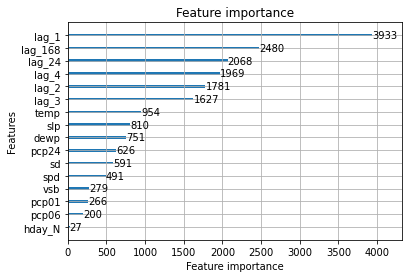

In [40]:
lgb.plot_importance(model)

In [41]:
y_test_df = pd.Series(y_test, index = X_test.index)
y_test_df.index = pd.to_datetime(y_test_df.index)

In [42]:
y_gs = pd.Series(y_gs, index = X_test.index)
y_gs.index = pd.to_datetime(y_gs.index)
y_gs

pickup_dt
2015-05-07 17:00:00    3764.495880
2015-05-07 18:00:00    4354.986360
2015-05-07 19:00:00    4813.657735
2015-05-07 20:00:00    4957.914327
2015-05-07 21:00:00    4353.676407
                          ...     
2015-06-30 19:00:00    4892.904268
2015-06-30 20:00:00    4755.508990
2015-06-30 21:00:00    4122.121652
2015-06-30 22:00:00    4182.632905
2015-06-30 23:00:00    4108.256676
Length: 1303, dtype: float64

In [43]:
pd.concat([y_test_df,y_pred_df], axis=1).plot()


Figure(id='1003', ...)

In [48]:
y_test_df

pickup_dt
2015-05-07 17:00:00    3871
2015-05-07 18:00:00    4729
2015-05-07 19:00:00    5336
2015-05-07 20:00:00    4553
2015-05-07 21:00:00    4868
                       ... 
2015-06-30 19:00:00    4585
2015-06-30 20:00:00    4210
2015-06-30 21:00:00    4313
2015-06-30 22:00:00    4452
2015-06-30 23:00:00    3828
Name: pickups, Length: 1303, dtype: int64

In [49]:
y_test_df.to_csv('../y_test_df.csv')

In [ ]:
#import pickle

#pickle.dump(rs_cv, open('model_lgbm.pkl','wb'))